In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from collections import Counter

In [24]:
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
path = os.getcwd()

In [11]:
path_data_train = path + "\\covidChallenge\\data\\train.csv"

In [12]:
path_data_eval = path + "\\covidChallenge\\data\\evaluation.csv"

In [36]:
train_data = pd.read_csv(path_data_train)

In [37]:
train_data.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

In [38]:
#Non-relevant features, due to the fact that those are text not numerical values 
train_data.drop('timestamp', axis=1, inplace=True)
train_data.drop('user_mentions', axis=1, inplace=True)
train_data.drop('urls', axis=1, inplace=True)
train_data.drop('hashtags', axis=1, inplace=True)
train_data.drop('text', axis=1, inplace=True)
train_data.drop('id', axis=1, inplace=True)

In [39]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count'],
      dtype='object')

In [40]:
#Convert boolean variables into int (Verified/Non-verified account)
train_data = train_data.astype(int)

In [41]:
pd.set_option('precision', 2)
print(train_data.describe())

       retweet_count  user_verified  user_statuses_count  \
count      665777.00      665777.00             6.66e+05   
mean          147.69           0.13             4.17e+04   
std          2972.05           0.34             9.85e+04   
min             0.00           0.00             0.00e+00   
25%             0.00           0.00             2.35e+03   
50%             0.00           0.00             1.08e+04   
75%             2.00           0.00             3.81e+04   
max        942572.00           1.00             7.20e+06   

       user_followers_count  user_friends_count  
count              6.66e+05            6.66e+05  
mean               2.33e+05            2.74e+03  
std                2.44e+06            1.73e+04  
min                0.00e+00            0.00e+00  
25%                2.06e+02            2.29e+02  
50%                1.00e+03            6.39e+02  
75%                6.01e+03            1.75e+03  
max                1.17e+08            4.40e+06  


In [42]:
correlation = train_data.corr(method='pearson')
columns = correlation.nlargest(5, 'retweet_count').index
columns

Index(['retweet_count', 'user_followers_count', 'user_verified',
       'user_friends_count', 'user_statuses_count'],
      dtype='object')

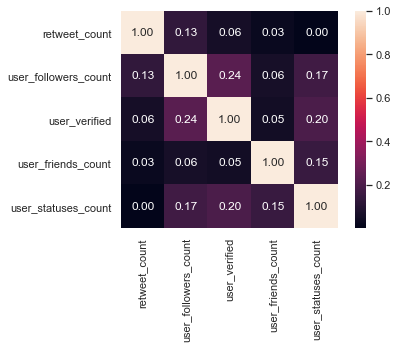

In [43]:
correlation_map = np.corrcoef(train_data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

**Comment:**
> - We can observe clearly that the feature of "user_verified" is highly correlated with nbr of followers.
> - Nbr of statues is also quite correlated with nbr of followers.

- Before feeding the data into our model, we need to apply normalization, since I have noticed that the user_verified feature is binary (0/1), but the other features are very big in the range of millions.

#### Normalizing dataset using log

In [56]:
import scipy.stats as stats

In [44]:
print("user_statuses_count: ", max(train_data["user_statuses_count"]))
print("retweet_count: ", max(train_data["retweet_count"]))
print("user_followers_count : ", max(train_data["user_followers_count"]))
print("user_friends_count  ", max(train_data["user_friends_count"]))

user_statuses_count:  7203222
retweet_count:  942572
user_followers_count :  117064033
user_friends_count   4399078


In [57]:
normalized_data = train_data.copy()
normalized_data['user_statuses_count'] = stats.zscore(train_data['user_statuses_count'])
#train_data['retweet_count'] = np.log(train_data['retweet_count'])
normalized_data['user_followers_count'] = stats.zscore(train_data['user_followers_count'])
normalized_data['user_friends_count'] = stats.zscore(train_data['user_friends_count'])

In [61]:
normalized_data.describe()

retweet_count  user_verified  user_statuses_count  \
count      665777.00      665777.00             6.66e+05   
mean          147.69           0.13             1.15e-17   
std          2972.05           0.34             1.00e+00   
min             0.00           0.00            -4.23e-01   
25%             0.00           0.00            -3.99e-01   
50%             0.00           0.00            -3.13e-01   
75%             2.00           0.00            -3.63e-02   
max        942572.00           1.00             7.27e+01   

       user_followers_count  user_friends_count  
count              6.66e+05            6.66e+05  
mean               5.12e-18            8.50e-18  
std                1.00e+00            1.00e+00  
min               -9.54e-02           -1.59e-01  
25%               -9.53e-02           -1.46e-01  
50%               -9.50e-02           -1.22e-01  
75%               -9.29e-02           -5.78e-02  
max                4.78e+01            2.55e+02

In [62]:
X = normalized_data[columns]
Y = X['retweet_count'].values
X = X.drop('retweet_count', axis = 1).values

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

In [73]:
X_train.shape

(532621, 4)

#### Building Model

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ScaledLR: -8489162.860053 (5534848.833839)
ScaledLASSO: -8489161.979561 (5535001.190181)


C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ScaledEN: -8508085.803731 (5549763.335968)


C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ScaledKNN: -9804140.798299 (5565368.380371)


C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ScaledCART: -16096208.467142 (7686360.594701)


C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


ScaledGBM: -9326762.062066 (7130170.855509)


***Gradient Boosting Regression:***

The weak learners in _AdaBoost_ are decision trees with a single split, called _decision stumps_ for their shortness.

_AdaBoost_ works by weighting the observations, putting more weight on difficult to classify instances and less on those already handled well. New weak learners are added sequentially that focus their training on the more difficult patterns.

The statistical framework cast boosting as a numerical optimization problem where the objective is to minimize the loss of the model by adding weak learners using a gradient descent like procedure.

This class of algorithms were described as a stage-wise additive model. This is because one new weak learner is added at a time and existing weak learners in the model are frozen and left unchanged.

The generalization allowed arbitrary differentiable loss functions to be used, expanding the technique beyond binary classification problems to support regression, multi-class classification and more.

From the output above, it looks like the Gradient Boosting Regressor operforms the best using a scaled version of the data. From this point onward, I will build the regression algorithm using the Gradient Boosting Regressor. The GBM will be tested with a few n_estimators using the GridSearchCV function.

In [66]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))

model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Imadeddine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-8979803.687073 (6887439.193712) with: {'n_estimators': 50}
-9321692.421116 (7132551.388807) with: {'n_estimators': 100}
-9568378.783218 (7310065.136642) with: {'n_estimators': 200}
-9770265.288415 (7397799.731137) with: {'n_estimators': 300}
-9881169.803426 (7408956.657894) with: {'n_estimators': 400}
Best: -8979803.687073 using {'n_estimators': 50}


In [78]:
predict = grid_result.predict(X_test)

In [81]:
from sklearn.metrics import mean_absolute_error
print("\t Prediction error using MAE: ", mean_absolute_error(y_true=Y_test, y_pred=predict))

	 Prediction error using MAE:  228.2517497777036


In [84]:
evaluation = pd.read_csv(path_data_eval)

In [85]:
#Non-relevant features, due to the fact that those are text not numerical values 
evaluation.drop('timestamp', axis=1, inplace=True)
evaluation.drop('user_mentions', axis=1, inplace=True)
evaluation.drop('urls', axis=1, inplace=True)
evaluation.drop('hashtags', axis=1, inplace=True)
evaluation.drop('text', axis=1, inplace=True)

In [86]:
withoutID = evaluation.copy()
withoutID.drop('id', axis=1, inplace=True)

In [87]:
predict_eval = grid_result.predict(withoutID)

In [88]:
import csv

f = open("BoostingReg.csv", "w+")
with open("BoostingReg.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(predict_eval):
        print(str(evaluation['id'].iloc[index]) + " ," + str(int(prediction)))
        writer.writerow([str(evaluation['id'].iloc[index]) , str(int(prediction))])

665776 ,325
665777 ,428
665778 ,325
665779 ,428
665780 ,325
665781 ,325
665782 ,325
665783 ,428
665784 ,428
665785 ,325
665786 ,428
665787 ,325
665788 ,325
665789 ,428
665790 ,325
665791 ,325
665792 ,325
665793 ,325
665794 ,428
665795 ,325
665796 ,325
665797 ,325
665798 ,325
665799 ,325
665800 ,325
665801 ,325
665802 ,325
665803 ,325
665804 ,325
665805 ,325
665806 ,316
665807 ,325
665808 ,428
665809 ,325
665810 ,325
665811 ,428
665812 ,316
665813 ,325
665814 ,428
665815 ,325
665816 ,325
665817 ,325
665818 ,325
665819 ,325
665820 ,325
665821 ,325
665822 ,325
665823 ,325
665824 ,325
665825 ,325
665826 ,428
665827 ,325
665828 ,428
665829 ,325
665830 ,325
665831 ,325
665832 ,325
665833 ,325
665834 ,325
665835 ,325
665836 ,325
665837 ,316
665838 ,428
665839 ,325
665840 ,325
665841 ,325
665842 ,325
665843 ,325
665844 ,325
665845 ,325
665846 ,325
665847 ,325
665848 ,325
665849 ,428
665850 ,325
665851 ,325
665852 ,325
665853 ,325
665854 ,325
665855 ,325
665856 ,325
665857 ,325
665858 ,325
6658

667029 ,325
667030 ,325
667031 ,325
667032 ,325
667033 ,325
667034 ,325
667035 ,325
667036 ,325
667037 ,325
667038 ,325
667039 ,325
667040 ,325
667041 ,325
667042 ,325
667043 ,325
667044 ,325
667045 ,325
667046 ,428
667047 ,325
667048 ,325
667049 ,325
667050 ,325
667051 ,325
667052 ,325
667053 ,325
667054 ,325
667055 ,428
667056 ,325
667057 ,428
667058 ,428
667059 ,325
667060 ,325
667061 ,428
667062 ,325
667063 ,325
667064 ,325
667065 ,325
667066 ,325
667067 ,428
667068 ,325
667069 ,428
667070 ,325
667071 ,325
667072 ,325
667073 ,316
667074 ,325
667075 ,325
667076 ,325
667077 ,316
667078 ,325
667079 ,428
667080 ,325
667081 ,316
667082 ,325
667083 ,325
667084 ,428
667085 ,325
667086 ,428
667087 ,325
667088 ,325
667089 ,325
667090 ,325
667091 ,325
667092 ,325
667093 ,325
667094 ,325
667095 ,325
667096 ,325
667097 ,325
667098 ,325
667099 ,325
667100 ,325
667101 ,428
667102 ,325
667103 ,325
667104 ,325
667105 ,325
667106 ,325
667107 ,325
667108 ,428
667109 ,325
667110 ,325
667111 ,325
6671

667915 ,325
667916 ,325
667917 ,325
667918 ,325
667919 ,325
667920 ,325
667921 ,325
667922 ,325
667923 ,325
667924 ,325
667925 ,325
667926 ,428
667927 ,325
667928 ,325
667929 ,428
667930 ,382
667931 ,316
667932 ,325
667933 ,325
667934 ,325
667935 ,325
667936 ,325
667937 ,325
667938 ,325
667939 ,325
667940 ,325
667941 ,325
667942 ,325
667943 ,316
667944 ,325
667945 ,428
667946 ,325
667947 ,428
667948 ,325
667949 ,325
667950 ,325
667951 ,325
667952 ,325
667953 ,325
667954 ,325
667955 ,428
667956 ,325
667957 ,325
667958 ,325
667959 ,325
667960 ,325
667961 ,325
667962 ,325
667963 ,325
667964 ,325
667965 ,428
667966 ,316
667967 ,325
667968 ,325
667969 ,325
667970 ,325
667971 ,325
667972 ,325
667973 ,325
667974 ,325
667975 ,316
667976 ,428
667977 ,325
667978 ,325
667979 ,325
667980 ,325
667981 ,316
667982 ,325
667983 ,325
667984 ,428
667985 ,325
667986 ,428
667987 ,325
667988 ,325
667989 ,316
667990 ,325
667991 ,325
667992 ,428
667993 ,316
667994 ,325
667995 ,325
667996 ,316
667997 ,316
6679

668744 ,325
668745 ,325
668746 ,428
668747 ,325
668748 ,325
668749 ,325
668750 ,325
668751 ,325
668752 ,325
668753 ,382
668754 ,325
668755 ,428
668756 ,325
668757 ,325
668758 ,325
668759 ,325
668760 ,325
668761 ,325
668762 ,325
668763 ,325
668764 ,325
668765 ,325
668766 ,325
668767 ,428
668768 ,325
668769 ,325
668770 ,325
668771 ,325
668772 ,325
668773 ,325
668774 ,325
668775 ,428
668776 ,325
668777 ,325
668778 ,325
668779 ,428
668780 ,325
668781 ,325
668782 ,325
668783 ,325
668784 ,325
668785 ,316
668786 ,325
668787 ,428
668788 ,325
668789 ,325
668790 ,325
668791 ,325
668792 ,325
668793 ,325
668794 ,325
668795 ,325
668796 ,316
668797 ,325
668798 ,325
668799 ,316
668800 ,325
668801 ,428
668802 ,428
668803 ,325
668804 ,325
668805 ,325
668806 ,325
668807 ,325
668808 ,325
668809 ,325
668810 ,325
668811 ,325
668812 ,316
668813 ,325
668814 ,325
668815 ,325
668816 ,325
668817 ,325
668818 ,325
668819 ,325
668820 ,325
668821 ,325
668822 ,325
668823 ,325
668824 ,325
668825 ,325
668826 ,325
6688

669518 ,316
669519 ,325
669520 ,325
669521 ,325
669522 ,325
669523 ,325
669524 ,325
669525 ,325
669526 ,325
669527 ,428
669528 ,325
669529 ,316
669530 ,428
669531 ,428
669532 ,325
669533 ,428
669534 ,325
669535 ,428
669536 ,325
669537 ,316
669538 ,325
669539 ,428
669540 ,428
669541 ,325
669542 ,325
669543 ,325
669544 ,325
669545 ,325
669546 ,325
669547 ,325
669548 ,428
669549 ,325
669550 ,428
669551 ,325
669552 ,428
669553 ,325
669554 ,325
669555 ,325
669556 ,316
669557 ,325
669558 ,428
669559 ,325
669560 ,325
669561 ,428
669562 ,325
669563 ,325
669564 ,428
669565 ,325
669566 ,325
669567 ,428
669568 ,325
669569 ,325
669570 ,325
669571 ,325
669572 ,325
669573 ,325
669574 ,316
669575 ,325
669576 ,325
669577 ,325
669578 ,428
669579 ,325
669580 ,325
669581 ,325
669582 ,428
669583 ,325
669584 ,325
669585 ,325
669586 ,325
669587 ,325
669588 ,316
669589 ,325
669590 ,325
669591 ,325
669592 ,325
669593 ,325
669594 ,325
669595 ,325
669596 ,325
669597 ,325
669598 ,325
669599 ,325
669600 ,316
6696

670236 ,325
670237 ,325
670238 ,325
670239 ,325
670240 ,325
670241 ,325
670242 ,325
670243 ,325
670244 ,325
670245 ,325
670246 ,428
670247 ,325
670248 ,325
670249 ,325
670250 ,325
670251 ,325
670252 ,325
670253 ,316
670254 ,325
670255 ,325
670256 ,428
670257 ,428
670258 ,428
670259 ,325
670260 ,325
670261 ,316
670262 ,325
670263 ,325
670264 ,325
670265 ,325
670266 ,325
670267 ,325
670268 ,325
670269 ,325
670270 ,325
670271 ,325
670272 ,428
670273 ,325
670274 ,428
670275 ,428
670276 ,428
670277 ,325
670278 ,325
670279 ,325
670280 ,325
670281 ,325
670282 ,428
670283 ,325
670284 ,325
670285 ,316
670286 ,325
670287 ,325
670288 ,325
670289 ,325
670290 ,428
670291 ,316
670292 ,325
670293 ,325
670294 ,325
670295 ,325
670296 ,316
670297 ,325
670298 ,325
670299 ,428
670300 ,325
670301 ,325
670302 ,325
670303 ,325
670304 ,325
670305 ,325
670306 ,325
670307 ,325
670308 ,325
670309 ,325
670310 ,325
670311 ,325
670312 ,552
670313 ,428
670314 ,325
670315 ,325
670316 ,325
670317 ,325
670318 ,428
6703

671027 ,325
671028 ,325
671029 ,325
671030 ,325
671031 ,325
671032 ,325
671033 ,428
671034 ,325
671035 ,325
671036 ,325
671037 ,428
671038 ,325
671039 ,325
671040 ,325
671041 ,428
671042 ,316
671043 ,325
671044 ,325
671045 ,325
671046 ,325
671047 ,325
671048 ,325
671049 ,325
671050 ,325
671051 ,325
671052 ,325
671053 ,325
671054 ,428
671055 ,428
671056 ,325
671057 ,325
671058 ,325
671059 ,325
671060 ,325
671061 ,390
671062 ,325
671063 ,428
671064 ,325
671065 ,325
671066 ,325
671067 ,325
671068 ,325
671069 ,325
671070 ,325
671071 ,325
671072 ,325
671073 ,325
671074 ,325
671075 ,325
671076 ,325
671077 ,325
671078 ,325
671079 ,325
671080 ,325
671081 ,325
671082 ,325
671083 ,325
671084 ,325
671085 ,325
671086 ,325
671087 ,325
671088 ,325
671089 ,325
671090 ,325
671091 ,325
671092 ,325
671093 ,325
671094 ,325
671095 ,553
671096 ,428
671097 ,325
671098 ,325
671099 ,325
671100 ,325
671101 ,325
671102 ,325
671103 ,428
671104 ,325
671105 ,325
671106 ,325
671107 ,325
671108 ,316
671109 ,325
6711

672026 ,325
672027 ,428
672028 ,325
672029 ,325
672030 ,325
672031 ,325
672032 ,325
672033 ,325
672034 ,552
672035 ,325
672036 ,428
672037 ,325
672038 ,325
672039 ,325
672040 ,325
672041 ,325
672042 ,325
672043 ,325
672044 ,428
672045 ,325
672046 ,316
672047 ,325
672048 ,325
672049 ,325
672050 ,325
672051 ,325
672052 ,325
672053 ,325
672054 ,325
672055 ,428
672056 ,325
672057 ,390
672058 ,428
672059 ,428
672060 ,325
672061 ,325
672062 ,325
672063 ,325
672064 ,428
672065 ,325
672066 ,325
672067 ,325
672068 ,428
672069 ,325
672070 ,325
672071 ,325
672072 ,325
672073 ,325
672074 ,325
672075 ,325
672076 ,325
672077 ,316
672078 ,325
672079 ,325
672080 ,325
672081 ,428
672082 ,325
672083 ,325
672084 ,325
672085 ,325
672086 ,325
672087 ,325
672088 ,325
672089 ,325
672090 ,325
672091 ,428
672092 ,325
672093 ,325
672094 ,325
672095 ,428
672096 ,325
672097 ,316
672098 ,325
672099 ,316
672100 ,325
672101 ,428
672102 ,325
672103 ,325
672104 ,325
672105 ,325
672106 ,325
672107 ,325
672108 ,325
6721

673025 ,316
673026 ,325
673027 ,325
673028 ,325
673029 ,325
673030 ,325
673031 ,325
673032 ,428
673033 ,325
673034 ,325
673035 ,325
673036 ,325
673037 ,428
673038 ,325
673039 ,316
673040 ,325
673041 ,325
673042 ,325
673043 ,325
673044 ,428
673045 ,325
673046 ,325
673047 ,325
673048 ,428
673049 ,428
673050 ,325
673051 ,325
673052 ,325
673053 ,325
673054 ,325
673055 ,325
673056 ,428
673057 ,325
673058 ,325
673059 ,325
673060 ,325
673061 ,325
673062 ,428
673063 ,325
673064 ,325
673065 ,325
673066 ,316
673067 ,325
673068 ,325
673069 ,325
673070 ,325
673071 ,428
673072 ,325
673073 ,325
673074 ,325
673075 ,325
673076 ,325
673077 ,325
673078 ,325
673079 ,325
673080 ,325
673081 ,325
673082 ,325
673083 ,325
673084 ,325
673085 ,428
673086 ,325
673087 ,325
673088 ,325
673089 ,428
673090 ,316
673091 ,325
673092 ,325
673093 ,325
673094 ,325
673095 ,325
673096 ,325
673097 ,325
673098 ,325
673099 ,325
673100 ,428
673101 ,325
673102 ,325
673103 ,316
673104 ,325
673105 ,325
673106 ,325
673107 ,325
6731

673961 ,325
673962 ,325
673963 ,325
673964 ,325
673965 ,325
673966 ,325
673967 ,325
673968 ,325
673969 ,325
673970 ,325
673971 ,325
673972 ,325
673973 ,325
673974 ,428
673975 ,325
673976 ,325
673977 ,325
673978 ,325
673979 ,325
673980 ,325
673981 ,325
673982 ,428
673983 ,325
673984 ,325
673985 ,325
673986 ,325
673987 ,316
673988 ,325
673989 ,325
673990 ,325
673991 ,325
673992 ,325
673993 ,325
673994 ,325
673995 ,325
673996 ,325
673997 ,325
673998 ,325
673999 ,428
674000 ,316
674001 ,325
674002 ,325
674003 ,325
674004 ,316
674005 ,325
674006 ,325
674007 ,325
674008 ,1347
674009 ,428
674010 ,325
674011 ,325
674012 ,325
674013 ,316
674014 ,325
674015 ,325
674016 ,325
674017 ,325
674018 ,325
674019 ,325
674020 ,325
674021 ,428
674022 ,325
674023 ,325
674024 ,325
674025 ,325
674026 ,325
674027 ,325
674028 ,325
674029 ,325
674030 ,325
674031 ,325
674032 ,325
674033 ,325
674034 ,325
674035 ,325
674036 ,428
674037 ,428
674038 ,316
674039 ,325
674040 ,325
674041 ,325
674042 ,325
674043 ,325
674

674740 ,325
674741 ,325
674742 ,325
674743 ,325
674744 ,325
674745 ,325
674746 ,316
674747 ,325
674748 ,428
674749 ,325
674750 ,325
674751 ,325
674752 ,325
674753 ,325
674754 ,325
674755 ,428
674756 ,325
674757 ,316
674758 ,325
674759 ,428
674760 ,325
674761 ,325
674762 ,325
674763 ,325
674764 ,325
674765 ,325
674766 ,325
674767 ,428
674768 ,325
674769 ,325
674770 ,325
674771 ,325
674772 ,325
674773 ,325
674774 ,325
674775 ,325
674776 ,428
674777 ,428
674778 ,325
674779 ,325
674780 ,325
674781 ,325
674782 ,428
674783 ,325
674784 ,325
674785 ,325
674786 ,325
674787 ,325
674788 ,428
674789 ,325
674790 ,325
674791 ,325
674792 ,428
674793 ,325
674794 ,325
674795 ,325
674796 ,325
674797 ,316
674798 ,316
674799 ,316
674800 ,428
674801 ,325
674802 ,325
674803 ,325
674804 ,325
674805 ,325
674806 ,325
674807 ,325
674808 ,316
674809 ,325
674810 ,325
674811 ,325
674812 ,325
674813 ,325
674814 ,325
674815 ,325
674816 ,325
674817 ,325
674818 ,325
674819 ,316
674820 ,325
674821 ,325
674822 ,325
6748

676022 ,325
676023 ,325
676024 ,325
676025 ,316
676026 ,325
676027 ,325
676028 ,325
676029 ,325
676030 ,325
676031 ,325
676032 ,325
676033 ,428
676034 ,428
676035 ,325
676036 ,325
676037 ,325
676038 ,325
676039 ,325
676040 ,325
676041 ,428
676042 ,325
676043 ,325
676044 ,428
676045 ,325
676046 ,325
676047 ,325
676048 ,325
676049 ,325
676050 ,325
676051 ,325
676052 ,325
676053 ,325
676054 ,325
676055 ,325
676056 ,325
676057 ,325
676058 ,428
676059 ,325
676060 ,325
676061 ,325
676062 ,428
676063 ,325
676064 ,325
676065 ,428
676066 ,325
676067 ,325
676068 ,325
676069 ,325
676070 ,325
676071 ,325
676072 ,325
676073 ,325
676074 ,325
676075 ,325
676076 ,325
676077 ,325
676078 ,325
676079 ,325
676080 ,325
676081 ,325
676082 ,325
676083 ,325
676084 ,325
676085 ,325
676086 ,325
676087 ,428
676088 ,428
676089 ,325
676090 ,428
676091 ,325
676092 ,325
676093 ,325
676094 ,325
676095 ,325
676096 ,428
676097 ,325
676098 ,325
676099 ,325
676100 ,325
676101 ,325
676102 ,316
676103 ,325
676104 ,316
6761

677074 ,325
677075 ,325
677076 ,325
677077 ,428
677078 ,428
677079 ,325
677080 ,325
677081 ,325
677082 ,325
677083 ,325
677084 ,325
677085 ,325
677086 ,325
677087 ,325
677088 ,325
677089 ,325
677090 ,325
677091 ,325
677092 ,325
677093 ,428
677094 ,428
677095 ,325
677096 ,325
677097 ,325
677098 ,325
677099 ,325
677100 ,325
677101 ,325
677102 ,325
677103 ,428
677104 ,325
677105 ,325
677106 ,325
677107 ,325
677108 ,325
677109 ,428
677110 ,428
677111 ,325
677112 ,325
677113 ,325
677114 ,325
677115 ,428
677116 ,325
677117 ,325
677118 ,325
677119 ,325
677120 ,325
677121 ,325
677122 ,325
677123 ,325
677124 ,325
677125 ,325
677126 ,325
677127 ,325
677128 ,316
677129 ,428
677130 ,316
677131 ,325
677132 ,325
677133 ,428
677134 ,325
677135 ,325
677136 ,325
677137 ,325
677138 ,316
677139 ,325
677140 ,325
677141 ,325
677142 ,325
677143 ,325
677144 ,325
677145 ,428
677146 ,325
677147 ,325
677148 ,325
677149 ,325
677150 ,325
677151 ,325
677152 ,325
677153 ,325
677154 ,325
677155 ,325
677156 ,325
6771

677965 ,325
677966 ,325
677967 ,316
677968 ,316
677969 ,325
677970 ,325
677971 ,325
677972 ,325
677973 ,325
677974 ,325
677975 ,325
677976 ,325
677977 ,325
677978 ,325
677979 ,325
677980 ,325
677981 ,325
677982 ,325
677983 ,316
677984 ,325
677985 ,325
677986 ,428
677987 ,316
677988 ,325
677989 ,316
677990 ,325
677991 ,428
677992 ,325
677993 ,325
677994 ,325
677995 ,325
677996 ,325
677997 ,325
677998 ,325
677999 ,325
678000 ,325
678001 ,325
678002 ,428
678003 ,325
678004 ,325
678005 ,316
678006 ,325
678007 ,325
678008 ,325
678009 ,428
678010 ,325
678011 ,325
678012 ,325
678013 ,325
678014 ,325
678015 ,325
678016 ,325
678017 ,325
678018 ,428
678019 ,325
678020 ,325
678021 ,428
678022 ,325
678023 ,325
678024 ,428
678025 ,325
678026 ,325
678027 ,325
678028 ,325
678029 ,325
678030 ,325
678031 ,325
678032 ,325
678033 ,325
678034 ,325
678035 ,325
678036 ,325
678037 ,325
678038 ,325
678039 ,325
678040 ,325
678041 ,316
678042 ,325
678043 ,325
678044 ,325
678045 ,428
678046 ,325
678047 ,325
6780

678776 ,428
678777 ,325
678778 ,316
678779 ,325
678780 ,325
678781 ,325
678782 ,325
678783 ,325
678784 ,325
678785 ,325
678786 ,325
678787 ,325
678788 ,325
678789 ,325
678790 ,325
678791 ,325
678792 ,325
678793 ,325
678794 ,428
678795 ,325
678796 ,428
678797 ,325
678798 ,325
678799 ,325
678800 ,325
678801 ,428
678802 ,325
678803 ,325
678804 ,325
678805 ,325
678806 ,325
678807 ,325
678808 ,428
678809 ,325
678810 ,428
678811 ,325
678812 ,316
678813 ,325
678814 ,325
678815 ,325
678816 ,325
678817 ,325
678818 ,428
678819 ,325
678820 ,325
678821 ,325
678822 ,553
678823 ,325
678824 ,325
678825 ,428
678826 ,316
678827 ,325
678828 ,325
678829 ,325
678830 ,325
678831 ,325
678832 ,325
678833 ,325
678834 ,325
678835 ,325
678836 ,325
678837 ,316
678838 ,325
678839 ,428
678840 ,325
678841 ,325
678842 ,325
678843 ,325
678844 ,325
678845 ,325
678846 ,325
678847 ,325
678848 ,325
678849 ,325
678850 ,428
678851 ,325
678852 ,325
678853 ,325
678854 ,325
678855 ,325
678856 ,325
678857 ,325
678858 ,325
6788

679671 ,325
679672 ,325
679673 ,428
679674 ,316
679675 ,325
679676 ,325
679677 ,325
679678 ,316
679679 ,325
679680 ,325
679681 ,325
679682 ,325
679683 ,325
679684 ,325
679685 ,325
679686 ,428
679687 ,325
679688 ,325
679689 ,325
679690 ,325
679691 ,325
679692 ,325
679693 ,325
679694 ,325
679695 ,325
679696 ,325
679697 ,325
679698 ,325
679699 ,325
679700 ,428
679701 ,325
679702 ,325
679703 ,325
679704 ,325
679705 ,325
679706 ,325
679707 ,325
679708 ,316
679709 ,325
679710 ,428
679711 ,325
679712 ,428
679713 ,428
679714 ,316
679715 ,325
679716 ,325
679717 ,325
679718 ,428
679719 ,325
679720 ,428
679721 ,325
679722 ,325
679723 ,428
679724 ,325
679725 ,325
679726 ,325
679727 ,325
679728 ,325
679729 ,325
679730 ,325
679731 ,428
679732 ,325
679733 ,325
679734 ,325
679735 ,428
679736 ,325
679737 ,325
679738 ,325
679739 ,325
679740 ,325
679741 ,325
679742 ,428
679743 ,325
679744 ,325
679745 ,325
679746 ,325
679747 ,325
679748 ,325
679749 ,325
679750 ,325
679751 ,325
679752 ,390
679753 ,325
6797

680616 ,428
680617 ,325
680618 ,325
680619 ,325
680620 ,428
680621 ,325
680622 ,325
680623 ,325
680624 ,325
680625 ,325
680626 ,325
680627 ,325
680628 ,325
680629 ,325
680630 ,325
680631 ,325
680632 ,325
680633 ,325
680634 ,325
680635 ,325
680636 ,325
680637 ,325
680638 ,428
680639 ,325
680640 ,428
680641 ,325
680642 ,428
680643 ,325
680644 ,428
680645 ,325
680646 ,325
680647 ,325
680648 ,325
680649 ,325
680650 ,316
680651 ,325
680652 ,325
680653 ,325
680654 ,325
680655 ,325
680656 ,428
680657 ,325
680658 ,428
680659 ,325
680660 ,325
680661 ,325
680662 ,325
680663 ,325
680664 ,325
680665 ,325
680666 ,325
680667 ,428
680668 ,325
680669 ,325
680670 ,325
680671 ,325
680672 ,325
680673 ,325
680674 ,325
680675 ,428
680676 ,325
680677 ,325
680678 ,428
680679 ,428
680680 ,325
680681 ,325
680682 ,325
680683 ,316
680684 ,316
680685 ,325
680686 ,325
680687 ,325
680688 ,325
680689 ,325
680690 ,325
680691 ,325
680692 ,325
680693 ,390
680694 ,325
680695 ,1347
680696 ,325
680697 ,428
680698 ,325
680

681370 ,325
681371 ,325
681372 ,325
681373 ,325
681374 ,325
681375 ,428
681376 ,325
681377 ,325
681378 ,325
681379 ,325
681380 ,325
681381 ,325
681382 ,325
681383 ,325
681384 ,325
681385 ,325
681386 ,325
681387 ,325
681388 ,325
681389 ,428
681390 ,325
681391 ,325
681392 ,325
681393 ,325
681394 ,325
681395 ,325
681396 ,325
681397 ,325
681398 ,325
681399 ,325
681400 ,325
681401 ,325
681402 ,325
681403 ,325
681404 ,428
681405 ,325
681406 ,316
681407 ,428
681408 ,428
681409 ,325
681410 ,428
681411 ,325
681412 ,428
681413 ,325
681414 ,325
681415 ,325
681416 ,325
681417 ,325
681418 ,428
681419 ,325
681420 ,325
681421 ,325
681422 ,325
681423 ,325
681424 ,428
681425 ,325
681426 ,325
681427 ,325
681428 ,325
681429 ,325
681430 ,428
681431 ,325
681432 ,325
681433 ,325
681434 ,325
681435 ,428
681436 ,325
681437 ,325
681438 ,325
681439 ,325
681440 ,325
681441 ,325
681442 ,325
681443 ,325
681444 ,325
681445 ,325
681446 ,325
681447 ,325
681448 ,325
681449 ,325
681450 ,428
681451 ,325
681452 ,316
6814

682388 ,325
682389 ,325
682390 ,325
682391 ,325
682392 ,325
682393 ,316
682394 ,428
682395 ,325
682396 ,325
682397 ,325
682398 ,325
682399 ,325
682400 ,325
682401 ,325
682402 ,325
682403 ,325
682404 ,325
682405 ,325
682406 ,325
682407 ,325
682408 ,325
682409 ,325
682410 ,325
682411 ,325
682412 ,325
682413 ,325
682414 ,325
682415 ,325
682416 ,325
682417 ,325
682418 ,325
682419 ,325
682420 ,428
682421 ,325
682422 ,428
682423 ,325
682424 ,428
682425 ,325
682426 ,325
682427 ,325
682428 ,325
682429 ,325
682430 ,428
682431 ,325
682432 ,325
682433 ,325
682434 ,428
682435 ,325
682436 ,325
682437 ,325
682438 ,428
682439 ,325
682440 ,325
682441 ,325
682442 ,325
682443 ,325
682444 ,325
682445 ,325
682446 ,325
682447 ,325
682448 ,325
682449 ,325
682450 ,428
682451 ,325
682452 ,325
682453 ,325
682454 ,325
682455 ,325
682456 ,325
682457 ,325
682458 ,316
682459 ,325
682460 ,325
682461 ,325
682462 ,325
682463 ,325
682464 ,325
682465 ,325
682466 ,325
682467 ,325
682468 ,325
682469 ,325
682470 ,325
6824

683300 ,325
683301 ,325
683302 ,428
683303 ,325
683304 ,325
683305 ,325
683306 ,325
683307 ,325
683308 ,325
683309 ,316
683310 ,325
683311 ,325
683312 ,325
683313 ,325
683314 ,325
683315 ,325
683316 ,325
683317 ,325
683318 ,325
683319 ,325
683320 ,428
683321 ,325
683322 ,428
683323 ,428
683324 ,325
683325 ,325
683326 ,428
683327 ,325
683328 ,325
683329 ,325
683330 ,325
683331 ,325
683332 ,325
683333 ,325
683334 ,325
683335 ,325
683336 ,325
683337 ,325
683338 ,325
683339 ,325
683340 ,325
683341 ,325
683342 ,325
683343 ,316
683344 ,325
683345 ,325
683346 ,325
683347 ,325
683348 ,325
683349 ,325
683350 ,325
683351 ,325
683352 ,325
683353 ,325
683354 ,325
683355 ,325
683356 ,325
683357 ,316
683358 ,325
683359 ,325
683360 ,325
683361 ,325
683362 ,325
683363 ,325
683364 ,325
683365 ,428
683366 ,325
683367 ,325
683368 ,325
683369 ,316
683370 ,428
683371 ,325
683372 ,325
683373 ,325
683374 ,325
683375 ,325
683376 ,325
683377 ,325
683378 ,325
683379 ,428
683380 ,325
683381 ,325
683382 ,325
6833

684628 ,325
684629 ,325
684630 ,325
684631 ,316
684632 ,428
684633 ,325
684634 ,428
684635 ,325
684636 ,325
684637 ,428
684638 ,325
684639 ,325
684640 ,325
684641 ,428
684642 ,428
684643 ,428
684644 ,325
684645 ,325
684646 ,325
684647 ,325
684648 ,316
684649 ,325
684650 ,428
684651 ,325
684652 ,325
684653 ,325
684654 ,325
684655 ,325
684656 ,325
684657 ,325
684658 ,325
684659 ,325
684660 ,325
684661 ,428
684662 ,325
684663 ,325
684664 ,325
684665 ,325
684666 ,325
684667 ,325
684668 ,428
684669 ,325
684670 ,428
684671 ,325
684672 ,325
684673 ,325
684674 ,325
684675 ,325
684676 ,325
684677 ,325
684678 ,325
684679 ,325
684680 ,316
684681 ,316
684682 ,428
684683 ,325
684684 ,325
684685 ,325
684686 ,325
684687 ,325
684688 ,325
684689 ,325
684690 ,325
684691 ,428
684692 ,325
684693 ,325
684694 ,325
684695 ,325
684696 ,325
684697 ,325
684698 ,325
684699 ,325
684700 ,428
684701 ,325
684702 ,428
684703 ,316
684704 ,325
684705 ,325
684706 ,325
684707 ,428
684708 ,428
684709 ,428
684710 ,325
6847

685601 ,325
685602 ,325
685603 ,325
685604 ,428
685605 ,325
685606 ,428
685607 ,1347
685608 ,428
685609 ,325
685610 ,428
685611 ,325
685612 ,325
685613 ,325
685614 ,428
685615 ,325
685616 ,325
685617 ,325
685618 ,325
685619 ,325
685620 ,325
685621 ,325
685622 ,325
685623 ,428
685624 ,325
685625 ,325
685626 ,325
685627 ,325
685628 ,325
685629 ,325
685630 ,325
685631 ,325
685632 ,325
685633 ,325
685634 ,325
685635 ,325
685636 ,325
685637 ,325
685638 ,325
685639 ,325
685640 ,325
685641 ,325
685642 ,325
685643 ,325
685644 ,325
685645 ,325
685646 ,325
685647 ,325
685648 ,325
685649 ,325
685650 ,325
685651 ,325
685652 ,428
685653 ,325
685654 ,325
685655 ,428
685656 ,325
685657 ,325
685658 ,325
685659 ,325
685660 ,325
685661 ,325
685662 ,428
685663 ,325
685664 ,325
685665 ,428
685666 ,325
685667 ,325
685668 ,325
685669 ,325
685670 ,325
685671 ,325
685672 ,325
685673 ,316
685674 ,325
685675 ,325
685676 ,325
685677 ,325
685678 ,325
685679 ,325
685680 ,325
685681 ,325
685682 ,325
685683 ,390
685

686654 ,325
686655 ,428
686656 ,325
686657 ,325
686658 ,325
686659 ,325
686660 ,325
686661 ,325
686662 ,325
686663 ,325
686664 ,325
686665 ,325
686666 ,316
686667 ,325
686668 ,325
686669 ,325
686670 ,428
686671 ,325
686672 ,325
686673 ,428
686674 ,325
686675 ,325
686676 ,428
686677 ,428
686678 ,325
686679 ,325
686680 ,325
686681 ,316
686682 ,325
686683 ,325
686684 ,316
686685 ,325
686686 ,325
686687 ,325
686688 ,325
686689 ,325
686690 ,428
686691 ,325
686692 ,325
686693 ,325
686694 ,325
686695 ,325
686696 ,325
686697 ,428
686698 ,316
686699 ,382
686700 ,325
686701 ,325
686702 ,325
686703 ,325
686704 ,325
686705 ,428
686706 ,325
686707 ,325
686708 ,316
686709 ,325
686710 ,428
686711 ,428
686712 ,325
686713 ,325
686714 ,325
686715 ,325
686716 ,325
686717 ,325
686718 ,325
686719 ,325
686720 ,428
686721 ,325
686722 ,325
686723 ,325
686724 ,325
686725 ,325
686726 ,325
686727 ,325
686728 ,325
686729 ,325
686730 ,316
686731 ,316
686732 ,325
686733 ,325
686734 ,325
686735 ,428
686736 ,325
6867

687683 ,325
687684 ,428
687685 ,325
687686 ,325
687687 ,325
687688 ,325
687689 ,325
687690 ,325
687691 ,325
687692 ,428
687693 ,325
687694 ,428
687695 ,325
687696 ,325
687697 ,325
687698 ,325
687699 ,325
687700 ,325
687701 ,325
687702 ,325
687703 ,325
687704 ,325
687705 ,325
687706 ,325
687707 ,325
687708 ,325
687709 ,325
687710 ,325
687711 ,428
687712 ,325
687713 ,325
687714 ,325
687715 ,325
687716 ,325
687717 ,325
687718 ,325
687719 ,325
687720 ,325
687721 ,325
687722 ,428
687723 ,325
687724 ,325
687725 ,325
687726 ,325
687727 ,325
687728 ,428
687729 ,428
687730 ,428
687731 ,325
687732 ,325
687733 ,325
687734 ,325
687735 ,428
687736 ,325
687737 ,325
687738 ,325
687739 ,325
687740 ,325
687741 ,316
687742 ,428
687743 ,325
687744 ,325
687745 ,316
687746 ,325
687747 ,325
687748 ,325
687749 ,325
687750 ,325
687751 ,325
687752 ,325
687753 ,325
687754 ,325
687755 ,325
687756 ,325
687757 ,325
687758 ,325
687759 ,325
687760 ,325
687761 ,325
687762 ,325
687763 ,428
687764 ,325
687765 ,428
6877

688622 ,325
688623 ,316
688624 ,325
688625 ,325
688626 ,325
688627 ,325
688628 ,325
688629 ,428
688630 ,325
688631 ,325
688632 ,325
688633 ,325
688634 ,325
688635 ,325
688636 ,325
688637 ,325
688638 ,428
688639 ,325
688640 ,428
688641 ,325
688642 ,325
688643 ,325
688644 ,325
688645 ,428
688646 ,428
688647 ,325
688648 ,325
688649 ,325
688650 ,325
688651 ,325
688652 ,325
688653 ,325
688654 ,428
688655 ,325
688656 ,325
688657 ,325
688658 ,325
688659 ,325
688660 ,428
688661 ,325
688662 ,325
688663 ,325
688664 ,325
688665 ,316
688666 ,325
688667 ,325
688668 ,428
688669 ,428
688670 ,325
688671 ,316
688672 ,325
688673 ,325
688674 ,325
688675 ,325
688676 ,428
688677 ,316
688678 ,325
688679 ,325
688680 ,325
688681 ,428
688682 ,325
688683 ,325
688684 ,325
688685 ,325
688686 ,325
688687 ,325
688688 ,325
688689 ,428
688690 ,325
688691 ,325
688692 ,325
688693 ,325
688694 ,325
688695 ,325
688696 ,325
688697 ,325
688698 ,325
688699 ,325
688700 ,325
688701 ,325
688702 ,325
688703 ,325
688704 ,325
6887

689917 ,325
689918 ,325
689919 ,325
689920 ,325
689921 ,325
689922 ,325
689923 ,325
689924 ,325
689925 ,325
689926 ,325
689927 ,325
689928 ,325
689929 ,325
689930 ,325
689931 ,316
689932 ,325
689933 ,325
689934 ,325
689935 ,325
689936 ,325
689937 ,325
689938 ,325
689939 ,325
689940 ,325
689941 ,325
689942 ,325
689943 ,325
689944 ,325
689945 ,428
689946 ,325
689947 ,325
689948 ,325
689949 ,325
689950 ,325
689951 ,325
689952 ,325
689953 ,325
689954 ,325
689955 ,325
689956 ,428
689957 ,428
689958 ,428
689959 ,325
689960 ,325
689961 ,325
689962 ,325
689963 ,325
689964 ,428
689965 ,325
689966 ,325
689967 ,428
689968 ,325
689969 ,325
689970 ,428
689971 ,325
689972 ,325
689973 ,325
689974 ,325
689975 ,325
689976 ,325
689977 ,325
689978 ,325
689979 ,325
689980 ,316
689981 ,325
689982 ,325
689983 ,325
689984 ,325
689985 ,428
689986 ,325
689987 ,325
689988 ,325
689989 ,325
689990 ,325
689991 ,428
689992 ,325
689993 ,325
689994 ,428
689995 ,325
689996 ,325
689997 ,325
689998 ,325
689999 ,325
6900

690913 ,325
690914 ,325
690915 ,325
690916 ,325
690917 ,325
690918 ,428
690919 ,325
690920 ,325
690921 ,325
690922 ,316
690923 ,325
690924 ,325
690925 ,325
690926 ,325
690927 ,428
690928 ,325
690929 ,316
690930 ,325
690931 ,325
690932 ,325
690933 ,325
690934 ,325
690935 ,325
690936 ,325
690937 ,325
690938 ,325
690939 ,325
690940 ,325
690941 ,325
690942 ,325
690943 ,316
690944 ,428
690945 ,428
690946 ,325
690947 ,325
690948 ,325
690949 ,325
690950 ,325
690951 ,325
690952 ,325
690953 ,428
690954 ,325
690955 ,428
690956 ,325
690957 ,325
690958 ,325
690959 ,325
690960 ,325
690961 ,325
690962 ,428
690963 ,325
690964 ,325
690965 ,325
690966 ,325
690967 ,325
690968 ,428
690969 ,325
690970 ,325
690971 ,325
690972 ,325
690973 ,325
690974 ,325
690975 ,325
690976 ,325
690977 ,325
690978 ,325
690979 ,325
690980 ,325
690981 ,428
690982 ,325
690983 ,325
690984 ,325
690985 ,325
690986 ,325
690987 ,316
690988 ,325
690989 ,325
690990 ,325
690991 ,325
690992 ,325
690993 ,428
690994 ,325
690995 ,325
6909

692006 ,325
692007 ,428
692008 ,325
692009 ,325
692010 ,428
692011 ,325
692012 ,325
692013 ,325
692014 ,325
692015 ,325
692016 ,325
692017 ,325
692018 ,325
692019 ,428
692020 ,325
692021 ,325
692022 ,325
692023 ,325
692024 ,325
692025 ,325
692026 ,325
692027 ,325
692028 ,325
692029 ,325
692030 ,325
692031 ,325
692032 ,428
692033 ,325
692034 ,325
692035 ,325
692036 ,325
692037 ,325
692038 ,325
692039 ,325
692040 ,325
692041 ,325
692042 ,325
692043 ,325
692044 ,325
692045 ,325
692046 ,325
692047 ,428
692048 ,325
692049 ,325
692050 ,325
692051 ,428
692052 ,325
692053 ,325
692054 ,325
692055 ,325
692056 ,325
692057 ,325
692058 ,325
692059 ,325
692060 ,325
692061 ,428
692062 ,325
692063 ,325
692064 ,325
692065 ,325
692066 ,325
692067 ,325
692068 ,325
692069 ,325
692070 ,325
692071 ,325
692072 ,325
692073 ,325
692074 ,325
692075 ,325
692076 ,325
692077 ,316
692078 ,325
692079 ,325
692080 ,428
692081 ,428
692082 ,325
692083 ,325
692084 ,325
692085 ,325
692086 ,325
692087 ,325
692088 ,325
6920

693011 ,325
693012 ,325
693013 ,316
693014 ,316
693015 ,325
693016 ,325
693017 ,325
693018 ,325
693019 ,428
693020 ,325
693021 ,325
693022 ,428
693023 ,325
693024 ,325
693025 ,553
693026 ,325
693027 ,428
693028 ,428
693029 ,325
693030 ,316
693031 ,325
693032 ,325
693033 ,428
693034 ,325
693035 ,325
693036 ,316
693037 ,325
693038 ,325
693039 ,428
693040 ,325
693041 ,428
693042 ,325
693043 ,325
693044 ,325
693045 ,325
693046 ,553
693047 ,325
693048 ,325
693049 ,325
693050 ,316
693051 ,325
693052 ,325
693053 ,325
693054 ,325
693055 ,325
693056 ,325
693057 ,325
693058 ,325
693059 ,325
693060 ,325
693061 ,325
693062 ,428
693063 ,325
693064 ,390
693065 ,325
693066 ,325
693067 ,325
693068 ,325
693069 ,325
693070 ,325
693071 ,325
693072 ,428
693073 ,325
693074 ,325
693075 ,325
693076 ,316
693077 ,325
693078 ,325
693079 ,325
693080 ,325
693081 ,325
693082 ,325
693083 ,325
693084 ,325
693085 ,325
693086 ,428
693087 ,428
693088 ,316
693089 ,325
693090 ,325
693091 ,325
693092 ,325
693093 ,316
6930

694168 ,325
694169 ,325
694170 ,325
694171 ,325
694172 ,325
694173 ,325
694174 ,325
694175 ,325
694176 ,325
694177 ,325
694178 ,325
694179 ,325
694180 ,325
694181 ,325
694182 ,325
694183 ,325
694184 ,325
694185 ,325
694186 ,325
694187 ,325
694188 ,325
694189 ,325
694190 ,325
694191 ,325
694192 ,325
694193 ,325
694194 ,325
694195 ,325
694196 ,325
694197 ,428
694198 ,325
694199 ,325
694200 ,325
694201 ,325
694202 ,325
694203 ,325
694204 ,325
694205 ,382
694206 ,325
694207 ,325
694208 ,428
694209 ,1347
694210 ,428
694211 ,428
694212 ,325
694213 ,325
694214 ,428
694215 ,428
694216 ,325
694217 ,316
694218 ,325
694219 ,325
694220 ,325
694221 ,325
694222 ,325
694223 ,325
694224 ,325
694225 ,428
694226 ,428
694227 ,428
694228 ,325
694229 ,325
694230 ,325
694231 ,325
694232 ,325
694233 ,316
694234 ,325
694235 ,325
694236 ,325
694237 ,325
694238 ,325
694239 ,325
694240 ,428
694241 ,553
694242 ,325
694243 ,428
694244 ,428
694245 ,325
694246 ,325
694247 ,325
694248 ,325
694249 ,325
694250 ,325
694

695356 ,428
695357 ,325
695358 ,325
695359 ,325
695360 ,428
695361 ,325
695362 ,325
695363 ,325
695364 ,325
695365 ,325
695366 ,325
695367 ,428
695368 ,325
695369 ,325
695370 ,325
695371 ,325
695372 ,325
695373 ,428
695374 ,428
695375 ,428
695376 ,325
695377 ,325
695378 ,325
695379 ,325
695380 ,325
695381 ,325
695382 ,325
695383 ,325
695384 ,325
695385 ,325
695386 ,325
695387 ,325
695388 ,428
695389 ,390
695390 ,325
695391 ,325
695392 ,325
695393 ,325
695394 ,428
695395 ,428
695396 ,325
695397 ,325
695398 ,316
695399 ,325
695400 ,428
695401 ,325
695402 ,325
695403 ,325
695404 ,325
695405 ,325
695406 ,325
695407 ,325
695408 ,325
695409 ,325
695410 ,428
695411 ,325
695412 ,325
695413 ,325
695414 ,325
695415 ,325
695416 ,325
695417 ,325
695418 ,325
695419 ,325
695420 ,325
695421 ,325
695422 ,316
695423 ,316
695424 ,325
695425 ,428
695426 ,325
695427 ,325
695428 ,325
695429 ,325
695430 ,325
695431 ,325
695432 ,325
695433 ,325
695434 ,325
695435 ,325
695436 ,325
695437 ,325
695438 ,325
6954

696721 ,325
696722 ,325
696723 ,325
696724 ,325
696725 ,428
696726 ,325
696727 ,316
696728 ,325
696729 ,325
696730 ,428
696731 ,325
696732 ,325
696733 ,325
696734 ,325
696735 ,325
696736 ,325
696737 ,325
696738 ,428
696739 ,316
696740 ,325
696741 ,325
696742 ,325
696743 ,325
696744 ,325
696745 ,325
696746 ,325
696747 ,428
696748 ,325
696749 ,428
696750 ,325
696751 ,325
696752 ,428
696753 ,325
696754 ,325
696755 ,325
696756 ,325
696757 ,325
696758 ,325
696759 ,325
696760 ,325
696761 ,325
696762 ,325
696763 ,325
696764 ,325
696765 ,325
696766 ,325
696767 ,325
696768 ,325
696769 ,325
696770 ,325
696771 ,325
696772 ,325
696773 ,325
696774 ,325
696775 ,325
696776 ,428
696777 ,325
696778 ,325
696779 ,325
696780 ,325
696781 ,325
696782 ,325
696783 ,325
696784 ,325
696785 ,325
696786 ,325
696787 ,325
696788 ,316
696789 ,316
696790 ,325
696791 ,428
696792 ,428
696793 ,316
696794 ,325
696795 ,325
696796 ,325
696797 ,325
696798 ,325
696799 ,325
696800 ,325
696801 ,325
696802 ,325
696803 ,325
6968

697502 ,325
697503 ,325
697504 ,325
697505 ,325
697506 ,325
697507 ,325
697508 ,325
697509 ,325
697510 ,325
697511 ,325
697512 ,325
697513 ,325
697514 ,325
697515 ,325
697516 ,325
697517 ,428
697518 ,325
697519 ,325
697520 ,382
697521 ,428
697522 ,325
697523 ,325
697524 ,325
697525 ,325
697526 ,1347
697527 ,325
697528 ,428
697529 ,325
697530 ,325
697531 ,325
697532 ,325
697533 ,325
697534 ,428
697535 ,325
697536 ,325
697537 ,325
697538 ,325
697539 ,325
697540 ,325
697541 ,325
697542 ,428
697543 ,325
697544 ,325
697545 ,325
697546 ,325
697547 ,325
697548 ,325
697549 ,325
697550 ,325
697551 ,325
697552 ,316
697553 ,325
697554 ,325
697555 ,325
697556 ,325
697557 ,325
697558 ,325
697559 ,325
697560 ,325
697561 ,325
697562 ,325
697563 ,325
697564 ,325
697565 ,325
697566 ,325
697567 ,428
697568 ,325
697569 ,325
697570 ,325
697571 ,325
697572 ,325
697573 ,325
697574 ,325
697575 ,325
697576 ,428
697577 ,325
697578 ,325
697579 ,325
697580 ,325
697581 ,325
697582 ,325
697583 ,325
697584 ,325
697

698306 ,325
698307 ,325
698308 ,325
698309 ,428
698310 ,325
698311 ,325
698312 ,325
698313 ,325
698314 ,325
698315 ,325
698316 ,428
698317 ,428
698318 ,325
698319 ,325
698320 ,325
698321 ,325
698322 ,325
698323 ,325
698324 ,325
698325 ,325
698326 ,325
698327 ,428
698328 ,325
698329 ,325
698330 ,325
698331 ,325
698332 ,428
698333 ,325
698334 ,325
698335 ,325
698336 ,428
698337 ,325
698338 ,325
698339 ,325
698340 ,325
698341 ,325
698342 ,325
698343 ,325
698344 ,325
698345 ,325
698346 ,428
698347 ,325
698348 ,316
698349 ,325
698350 ,316
698351 ,325
698352 ,316
698353 ,325
698354 ,325
698355 ,325
698356 ,325
698357 ,325
698358 ,325
698359 ,325
698360 ,325
698361 ,316
698362 ,325
698363 ,325
698364 ,325
698365 ,428
698366 ,325
698367 ,325
698368 ,316
698369 ,325
698370 ,325
698371 ,325
698372 ,325
698373 ,325
698374 ,325
698375 ,325
698376 ,325
698377 ,325
698378 ,325
698379 ,428
698380 ,325
698381 ,325
698382 ,325
698383 ,325
698384 ,325
698385 ,325
698386 ,325
698387 ,325
698388 ,325
6983

699407 ,325
699408 ,325
699409 ,325
699410 ,325
699411 ,325
699412 ,325
699413 ,325
699414 ,428
699415 ,325
699416 ,325
699417 ,316
699418 ,428
699419 ,325
699420 ,325
699421 ,428
699422 ,325
699423 ,325
699424 ,325
699425 ,325
699426 ,325
699427 ,325
699428 ,325
699429 ,428
699430 ,325
699431 ,325
699432 ,325
699433 ,325
699434 ,325
699435 ,325
699436 ,428
699437 ,325
699438 ,325
699439 ,428
699440 ,325
699441 ,325
699442 ,325
699443 ,325
699444 ,325
699445 ,325
699446 ,325
699447 ,325
699448 ,325
699449 ,325
699450 ,325
699451 ,325
699452 ,325
699453 ,325
699454 ,325
699455 ,428
699456 ,325
699457 ,325
699458 ,325
699459 ,325
699460 ,325
699461 ,325
699462 ,325
699463 ,325
699464 ,325
699465 ,325
699466 ,325
699467 ,390
699468 ,325
699469 ,325
699470 ,325
699471 ,428
699472 ,325
699473 ,428
699474 ,428
699475 ,325
699476 ,325
699477 ,428
699478 ,428
699479 ,325
699480 ,325
699481 ,325
699482 ,325
699483 ,325
699484 ,325
699485 ,428
699486 ,325
699487 ,325
699488 ,325
699489 ,316
6994

700101 ,325
700102 ,325
700103 ,325
700104 ,325
700105 ,325
700106 ,325
700107 ,325
700108 ,325
700109 ,325
700110 ,316
700111 ,325
700112 ,428
700113 ,325
700114 ,325
700115 ,325
700116 ,325
700117 ,325
700118 ,428
700119 ,325
700120 ,325
700121 ,325
700122 ,325
700123 ,325
700124 ,325
700125 ,428
700126 ,325
700127 ,325
700128 ,325
700129 ,325
700130 ,325
700131 ,325
700132 ,325
700133 ,428
700134 ,325
700135 ,325
700136 ,325
700137 ,325
700138 ,325
700139 ,325
700140 ,325
700141 ,325
700142 ,325
700143 ,325
700144 ,325
700145 ,428
700146 ,325
700147 ,325
700148 ,428
700149 ,325
700150 ,428
700151 ,428
700152 ,325
700153 ,325
700154 ,325
700155 ,428
700156 ,325
700157 ,428
700158 ,325
700159 ,325
700160 ,325
700161 ,325
700162 ,325
700163 ,1347
700164 ,325
700165 ,325
700166 ,325
700167 ,325
700168 ,325
700169 ,325
700170 ,325
700171 ,325
700172 ,316
700173 ,390
700174 ,325
700175 ,325
700176 ,325
700177 ,325
700178 ,325
700179 ,325
700180 ,428
700181 ,325
700182 ,325
700183 ,325
700

701039 ,325
701040 ,325
701041 ,325
701042 ,325
701043 ,325
701044 ,325
701045 ,316
701046 ,325
701047 ,325
701048 ,325
701049 ,325
701050 ,325
701051 ,325
701052 ,325
701053 ,325
701054 ,325
701055 ,325
701056 ,428
701057 ,325
701058 ,325
701059 ,325
701060 ,316
701061 ,325
701062 ,325
701063 ,316
701064 ,325
701065 ,428
701066 ,316
701067 ,325
701068 ,325
701069 ,325
701070 ,325
701071 ,552
701072 ,428
701073 ,325
701074 ,325
701075 ,325
701076 ,325
701077 ,325
701078 ,325
701079 ,325
701080 ,325
701081 ,325
701082 ,325
701083 ,325
701084 ,325
701085 ,325
701086 ,325
701087 ,325
701088 ,325
701089 ,325
701090 ,325
701091 ,325
701092 ,325
701093 ,325
701094 ,325
701095 ,325
701096 ,428
701097 ,325
701098 ,428
701099 ,428
701100 ,325
701101 ,325
701102 ,552
701103 ,325
701104 ,325
701105 ,325
701106 ,325
701107 ,325
701108 ,325
701109 ,325
701110 ,325
701111 ,428
701112 ,325
701113 ,325
701114 ,325
701115 ,428
701116 ,325
701117 ,325
701118 ,325
701119 ,325
701120 ,325
701121 ,325
7011

701752 ,316
701753 ,428
701754 ,325
701755 ,325
701756 ,325
701757 ,325
701758 ,428
701759 ,325
701760 ,325
701761 ,325
701762 ,325
701763 ,325
701764 ,325
701765 ,325
701766 ,325
701767 ,428
701768 ,428
701769 ,325
701770 ,325
701771 ,325
701772 ,428
701773 ,325
701774 ,428
701775 ,325
701776 ,325
701777 ,325
701778 ,325
701779 ,325
701780 ,428
701781 ,325
701782 ,428
701783 ,325
701784 ,325
701785 ,316
701786 ,428
701787 ,325
701788 ,325
701789 ,325
701790 ,325
701791 ,325
701792 ,325
701793 ,316
701794 ,428
701795 ,325
701796 ,325
701797 ,325
701798 ,325
701799 ,325
701800 ,552
701801 ,325
701802 ,325
701803 ,325
701804 ,325
701805 ,325
701806 ,428
701807 ,325
701808 ,428
701809 ,325
701810 ,428
701811 ,428
701812 ,325
701813 ,428
701814 ,325
701815 ,428
701816 ,325
701817 ,325
701818 ,428
701819 ,428
701820 ,325
701821 ,325
701822 ,325
701823 ,325
701824 ,325
701825 ,428
701826 ,316
701827 ,316
701828 ,316
701829 ,325
701830 ,325
701831 ,325
701832 ,325
701833 ,325
701834 ,325
7018

702715 ,325
702716 ,325
702717 ,428
702718 ,325
702719 ,325
702720 ,325
702721 ,325
702722 ,325
702723 ,325
702724 ,325
702725 ,325
702726 ,325
702727 ,325
702728 ,325
702729 ,325
702730 ,390
702731 ,325
702732 ,325
702733 ,325
702734 ,325
702735 ,428
702736 ,325
702737 ,325
702738 ,325
702739 ,325
702740 ,325
702741 ,325
702742 ,325
702743 ,428
702744 ,316
702745 ,325
702746 ,325
702747 ,325
702748 ,325
702749 ,325
702750 ,552
702751 ,325
702752 ,325
702753 ,325
702754 ,325
702755 ,325
702756 ,428
702757 ,325
702758 ,325
702759 ,325
702760 ,325
702761 ,325
702762 ,325
702763 ,325
702764 ,325
702765 ,325
702766 ,325
702767 ,325
702768 ,428
702769 ,325
702770 ,325
702771 ,325
702772 ,325
702773 ,325
702774 ,316
702775 ,316
702776 ,428
702777 ,325
702778 ,325
702779 ,325
702780 ,428
702781 ,325
702782 ,325
702783 ,325
702784 ,325
702785 ,325
702786 ,325
702787 ,325
702788 ,325
702789 ,325
702790 ,325
702791 ,428
702792 ,325
702793 ,325
702794 ,325
702795 ,325
702796 ,325
702797 ,325
7027

703851 ,325
703852 ,325
703853 ,325
703854 ,325
703855 ,428
703856 ,325
703857 ,316
703858 ,428
703859 ,316
703860 ,325
703861 ,325
703862 ,428
703863 ,325
703864 ,325
703865 ,325
703866 ,325
703867 ,325
703868 ,325
703869 ,325
703870 ,325
703871 ,325
703872 ,428
703873 ,325
703874 ,325
703875 ,325
703876 ,325
703877 ,325
703878 ,325
703879 ,325
703880 ,325
703881 ,325
703882 ,325
703883 ,325
703884 ,325
703885 ,325
703886 ,325
703887 ,316
703888 ,325
703889 ,325
703890 ,325
703891 ,325
703892 ,325
703893 ,325
703894 ,428
703895 ,325
703896 ,325
703897 ,428
703898 ,316
703899 ,325
703900 ,325
703901 ,428
703902 ,325
703903 ,325
703904 ,325
703905 ,325
703906 ,553
703907 ,325
703908 ,325
703909 ,325
703910 ,325
703911 ,325
703912 ,325
703913 ,325
703914 ,325
703915 ,325
703916 ,325
703917 ,325
703918 ,325
703919 ,325
703920 ,1347
703921 ,325
703922 ,325
703923 ,325
703924 ,325
703925 ,325
703926 ,325
703927 ,325
703928 ,325
703929 ,325
703930 ,325
703931 ,325
703932 ,325
703933 ,325
703

704890 ,325
704891 ,325
704892 ,325
704893 ,325
704894 ,325
704895 ,325
704896 ,325
704897 ,325
704898 ,325
704899 ,325
704900 ,325
704901 ,325
704902 ,325
704903 ,325
704904 ,325
704905 ,325
704906 ,325
704907 ,316
704908 ,325
704909 ,316
704910 ,325
704911 ,325
704912 ,325
704913 ,325
704914 ,325
704915 ,325
704916 ,325
704917 ,316
704918 ,325
704919 ,325
704920 ,325
704921 ,325
704922 ,325
704923 ,325
704924 ,325
704925 ,325
704926 ,325
704927 ,428
704928 ,325
704929 ,325
704930 ,325
704931 ,325
704932 ,325
704933 ,325
704934 ,428
704935 ,325
704936 ,325
704937 ,325
704938 ,325
704939 ,325
704940 ,325
704941 ,325
704942 ,1347
704943 ,428
704944 ,325
704945 ,325
704946 ,325
704947 ,325
704948 ,325
704949 ,325
704950 ,325
704951 ,325
704952 ,325
704953 ,325
704954 ,325
704955 ,325
704956 ,325
704957 ,428
704958 ,428
704959 ,325
704960 ,325
704961 ,325
704962 ,428
704963 ,325
704964 ,325
704965 ,325
704966 ,325
704967 ,325
704968 ,325
704969 ,325
704970 ,325
704971 ,428
704972 ,325
704

705789 ,325
705790 ,325
705791 ,325
705792 ,428
705793 ,428
705794 ,325
705795 ,325
705796 ,325
705797 ,325
705798 ,325
705799 ,325
705800 ,325
705801 ,325
705802 ,325
705803 ,325
705804 ,325
705805 ,325
705806 ,325
705807 ,316
705808 ,428
705809 ,325
705810 ,325
705811 ,325
705812 ,325
705813 ,325
705814 ,325
705815 ,325
705816 ,428
705817 ,325
705818 ,325
705819 ,325
705820 ,325
705821 ,316
705822 ,325
705823 ,382
705824 ,325
705825 ,325
705826 ,325
705827 ,325
705828 ,325
705829 ,325
705830 ,428
705831 ,428
705832 ,316
705833 ,325
705834 ,325
705835 ,325
705836 ,325
705837 ,325
705838 ,325
705839 ,428
705840 ,325
705841 ,325
705842 ,325
705843 ,325
705844 ,325
705845 ,325
705846 ,325
705847 ,316
705848 ,325
705849 ,325
705850 ,325
705851 ,325
705852 ,428
705853 ,428
705854 ,325
705855 ,325
705856 ,325
705857 ,316
705858 ,428
705859 ,325
705860 ,325
705861 ,325
705862 ,428
705863 ,325
705864 ,325
705865 ,325
705866 ,325
705867 ,325
705868 ,325
705869 ,428
705870 ,325
705871 ,325
7058

706658 ,325
706659 ,325
706660 ,325
706661 ,325
706662 ,325
706663 ,325
706664 ,325
706665 ,325
706666 ,325
706667 ,325
706668 ,428
706669 ,325
706670 ,325
706671 ,325
706672 ,325
706673 ,428
706674 ,316
706675 ,553
706676 ,325
706677 ,325
706678 ,316
706679 ,428
706680 ,325
706681 ,428
706682 ,325
706683 ,316
706684 ,325
706685 ,390
706686 ,428
706687 ,325
706688 ,325
706689 ,325
706690 ,325
706691 ,325
706692 ,325
706693 ,325
706694 ,325
706695 ,428
706696 ,325
706697 ,325
706698 ,428
706699 ,325
706700 ,428
706701 ,428
706702 ,428
706703 ,325
706704 ,325
706705 ,325
706706 ,325
706707 ,428
706708 ,325
706709 ,325
706710 ,428
706711 ,325
706712 ,325
706713 ,325
706714 ,325
706715 ,325
706716 ,325
706717 ,325
706718 ,325
706719 ,325
706720 ,325
706721 ,325
706722 ,428
706723 ,325
706724 ,325
706725 ,325
706726 ,325
706727 ,325
706728 ,325
706729 ,325
706730 ,428
706731 ,325
706732 ,325
706733 ,325
706734 ,325
706735 ,325
706736 ,325
706737 ,428
706738 ,325
706739 ,325
706740 ,325
7067

707500 ,428
707501 ,325
707502 ,325
707503 ,325
707504 ,325
707505 ,325
707506 ,325
707507 ,325
707508 ,428
707509 ,325
707510 ,325
707511 ,428
707512 ,325
707513 ,325
707514 ,325
707515 ,325
707516 ,325
707517 ,325
707518 ,325
707519 ,325
707520 ,325
707521 ,325
707522 ,325
707523 ,428
707524 ,325
707525 ,325
707526 ,325
707527 ,325
707528 ,325
707529 ,325
707530 ,325
707531 ,325
707532 ,325
707533 ,325
707534 ,325
707535 ,325
707536 ,325
707537 ,325
707538 ,325
707539 ,325
707540 ,325
707541 ,325
707542 ,325
707543 ,325
707544 ,325
707545 ,325
707546 ,325
707547 ,325
707548 ,325
707549 ,325
707550 ,325
707551 ,325
707552 ,325
707553 ,316
707554 ,428
707555 ,325
707556 ,428
707557 ,325
707558 ,325
707559 ,325
707560 ,325
707561 ,325
707562 ,325
707563 ,325
707564 ,325
707565 ,325
707566 ,325
707567 ,325
707568 ,325
707569 ,325
707570 ,325
707571 ,325
707572 ,325
707573 ,325
707574 ,325
707575 ,325
707576 ,325
707577 ,325
707578 ,325
707579 ,325
707580 ,325
707581 ,325
707582 ,325
7075

708219 ,325
708220 ,325
708221 ,325
708222 ,325
708223 ,325
708224 ,325
708225 ,325
708226 ,325
708227 ,325
708228 ,325
708229 ,325
708230 ,552
708231 ,325
708232 ,325
708233 ,325
708234 ,325
708235 ,325
708236 ,325
708237 ,325
708238 ,325
708239 ,325
708240 ,325
708241 ,325
708242 ,325
708243 ,325
708244 ,325
708245 ,325
708246 ,325
708247 ,325
708248 ,325
708249 ,325
708250 ,325
708251 ,325
708252 ,325
708253 ,325
708254 ,325
708255 ,428
708256 ,428
708257 ,325
708258 ,325
708259 ,325
708260 ,325
708261 ,428
708262 ,325
708263 ,325
708264 ,325
708265 ,325
708266 ,325
708267 ,325
708268 ,325
708269 ,325
708270 ,325
708271 ,325
708272 ,325
708273 ,325
708274 ,325
708275 ,325
708276 ,325
708277 ,428
708278 ,325
708279 ,325
708280 ,325
708281 ,325
708282 ,325
708283 ,316
708284 ,325
708285 ,325
708286 ,325
708287 ,428
708288 ,325
708289 ,325
708290 ,325
708291 ,325
708292 ,325
708293 ,325
708294 ,325
708295 ,325
708296 ,325
708297 ,325
708298 ,325
708299 ,428
708300 ,325
708301 ,325
7083

708991 ,325
708992 ,325
708993 ,325
708994 ,325
708995 ,325
708996 ,325
708997 ,325
708998 ,325
708999 ,428
709000 ,325
709001 ,325
709002 ,325
709003 ,316
709004 ,325
709005 ,428
709006 ,325
709007 ,325
709008 ,325
709009 ,325
709010 ,428
709011 ,325
709012 ,325
709013 ,428
709014 ,325
709015 ,325
709016 ,325
709017 ,325
709018 ,325
709019 ,325
709020 ,325
709021 ,325
709022 ,325
709023 ,325
709024 ,325
709025 ,316
709026 ,325
709027 ,325
709028 ,325
709029 ,325
709030 ,325
709031 ,325
709032 ,325
709033 ,325
709034 ,325
709035 ,325
709036 ,325
709037 ,316
709038 ,428
709039 ,325
709040 ,325
709041 ,325
709042 ,325
709043 ,316
709044 ,325
709045 ,325
709046 ,325
709047 ,325
709048 ,428
709049 ,316
709050 ,325
709051 ,325
709052 ,325
709053 ,325
709054 ,325
709055 ,325
709056 ,325
709057 ,325
709058 ,428
709059 ,325
709060 ,325
709061 ,325
709062 ,325
709063 ,428
709064 ,325
709065 ,325
709066 ,325
709067 ,325
709068 ,325
709069 ,325
709070 ,325
709071 ,325
709072 ,325
709073 ,325
7090

710119 ,325
710120 ,428
710121 ,428
710122 ,325
710123 ,316
710124 ,325
710125 ,325
710126 ,325
710127 ,325
710128 ,325
710129 ,428
710130 ,325
710131 ,325
710132 ,325
710133 ,325
710134 ,325
710135 ,428
710136 ,325
710137 ,325
710138 ,325
710139 ,325
710140 ,325
710141 ,325
710142 ,325
710143 ,316
710144 ,325
710145 ,325
710146 ,428
710147 ,325
710148 ,325
710149 ,325
710150 ,325
710151 ,325
710152 ,428
710153 ,325
710154 ,325
710155 ,325
710156 ,325
710157 ,325
710158 ,325
710159 ,325
710160 ,325
710161 ,325
710162 ,325
710163 ,325
710164 ,325
710165 ,325
710166 ,428
710167 ,325
710168 ,325
710169 ,325
710170 ,325
710171 ,325
710172 ,325
710173 ,325
710174 ,428
710175 ,325
710176 ,325
710177 ,325
710178 ,325
710179 ,325
710180 ,428
710181 ,325
710182 ,325
710183 ,325
710184 ,428
710185 ,428
710186 ,325
710187 ,325
710188 ,325
710189 ,325
710190 ,428
710191 ,428
710192 ,325
710193 ,316
710194 ,325
710195 ,325
710196 ,325
710197 ,325
710198 ,325
710199 ,325
710200 ,325
710201 ,325
7102

711144 ,325
711145 ,428
711146 ,428
711147 ,428
711148 ,325
711149 ,325
711150 ,428
711151 ,325
711152 ,325
711153 ,325
711154 ,428
711155 ,325
711156 ,428
711157 ,325
711158 ,325
711159 ,325
711160 ,325
711161 ,428
711162 ,325
711163 ,325
711164 ,325
711165 ,325
711166 ,428
711167 ,325
711168 ,325
711169 ,325
711170 ,428
711171 ,325
711172 ,325
711173 ,325
711174 ,325
711175 ,316
711176 ,428
711177 ,325
711178 ,325
711179 ,325
711180 ,325
711181 ,325
711182 ,325
711183 ,325
711184 ,325
711185 ,325
711186 ,325
711187 ,325
711188 ,325
711189 ,325
711190 ,325
711191 ,325
711192 ,325
711193 ,553
711194 ,325
711195 ,316
711196 ,325
711197 ,325
711198 ,325
711199 ,325
711200 ,325
711201 ,325
711202 ,390
711203 ,428
711204 ,325
711205 ,325
711206 ,428
711207 ,325
711208 ,325
711209 ,325
711210 ,325
711211 ,428
711212 ,428
711213 ,325
711214 ,325
711215 ,325
711216 ,325
711217 ,325
711218 ,325
711219 ,325
711220 ,428
711221 ,325
711222 ,325
711223 ,325
711224 ,325
711225 ,325
711226 ,428
7112

711919 ,325
711920 ,428
711921 ,428
711922 ,325
711923 ,325
711924 ,428
711925 ,325
711926 ,325
711927 ,325
711928 ,325
711929 ,325
711930 ,325
711931 ,325
711932 ,325
711933 ,325
711934 ,325
711935 ,325
711936 ,325
711937 ,325
711938 ,325
711939 ,325
711940 ,428
711941 ,325
711942 ,325
711943 ,325
711944 ,325
711945 ,325
711946 ,325
711947 ,325
711948 ,325
711949 ,325
711950 ,325
711951 ,325
711952 ,325
711953 ,325
711954 ,325
711955 ,325
711956 ,325
711957 ,428
711958 ,325
711959 ,325
711960 ,325
711961 ,325
711962 ,325
711963 ,325
711964 ,325
711965 ,325
711966 ,325
711967 ,325
711968 ,325
711969 ,325
711970 ,325
711971 ,325
711972 ,325
711973 ,325
711974 ,325
711975 ,325
711976 ,325
711977 ,325
711978 ,325
711979 ,428
711980 ,325
711981 ,325
711982 ,325
711983 ,428
711984 ,325
711985 ,325
711986 ,428
711987 ,325
711988 ,325
711989 ,316
711990 ,325
711991 ,325
711992 ,325
711993 ,325
711994 ,428
711995 ,325
711996 ,428
711997 ,325
711998 ,325
711999 ,325
712000 ,325
712001 ,325
7120

712987 ,325
712988 ,428
712989 ,325
712990 ,325
712991 ,325
712992 ,325
712993 ,325
712994 ,325
712995 ,325
712996 ,325
712997 ,428
712998 ,325
712999 ,325
713000 ,428
713001 ,325
713002 ,325
713003 ,325
713004 ,325
713005 ,325
713006 ,325
713007 ,325
713008 ,325
713009 ,325
713010 ,325
713011 ,325
713012 ,325
713013 ,428
713014 ,325
713015 ,325
713016 ,325
713017 ,325
713018 ,325
713019 ,325
713020 ,316
713021 ,325
713022 ,316
713023 ,325
713024 ,325
713025 ,325
713026 ,325
713027 ,325
713028 ,325
713029 ,325
713030 ,325
713031 ,325
713032 ,325
713033 ,325
713034 ,325
713035 ,325
713036 ,325
713037 ,325
713038 ,325
713039 ,325
713040 ,325
713041 ,325
713042 ,316
713043 ,325
713044 ,325
713045 ,325
713046 ,325
713047 ,428
713048 ,325
713049 ,428
713050 ,325
713051 ,316
713052 ,316
713053 ,325
713054 ,325
713055 ,325
713056 ,325
713057 ,325
713058 ,325
713059 ,325
713060 ,325
713061 ,325
713062 ,325
713063 ,325
713064 ,325
713065 ,325
713066 ,325
713067 ,325
713068 ,325
713069 ,325
7130

714038 ,325
714039 ,325
714040 ,325
714041 ,428
714042 ,325
714043 ,325
714044 ,325
714045 ,325
714046 ,325
714047 ,325
714048 ,428
714049 ,325
714050 ,325
714051 ,325
714052 ,325
714053 ,325
714054 ,325
714055 ,325
714056 ,325
714057 ,325
714058 ,325
714059 ,325
714060 ,325
714061 ,325
714062 ,325
714063 ,325
714064 ,325
714065 ,325
714066 ,325
714067 ,325
714068 ,325
714069 ,325
714070 ,325
714071 ,325
714072 ,316
714073 ,325
714074 ,325
714075 ,325
714076 ,325
714077 ,325
714078 ,325
714079 ,325
714080 ,325
714081 ,325
714082 ,428
714083 ,325
714084 ,325
714085 ,325
714086 ,428
714087 ,325
714088 ,325
714089 ,325
714090 ,325
714091 ,325
714092 ,325
714093 ,325
714094 ,325
714095 ,325
714096 ,325
714097 ,325
714098 ,428
714099 ,325
714100 ,325
714101 ,325
714102 ,428
714103 ,325
714104 ,325
714105 ,325
714106 ,325
714107 ,325
714108 ,325
714109 ,325
714110 ,325
714111 ,428
714112 ,325
714113 ,316
714114 ,325
714115 ,325
714116 ,325
714117 ,325
714118 ,325
714119 ,325
714120 ,325
7141

714885 ,325
714886 ,325
714887 ,316
714888 ,325
714889 ,325
714890 ,325
714891 ,325
714892 ,325
714893 ,552
714894 ,325
714895 ,325
714896 ,316
714897 ,325
714898 ,325
714899 ,325
714900 ,325
714901 ,428
714902 ,325
714903 ,428
714904 ,325
714905 ,316
714906 ,325
714907 ,325
714908 ,325
714909 ,428
714910 ,428
714911 ,325
714912 ,325
714913 ,325
714914 ,325
714915 ,325
714916 ,325
714917 ,325
714918 ,325
714919 ,428
714920 ,325
714921 ,325
714922 ,325
714923 ,325
714924 ,428
714925 ,325
714926 ,325
714927 ,325
714928 ,325
714929 ,325
714930 ,325
714931 ,428
714932 ,428
714933 ,325
714934 ,325
714935 ,428
714936 ,325
714937 ,325
714938 ,325
714939 ,428
714940 ,325
714941 ,325
714942 ,325
714943 ,316
714944 ,325
714945 ,325
714946 ,428
714947 ,325
714948 ,325
714949 ,325
714950 ,325
714951 ,325
714952 ,325
714953 ,325
714954 ,325
714955 ,325
714956 ,428
714957 ,325
714958 ,325
714959 ,325
714960 ,325
714961 ,325
714962 ,316
714963 ,325
714964 ,325
714965 ,325
714966 ,428
714967 ,325
7149

715590 ,325
715591 ,325
715592 ,428
715593 ,325
715594 ,325
715595 ,325
715596 ,325
715597 ,325
715598 ,325
715599 ,325
715600 ,552
715601 ,325
715602 ,325
715603 ,316
715604 ,325
715605 ,325
715606 ,325
715607 ,325
715608 ,325
715609 ,325
715610 ,428
715611 ,325
715612 ,428
715613 ,325
715614 ,428
715615 ,325
715616 ,325
715617 ,428
715618 ,325
715619 ,325
715620 ,325
715621 ,325
715622 ,428
715623 ,325
715624 ,382
715625 ,428
715626 ,325
715627 ,325
715628 ,325
715629 ,428
715630 ,428
715631 ,325
715632 ,325
715633 ,325
715634 ,325
715635 ,325
715636 ,325
715637 ,325
715638 ,325
715639 ,325
715640 ,325
715641 ,325
715642 ,325
715643 ,325
715644 ,325
715645 ,325
715646 ,325
715647 ,325
715648 ,325
715649 ,316
715650 ,325
715651 ,325
715652 ,325
715653 ,325
715654 ,428
715655 ,325
715656 ,325
715657 ,325
715658 ,428
715659 ,316
715660 ,325
715661 ,325
715662 ,325
715663 ,428
715664 ,325
715665 ,325
715666 ,325
715667 ,325
715668 ,325
715669 ,325
715670 ,325
715671 ,428
715672 ,325
7156

716825 ,325
716826 ,325
716827 ,325
716828 ,325
716829 ,325
716830 ,428
716831 ,325
716832 ,325
716833 ,325
716834 ,553
716835 ,325
716836 ,325
716837 ,325
716838 ,428
716839 ,325
716840 ,325
716841 ,325
716842 ,325
716843 ,325
716844 ,325
716845 ,325
716846 ,325
716847 ,428
716848 ,325
716849 ,325
716850 ,428
716851 ,325
716852 ,325
716853 ,325
716854 ,325
716855 ,325
716856 ,325
716857 ,325
716858 ,325
716859 ,325
716860 ,325
716861 ,325
716862 ,325
716863 ,325
716864 ,325
716865 ,428
716866 ,325
716867 ,325
716868 ,325
716869 ,325
716870 ,325
716871 ,325
716872 ,325
716873 ,428
716874 ,325
716875 ,325
716876 ,325
716877 ,325
716878 ,325
716879 ,325
716880 ,325
716881 ,325
716882 ,428
716883 ,325
716884 ,428
716885 ,325
716886 ,325
716887 ,325
716888 ,325
716889 ,325
716890 ,325
716891 ,325
716892 ,325
716893 ,325
716894 ,325
716895 ,325
716896 ,428
716897 ,325
716898 ,325
716899 ,316
716900 ,325
716901 ,428
716902 ,325
716903 ,325
716904 ,428
716905 ,325
716906 ,325
716907 ,325
7169

717510 ,325
717511 ,316
717512 ,325
717513 ,325
717514 ,325
717515 ,325
717516 ,325
717517 ,325
717518 ,325
717519 ,325
717520 ,325
717521 ,428
717522 ,325
717523 ,325
717524 ,325
717525 ,325
717526 ,428
717527 ,325
717528 ,428
717529 ,325
717530 ,325
717531 ,325
717532 ,325
717533 ,325
717534 ,325
717535 ,325
717536 ,325
717537 ,428
717538 ,428
717539 ,428
717540 ,325
717541 ,325
717542 ,325
717543 ,325
717544 ,325
717545 ,325
717546 ,325
717547 ,325
717548 ,325
717549 ,325
717550 ,316
717551 ,325
717552 ,325
717553 ,325
717554 ,316
717555 ,325
717556 ,325
717557 ,325
717558 ,325
717559 ,325
717560 ,325
717561 ,428
717562 ,325
717563 ,325
717564 ,325
717565 ,325
717566 ,325
717567 ,325
717568 ,325
717569 ,325
717570 ,325
717571 ,325
717572 ,428
717573 ,325
717574 ,428
717575 ,325
717576 ,325
717577 ,316
717578 ,428
717579 ,325
717580 ,325
717581 ,325
717582 ,325
717583 ,325
717584 ,325
717585 ,325
717586 ,428
717587 ,553
717588 ,325
717589 ,325
717590 ,325
717591 ,325
717592 ,428
7175

718401 ,325
718402 ,325
718403 ,325
718404 ,325
718405 ,428
718406 ,325
718407 ,428
718408 ,325
718409 ,325
718410 ,325
718411 ,325
718412 ,325
718413 ,325
718414 ,325
718415 ,325
718416 ,325
718417 ,325
718418 ,428
718419 ,428
718420 ,325
718421 ,325
718422 ,325
718423 ,325
718424 ,325
718425 ,325
718426 ,325
718427 ,325
718428 ,325
718429 ,316
718430 ,325
718431 ,325
718432 ,325
718433 ,428
718434 ,316
718435 ,325
718436 ,553
718437 ,325
718438 ,428
718439 ,325
718440 ,325
718441 ,325
718442 ,325
718443 ,428
718444 ,325
718445 ,325
718446 ,428
718447 ,325
718448 ,325
718449 ,428
718450 ,325
718451 ,428
718452 ,325
718453 ,325
718454 ,325
718455 ,325
718456 ,325
718457 ,325
718458 ,325
718459 ,325
718460 ,428
718461 ,316
718462 ,325
718463 ,428
718464 ,325
718465 ,325
718466 ,325
718467 ,428
718468 ,428
718469 ,325
718470 ,325
718471 ,428
718472 ,325
718473 ,325
718474 ,325
718475 ,428
718476 ,325
718477 ,325
718478 ,325
718479 ,325
718480 ,428
718481 ,325
718482 ,325
718483 ,325
7184

719239 ,325
719240 ,428
719241 ,325
719242 ,325
719243 ,325
719244 ,428
719245 ,325
719246 ,325
719247 ,428
719248 ,325
719249 ,325
719250 ,325
719251 ,325
719252 ,316
719253 ,428
719254 ,325
719255 ,428
719256 ,325
719257 ,325
719258 ,325
719259 ,325
719260 ,325
719261 ,325
719262 ,428
719263 ,316
719264 ,325
719265 ,325
719266 ,428
719267 ,325
719268 ,325
719269 ,325
719270 ,316
719271 ,428
719272 ,428
719273 ,553
719274 ,325
719275 ,325
719276 ,325
719277 ,325
719278 ,325
719279 ,325
719280 ,325
719281 ,325
719282 ,325
719283 ,325
719284 ,325
719285 ,325
719286 ,428
719287 ,325
719288 ,325
719289 ,325
719290 ,428
719291 ,428
719292 ,325
719293 ,325
719294 ,325
719295 ,325
719296 ,325
719297 ,325
719298 ,325
719299 ,325
719300 ,325
719301 ,325
719302 ,325
719303 ,325
719304 ,325
719305 ,325
719306 ,325
719307 ,325
719308 ,325
719309 ,325
719310 ,325
719311 ,316
719312 ,325
719313 ,325
719314 ,325
719315 ,325
719316 ,325
719317 ,316
719318 ,325
719319 ,325
719320 ,325
719321 ,428
7193

720087 ,428
720088 ,325
720089 ,325
720090 ,325
720091 ,325
720092 ,325
720093 ,325
720094 ,325
720095 ,325
720096 ,428
720097 ,325
720098 ,325
720099 ,325
720100 ,325
720101 ,325
720102 ,325
720103 ,325
720104 ,325
720105 ,325
720106 ,325
720107 ,325
720108 ,325
720109 ,325
720110 ,325
720111 ,325
720112 ,325
720113 ,428
720114 ,428
720115 ,428
720116 ,325
720117 ,316
720118 ,325
720119 ,325
720120 ,325
720121 ,325
720122 ,428
720123 ,325
720124 ,390
720125 ,325
720126 ,325
720127 ,325
720128 ,325
720129 ,325
720130 ,325
720131 ,325
720132 ,325
720133 ,325
720134 ,316
720135 ,325
720136 ,325
720137 ,428
720138 ,325
720139 ,325
720140 ,325
720141 ,325
720142 ,325
720143 ,325
720144 ,325
720145 ,325
720146 ,325
720147 ,325
720148 ,325
720149 ,325
720150 ,325
720151 ,325
720152 ,325
720153 ,428
720154 ,325
720155 ,428
720156 ,325
720157 ,316
720158 ,316
720159 ,325
720160 ,325
720161 ,325
720162 ,325
720163 ,325
720164 ,325
720165 ,325
720166 ,428
720167 ,325
720168 ,325
720169 ,316
7201

720978 ,316
720979 ,428
720980 ,325
720981 ,316
720982 ,325
720983 ,325
720984 ,325
720985 ,325
720986 ,325
720987 ,325
720988 ,325
720989 ,325
720990 ,325
720991 ,325
720992 ,428
720993 ,325
720994 ,428
720995 ,325
720996 ,325
720997 ,325
720998 ,325
720999 ,428
721000 ,325
721001 ,325
721002 ,325
721003 ,325
721004 ,325
721005 ,325
721006 ,325
721007 ,325
721008 ,325
721009 ,325
721010 ,325
721011 ,325
721012 ,428
721013 ,325
721014 ,325
721015 ,325
721016 ,325
721017 ,325
721018 ,325
721019 ,325
721020 ,325
721021 ,325
721022 ,325
721023 ,428
721024 ,325
721025 ,325
721026 ,316
721027 ,552
721028 ,428
721029 ,325
721030 ,325
721031 ,325
721032 ,428
721033 ,325
721034 ,325
721035 ,325
721036 ,428
721037 ,325
721038 ,325
721039 ,325
721040 ,325
721041 ,325
721042 ,325
721043 ,325
721044 ,325
721045 ,552
721046 ,428
721047 ,325
721048 ,325
721049 ,428
721050 ,325
721051 ,325
721052 ,325
721053 ,428
721054 ,325
721055 ,325
721056 ,325
721057 ,325
721058 ,325
721059 ,325
721060 ,325
7210

721962 ,325
721963 ,325
721964 ,325
721965 ,325
721966 ,428
721967 ,325
721968 ,325
721969 ,325
721970 ,325
721971 ,325
721972 ,325
721973 ,325
721974 ,325
721975 ,325
721976 ,325
721977 ,316
721978 ,325
721979 ,325
721980 ,325
721981 ,325
721982 ,325
721983 ,325
721984 ,325
721985 ,428
721986 ,325
721987 ,325
721988 ,325
721989 ,325
721990 ,325
721991 ,325
721992 ,316
721993 ,316
721994 ,325
721995 ,325
721996 ,428
721997 ,428
721998 ,325
721999 ,428
722000 ,325
722001 ,325
722002 ,325
722003 ,325
722004 ,325
722005 ,325
722006 ,325
722007 ,325
722008 ,325
722009 ,428
722010 ,428
722011 ,428
722012 ,316
722013 ,325
722014 ,316
722015 ,325
722016 ,325
722017 ,325
722018 ,325
722019 ,325
722020 ,325
722021 ,325
722022 ,325
722023 ,316
722024 ,325
722025 ,325
722026 ,325
722027 ,325
722028 ,325
722029 ,325
722030 ,325
722031 ,316
722032 ,325
722033 ,316
722034 ,325
722035 ,325
722036 ,325
722037 ,325
722038 ,325
722039 ,325
722040 ,325
722041 ,325
722042 ,325
722043 ,316
722044 ,325
7220

722820 ,325
722821 ,325
722822 ,325
722823 ,325
722824 ,325
722825 ,325
722826 ,325
722827 ,325
722828 ,325
722829 ,325
722830 ,325
722831 ,325
722832 ,325
722833 ,325
722834 ,325
722835 ,428
722836 ,325
722837 ,325
722838 ,325
722839 ,325
722840 ,325
722841 ,1347
722842 ,325
722843 ,325
722844 ,316
722845 ,428
722846 ,428
722847 ,325
722848 ,325
722849 ,325
722850 ,552
722851 ,325
722852 ,325
722853 ,325
722854 ,325
722855 ,325
722856 ,325
722857 ,325
722858 ,325
722859 ,325
722860 ,325
722861 ,325
722862 ,325
722863 ,325
722864 ,428
722865 ,325
722866 ,325
722867 ,325
722868 ,325
722869 ,325
722870 ,325
722871 ,325
722872 ,325
722873 ,325
722874 ,325
722875 ,325
722876 ,325
722877 ,325
722878 ,428
722879 ,428
722880 ,428
722881 ,325
722882 ,325
722883 ,325
722884 ,325
722885 ,325
722886 ,325
722887 ,428
722888 ,325
722889 ,325
722890 ,325
722891 ,325
722892 ,325
722893 ,325
722894 ,325
722895 ,325
722896 ,325
722897 ,325
722898 ,325
722899 ,428
722900 ,325
722901 ,325
722902 ,325
722

723866 ,325
723867 ,325
723868 ,325
723869 ,316
723870 ,428
723871 ,325
723872 ,428
723873 ,325
723874 ,325
723875 ,325
723876 ,316
723877 ,325
723878 ,325
723879 ,428
723880 ,325
723881 ,325
723882 ,325
723883 ,325
723884 ,325
723885 ,325
723886 ,316
723887 ,325
723888 ,325
723889 ,325
723890 ,325
723891 ,325
723892 ,325
723893 ,325
723894 ,325
723895 ,325
723896 ,325
723897 ,325
723898 ,325
723899 ,325
723900 ,325
723901 ,325
723902 ,325
723903 ,325
723904 ,325
723905 ,325
723906 ,325
723907 ,325
723908 ,428
723909 ,325
723910 ,325
723911 ,325
723912 ,316
723913 ,325
723914 ,325
723915 ,325
723916 ,325
723917 ,325
723918 ,325
723919 ,325
723920 ,325
723921 ,325
723922 ,325
723923 ,325
723924 ,325
723925 ,325
723926 ,316
723927 ,316
723928 ,325
723929 ,428
723930 ,325
723931 ,325
723932 ,325
723933 ,325
723934 ,428
723935 ,325
723936 ,325
723937 ,325
723938 ,325
723939 ,428
723940 ,325
723941 ,325
723942 ,325
723943 ,325
723944 ,325
723945 ,428
723946 ,316
723947 ,325
723948 ,325
7239

724841 ,325
724842 ,428
724843 ,325
724844 ,325
724845 ,325
724846 ,428
724847 ,325
724848 ,325
724849 ,325
724850 ,325
724851 ,325
724852 ,325
724853 ,325
724854 ,325
724855 ,325
724856 ,325
724857 ,325
724858 ,325
724859 ,325
724860 ,325
724861 ,428
724862 ,325
724863 ,325
724864 ,325
724865 ,325
724866 ,325
724867 ,428
724868 ,428
724869 ,325
724870 ,325
724871 ,325
724872 ,325
724873 ,325
724874 ,428
724875 ,325
724876 ,325
724877 ,325
724878 ,428
724879 ,325
724880 ,325
724881 ,325
724882 ,325
724883 ,428
724884 ,325
724885 ,325
724886 ,325
724887 ,325
724888 ,325
724889 ,428
724890 ,428
724891 ,428
724892 ,325
724893 ,325
724894 ,325
724895 ,325
724896 ,325
724897 ,325
724898 ,1347
724899 ,325
724900 ,325
724901 ,325
724902 ,325
724903 ,428
724904 ,325
724905 ,428
724906 ,325
724907 ,428
724908 ,325
724909 ,325
724910 ,325
724911 ,325
724912 ,325
724913 ,428
724914 ,325
724915 ,325
724916 ,325
724917 ,325
724918 ,325
724919 ,325
724920 ,325
724921 ,325
724922 ,325
724923 ,325
724

725651 ,325
725652 ,325
725653 ,325
725654 ,428
725655 ,325
725656 ,325
725657 ,325
725658 ,325
725659 ,325
725660 ,325
725661 ,325
725662 ,325
725663 ,428
725664 ,428
725665 ,428
725666 ,316
725667 ,325
725668 ,325
725669 ,325
725670 ,428
725671 ,325
725672 ,325
725673 ,325
725674 ,325
725675 ,325
725676 ,325
725677 ,325
725678 ,325
725679 ,325
725680 ,325
725681 ,325
725682 ,325
725683 ,325
725684 ,428
725685 ,325
725686 ,325
725687 ,325
725688 ,325
725689 ,428
725690 ,325
725691 ,325
725692 ,325
725693 ,325
725694 ,325
725695 ,325
725696 ,325
725697 ,428
725698 ,325
725699 ,325
725700 ,325
725701 ,552
725702 ,325
725703 ,325
725704 ,325
725705 ,325
725706 ,325
725707 ,325
725708 ,428
725709 ,325
725710 ,325
725711 ,325
725712 ,428
725713 ,325
725714 ,325
725715 ,325
725716 ,325
725717 ,325
725718 ,325
725719 ,325
725720 ,325
725721 ,325
725722 ,552
725723 ,325
725724 ,325
725725 ,325
725726 ,316
725727 ,325
725728 ,325
725729 ,325
725730 ,428
725731 ,325
725732 ,325
725733 ,325
7257

726682 ,428
726683 ,325
726684 ,428
726685 ,325
726686 ,428
726687 ,325
726688 ,325
726689 ,325
726690 ,325
726691 ,325
726692 ,325
726693 ,325
726694 ,428
726695 ,325
726696 ,325
726697 ,428
726698 ,428
726699 ,325
726700 ,325
726701 ,325
726702 ,325
726703 ,325
726704 ,428
726705 ,325
726706 ,553
726707 ,325
726708 ,428
726709 ,325
726710 ,325
726711 ,325
726712 ,325
726713 ,325
726714 ,428
726715 ,325
726716 ,325
726717 ,325
726718 ,325
726719 ,325
726720 ,325
726721 ,325
726722 ,325
726723 ,325
726724 ,325
726725 ,325
726726 ,325
726727 ,428
726728 ,325
726729 ,325
726730 ,325
726731 ,325
726732 ,325
726733 ,325
726734 ,325
726735 ,325
726736 ,325
726737 ,325
726738 ,325
726739 ,316
726740 ,325
726741 ,325
726742 ,325
726743 ,325
726744 ,325
726745 ,325
726746 ,428
726747 ,325
726748 ,428
726749 ,325
726750 ,325
726751 ,325
726752 ,428
726753 ,325
726754 ,325
726755 ,325
726756 ,316
726757 ,325
726758 ,325
726759 ,325
726760 ,428
726761 ,428
726762 ,325
726763 ,325
726764 ,325
7267

727500 ,325
727501 ,325
727502 ,325
727503 ,325
727504 ,325
727505 ,325
727506 ,325
727507 ,316
727508 ,325
727509 ,325
727510 ,325
727511 ,428
727512 ,325
727513 ,325
727514 ,325
727515 ,325
727516 ,325
727517 ,428
727518 ,428
727519 ,325
727520 ,325
727521 ,325
727522 ,325
727523 ,552
727524 ,325
727525 ,325
727526 ,325
727527 ,325
727528 ,325
727529 ,325
727530 ,428
727531 ,428
727532 ,325
727533 ,325
727534 ,325
727535 ,325
727536 ,428
727537 ,428
727538 ,428
727539 ,325
727540 ,325
727541 ,325
727542 ,325
727543 ,325
727544 ,325
727545 ,325
727546 ,428
727547 ,325
727548 ,325
727549 ,325
727550 ,325
727551 ,325
727552 ,325
727553 ,428
727554 ,325
727555 ,325
727556 ,428
727557 ,325
727558 ,325
727559 ,325
727560 ,428
727561 ,325
727562 ,325
727563 ,325
727564 ,316
727565 ,325
727566 ,325
727567 ,325
727568 ,325
727569 ,428
727570 ,325
727571 ,325
727572 ,325
727573 ,325
727574 ,390
727575 ,325
727576 ,325
727577 ,325
727578 ,325
727579 ,428
727580 ,325
727581 ,325
727582 ,325
7275

728590 ,428
728591 ,325
728592 ,325
728593 ,325
728594 ,316
728595 ,325
728596 ,325
728597 ,325
728598 ,325
728599 ,325
728600 ,325
728601 ,325
728602 ,325
728603 ,325
728604 ,428
728605 ,325
728606 ,325
728607 ,325
728608 ,325
728609 ,325
728610 ,325
728611 ,325
728612 ,325
728613 ,325
728614 ,325
728615 ,325
728616 ,428
728617 ,325
728618 ,428
728619 ,325
728620 ,325
728621 ,428
728622 ,325
728623 ,325
728624 ,325
728625 ,325
728626 ,325
728627 ,325
728628 ,325
728629 ,325
728630 ,325
728631 ,325
728632 ,325
728633 ,325
728634 ,325
728635 ,316
728636 ,325
728637 ,325
728638 ,325
728639 ,325
728640 ,325
728641 ,325
728642 ,325
728643 ,428
728644 ,325
728645 ,325
728646 ,428
728647 ,325
728648 ,428
728649 ,325
728650 ,325
728651 ,325
728652 ,325
728653 ,325
728654 ,325
728655 ,325
728656 ,325
728657 ,325
728658 ,325
728659 ,325
728660 ,325
728661 ,325
728662 ,325
728663 ,325
728664 ,325
728665 ,325
728666 ,428
728667 ,325
728668 ,428
728669 ,325
728670 ,325
728671 ,428
728672 ,325
7286

729935 ,325
729936 ,325
729937 ,325
729938 ,325
729939 ,325
729940 ,325
729941 ,325
729942 ,428
729943 ,325
729944 ,428
729945 ,325
729946 ,325
729947 ,325
729948 ,325
729949 ,325
729950 ,428
729951 ,325
729952 ,325
729953 ,325
729954 ,325
729955 ,325
729956 ,325
729957 ,428
729958 ,428
729959 ,325
729960 ,325
729961 ,325
729962 ,428
729963 ,325
729964 ,325
729965 ,325
729966 ,325
729967 ,316
729968 ,325
729969 ,325
729970 ,325
729971 ,325
729972 ,325
729973 ,325
729974 ,428
729975 ,325
729976 ,325
729977 ,325
729978 ,428
729979 ,325
729980 ,325
729981 ,325
729982 ,428
729983 ,325
729984 ,325
729985 ,325
729986 ,325
729987 ,325
729988 ,325
729989 ,325
729990 ,325
729991 ,325
729992 ,428
729993 ,428
729994 ,325
729995 ,325
729996 ,325
729997 ,325
729998 ,325
729999 ,325
730000 ,325
730001 ,325
730002 ,325
730003 ,428
730004 ,428
730005 ,325
730006 ,325
730007 ,325
730008 ,325
730009 ,316
730010 ,325
730011 ,325
730012 ,325
730013 ,325
730014 ,325
730015 ,325
730016 ,325
730017 ,325
7300

730808 ,428
730809 ,325
730810 ,325
730811 ,325
730812 ,428
730813 ,325
730814 ,325
730815 ,325
730816 ,428
730817 ,325
730818 ,325
730819 ,325
730820 ,428
730821 ,428
730822 ,316
730823 ,325
730824 ,552
730825 ,325
730826 ,325
730827 ,325
730828 ,325
730829 ,325
730830 ,325
730831 ,325
730832 ,325
730833 ,325
730834 ,325
730835 ,325
730836 ,428
730837 ,325
730838 ,325
730839 ,325
730840 ,428
730841 ,325
730842 ,325
730843 ,325
730844 ,325
730845 ,325
730846 ,325
730847 ,325
730848 ,428
730849 ,316
730850 ,325
730851 ,325
730852 ,428
730853 ,325
730854 ,325
730855 ,325
730856 ,325
730857 ,325
730858 ,325
730859 ,325
730860 ,325
730861 ,428
730862 ,325
730863 ,325
730864 ,325
730865 ,316
730866 ,325
730867 ,325
730868 ,325
730869 ,325
730870 ,325
730871 ,325
730872 ,428
730873 ,325
730874 ,325
730875 ,325
730876 ,325
730877 ,428
730878 ,325
730879 ,325
730880 ,316
730881 ,316
730882 ,325
730883 ,325
730884 ,325
730885 ,325
730886 ,325
730887 ,325
730888 ,325
730889 ,325
730890 ,325
7308

731895 ,325
731896 ,316
731897 ,325
731898 ,325
731899 ,553
731900 ,428
731901 ,325
731902 ,325
731903 ,325
731904 ,325
731905 ,325
731906 ,325
731907 ,325
731908 ,428
731909 ,325
731910 ,325
731911 ,325
731912 ,325
731913 ,325
731914 ,325
731915 ,325
731916 ,325
731917 ,325
731918 ,325
731919 ,428
731920 ,325
731921 ,325
731922 ,325
731923 ,428
731924 ,325
731925 ,428
731926 ,316
731927 ,325
731928 ,325
731929 ,325
731930 ,325
731931 ,325
731932 ,325
731933 ,325
731934 ,325
731935 ,325
731936 ,325
731937 ,325
731938 ,325
731939 ,325
731940 ,316
731941 ,428
731942 ,325
731943 ,325
731944 ,325
731945 ,325
731946 ,325
731947 ,325
731948 ,325
731949 ,325
731950 ,316
731951 ,325
731952 ,325
731953 ,325
731954 ,325
731955 ,325
731956 ,325
731957 ,325
731958 ,325
731959 ,325
731960 ,428
731961 ,325
731962 ,325
731963 ,325
731964 ,325
731965 ,325
731966 ,325
731967 ,325
731968 ,325
731969 ,428
731970 ,428
731971 ,325
731972 ,325
731973 ,325
731974 ,428
731975 ,325
731976 ,325
731977 ,428
7319

732882 ,325
732883 ,325
732884 ,325
732885 ,325
732886 ,325
732887 ,325
732888 ,325
732889 ,428
732890 ,325
732891 ,428
732892 ,325
732893 ,325
732894 ,428
732895 ,316
732896 ,428
732897 ,325
732898 ,325
732899 ,325
732900 ,325
732901 ,325
732902 ,325
732903 ,325
732904 ,325
732905 ,316
732906 ,325
732907 ,325
732908 ,325
732909 ,325
732910 ,325
732911 ,325
732912 ,325
732913 ,428
732914 ,325
732915 ,325
732916 ,428
732917 ,325
732918 ,316
732919 ,325
732920 ,325
732921 ,325
732922 ,325
732923 ,428
732924 ,325
732925 ,428
732926 ,325
732927 ,552
732928 ,325
732929 ,325
732930 ,325
732931 ,428
732932 ,428
732933 ,325
732934 ,325
732935 ,325
732936 ,325
732937 ,325
732938 ,428
732939 ,325
732940 ,325
732941 ,325
732942 ,325
732943 ,325
732944 ,325
732945 ,325
732946 ,428
732947 ,325
732948 ,325
732949 ,325
732950 ,428
732951 ,325
732952 ,325
732953 ,316
732954 ,325
732955 ,316
732956 ,325
732957 ,325
732958 ,316
732959 ,325
732960 ,325
732961 ,428
732962 ,325
732963 ,428
732964 ,325
7329

734125 ,316
734126 ,325
734127 ,325
734128 ,428
734129 ,428
734130 ,428
734131 ,428
734132 ,325
734133 ,316
734134 ,325
734135 ,325
734136 ,325
734137 ,325
734138 ,325
734139 ,325
734140 ,325
734141 ,316
734142 ,325
734143 ,325
734144 ,325
734145 ,325
734146 ,316
734147 ,325
734148 ,325
734149 ,325
734150 ,325
734151 ,428
734152 ,325
734153 ,325
734154 ,325
734155 ,325
734156 ,428
734157 ,316
734158 ,325
734159 ,325
734160 ,316
734161 ,325
734162 ,428
734163 ,325
734164 ,325
734165 ,325
734166 ,428
734167 ,316
734168 ,325
734169 ,325
734170 ,325
734171 ,325
734172 ,325
734173 ,428
734174 ,325
734175 ,428
734176 ,325
734177 ,325
734178 ,316
734179 ,325
734180 ,325
734181 ,325
734182 ,325
734183 ,325
734184 ,428
734185 ,428
734186 ,325
734187 ,428
734188 ,325
734189 ,325
734190 ,428
734191 ,325
734192 ,325
734193 ,325
734194 ,553
734195 ,325
734196 ,325
734197 ,325
734198 ,325
734199 ,325
734200 ,325
734201 ,325
734202 ,428
734203 ,325
734204 ,428
734205 ,325
734206 ,325
734207 ,325
7342

735225 ,325
735226 ,325
735227 ,325
735228 ,325
735229 ,325
735230 ,325
735231 ,428
735232 ,325
735233 ,325
735234 ,325
735235 ,325
735236 ,325
735237 ,325
735238 ,316
735239 ,428
735240 ,325
735241 ,325
735242 ,325
735243 ,316
735244 ,325
735245 ,325
735246 ,325
735247 ,325
735248 ,325
735249 ,325
735250 ,325
735251 ,325
735252 ,325
735253 ,325
735254 ,428
735255 ,325
735256 ,325
735257 ,325
735258 ,325
735259 ,428
735260 ,325
735261 ,428
735262 ,325
735263 ,428
735264 ,325
735265 ,428
735266 ,428
735267 ,325
735268 ,325
735269 ,325
735270 ,325
735271 ,428
735272 ,325
735273 ,325
735274 ,428
735275 ,428
735276 ,325
735277 ,325
735278 ,325
735279 ,325
735280 ,325
735281 ,325
735282 ,325
735283 ,325
735284 ,325
735285 ,325
735286 ,325
735287 ,325
735288 ,325
735289 ,325
735290 ,325
735291 ,325
735292 ,428
735293 ,325
735294 ,325
735295 ,325
735296 ,325
735297 ,325
735298 ,325
735299 ,325
735300 ,325
735301 ,325
735302 ,325
735303 ,325
735304 ,325
735305 ,325
735306 ,325
735307 ,428
7353

736268 ,325
736269 ,325
736270 ,325
736271 ,325
736272 ,325
736273 ,325
736274 ,325
736275 ,325
736276 ,428
736277 ,325
736278 ,428
736279 ,325
736280 ,325
736281 ,325
736282 ,325
736283 ,325
736284 ,316
736285 ,325
736286 ,428
736287 ,325
736288 ,325
736289 ,325
736290 ,325
736291 ,325
736292 ,325
736293 ,325
736294 ,325
736295 ,325
736296 ,325
736297 ,428
736298 ,325
736299 ,325
736300 ,325
736301 ,428
736302 ,428
736303 ,325
736304 ,325
736305 ,325
736306 ,316
736307 ,325
736308 ,428
736309 ,325
736310 ,325
736311 ,553
736312 ,325
736313 ,325
736314 ,325
736315 ,325
736316 ,325
736317 ,325
736318 ,325
736319 ,325
736320 ,325
736321 ,325
736322 ,325
736323 ,325
736324 ,325
736325 ,325
736326 ,325
736327 ,325
736328 ,325
736329 ,325
736330 ,325
736331 ,325
736332 ,325
736333 ,325
736334 ,325
736335 ,325
736336 ,325
736337 ,325
736338 ,325
736339 ,325
736340 ,325
736341 ,325
736342 ,325
736343 ,325
736344 ,325
736345 ,325
736346 ,325
736347 ,325
736348 ,325
736349 ,325
736350 ,325
7363

737043 ,325
737044 ,316
737045 ,325
737046 ,325
737047 ,325
737048 ,325
737049 ,553
737050 ,325
737051 ,325
737052 ,325
737053 ,428
737054 ,325
737055 ,325
737056 ,325
737057 ,325
737058 ,325
737059 ,428
737060 ,325
737061 ,325
737062 ,325
737063 ,428
737064 ,325
737065 ,325
737066 ,325
737067 ,325
737068 ,325
737069 ,325
737070 ,325
737071 ,325
737072 ,325
737073 ,325
737074 ,325
737075 ,325
737076 ,325
737077 ,325
737078 ,325
737079 ,325
737080 ,325
737081 ,325
737082 ,325
737083 ,325
737084 ,428
737085 ,325
737086 ,325
737087 ,325
737088 ,428
737089 ,316
737090 ,325
737091 ,325
737092 ,428
737093 ,428
737094 ,325
737095 ,325
737096 ,325
737097 ,428
737098 ,325
737099 ,428
737100 ,316
737101 ,325
737102 ,325
737103 ,325
737104 ,325
737105 ,325
737106 ,325
737107 ,325
737108 ,325
737109 ,325
737110 ,325
737111 ,325
737112 ,428
737113 ,553
737114 ,325
737115 ,325
737116 ,325
737117 ,325
737118 ,325
737119 ,325
737120 ,325
737121 ,428
737122 ,325
737123 ,428
737124 ,325
737125 ,325
7371

737890 ,325
737891 ,316
737892 ,325
737893 ,325
737894 ,428
737895 ,325
737896 ,325
737897 ,325
737898 ,325
737899 ,428
737900 ,325
737901 ,428
737902 ,325
737903 ,325
737904 ,325
737905 ,325
737906 ,325
737907 ,325
737908 ,325
737909 ,325
737910 ,325
737911 ,325
737912 ,325
737913 ,325
737914 ,325
737915 ,325
737916 ,325
737917 ,325
737918 ,325
737919 ,325
737920 ,325
737921 ,325
737922 ,325
737923 ,325
737924 ,325
737925 ,325
737926 ,325
737927 ,325
737928 ,325
737929 ,325
737930 ,428
737931 ,325
737932 ,382
737933 ,325
737934 ,325
737935 ,325
737936 ,325
737937 ,325
737938 ,325
737939 ,325
737940 ,325
737941 ,325
737942 ,325
737943 ,325
737944 ,325
737945 ,325
737946 ,325
737947 ,325
737948 ,325
737949 ,325
737950 ,428
737951 ,325
737952 ,325
737953 ,325
737954 ,325
737955 ,325
737956 ,325
737957 ,325
737958 ,325
737959 ,316
737960 ,325
737961 ,325
737962 ,325
737963 ,428
737964 ,325
737965 ,325
737966 ,316
737967 ,428
737968 ,325
737969 ,325
737970 ,325
737971 ,325
737972 ,325
7379

739424 ,325
739425 ,428
739426 ,325
739427 ,325
739428 ,325
739429 ,325
739430 ,325
739431 ,325
739432 ,325
739433 ,325
739434 ,316
739435 ,428
739436 ,325
739437 ,428
739438 ,325
739439 ,325
739440 ,325
739441 ,428
739442 ,325
739443 ,325
739444 ,325
739445 ,428
739446 ,325
739447 ,325
739448 ,325
739449 ,428
739450 ,316
739451 ,325
739452 ,325
739453 ,428
739454 ,325
739455 ,325
739456 ,553
739457 ,325
739458 ,325
739459 ,316
739460 ,325
739461 ,325
739462 ,325
739463 ,325
739464 ,325
739465 ,428
739466 ,325
739467 ,325
739468 ,325
739469 ,325
739470 ,325
739471 ,325
739472 ,325
739473 ,325
739474 ,325
739475 ,325
739476 ,325
739477 ,325
739478 ,325
739479 ,325
739480 ,325
739481 ,325
739482 ,325
739483 ,325
739484 ,428
739485 ,325
739486 ,325
739487 ,428
739488 ,428
739489 ,325
739490 ,325
739491 ,325
739492 ,428
739493 ,316
739494 ,428
739495 ,552
739496 ,316
739497 ,428
739498 ,316
739499 ,325
739500 ,325
739501 ,325
739502 ,316
739503 ,325
739504 ,316
739505 ,325
739506 ,325
7395

740461 ,428
740462 ,325
740463 ,428
740464 ,325
740465 ,428
740466 ,325
740467 ,325
740468 ,428
740469 ,325
740470 ,325
740471 ,428
740472 ,325
740473 ,325
740474 ,325
740475 ,325
740476 ,325
740477 ,325
740478 ,325
740479 ,325
740480 ,428
740481 ,325
740482 ,325
740483 ,325
740484 ,325
740485 ,428
740486 ,325
740487 ,325
740488 ,325
740489 ,325
740490 ,325
740491 ,325
740492 ,325
740493 ,428
740494 ,325
740495 ,325
740496 ,325
740497 ,325
740498 ,325
740499 ,325
740500 ,325
740501 ,325
740502 ,325
740503 ,325
740504 ,325
740505 ,325
740506 ,428
740507 ,325
740508 ,325
740509 ,325
740510 ,316
740511 ,428
740512 ,325
740513 ,316
740514 ,325
740515 ,428
740516 ,325
740517 ,325
740518 ,325
740519 ,325
740520 ,325
740521 ,325
740522 ,325
740523 ,428
740524 ,325
740525 ,325
740526 ,325
740527 ,325
740528 ,325
740529 ,325
740530 ,325
740531 ,325
740532 ,325
740533 ,325
740534 ,325
740535 ,325
740536 ,325
740537 ,325
740538 ,325
740539 ,325
740540 ,325
740541 ,325
740542 ,325
740543 ,316
7405

741811 ,325
741812 ,325
741813 ,325
741814 ,325
741815 ,325
741816 ,325
741817 ,428
741818 ,325
741819 ,428
741820 ,325
741821 ,325
741822 ,428
741823 ,428
741824 ,325
741825 ,325
741826 ,428
741827 ,325
741828 ,428
741829 ,428
741830 ,325
741831 ,325
741832 ,325
741833 ,428
741834 ,325
741835 ,428
741836 ,428
741837 ,428
741838 ,325
741839 ,316
741840 ,428
741841 ,325
741842 ,325
741843 ,325
741844 ,325
741845 ,428
741846 ,325
741847 ,325
741848 ,547
741849 ,316
741850 ,428
741851 ,325
741852 ,325
741853 ,325
741854 ,325
741855 ,325
741856 ,325
741857 ,325
741858 ,325
741859 ,325
741860 ,325
741861 ,325
741862 ,325
741863 ,325
741864 ,428
741865 ,325
741866 ,316
741867 ,325
741868 ,428
741869 ,316
741870 ,316
741871 ,325
741872 ,316
741873 ,325
741874 ,325
741875 ,325
741876 ,428
741877 ,428
741878 ,325
741879 ,428
741880 ,325
741881 ,325
741882 ,325
741883 ,428
741884 ,428
741885 ,325
741886 ,325
741887 ,428
741888 ,325
741889 ,325
741890 ,325
741891 ,325
741892 ,325
741893 ,428
7418

742839 ,325
742840 ,325
742841 ,325
742842 ,325
742843 ,325
742844 ,325
742845 ,325
742846 ,325
742847 ,325
742848 ,325
742849 ,325
742850 ,325
742851 ,325
742852 ,325
742853 ,325
742854 ,428
742855 ,325
742856 ,325
742857 ,325
742858 ,325
742859 ,325
742860 ,325
742861 ,325
742862 ,325
742863 ,325
742864 ,325
742865 ,325
742866 ,428
742867 ,325
742868 ,325
742869 ,325
742870 ,325
742871 ,325
742872 ,316
742873 ,325
742874 ,325
742875 ,325
742876 ,325
742877 ,325
742878 ,553
742879 ,325
742880 ,325
742881 ,316
742882 ,325
742883 ,325
742884 ,325
742885 ,325
742886 ,325
742887 ,428
742888 ,428
742889 ,428
742890 ,428
742891 ,325
742892 ,325
742893 ,325
742894 ,325
742895 ,325
742896 ,325
742897 ,428
742898 ,325
742899 ,325
742900 ,325
742901 ,325
742902 ,325
742903 ,325
742904 ,325
742905 ,325
742906 ,325
742907 ,325
742908 ,316
742909 ,325
742910 ,325
742911 ,428
742912 ,325
742913 ,325
742914 ,325
742915 ,325
742916 ,325
742917 ,325
742918 ,325
742919 ,325
742920 ,325
742921 ,325
7429

743932 ,325
743933 ,325
743934 ,325
743935 ,325
743936 ,325
743937 ,325
743938 ,325
743939 ,325
743940 ,325
743941 ,325
743942 ,316
743943 ,325
743944 ,325
743945 ,325
743946 ,325
743947 ,325
743948 ,325
743949 ,325
743950 ,325
743951 ,428
743952 ,325
743953 ,325
743954 ,428
743955 ,325
743956 ,325
743957 ,325
743958 ,325
743959 ,325
743960 ,325
743961 ,325
743962 ,316
743963 ,325
743964 ,325
743965 ,325
743966 ,428
743967 ,325
743968 ,325
743969 ,325
743970 ,325
743971 ,325
743972 ,325
743973 ,325
743974 ,325
743975 ,325
743976 ,325
743977 ,325
743978 ,428
743979 ,428
743980 ,316
743981 ,325
743982 ,325
743983 ,428
743984 ,325
743985 ,325
743986 ,316
743987 ,325
743988 ,325
743989 ,325
743990 ,325
743991 ,325
743992 ,325
743993 ,325
743994 ,325
743995 ,325
743996 ,325
743997 ,325
743998 ,325
743999 ,325
744000 ,428
744001 ,325
744002 ,325
744003 ,325
744004 ,428
744005 ,325
744006 ,428
744007 ,428
744008 ,325
744009 ,325
744010 ,428
744011 ,325
744012 ,428
744013 ,325
744014 ,325
7440

744866 ,325
744867 ,325
744868 ,325
744869 ,325
744870 ,325
744871 ,325
744872 ,325
744873 ,325
744874 ,325
744875 ,325
744876 ,325
744877 ,325
744878 ,325
744879 ,325
744880 ,325
744881 ,325
744882 ,325
744883 ,325
744884 ,325
744885 ,428
744886 ,325
744887 ,316
744888 ,325
744889 ,325
744890 ,428
744891 ,428
744892 ,325
744893 ,325
744894 ,325
744895 ,428
744896 ,325
744897 ,428
744898 ,428
744899 ,325
744900 ,325
744901 ,325
744902 ,325
744903 ,325
744904 ,325
744905 ,428
744906 ,325
744907 ,325
744908 ,325
744909 ,325
744910 ,325
744911 ,325
744912 ,325
744913 ,325
744914 ,325
744915 ,325
744916 ,428
744917 ,325
744918 ,325
744919 ,325
744920 ,325
744921 ,325
744922 ,325
744923 ,325
744924 ,428
744925 ,325
744926 ,325
744927 ,325
744928 ,325
744929 ,325
744930 ,325
744931 ,325
744932 ,325
744933 ,325
744934 ,325
744935 ,325
744936 ,325
744937 ,325
744938 ,325
744939 ,325
744940 ,325
744941 ,325
744942 ,325
744943 ,325
744944 ,428
744945 ,325
744946 ,325
744947 ,325
744948 ,325
7449

746070 ,428
746071 ,325
746072 ,325
746073 ,325
746074 ,325
746075 ,325
746076 ,325
746077 ,325
746078 ,325
746079 ,325
746080 ,325
746081 ,325
746082 ,325
746083 ,325
746084 ,325
746085 ,316
746086 ,325
746087 ,325
746088 ,325
746089 ,428
746090 ,325
746091 ,325
746092 ,325
746093 ,325
746094 ,325
746095 ,325
746096 ,325
746097 ,428
746098 ,325
746099 ,325
746100 ,325
746101 ,325
746102 ,428
746103 ,325
746104 ,428
746105 ,325
746106 ,325
746107 ,325
746108 ,325
746109 ,325
746110 ,325
746111 ,325
746112 ,325
746113 ,325
746114 ,325
746115 ,325
746116 ,325
746117 ,325
746118 ,325
746119 ,325
746120 ,325
746121 ,325
746122 ,325
746123 ,325
746124 ,428
746125 ,428
746126 ,325
746127 ,325
746128 ,428
746129 ,325
746130 ,325
746131 ,553
746132 ,325
746133 ,316
746134 ,325
746135 ,325
746136 ,325
746137 ,325
746138 ,325
746139 ,325
746140 ,428
746141 ,428
746142 ,428
746143 ,325
746144 ,325
746145 ,428
746146 ,325
746147 ,428
746148 ,428
746149 ,325
746150 ,325
746151 ,428
746152 ,325
7461

747266 ,325
747267 ,325
747268 ,325
747269 ,325
747270 ,325
747271 ,325
747272 ,325
747273 ,325
747274 ,325
747275 ,325
747276 ,325
747277 ,325
747278 ,325
747279 ,325
747280 ,325
747281 ,316
747282 ,325
747283 ,325
747284 ,325
747285 ,316
747286 ,325
747287 ,325
747288 ,325
747289 ,325
747290 ,325
747291 ,428
747292 ,1347
747293 ,325
747294 ,325
747295 ,325
747296 ,316
747297 ,325
747298 ,325
747299 ,325
747300 ,428
747301 ,428
747302 ,325
747303 ,325
747304 ,325
747305 ,325
747306 ,325
747307 ,325
747308 ,325
747309 ,325
747310 ,325
747311 ,325
747312 ,325
747313 ,325
747314 ,325
747315 ,325
747316 ,325
747317 ,325
747318 ,325
747319 ,325
747320 ,325
747321 ,325
747322 ,325
747323 ,325
747324 ,325
747325 ,325
747326 ,325
747327 ,325
747328 ,325
747329 ,325
747330 ,325
747331 ,325
747332 ,325
747333 ,325
747334 ,325
747335 ,325
747336 ,325
747337 ,325
747338 ,325
747339 ,325
747340 ,325
747341 ,325
747342 ,325
747343 ,325
747344 ,325
747345 ,325
747346 ,325
747347 ,428
747348 ,325
747

748454 ,428
748455 ,325
748456 ,325
748457 ,325
748458 ,325
748459 ,325
748460 ,325
748461 ,325
748462 ,325
748463 ,428
748464 ,325
748465 ,325
748466 ,325
748467 ,325
748468 ,325
748469 ,325
748470 ,325
748471 ,316
748472 ,325
748473 ,325
748474 ,428
748475 ,428
748476 ,428
748477 ,325
748478 ,325
748479 ,428
748480 ,325
748481 ,325
748482 ,325
748483 ,325
748484 ,316
748485 ,325
748486 ,325
748487 ,325
748488 ,325
748489 ,428
748490 ,325
748491 ,325
748492 ,325
748493 ,325
748494 ,325
748495 ,325
748496 ,325
748497 ,325
748498 ,325
748499 ,325
748500 ,325
748501 ,428
748502 ,325
748503 ,325
748504 ,325
748505 ,325
748506 ,325
748507 ,325
748508 ,325
748509 ,316
748510 ,325
748511 ,428
748512 ,325
748513 ,325
748514 ,316
748515 ,325
748516 ,325
748517 ,325
748518 ,325
748519 ,325
748520 ,428
748521 ,428
748522 ,325
748523 ,325
748524 ,325
748525 ,325
748526 ,428
748527 ,325
748528 ,316
748529 ,428
748530 ,325
748531 ,325
748532 ,325
748533 ,325
748534 ,325
748535 ,325
748536 ,325
7485

749344 ,325
749345 ,325
749346 ,325
749347 ,428
749348 ,325
749349 ,325
749350 ,325
749351 ,325
749352 ,325
749353 ,325
749354 ,325
749355 ,325
749356 ,325
749357 ,325
749358 ,325
749359 ,325
749360 ,325
749361 ,325
749362 ,325
749363 ,325
749364 ,325
749365 ,325
749366 ,325
749367 ,325
749368 ,325
749369 ,325
749370 ,325
749371 ,325
749372 ,325
749373 ,325
749374 ,325
749375 ,325
749376 ,325
749377 ,325
749378 ,325
749379 ,325
749380 ,325
749381 ,325
749382 ,325
749383 ,428
749384 ,325
749385 ,325
749386 ,325
749387 ,325
749388 ,325
749389 ,325
749390 ,325
749391 ,428
749392 ,325
749393 ,325
749394 ,325
749395 ,428
749396 ,325
749397 ,325
749398 ,428
749399 ,325
749400 ,325
749401 ,325
749402 ,325
749403 ,325
749404 ,325
749405 ,325
749406 ,325
749407 ,316
749408 ,325
749409 ,325
749410 ,325
749411 ,325
749412 ,325
749413 ,428
749414 ,325
749415 ,325
749416 ,325
749417 ,325
749418 ,428
749419 ,325
749420 ,325
749421 ,325
749422 ,325
749423 ,428
749424 ,325
749425 ,325
749426 ,428
7494

750452 ,325
750453 ,428
750454 ,325
750455 ,325
750456 ,325
750457 ,325
750458 ,325
750459 ,316
750460 ,325
750461 ,325
750462 ,325
750463 ,325
750464 ,325
750465 ,325
750466 ,325
750467 ,428
750468 ,325
750469 ,325
750470 ,325
750471 ,325
750472 ,325
750473 ,325
750474 ,325
750475 ,325
750476 ,325
750477 ,325
750478 ,325
750479 ,325
750480 ,325
750481 ,325
750482 ,553
750483 ,325
750484 ,325
750485 ,316
750486 ,325
750487 ,325
750488 ,325
750489 ,325
750490 ,325
750491 ,325
750492 ,325
750493 ,325
750494 ,428
750495 ,325
750496 ,428
750497 ,552
750498 ,428
750499 ,428
750500 ,325
750501 ,325
750502 ,325
750503 ,325
750504 ,325
750505 ,428
750506 ,325
750507 ,325
750508 ,325
750509 ,325
750510 ,325
750511 ,325
750512 ,428
750513 ,325
750514 ,325
750515 ,325
750516 ,316
750517 ,325
750518 ,428
750519 ,325
750520 ,325
750521 ,325
750522 ,325
750523 ,325
750524 ,325
750525 ,325
750526 ,428
750527 ,428
750528 ,325
750529 ,325
750530 ,325
750531 ,325
750532 ,325
750533 ,325
750534 ,325
7505

751595 ,325
751596 ,325
751597 ,428
751598 ,325
751599 ,325
751600 ,428
751601 ,325
751602 ,325
751603 ,428
751604 ,325
751605 ,325
751606 ,428
751607 ,316
751608 ,325
751609 ,325
751610 ,325
751611 ,325
751612 ,325
751613 ,428
751614 ,325
751615 ,325
751616 ,325
751617 ,325
751618 ,325
751619 ,325
751620 ,325
751621 ,325
751622 ,428
751623 ,325
751624 ,325
751625 ,316
751626 ,325
751627 ,325
751628 ,325
751629 ,325
751630 ,325
751631 ,316
751632 ,325
751633 ,325
751634 ,325
751635 ,428
751636 ,325
751637 ,316
751638 ,325
751639 ,325
751640 ,325
751641 ,325
751642 ,325
751643 ,325
751644 ,325
751645 ,325
751646 ,325
751647 ,325
751648 ,325
751649 ,325
751650 ,325
751651 ,553
751652 ,316
751653 ,325
751654 ,325
751655 ,428
751656 ,325
751657 ,325
751658 ,428
751659 ,325
751660 ,325
751661 ,325
751662 ,325
751663 ,428
751664 ,325
751665 ,325
751666 ,325
751667 ,325
751668 ,325
751669 ,325
751670 ,325
751671 ,325
751672 ,325
751673 ,325
751674 ,428
751675 ,325
751676 ,325
751677 ,325
7516

752474 ,325
752475 ,325
752476 ,325
752477 ,325
752478 ,325
752479 ,428
752480 ,325
752481 ,325
752482 ,325
752483 ,428
752484 ,325
752485 ,325
752486 ,325
752487 ,325
752488 ,428
752489 ,325
752490 ,325
752491 ,325
752492 ,325
752493 ,325
752494 ,316
752495 ,325
752496 ,325
752497 ,428
752498 ,325
752499 ,325
752500 ,325
752501 ,325
752502 ,325
752503 ,325
752504 ,325
752505 ,325
752506 ,325
752507 ,325
752508 ,325
752509 ,325
752510 ,325
752511 ,325
752512 ,325
752513 ,325
752514 ,325
752515 ,325
752516 ,325
752517 ,325
752518 ,553
752519 ,325
752520 ,325
752521 ,325
752522 ,325
752523 ,325
752524 ,325
752525 ,428
752526 ,325
752527 ,325
752528 ,325
752529 ,325
752530 ,325
752531 ,325
752532 ,325
752533 ,325
752534 ,316
752535 ,428
752536 ,325
752537 ,325
752538 ,428
752539 ,325
752540 ,325
752541 ,325
752542 ,325
752543 ,325
752544 ,325
752545 ,428
752546 ,325
752547 ,325
752548 ,325
752549 ,325
752550 ,325
752551 ,325
752552 ,325
752553 ,325
752554 ,325
752555 ,325
752556 ,325
7525

753198 ,325
753199 ,325
753200 ,325
753201 ,325
753202 ,325
753203 ,325
753204 ,325
753205 ,325
753206 ,428
753207 ,325
753208 ,325
753209 ,325
753210 ,325
753211 ,325
753212 ,325
753213 ,325
753214 ,325
753215 ,325
753216 ,428
753217 ,428
753218 ,325
753219 ,325
753220 ,325
753221 ,325
753222 ,325
753223 ,325
753224 ,325
753225 ,325
753226 ,325
753227 ,325
753228 ,325
753229 ,325
753230 ,325
753231 ,325
753232 ,428
753233 ,325
753234 ,325
753235 ,325
753236 ,428
753237 ,325
753238 ,325
753239 ,325
753240 ,325
753241 ,325
753242 ,553
753243 ,325
753244 ,325
753245 ,325
753246 ,325
753247 ,325
753248 ,316
753249 ,325
753250 ,325
753251 ,325
753252 ,325
753253 ,428
753254 ,325
753255 ,428
753256 ,316
753257 ,325
753258 ,325
753259 ,325
753260 ,325
753261 ,325
753262 ,325
753263 ,325
753264 ,325
753265 ,428
753266 ,325
753267 ,325
753268 ,325
753269 ,316
753270 ,325
753271 ,325
753272 ,325
753273 ,325
753274 ,325
753275 ,325
753276 ,325
753277 ,325
753278 ,325
753279 ,325
753280 ,428
7532

754064 ,325
754065 ,325
754066 ,325
754067 ,325
754068 ,325
754069 ,428
754070 ,325
754071 ,316
754072 ,325
754073 ,325
754074 ,325
754075 ,325
754076 ,325
754077 ,325
754078 ,325
754079 ,325
754080 ,428
754081 ,325
754082 ,325
754083 ,325
754084 ,325
754085 ,325
754086 ,325
754087 ,325
754088 ,325
754089 ,325
754090 ,325
754091 ,325
754092 ,325
754093 ,325
754094 ,325
754095 ,325
754096 ,325
754097 ,325
754098 ,325
754099 ,325
754100 ,325
754101 ,428
754102 ,325
754103 ,325
754104 ,325
754105 ,428
754106 ,325
754107 ,325
754108 ,428
754109 ,325
754110 ,325
754111 ,325
754112 ,325
754113 ,325
754114 ,325
754115 ,428
754116 ,325
754117 ,325
754118 ,325
754119 ,325
754120 ,325
754121 ,325
754122 ,325
754123 ,325
754124 ,325
754125 ,325
754126 ,325
754127 ,325
754128 ,316
754129 ,325
754130 ,325
754131 ,325
754132 ,325
754133 ,325
754134 ,325
754135 ,325
754136 ,325
754137 ,325
754138 ,428
754139 ,325
754140 ,428
754141 ,325
754142 ,325
754143 ,428
754144 ,325
754145 ,325
754146 ,325
7541

754750 ,428
754751 ,325
754752 ,325
754753 ,325
754754 ,325
754755 ,325
754756 ,325
754757 ,428
754758 ,325
754759 ,325
754760 ,325
754761 ,325
754762 ,325
754763 ,325
754764 ,428
754765 ,325
754766 ,325
754767 ,325
754768 ,325
754769 ,325
754770 ,325
754771 ,325
754772 ,325
754773 ,325
754774 ,325
754775 ,428
754776 ,325
754777 ,325
754778 ,325
754779 ,325
754780 ,325
754781 ,428
754782 ,325
754783 ,325
754784 ,325
754785 ,325
754786 ,325
754787 ,325
754788 ,428
754789 ,316
754790 ,325
754791 ,325
754792 ,325
754793 ,325
754794 ,325
754795 ,325
754796 ,325
754797 ,325
754798 ,325
754799 ,325
754800 ,325
754801 ,325
754802 ,316
754803 ,325
754804 ,325
754805 ,428
754806 ,325
754807 ,325
754808 ,325
754809 ,325
754810 ,428
754811 ,325
754812 ,325
754813 ,325
754814 ,325
754815 ,325
754816 ,316
754817 ,325
754818 ,325
754819 ,325
754820 ,325
754821 ,325
754822 ,325
754823 ,325
754824 ,325
754825 ,325
754826 ,325
754827 ,325
754828 ,325
754829 ,325
754830 ,325
754831 ,325
754832 ,325
7548

755793 ,325
755794 ,325
755795 ,428
755796 ,316
755797 ,428
755798 ,316
755799 ,325
755800 ,325
755801 ,428
755802 ,325
755803 ,325
755804 ,325
755805 ,325
755806 ,316
755807 ,325
755808 ,325
755809 ,325
755810 ,325
755811 ,325
755812 ,325
755813 ,325
755814 ,428
755815 ,325
755816 ,325
755817 ,325
755818 ,325
755819 ,325
755820 ,325
755821 ,325
755822 ,325
755823 ,325
755824 ,325
755825 ,428
755826 ,325
755827 ,325
755828 ,325
755829 ,325
755830 ,428
755831 ,325
755832 ,325
755833 ,325
755834 ,325
755835 ,325
755836 ,428
755837 ,325
755838 ,325
755839 ,428
755840 ,325
755841 ,325
755842 ,428
755843 ,325
755844 ,325
755845 ,325
755846 ,325
755847 ,325
755848 ,428
755849 ,325
755850 ,428
755851 ,325
755852 ,428
755853 ,325
755854 ,325
755855 ,325
755856 ,325
755857 ,325
755858 ,325
755859 ,325
755860 ,325
755861 ,316
755862 ,428
755863 ,325
755864 ,325
755865 ,325
755866 ,325
755867 ,325
755868 ,325
755869 ,428
755870 ,325
755871 ,428
755872 ,325
755873 ,325
755874 ,325
755875 ,325
7558

756752 ,325
756753 ,316
756754 ,428
756755 ,325
756756 ,325
756757 ,325
756758 ,325
756759 ,325
756760 ,325
756761 ,325
756762 ,325
756763 ,325
756764 ,325
756765 ,325
756766 ,325
756767 ,325
756768 ,325
756769 ,325
756770 ,428
756771 ,325
756772 ,428
756773 ,552
756774 ,325
756775 ,325
756776 ,325
756777 ,325
756778 ,325
756779 ,325
756780 ,325
756781 ,316
756782 ,325
756783 ,325
756784 ,428
756785 ,325
756786 ,428
756787 ,325
756788 ,325
756789 ,428
756790 ,325
756791 ,316
756792 ,428
756793 ,325
756794 ,325
756795 ,325
756796 ,325
756797 ,325
756798 ,325
756799 ,316
756800 ,325
756801 ,325
756802 ,325
756803 ,325
756804 ,428
756805 ,325
756806 ,325
756807 ,325
756808 ,325
756809 ,325
756810 ,325
756811 ,325
756812 ,325
756813 ,325
756814 ,325
756815 ,325
756816 ,428
756817 ,316
756818 ,325
756819 ,325
756820 ,325
756821 ,325
756822 ,325
756823 ,428
756824 ,325
756825 ,316
756826 ,325
756827 ,325
756828 ,325
756829 ,325
756830 ,325
756831 ,325
756832 ,325
756833 ,325
756834 ,325
7568

757945 ,325
757946 ,325
757947 ,325
757948 ,325
757949 ,316
757950 ,325
757951 ,325
757952 ,325
757953 ,325
757954 ,325
757955 ,316
757956 ,325
757957 ,325
757958 ,325
757959 ,325
757960 ,325
757961 ,325
757962 ,325
757963 ,325
757964 ,325
757965 ,325
757966 ,325
757967 ,325
757968 ,325
757969 ,325
757970 ,325
757971 ,325
757972 ,325
757973 ,428
757974 ,325
757975 ,325
757976 ,325
757977 ,325
757978 ,325
757979 ,325
757980 ,325
757981 ,325
757982 ,325
757983 ,325
757984 ,428
757985 ,325
757986 ,325
757987 ,325
757988 ,325
757989 ,325
757990 ,325
757991 ,325
757992 ,325
757993 ,325
757994 ,325
757995 ,325
757996 ,325
757997 ,325
757998 ,428
757999 ,428
758000 ,325
758001 ,325
758002 ,325
758003 ,325
758004 ,428
758005 ,325
758006 ,325
758007 ,428
758008 ,325
758009 ,325
758010 ,325
758011 ,325
758012 ,325
758013 ,325
758014 ,325
758015 ,325
758016 ,325
758017 ,325
758018 ,325
758019 ,316
758020 ,325
758021 ,325
758022 ,325
758023 ,325
758024 ,325
758025 ,325
758026 ,325
758027 ,325
7580

759180 ,325
759181 ,325
759182 ,428
759183 ,325
759184 ,316
759185 ,325
759186 ,325
759187 ,325
759188 ,325
759189 ,325
759190 ,547
759191 ,325
759192 ,325
759193 ,325
759194 ,325
759195 ,325
759196 ,325
759197 ,325
759198 ,325
759199 ,316
759200 ,325
759201 ,325
759202 ,428
759203 ,325
759204 ,325
759205 ,325
759206 ,325
759207 ,325
759208 ,325
759209 ,325
759210 ,325
759211 ,325
759212 ,325
759213 ,428
759214 ,325
759215 ,325
759216 ,325
759217 ,428
759218 ,325
759219 ,325
759220 ,428
759221 ,428
759222 ,428
759223 ,325
759224 ,552
759225 ,325
759226 ,325
759227 ,428
759228 ,325
759229 ,325
759230 ,325
759231 ,316
759232 ,325
759233 ,316
759234 ,325
759235 ,325
759236 ,428
759237 ,325
759238 ,325
759239 ,325
759240 ,325
759241 ,325
759242 ,325
759243 ,325
759244 ,325
759245 ,325
759246 ,325
759247 ,325
759248 ,325
759249 ,428
759250 ,325
759251 ,325
759252 ,325
759253 ,325
759254 ,428
759255 ,325
759256 ,428
759257 ,325
759258 ,325
759259 ,325
759260 ,325
759261 ,325
759262 ,325
7592

760055 ,325
760056 ,325
760057 ,325
760058 ,325
760059 ,428
760060 ,325
760061 ,325
760062 ,325
760063 ,325
760064 ,325
760065 ,325
760066 ,428
760067 ,325
760068 ,325
760069 ,428
760070 ,325
760071 ,325
760072 ,325
760073 ,428
760074 ,325
760075 ,325
760076 ,325
760077 ,325
760078 ,325
760079 ,428
760080 ,325
760081 ,325
760082 ,325
760083 ,325
760084 ,325
760085 ,325
760086 ,325
760087 ,325
760088 ,325
760089 ,325
760090 ,325
760091 ,316
760092 ,325
760093 ,325
760094 ,325
760095 ,325
760096 ,325
760097 ,547
760098 ,325
760099 ,325
760100 ,325
760101 ,325
760102 ,325
760103 ,325
760104 ,325
760105 ,316
760106 ,428
760107 ,325
760108 ,325
760109 ,325
760110 ,325
760111 ,325
760112 ,325
760113 ,428
760114 ,325
760115 ,325
760116 ,428
760117 ,325
760118 ,325
760119 ,325
760120 ,316
760121 ,325
760122 ,325
760123 ,325
760124 ,325
760125 ,325
760126 ,325
760127 ,325
760128 ,325
760129 ,325
760130 ,325
760131 ,428
760132 ,325
760133 ,325
760134 ,428
760135 ,428
760136 ,325
760137 ,325
7601

760942 ,325
760943 ,325
760944 ,325
760945 ,316
760946 ,316
760947 ,325
760948 ,325
760949 ,428
760950 ,325
760951 ,325
760952 ,325
760953 ,325
760954 ,325
760955 ,325
760956 ,325
760957 ,325
760958 ,316
760959 ,325
760960 ,553
760961 ,325
760962 ,325
760963 ,325
760964 ,325
760965 ,325
760966 ,325
760967 ,325
760968 ,325
760969 ,325
760970 ,325
760971 ,325
760972 ,325
760973 ,325
760974 ,325
760975 ,325
760976 ,325
760977 ,428
760978 ,325
760979 ,325
760980 ,325
760981 ,325
760982 ,325
760983 ,325
760984 ,316
760985 ,428
760986 ,325
760987 ,325
760988 ,325
760989 ,428
760990 ,325
760991 ,428
760992 ,325
760993 ,325
760994 ,325
760995 ,325
760996 ,428
760997 ,325
760998 ,325
760999 ,428
761000 ,325
761001 ,325
761002 ,325
761003 ,325
761004 ,325
761005 ,325
761006 ,325
761007 ,325
761008 ,325
761009 ,325
761010 ,325
761011 ,428
761012 ,325
761013 ,325
761014 ,325
761015 ,316
761016 ,325
761017 ,325
761018 ,325
761019 ,325
761020 ,325
761021 ,325
761022 ,325
761023 ,325
761024 ,325
7610

761941 ,428
761942 ,325
761943 ,325
761944 ,325
761945 ,325
761946 ,325
761947 ,428
761948 ,325
761949 ,325
761950 ,325
761951 ,325
761952 ,325
761953 ,325
761954 ,325
761955 ,325
761956 ,428
761957 ,428
761958 ,325
761959 ,325
761960 ,428
761961 ,316
761962 ,325
761963 ,325
761964 ,325
761965 ,325
761966 ,325
761967 ,428
761968 ,325
761969 ,325
761970 ,325
761971 ,325
761972 ,325
761973 ,325
761974 ,325
761975 ,428
761976 ,325
761977 ,325
761978 ,325
761979 ,325
761980 ,325
761981 ,325
761982 ,325
761983 ,325
761984 ,316
761985 ,325
761986 ,325
761987 ,428
761988 ,325
761989 ,325
761990 ,325
761991 ,325
761992 ,325
761993 ,325
761994 ,325
761995 ,325
761996 ,325
761997 ,325
761998 ,325
761999 ,325
762000 ,325
762001 ,428
762002 ,316
762003 ,325
762004 ,325
762005 ,325
762006 ,325
762007 ,428
762008 ,428
762009 ,325
762010 ,316
762011 ,325
762012 ,428
762013 ,325
762014 ,325
762015 ,325
762016 ,325
762017 ,428
762018 ,325
762019 ,325
762020 ,325
762021 ,325
762022 ,325
762023 ,325
7620

763257 ,325
763258 ,325
763259 ,325
763260 ,325
763261 ,325
763262 ,325
763263 ,428
763264 ,325
763265 ,325
763266 ,325
763267 ,325
763268 ,428
763269 ,325
763270 ,325
763271 ,325
763272 ,325
763273 ,325
763274 ,325
763275 ,325
763276 ,428
763277 ,325
763278 ,325
763279 ,325
763280 ,428
763281 ,325
763282 ,325
763283 ,325
763284 ,325
763285 ,325
763286 ,325
763287 ,325
763288 ,325
763289 ,325
763290 ,325
763291 ,325
763292 ,325
763293 ,325
763294 ,325
763295 ,325
763296 ,325
763297 ,428
763298 ,428
763299 ,325
763300 ,325
763301 ,325
763302 ,428
763303 ,325
763304 ,325
763305 ,325
763306 ,325
763307 ,325
763308 ,325
763309 ,428
763310 ,325
763311 ,325
763312 ,325
763313 ,325
763314 ,325
763315 ,325
763316 ,325
763317 ,325
763318 ,325
763319 ,325
763320 ,428
763321 ,325
763322 ,325
763323 ,325
763324 ,325
763325 ,325
763326 ,325
763327 ,325
763328 ,325
763329 ,325
763330 ,325
763331 ,325
763332 ,325
763333 ,325
763334 ,325
763335 ,325
763336 ,325
763337 ,325
763338 ,325
763339 ,325
7633

763940 ,325
763941 ,428
763942 ,325
763943 ,325
763944 ,325
763945 ,325
763946 ,325
763947 ,428
763948 ,428
763949 ,325
763950 ,325
763951 ,428
763952 ,325
763953 ,325
763954 ,325
763955 ,325
763956 ,325
763957 ,325
763958 ,325
763959 ,325
763960 ,325
763961 ,325
763962 ,325
763963 ,325
763964 ,325
763965 ,325
763966 ,325
763967 ,428
763968 ,325
763969 ,428
763970 ,325
763971 ,325
763972 ,325
763973 ,325
763974 ,325
763975 ,316
763976 ,325
763977 ,325
763978 ,325
763979 ,325
763980 ,325
763981 ,325
763982 ,325
763983 ,325
763984 ,428
763985 ,325
763986 ,325
763987 ,428
763988 ,325
763989 ,428
763990 ,325
763991 ,325
763992 ,325
763993 ,325
763994 ,325
763995 ,325
763996 ,325
763997 ,325
763998 ,325
763999 ,325
764000 ,428
764001 ,325
764002 ,325
764003 ,325
764004 ,325
764005 ,325
764006 ,325
764007 ,325
764008 ,325
764009 ,325
764010 ,325
764011 ,428
764012 ,325
764013 ,325
764014 ,325
764015 ,428
764016 ,325
764017 ,325
764018 ,325
764019 ,325
764020 ,325
764021 ,325
764022 ,325
7640

765333 ,428
765334 ,325
765335 ,325
765336 ,325
765337 ,325
765338 ,325
765339 ,325
765340 ,325
765341 ,428
765342 ,325
765343 ,325
765344 ,428
765345 ,428
765346 ,325
765347 ,325
765348 ,428
765349 ,325
765350 ,325
765351 ,325
765352 ,325
765353 ,316
765354 ,325
765355 ,325
765356 ,325
765357 ,428
765358 ,325
765359 ,325
765360 ,428
765361 ,325
765362 ,325
765363 ,325
765364 ,325
765365 ,552
765366 ,325
765367 ,325
765368 ,325
765369 ,325
765370 ,325
765371 ,325
765372 ,325
765373 ,325
765374 ,325
765375 ,325
765376 ,325
765377 ,325
765378 ,325
765379 ,325
765380 ,325
765381 ,428
765382 ,325
765383 ,428
765384 ,428
765385 ,325
765386 ,325
765387 ,325
765388 ,325
765389 ,325
765390 ,325
765391 ,325
765392 ,325
765393 ,325
765394 ,325
765395 ,325
765396 ,325
765397 ,325
765398 ,325
765399 ,325
765400 ,428
765401 ,325
765402 ,325
765403 ,316
765404 ,325
765405 ,428
765406 ,325
765407 ,316
765408 ,325
765409 ,325
765410 ,325
765411 ,325
765412 ,325
765413 ,428
765414 ,325
765415 ,325
7654

766793 ,325
766794 ,325
766795 ,325
766796 ,325
766797 ,325
766798 ,325
766799 ,325
766800 ,428
766801 ,325
766802 ,325
766803 ,325
766804 ,325
766805 ,325
766806 ,325
766807 ,428
766808 ,325
766809 ,325
766810 ,325
766811 ,325
766812 ,325
766813 ,325
766814 ,325
766815 ,325
766816 ,325
766817 ,428
766818 ,428
766819 ,325
766820 ,325
766821 ,325
766822 ,325
766823 ,325
766824 ,325
766825 ,325
766826 ,325
766827 ,325
766828 ,325
766829 ,325
766830 ,325
766831 ,325
766832 ,325
766833 ,325
766834 ,325
766835 ,325
766836 ,325
766837 ,325
766838 ,325
766839 ,325
766840 ,325
766841 ,428
766842 ,325
766843 ,325
766844 ,325
766845 ,325
766846 ,325
766847 ,325
766848 ,325
766849 ,428
766850 ,325
766851 ,325
766852 ,325
766853 ,325
766854 ,325
766855 ,325
766856 ,428
766857 ,325
766858 ,325
766859 ,428
766860 ,325
766861 ,325
766862 ,325
766863 ,325
766864 ,325
766865 ,428
766866 ,325
766867 ,428
766868 ,428
766869 ,325
766870 ,325
766871 ,325
766872 ,325
766873 ,325
766874 ,428
766875 ,325
7668

768282 ,325
768283 ,325
768284 ,325
768285 ,325
768286 ,325
768287 ,428
768288 ,325
768289 ,325
768290 ,325
768291 ,325
768292 ,325
768293 ,325
768294 ,325
768295 ,325
768296 ,325
768297 ,325
768298 ,325
768299 ,325
768300 ,325
768301 ,325
768302 ,428
768303 ,325
768304 ,325
768305 ,325
768306 ,325
768307 ,325
768308 ,325
768309 ,325
768310 ,325
768311 ,325
768312 ,325
768313 ,325
768314 ,428
768315 ,325
768316 ,325
768317 ,428
768318 ,316
768319 ,325
768320 ,325
768321 ,428
768322 ,428
768323 ,325
768324 ,325
768325 ,325
768326 ,316
768327 ,325
768328 ,325
768329 ,325
768330 ,325
768331 ,428
768332 ,428
768333 ,325
768334 ,325
768335 ,325
768336 ,325
768337 ,325
768338 ,325
768339 ,428
768340 ,325
768341 ,325
768342 ,428
768343 ,325
768344 ,325
768345 ,325
768346 ,325
768347 ,325
768348 ,325
768349 ,325
768350 ,316
768351 ,325
768352 ,325
768353 ,325
768354 ,390
768355 ,325
768356 ,325
768357 ,325
768358 ,325
768359 ,316
768360 ,325
768361 ,325
768362 ,316
768363 ,325
768364 ,325
7683

769543 ,325
769544 ,325
769545 ,325
769546 ,325
769547 ,325
769548 ,428
769549 ,325
769550 ,325
769551 ,325
769552 ,325
769553 ,325
769554 ,316
769555 ,325
769556 ,325
769557 ,325
769558 ,325
769559 ,316
769560 ,428
769561 ,325
769562 ,325
769563 ,325
769564 ,325
769565 ,428
769566 ,325
769567 ,325
769568 ,325
769569 ,325
769570 ,428
769571 ,325
769572 ,428
769573 ,325
769574 ,325
769575 ,325
769576 ,325
769577 ,325
769578 ,325
769579 ,325
769580 ,325
769581 ,325
769582 ,325
769583 ,325
769584 ,325
769585 ,325
769586 ,325
769587 ,325
769588 ,428
769589 ,325
769590 ,325
769591 ,325
769592 ,325
769593 ,325
769594 ,325
769595 ,325
769596 ,325
769597 ,325
769598 ,316
769599 ,325
769600 ,325
769601 ,325
769602 ,325
769603 ,325
769604 ,325
769605 ,325
769606 ,428
769607 ,325
769608 ,325
769609 ,325
769610 ,428
769611 ,428
769612 ,325
769613 ,325
769614 ,325
769615 ,325
769616 ,325
769617 ,325
769618 ,325
769619 ,325
769620 ,325
769621 ,325
769622 ,325
769623 ,325
769624 ,325
769625 ,325
7696

770390 ,325
770391 ,325
770392 ,325
770393 ,325
770394 ,325
770395 ,325
770396 ,325
770397 ,316
770398 ,325
770399 ,325
770400 ,325
770401 ,325
770402 ,325
770403 ,325
770404 ,325
770405 ,325
770406 ,428
770407 ,325
770408 ,325
770409 ,325
770410 ,325
770411 ,325
770412 ,325
770413 ,316
770414 ,325
770415 ,325
770416 ,325
770417 ,325
770418 ,325
770419 ,325
770420 ,325
770421 ,325
770422 ,325
770423 ,325
770424 ,428
770425 ,325
770426 ,325
770427 ,325
770428 ,325
770429 ,428
770430 ,325
770431 ,325
770432 ,325
770433 ,325
770434 ,325
770435 ,325
770436 ,428
770437 ,325
770438 ,325
770439 ,325
770440 ,428
770441 ,325
770442 ,428
770443 ,325
770444 ,325
770445 ,325
770446 ,325
770447 ,325
770448 ,428
770449 ,325
770450 ,325
770451 ,325
770452 ,325
770453 ,428
770454 ,325
770455 ,325
770456 ,316
770457 ,325
770458 ,325
770459 ,316
770460 ,325
770461 ,428
770462 ,325
770463 ,325
770464 ,325
770465 ,325
770466 ,428
770467 ,325
770468 ,325
770469 ,325
770470 ,325
770471 ,316
770472 ,325
7704

771481 ,316
771482 ,316
771483 ,325
771484 ,428
771485 ,325
771486 ,325
771487 ,325
771488 ,325
771489 ,325
771490 ,325
771491 ,428
771492 ,325
771493 ,325
771494 ,316
771495 ,325
771496 ,325
771497 ,325
771498 ,325
771499 ,325
771500 ,325
771501 ,325
771502 ,325
771503 ,325
771504 ,325
771505 ,325
771506 ,325
771507 ,325
771508 ,325
771509 ,325
771510 ,325
771511 ,325
771512 ,325
771513 ,325
771514 ,325
771515 ,325
771516 ,325
771517 ,325
771518 ,325
771519 ,325
771520 ,325
771521 ,325
771522 ,428
771523 ,428
771524 ,325
771525 ,553
771526 ,552
771527 ,325
771528 ,325
771529 ,325
771530 ,325
771531 ,325
771532 ,325
771533 ,325
771534 ,428
771535 ,325
771536 ,325
771537 ,316
771538 ,325
771539 ,316
771540 ,428
771541 ,325
771542 ,325
771543 ,325
771544 ,325
771545 ,325
771546 ,325
771547 ,325
771548 ,325
771549 ,428
771550 ,325
771551 ,325
771552 ,428
771553 ,325
771554 ,325
771555 ,325
771556 ,325
771557 ,428
771558 ,325
771559 ,325
771560 ,325
771561 ,325
771562 ,428
771563 ,325
7715

772191 ,325
772192 ,316
772193 ,325
772194 ,325
772195 ,325
772196 ,325
772197 ,325
772198 ,325
772199 ,325
772200 ,428
772201 ,325
772202 ,325
772203 ,428
772204 ,325
772205 ,325
772206 ,428
772207 ,325
772208 ,325
772209 ,325
772210 ,325
772211 ,428
772212 ,325
772213 ,428
772214 ,325
772215 ,382
772216 ,325
772217 ,325
772218 ,325
772219 ,325
772220 ,325
772221 ,325
772222 ,325
772223 ,428
772224 ,428
772225 ,325
772226 ,428
772227 ,428
772228 ,325
772229 ,325
772230 ,325
772231 ,316
772232 ,325
772233 ,325
772234 ,325
772235 ,325
772236 ,325
772237 ,325
772238 ,325
772239 ,325
772240 ,325
772241 ,325
772242 ,325
772243 ,428
772244 ,325
772245 ,325
772246 ,428
772247 ,428
772248 ,325
772249 ,325
772250 ,325
772251 ,325
772252 ,325
772253 ,325
772254 ,325
772255 ,325
772256 ,325
772257 ,325
772258 ,325
772259 ,325
772260 ,325
772261 ,325
772262 ,325
772263 ,325
772264 ,325
772265 ,428
772266 ,325
772267 ,325
772268 ,325
772269 ,382
772270 ,325
772271 ,325
772272 ,325
772273 ,325
7722

773299 ,325
773300 ,325
773301 ,325
773302 ,316
773303 ,325
773304 ,325
773305 ,325
773306 ,325
773307 ,325
773308 ,325
773309 ,325
773310 ,325
773311 ,325
773312 ,325
773313 ,325
773314 ,325
773315 ,325
773316 ,325
773317 ,428
773318 ,325
773319 ,316
773320 ,325
773321 ,325
773322 ,325
773323 ,325
773324 ,325
773325 ,325
773326 ,325
773327 ,428
773328 ,325
773329 ,325
773330 ,325
773331 ,325
773332 ,325
773333 ,325
773334 ,325
773335 ,325
773336 ,325
773337 ,325
773338 ,390
773339 ,325
773340 ,325
773341 ,316
773342 ,325
773343 ,325
773344 ,325
773345 ,325
773346 ,325
773347 ,428
773348 ,325
773349 ,428
773350 ,325
773351 ,325
773352 ,325
773353 ,325
773354 ,325
773355 ,428
773356 ,325
773357 ,325
773358 ,428
773359 ,325
773360 ,325
773361 ,325
773362 ,325
773363 ,325
773364 ,428
773365 ,325
773366 ,325
773367 ,325
773368 ,325
773369 ,316
773370 ,325
773371 ,325
773372 ,325
773373 ,325
773374 ,325
773375 ,325
773376 ,325
773377 ,325
773378 ,325
773379 ,316
773380 ,325
773381 ,325
7733

774931 ,325
774932 ,428
774933 ,325
774934 ,325
774935 ,325
774936 ,325
774937 ,428
774938 ,325
774939 ,428
774940 ,325
774941 ,325
774942 ,325
774943 ,428
774944 ,325
774945 ,428
774946 ,325
774947 ,325
774948 ,325
774949 ,325
774950 ,428
774951 ,325
774952 ,325
774953 ,428
774954 ,325
774955 ,325
774956 ,325
774957 ,325
774958 ,325
774959 ,325
774960 ,325
774961 ,325
774962 ,325
774963 ,325
774964 ,325
774965 ,428
774966 ,325
774967 ,325
774968 ,325
774969 ,325
774970 ,325
774971 ,325
774972 ,325
774973 ,325
774974 ,325
774975 ,325
774976 ,325
774977 ,428
774978 ,325
774979 ,325
774980 ,428
774981 ,325
774982 ,428
774983 ,325
774984 ,428
774985 ,325
774986 ,325
774987 ,325
774988 ,325
774989 ,428
774990 ,325
774991 ,325
774992 ,325
774993 ,325
774994 ,325
774995 ,325
774996 ,325
774997 ,325
774998 ,428
774999 ,316
775000 ,325
775001 ,428
775002 ,325
775003 ,428
775004 ,325
775005 ,325
775006 ,390
775007 ,325
775008 ,325
775009 ,428
775010 ,325
775011 ,325
775012 ,428
775013 ,428
7750

775771 ,325
775772 ,325
775773 ,325
775774 ,325
775775 ,325
775776 ,325
775777 ,325
775778 ,428
775779 ,325
775780 ,325
775781 ,325
775782 ,428
775783 ,428
775784 ,325
775785 ,428
775786 ,325
775787 ,325
775788 ,325
775789 ,325
775790 ,325
775791 ,428
775792 ,325
775793 ,325
775794 ,325
775795 ,325
775796 ,325
775797 ,325
775798 ,325
775799 ,428
775800 ,325
775801 ,428
775802 ,325
775803 ,325
775804 ,428
775805 ,325
775806 ,428
775807 ,325
775808 ,428
775809 ,325
775810 ,325
775811 ,325
775812 ,325
775813 ,325
775814 ,325
775815 ,325
775816 ,325
775817 ,325
775818 ,325
775819 ,316
775820 ,325
775821 ,428
775822 ,325
775823 ,325
775824 ,325
775825 ,325
775826 ,325
775827 ,325
775828 ,325
775829 ,325
775830 ,428
775831 ,325
775832 ,325
775833 ,325
775834 ,325
775835 ,325
775836 ,325
775837 ,428
775838 ,325
775839 ,325
775840 ,428
775841 ,325
775842 ,325
775843 ,325
775844 ,325
775845 ,325
775846 ,325
775847 ,325
775848 ,428
775849 ,325
775850 ,325
775851 ,428
775852 ,325
775853 ,325
7758

777248 ,325
777249 ,325
777250 ,325
777251 ,325
777252 ,325
777253 ,428
777254 ,325
777255 ,325
777256 ,325
777257 ,325
777258 ,325
777259 ,325
777260 ,428
777261 ,325
777262 ,325
777263 ,325
777264 ,325
777265 ,428
777266 ,325
777267 ,325
777268 ,325
777269 ,325
777270 ,325
777271 ,325
777272 ,325
777273 ,325
777274 ,325
777275 ,325
777276 ,428
777277 ,325
777278 ,325
777279 ,325
777280 ,428
777281 ,325
777282 ,428
777283 ,325
777284 ,325
777285 ,325
777286 ,325
777287 ,325
777288 ,325
777289 ,325
777290 ,325
777291 ,325
777292 ,325
777293 ,325
777294 ,325
777295 ,325
777296 ,428
777297 ,325
777298 ,428
777299 ,325
777300 ,316
777301 ,325
777302 ,428
777303 ,428
777304 ,428
777305 ,325
777306 ,325
777307 ,428
777308 ,325
777309 ,325
777310 ,325
777311 ,325
777312 ,390
777313 ,428
777314 ,325
777315 ,428
777316 ,325
777317 ,325
777318 ,325
777319 ,325
777320 ,428
777321 ,325
777322 ,325
777323 ,316
777324 ,325
777325 ,325
777326 ,325
777327 ,325
777328 ,428
777329 ,325
777330 ,428
7773

778788 ,325
778789 ,325
778790 ,325
778791 ,325
778792 ,325
778793 ,325
778794 ,325
778795 ,1347
778796 ,325
778797 ,316
778798 ,325
778799 ,325
778800 ,325
778801 ,428
778802 ,325
778803 ,325
778804 ,316
778805 ,325
778806 ,428
778807 ,325
778808 ,325
778809 ,325
778810 ,325
778811 ,325
778812 ,316
778813 ,325
778814 ,428
778815 ,325
778816 ,325
778817 ,325
778818 ,325
778819 ,325
778820 ,325
778821 ,325
778822 ,325
778823 ,325
778824 ,325
778825 ,325
778826 ,325
778827 ,325
778828 ,325
778829 ,325
778830 ,325
778831 ,325
778832 ,325
778833 ,325
778834 ,325
778835 ,325
778836 ,325
778837 ,325
778838 ,428
778839 ,325
778840 ,428
778841 ,325
778842 ,325
778843 ,325
778844 ,325
778845 ,325
778846 ,325
778847 ,325
778848 ,325
778849 ,325
778850 ,325
778851 ,325
778852 ,428
778853 ,325
778854 ,325
778855 ,325
778856 ,552
778857 ,325
778858 ,325
778859 ,325
778860 ,325
778861 ,325
778862 ,325
778863 ,325
778864 ,325
778865 ,325
778866 ,325
778867 ,325
778868 ,325
778869 ,428
778870 ,325
778

780120 ,325
780121 ,325
780122 ,325
780123 ,325
780124 ,325
780125 ,325
780126 ,325
780127 ,428
780128 ,325
780129 ,325
780130 ,325
780131 ,428
780132 ,428
780133 ,325
780134 ,325
780135 ,325
780136 ,325
780137 ,325
780138 ,325
780139 ,428
780140 ,325
780141 ,325
780142 ,325
780143 ,325
780144 ,325
780145 ,325
780146 ,325
780147 ,553
780148 ,325
780149 ,325
780150 ,325
780151 ,325
780152 ,428
780153 ,325
780154 ,325
780155 ,325
780156 ,325
780157 ,325
780158 ,325
780159 ,325
780160 ,325
780161 ,325
780162 ,325
780163 ,325
780164 ,428
780165 ,325
780166 ,325
780167 ,325
780168 ,325
780169 ,325
780170 ,325
780171 ,325
780172 ,325
780173 ,325
780174 ,325
780175 ,428
780176 ,325
780177 ,325
780178 ,428
780179 ,325
780180 ,325
780181 ,325
780182 ,428
780183 ,325
780184 ,325
780185 ,325
780186 ,428
780187 ,325
780188 ,325
780189 ,316
780190 ,325
780191 ,325
780192 ,325
780193 ,325
780194 ,325
780195 ,325
780196 ,325
780197 ,325
780198 ,325
780199 ,325
780200 ,325
780201 ,325
780202 ,325
7802

781337 ,325
781338 ,325
781339 ,325
781340 ,428
781341 ,325
781342 ,325
781343 ,325
781344 ,325
781345 ,325
781346 ,428
781347 ,325
781348 ,325
781349 ,325
781350 ,325
781351 ,325
781352 ,325
781353 ,325
781354 ,325
781355 ,325
781356 ,325
781357 ,325
781358 ,428
781359 ,316
781360 ,325
781361 ,325
781362 ,325
781363 ,325
781364 ,325
781365 ,428
781366 ,325
781367 ,325
781368 ,325
781369 ,428
781370 ,325
781371 ,325
781372 ,325
781373 ,325
781374 ,428
781375 ,325
781376 ,325
781377 ,325
781378 ,325
781379 ,325
781380 ,428
781381 ,428
781382 ,325
781383 ,325
781384 ,325
781385 ,325
781386 ,325
781387 ,325
781388 ,428
781389 ,325
781390 ,325
781391 ,316
781392 ,325
781393 ,325
781394 ,325
781395 ,325
781396 ,428
781397 ,325
781398 ,325
781399 ,325
781400 ,325
781401 ,325
781402 ,325
781403 ,428
781404 ,325
781405 ,325
781406 ,325
781407 ,325
781408 ,428
781409 ,325
781410 ,325
781411 ,325
781412 ,325
781413 ,325
781414 ,428
781415 ,428
781416 ,325
781417 ,428
781418 ,325
781419 ,325
7814

782505 ,325
782506 ,325
782507 ,428
782508 ,325
782509 ,325
782510 ,325
782511 ,428
782512 ,325
782513 ,325
782514 ,325
782515 ,325
782516 ,325
782517 ,325
782518 ,428
782519 ,325
782520 ,325
782521 ,325
782522 ,325
782523 ,325
782524 ,325
782525 ,325
782526 ,325
782527 ,325
782528 ,325
782529 ,325
782530 ,325
782531 ,428
782532 ,316
782533 ,325
782534 ,325
782535 ,325
782536 ,325
782537 ,325
782538 ,325
782539 ,325
782540 ,428
782541 ,382
782542 ,428
782543 ,325
782544 ,428
782545 ,325
782546 ,325
782547 ,325
782548 ,325
782549 ,325
782550 ,428
782551 ,325
782552 ,325
782553 ,325
782554 ,325
782555 ,428
782556 ,325
782557 ,325
782558 ,316
782559 ,325
782560 ,428
782561 ,325
782562 ,325
782563 ,325
782564 ,325
782565 ,325
782566 ,325
782567 ,325
782568 ,325
782569 ,325
782570 ,325
782571 ,325
782572 ,428
782573 ,325
782574 ,325
782575 ,428
782576 ,325
782577 ,325
782578 ,428
782579 ,325
782580 ,325
782581 ,325
782582 ,325
782583 ,325
782584 ,325
782585 ,325
782586 ,325
782587 ,325
7825

783425 ,325
783426 ,325
783427 ,325
783428 ,316
783429 ,325
783430 ,325
783431 ,325
783432 ,325
783433 ,325
783434 ,325
783435 ,428
783436 ,316
783437 ,325
783438 ,325
783439 ,325
783440 ,325
783441 ,325
783442 ,428
783443 ,325
783444 ,325
783445 ,325
783446 ,325
783447 ,325
783448 ,428
783449 ,325
783450 ,325
783451 ,325
783452 ,325
783453 ,325
783454 ,325
783455 ,428
783456 ,325
783457 ,325
783458 ,325
783459 ,428
783460 ,325
783461 ,325
783462 ,316
783463 ,325
783464 ,325
783465 ,325
783466 ,325
783467 ,316
783468 ,325
783469 ,428
783470 ,325
783471 ,428
783472 ,325
783473 ,325
783474 ,325
783475 ,325
783476 ,325
783477 ,325
783478 ,325
783479 ,316
783480 ,325
783481 ,325
783482 ,325
783483 ,325
783484 ,325
783485 ,325
783486 ,325
783487 ,325
783488 ,325
783489 ,428
783490 ,428
783491 ,325
783492 ,325
783493 ,325
783494 ,325
783495 ,325
783496 ,553
783497 ,325
783498 ,325
783499 ,325
783500 ,325
783501 ,316
783502 ,325
783503 ,325
783504 ,325
783505 ,325
783506 ,428
783507 ,325
7835

784901 ,325
784902 ,325
784903 ,325
784904 ,325
784905 ,325
784906 ,325
784907 ,325
784908 ,325
784909 ,325
784910 ,325
784911 ,325
784912 ,325
784913 ,325
784914 ,325
784915 ,325
784916 ,325
784917 ,325
784918 ,428
784919 ,325
784920 ,325
784921 ,325
784922 ,428
784923 ,325
784924 ,428
784925 ,325
784926 ,325
784927 ,428
784928 ,325
784929 ,325
784930 ,325
784931 ,325
784932 ,325
784933 ,325
784934 ,325
784935 ,325
784936 ,325
784937 ,325
784938 ,325
784939 ,325
784940 ,325
784941 ,325
784942 ,428
784943 ,325
784944 ,316
784945 ,325
784946 ,325
784947 ,325
784948 ,325
784949 ,428
784950 ,325
784951 ,325
784952 ,325
784953 ,325
784954 ,428
784955 ,325
784956 ,325
784957 ,325
784958 ,325
784959 ,325
784960 ,325
784961 ,325
784962 ,325
784963 ,428
784964 ,325
784965 ,325
784966 ,325
784967 ,325
784968 ,325
784969 ,325
784970 ,428
784971 ,325
784972 ,325
784973 ,325
784974 ,325
784975 ,325
784976 ,325
784977 ,325
784978 ,325
784979 ,325
784980 ,325
784981 ,325
784982 ,325
784983 ,325
7849

786188 ,325
786189 ,325
786190 ,316
786191 ,325
786192 ,325
786193 ,325
786194 ,325
786195 ,325
786196 ,325
786197 ,325
786198 ,325
786199 ,325
786200 ,325
786201 ,325
786202 ,325
786203 ,325
786204 ,325
786205 ,325
786206 ,428
786207 ,325
786208 ,325
786209 ,428
786210 ,428
786211 ,325
786212 ,325
786213 ,325
786214 ,428
786215 ,325
786216 ,325
786217 ,428
786218 ,325
786219 ,325
786220 ,325
786221 ,325
786222 ,428
786223 ,325
786224 ,325
786225 ,316
786226 ,325
786227 ,325
786228 ,325
786229 ,325
786230 ,325
786231 ,325
786232 ,428
786233 ,325
786234 ,325
786235 ,325
786236 ,325
786237 ,428
786238 ,325
786239 ,325
786240 ,325
786241 ,325
786242 ,325
786243 ,325
786244 ,325
786245 ,325
786246 ,325
786247 ,325
786248 ,325
786249 ,325
786250 ,325
786251 ,325
786252 ,325
786253 ,325
786254 ,428
786255 ,325
786256 ,316
786257 ,325
786258 ,325
786259 ,428
786260 ,325
786261 ,325
786262 ,325
786263 ,325
786264 ,325
786265 ,325
786266 ,325
786267 ,325
786268 ,325
786269 ,325
786270 ,325
7862

786923 ,325
786924 ,428
786925 ,325
786926 ,325
786927 ,325
786928 ,325
786929 ,325
786930 ,316
786931 ,325
786932 ,325
786933 ,428
786934 ,325
786935 ,325
786936 ,325
786937 ,325
786938 ,325
786939 ,325
786940 ,325
786941 ,428
786942 ,325
786943 ,325
786944 ,325
786945 ,325
786946 ,325
786947 ,428
786948 ,325
786949 ,325
786950 ,325
786951 ,325
786952 ,325
786953 ,428
786954 ,325
786955 ,316
786956 ,325
786957 ,325
786958 ,325
786959 ,325
786960 ,325
786961 ,316
786962 ,325
786963 ,325
786964 ,316
786965 ,325
786966 ,325
786967 ,428
786968 ,325
786969 ,325
786970 ,325
786971 ,325
786972 ,325
786973 ,325
786974 ,325
786975 ,325
786976 ,428
786977 ,325
786978 ,325
786979 ,325
786980 ,325
786981 ,325
786982 ,325
786983 ,428
786984 ,325
786985 ,428
786986 ,325
786987 ,325
786988 ,325
786989 ,428
786990 ,325
786991 ,325
786992 ,325
786993 ,325
786994 ,325
786995 ,325
786996 ,325
786997 ,325
786998 ,325
786999 ,325
787000 ,325
787001 ,325
787002 ,325
787003 ,325
787004 ,325
787005 ,428
7870

788038 ,325
788039 ,325
788040 ,325
788041 ,316
788042 ,325
788043 ,325
788044 ,325
788045 ,325
788046 ,325
788047 ,325
788048 ,325
788049 ,316
788050 ,325
788051 ,325
788052 ,325
788053 ,325
788054 ,325
788055 ,428
788056 ,325
788057 ,325
788058 ,428
788059 ,428
788060 ,325
788061 ,325
788062 ,316
788063 ,325
788064 ,325
788065 ,325
788066 ,325
788067 ,325
788068 ,325
788069 ,325
788070 ,325
788071 ,325
788072 ,325
788073 ,325
788074 ,325
788075 ,325
788076 ,325
788077 ,325
788078 ,325
788079 ,325
788080 ,316
788081 ,325
788082 ,325
788083 ,325
788084 ,325
788085 ,325
788086 ,316
788087 ,316
788088 ,325
788089 ,325
788090 ,325
788091 ,325
788092 ,325
788093 ,325
788094 ,428
788095 ,325
788096 ,325
788097 ,325
788098 ,325
788099 ,428
788100 ,325
788101 ,325
788102 ,325
788103 ,325
788104 ,325
788105 ,325
788106 ,428
788107 ,428
788108 ,325
788109 ,325
788110 ,325
788111 ,325
788112 ,325
788113 ,325
788114 ,325
788115 ,325
788116 ,325
788117 ,325
788118 ,325
788119 ,325
788120 ,325
7881

788746 ,325
788747 ,428
788748 ,325
788749 ,428
788750 ,325
788751 ,325
788752 ,325
788753 ,325
788754 ,325
788755 ,325
788756 ,325
788757 ,325
788758 ,325
788759 ,325
788760 ,316
788761 ,325
788762 ,325
788763 ,325
788764 ,325
788765 ,325
788766 ,325
788767 ,325
788768 ,428
788769 ,325
788770 ,325
788771 ,325
788772 ,325
788773 ,325
788774 ,325
788775 ,325
788776 ,428
788777 ,325
788778 ,325
788779 ,325
788780 ,325
788781 ,325
788782 ,325
788783 ,325
788784 ,325
788785 ,325
788786 ,325
788787 ,428
788788 ,325
788789 ,316
788790 ,325
788791 ,325
788792 ,325
788793 ,325
788794 ,325
788795 ,325
788796 ,428
788797 ,325
788798 ,325
788799 ,325
788800 ,325
788801 ,325
788802 ,325
788803 ,325
788804 ,325
788805 ,325
788806 ,325
788807 ,325
788808 ,325
788809 ,428
788810 ,325
788811 ,428
788812 ,325
788813 ,428
788814 ,325
788815 ,316
788816 ,325
788817 ,325
788818 ,325
788819 ,325
788820 ,325
788821 ,325
788822 ,325
788823 ,325
788824 ,325
788825 ,325
788826 ,325
788827 ,325
788828 ,325
7888

790020 ,428
790021 ,325
790022 ,428
790023 ,325
790024 ,325
790025 ,325
790026 ,325
790027 ,325
790028 ,325
790029 ,428
790030 ,325
790031 ,325
790032 ,325
790033 ,325
790034 ,325
790035 ,325
790036 ,325
790037 ,428
790038 ,428
790039 ,325
790040 ,428
790041 ,428
790042 ,428
790043 ,325
790044 ,325
790045 ,325
790046 ,325
790047 ,325
790048 ,325
790049 ,325
790050 ,325
790051 ,325
790052 ,325
790053 ,428
790054 ,325
790055 ,325
790056 ,325
790057 ,325
790058 ,325
790059 ,325
790060 ,325
790061 ,325
790062 ,428
790063 ,316
790064 ,325
790065 ,325
790066 ,325
790067 ,325
790068 ,325
790069 ,325
790070 ,325
790071 ,428
790072 ,325
790073 ,325
790074 ,325
790075 ,325
790076 ,325
790077 ,325
790078 ,325
790079 ,325
790080 ,325
790081 ,428
790082 ,428
790083 ,428
790084 ,325
790085 ,325
790086 ,325
790087 ,325
790088 ,325
790089 ,325
790090 ,325
790091 ,325
790092 ,316
790093 ,325
790094 ,325
790095 ,325
790096 ,325
790097 ,325
790098 ,325
790099 ,428
790100 ,325
790101 ,325
790102 ,428
7901

790727 ,325
790728 ,325
790729 ,325
790730 ,325
790731 ,325
790732 ,325
790733 ,325
790734 ,428
790735 ,428
790736 ,325
790737 ,325
790738 ,428
790739 ,325
790740 ,325
790741 ,316
790742 ,325
790743 ,325
790744 ,325
790745 ,325
790746 ,325
790747 ,325
790748 ,325
790749 ,325
790750 ,325
790751 ,325
790752 ,316
790753 ,325
790754 ,325
790755 ,325
790756 ,325
790757 ,428
790758 ,325
790759 ,428
790760 ,325
790761 ,325
790762 ,325
790763 ,325
790764 ,325
790765 ,325
790766 ,428
790767 ,428
790768 ,316
790769 ,325
790770 ,325
790771 ,325
790772 ,325
790773 ,325
790774 ,325
790775 ,325
790776 ,325
790777 ,325
790778 ,325
790779 ,325
790780 ,325
790781 ,325
790782 ,325
790783 ,325
790784 ,325
790785 ,325
790786 ,325
790787 ,428
790788 ,325
790789 ,325
790790 ,325
790791 ,325
790792 ,325
790793 ,325
790794 ,325
790795 ,325
790796 ,325
790797 ,428
790798 ,325
790799 ,325
790800 ,325
790801 ,325
790802 ,325
790803 ,325
790804 ,325
790805 ,325
790806 ,325
790807 ,325
790808 ,325
790809 ,325
7908

791419 ,428
791420 ,325
791421 ,325
791422 ,428
791423 ,325
791424 ,325
791425 ,325
791426 ,325
791427 ,325
791428 ,325
791429 ,325
791430 ,428
791431 ,325
791432 ,325
791433 ,325
791434 ,428
791435 ,428
791436 ,325
791437 ,325
791438 ,325
791439 ,325
791440 ,428
791441 ,428
791442 ,325
791443 ,325
791444 ,325
791445 ,325
791446 ,325
791447 ,325
791448 ,428
791449 ,325
791450 ,325
791451 ,428
791452 ,325
791453 ,325
791454 ,325
791455 ,325
791456 ,325
791457 ,428
791458 ,325
791459 ,325
791460 ,325
791461 ,325
791462 ,325
791463 ,428
791464 ,316
791465 ,325
791466 ,325
791467 ,325
791468 ,325
791469 ,325
791470 ,325
791471 ,325
791472 ,325
791473 ,325
791474 ,428
791475 ,325
791476 ,325
791477 ,428
791478 ,325
791479 ,428
791480 ,325
791481 ,325
791482 ,325
791483 ,325
791484 ,325
791485 ,325
791486 ,325
791487 ,325
791488 ,325
791489 ,428
791490 ,428
791491 ,428
791492 ,325
791493 ,325
791494 ,325
791495 ,325
791496 ,325
791497 ,325
791498 ,325
791499 ,325
791500 ,316
791501 ,325
7915

792713 ,325
792714 ,325
792715 ,325
792716 ,325
792717 ,325
792718 ,325
792719 ,325
792720 ,325
792721 ,428
792722 ,325
792723 ,325
792724 ,325
792725 ,428
792726 ,316
792727 ,325
792728 ,325
792729 ,325
792730 ,325
792731 ,325
792732 ,325
792733 ,325
792734 ,428
792735 ,325
792736 ,325
792737 ,325
792738 ,325
792739 ,428
792740 ,325
792741 ,325
792742 ,325
792743 ,325
792744 ,316
792745 ,428
792746 ,325
792747 ,325
792748 ,325
792749 ,325
792750 ,325
792751 ,325
792752 ,325
792753 ,428
792754 ,428
792755 ,428
792756 ,325
792757 ,428
792758 ,316
792759 ,325
792760 ,325
792761 ,325
792762 ,325
792763 ,325
792764 ,325
792765 ,325
792766 ,325
792767 ,325
792768 ,325
792769 ,325
792770 ,325
792771 ,428
792772 ,325
792773 ,325
792774 ,428
792775 ,325
792776 ,325
792777 ,325
792778 ,325
792779 ,325
792780 ,325
792781 ,325
792782 ,325
792783 ,325
792784 ,325
792785 ,325
792786 ,325
792787 ,325
792788 ,325
792789 ,325
792790 ,325
792791 ,325
792792 ,325
792793 ,325
792794 ,325
792795 ,325
7927

793917 ,325
793918 ,325
793919 ,325
793920 ,325
793921 ,325
793922 ,316
793923 ,325
793924 ,325
793925 ,325
793926 ,316
793927 ,325
793928 ,325
793929 ,325
793930 ,325
793931 ,325
793932 ,325
793933 ,325
793934 ,325
793935 ,316
793936 ,325
793937 ,325
793938 ,325
793939 ,325
793940 ,325
793941 ,325
793942 ,325
793943 ,325
793944 ,325
793945 ,325
793946 ,428
793947 ,325
793948 ,325
793949 ,428
793950 ,325
793951 ,325
793952 ,325
793953 ,325
793954 ,428
793955 ,325
793956 ,325
793957 ,325
793958 ,325
793959 ,325
793960 ,325
793961 ,325
793962 ,325
793963 ,325
793964 ,325
793965 ,325
793966 ,325
793967 ,325
793968 ,428
793969 ,325
793970 ,316
793971 ,325
793972 ,325
793973 ,325
793974 ,428
793975 ,325
793976 ,325
793977 ,325
793978 ,325
793979 ,325
793980 ,325
793981 ,325
793982 ,325
793983 ,325
793984 ,325
793985 ,316
793986 ,325
793987 ,325
793988 ,325
793989 ,325
793990 ,325
793991 ,325
793992 ,428
793993 ,325
793994 ,325
793995 ,428
793996 ,325
793997 ,325
793998 ,428
793999 ,325
7940

795196 ,325
795197 ,325
795198 ,325
795199 ,325
795200 ,428
795201 ,325
795202 ,325
795203 ,325
795204 ,325
795205 ,325
795206 ,428
795207 ,325
795208 ,325
795209 ,428
795210 ,325
795211 ,325
795212 ,325
795213 ,325
795214 ,325
795215 ,325
795216 ,325
795217 ,428
795218 ,325
795219 ,316
795220 ,325
795221 ,325
795222 ,325
795223 ,325
795224 ,325
795225 ,428
795226 ,325
795227 ,325
795228 ,428
795229 ,428
795230 ,325
795231 ,325
795232 ,428
795233 ,325
795234 ,428
795235 ,325
795236 ,325
795237 ,325
795238 ,325
795239 ,325
795240 ,325
795241 ,325
795242 ,325
795243 ,325
795244 ,325
795245 ,428
795246 ,325
795247 ,428
795248 ,325
795249 ,428
795250 ,325
795251 ,325
795252 ,316
795253 ,325
795254 ,325
795255 ,316
795256 ,428
795257 ,325
795258 ,325
795259 ,325
795260 ,428
795261 ,325
795262 ,325
795263 ,325
795264 ,325
795265 ,325
795266 ,325
795267 ,325
795268 ,325
795269 ,325
795270 ,325
795271 ,325
795272 ,316
795273 ,325
795274 ,325
795275 ,325
795276 ,325
795277 ,325
795278 ,325
7952

796087 ,325
796088 ,325
796089 ,325
796090 ,325
796091 ,325
796092 ,316
796093 ,547
796094 ,325
796095 ,325
796096 ,325
796097 ,325
796098 ,325
796099 ,428
796100 ,325
796101 ,325
796102 ,325
796103 ,325
796104 ,325
796105 ,325
796106 ,325
796107 ,325
796108 ,325
796109 ,325
796110 ,325
796111 ,316
796112 ,325
796113 ,325
796114 ,325
796115 ,325
796116 ,325
796117 ,325
796118 ,325
796119 ,325
796120 ,325
796121 ,316
796122 ,325
796123 ,325
796124 ,325
796125 ,316
796126 ,428
796127 ,325
796128 ,325
796129 ,325
796130 ,325
796131 ,325
796132 ,428
796133 ,325
796134 ,428
796135 ,325
796136 ,325
796137 ,325
796138 ,325
796139 ,325
796140 ,325
796141 ,325
796142 ,325
796143 ,325
796144 ,325
796145 ,428
796146 ,316
796147 ,552
796148 ,428
796149 ,325
796150 ,325
796151 ,325
796152 ,325
796153 ,325
796154 ,325
796155 ,428
796156 ,325
796157 ,325
796158 ,428
796159 ,325
796160 ,325
796161 ,428
796162 ,325
796163 ,428
796164 ,325
796165 ,325
796166 ,428
796167 ,325
796168 ,325
796169 ,428
7961

797366 ,325
797367 ,325
797368 ,325
797369 ,325
797370 ,325
797371 ,428
797372 ,325
797373 ,325
797374 ,325
797375 ,325
797376 ,325
797377 ,325
797378 ,325
797379 ,325
797380 ,325
797381 ,428
797382 ,325
797383 ,325
797384 ,553
797385 ,325
797386 ,325
797387 ,325
797388 ,325
797389 ,325
797390 ,325
797391 ,325
797392 ,325
797393 ,325
797394 ,325
797395 ,325
797396 ,316
797397 ,428
797398 ,325
797399 ,428
797400 ,428
797401 ,325
797402 ,428
797403 ,325
797404 ,325
797405 ,325
797406 ,428
797407 ,428
797408 ,325
797409 ,325
797410 ,428
797411 ,325
797412 ,325
797413 ,325
797414 ,428
797415 ,325
797416 ,325
797417 ,325
797418 ,325
797419 ,325
797420 ,325
797421 ,325
797422 ,325
797423 ,325
797424 ,325
797425 ,316
797426 ,325
797427 ,428
797428 ,325
797429 ,325
797430 ,325
797431 ,325
797432 ,325
797433 ,325
797434 ,325
797435 ,428
797436 ,325
797437 ,325
797438 ,390
797439 ,428
797440 ,325
797441 ,325
797442 ,325
797443 ,325
797444 ,325
797445 ,325
797446 ,316
797447 ,428
797448 ,325
7974

798250 ,325
798251 ,428
798252 ,325
798253 ,428
798254 ,325
798255 ,325
798256 ,325
798257 ,325
798258 ,316
798259 ,325
798260 ,325
798261 ,325
798262 ,428
798263 ,325
798264 ,325
798265 ,325
798266 ,325
798267 ,325
798268 ,325
798269 ,325
798270 ,325
798271 ,325
798272 ,325
798273 ,325
798274 ,325
798275 ,325
798276 ,325
798277 ,325
798278 ,428
798279 ,325
798280 ,428
798281 ,325
798282 ,316
798283 ,325
798284 ,325
798285 ,325
798286 ,428
798287 ,325
798288 ,325
798289 ,325
798290 ,325
798291 ,325
798292 ,325
798293 ,325
798294 ,325
798295 ,547
798296 ,325
798297 ,325
798298 ,428
798299 ,325
798300 ,325
798301 ,325
798302 ,316
798303 ,325
798304 ,428
798305 ,325
798306 ,325
798307 ,325
798308 ,325
798309 ,325
798310 ,325
798311 ,428
798312 ,325
798313 ,325
798314 ,325
798315 ,552
798316 ,325
798317 ,325
798318 ,325
798319 ,325
798320 ,325
798321 ,325
798322 ,325
798323 ,325
798324 ,325
798325 ,325
798326 ,325
798327 ,325
798328 ,325
798329 ,325
798330 ,325
798331 ,325
798332 ,325
7983

799206 ,325
799207 ,325
799208 ,325
799209 ,325
799210 ,325
799211 ,325
799212 ,325
799213 ,325
799214 ,325
799215 ,325
799216 ,325
799217 ,325
799218 ,325
799219 ,325
799220 ,325
799221 ,428
799222 ,428
799223 ,428
799224 ,325
799225 ,325
799226 ,428
799227 ,325
799228 ,325
799229 ,325
799230 ,325
799231 ,325
799232 ,325
799233 ,316
799234 ,325
799235 ,325
799236 ,325
799237 ,325
799238 ,325
799239 ,325
799240 ,325
799241 ,325
799242 ,325
799243 ,325
799244 ,325
799245 ,325
799246 ,428
799247 ,428
799248 ,428
799249 ,325
799250 ,325
799251 ,325
799252 ,428
799253 ,325
799254 ,325
799255 ,325
799256 ,325
799257 ,325
799258 ,325
799259 ,325
799260 ,325
799261 ,325
799262 ,325
799263 ,325
799264 ,428
799265 ,325
799266 ,325
799267 ,325
799268 ,428
799269 ,325
799270 ,325
799271 ,325
799272 ,325
799273 ,325
799274 ,325
799275 ,325
799276 ,325
799277 ,325
799278 ,325
799279 ,325
799280 ,325
799281 ,325
799282 ,325
799283 ,325
799284 ,428
799285 ,316
799286 ,325
799287 ,325
799288 ,325
7992

799912 ,428
799913 ,325
799914 ,428
799915 ,325
799916 ,428
799917 ,325
799918 ,325
799919 ,325
799920 ,325
799921 ,325
799922 ,325
799923 ,325
799924 ,428
799925 ,325
799926 ,325
799927 ,428
799928 ,428
799929 ,325
799930 ,325
799931 ,325
799932 ,325
799933 ,325
799934 ,325
799935 ,325
799936 ,325
799937 ,325
799938 ,325
799939 ,325
799940 ,552
799941 ,325
799942 ,325
799943 ,325
799944 ,325
799945 ,325
799946 ,325
799947 ,325
799948 ,325
799949 ,325
799950 ,325
799951 ,325
799952 ,325
799953 ,325
799954 ,325
799955 ,325
799956 ,325
799957 ,325
799958 ,325
799959 ,325
799960 ,325
799961 ,325
799962 ,325
799963 ,325
799964 ,325
799965 ,428
799966 ,325
799967 ,325
799968 ,325
799969 ,325
799970 ,325
799971 ,428
799972 ,325
799973 ,428
799974 ,428
799975 ,325
799976 ,325
799977 ,325
799978 ,325
799979 ,325
799980 ,316
799981 ,325
799982 ,325
799983 ,325
799984 ,325
799985 ,325
799986 ,316
799987 ,325
799988 ,325
799989 ,325
799990 ,325
799991 ,325
799992 ,325
799993 ,316
799994 ,428
7999

800789 ,325
800790 ,316
800791 ,553
800792 ,325
800793 ,325
800794 ,325
800795 ,316
800796 ,325
800797 ,316
800798 ,325
800799 ,325
800800 ,325
800801 ,428
800802 ,325
800803 ,325
800804 ,325
800805 ,325
800806 ,325
800807 ,325
800808 ,325
800809 ,325
800810 ,325
800811 ,325
800812 ,325
800813 ,325
800814 ,428
800815 ,325
800816 ,325
800817 ,325
800818 ,325
800819 ,428
800820 ,325
800821 ,325
800822 ,428
800823 ,325
800824 ,325
800825 ,316
800826 ,325
800827 ,325
800828 ,325
800829 ,553
800830 ,325
800831 ,325
800832 ,428
800833 ,428
800834 ,325
800835 ,325
800836 ,325
800837 ,325
800838 ,325
800839 ,325
800840 ,325
800841 ,428
800842 ,325
800843 ,325
800844 ,428
800845 ,325
800846 ,325
800847 ,325
800848 ,428
800849 ,325
800850 ,325
800851 ,325
800852 ,325
800853 ,325
800854 ,325
800855 ,325
800856 ,325
800857 ,325
800858 ,325
800859 ,325
800860 ,325
800861 ,325
800862 ,325
800863 ,325
800864 ,553
800865 ,325
800866 ,325
800867 ,325
800868 ,428
800869 ,325
800870 ,325
800871 ,325
8008

802003 ,325
802004 ,325
802005 ,325
802006 ,325
802007 ,428
802008 ,325
802009 ,428
802010 ,428
802011 ,325
802012 ,316
802013 ,325
802014 ,325
802015 ,325
802016 ,553
802017 ,325
802018 ,428
802019 ,325
802020 ,325
802021 ,325
802022 ,428
802023 ,325
802024 ,428
802025 ,325
802026 ,428
802027 ,325
802028 ,428
802029 ,325
802030 ,325
802031 ,325
802032 ,325
802033 ,325
802034 ,325
802035 ,325
802036 ,325
802037 ,325
802038 ,325
802039 ,325
802040 ,325
802041 ,325
802042 ,325
802043 ,428
802044 ,325
802045 ,325
802046 ,325
802047 ,325
802048 ,325
802049 ,325
802050 ,325
802051 ,325
802052 ,428
802053 ,325
802054 ,325
802055 ,325
802056 ,325
802057 ,325
802058 ,325
802059 ,325
802060 ,325
802061 ,325
802062 ,325
802063 ,428
802064 ,325
802065 ,325
802066 ,428
802067 ,325
802068 ,325
802069 ,325
802070 ,325
802071 ,325
802072 ,325
802073 ,325
802074 ,428
802075 ,325
802076 ,325
802077 ,325
802078 ,325
802079 ,325
802080 ,325
802081 ,325
802082 ,325
802083 ,325
802084 ,325
802085 ,325
8020

803116 ,325
803117 ,325
803118 ,428
803119 ,325
803120 ,325
803121 ,316
803122 ,325
803123 ,325
803124 ,325
803125 ,325
803126 ,428
803127 ,325
803128 ,325
803129 ,325
803130 ,325
803131 ,428
803132 ,325
803133 ,325
803134 ,325
803135 ,325
803136 ,325
803137 ,325
803138 ,316
803139 ,382
803140 ,428
803141 ,316
803142 ,325
803143 ,428
803144 ,325
803145 ,325
803146 ,325
803147 ,325
803148 ,325
803149 ,428
803150 ,325
803151 ,428
803152 ,325
803153 ,325
803154 ,325
803155 ,325
803156 ,325
803157 ,428
803158 ,325
803159 ,428
803160 ,325
803161 ,325
803162 ,428
803163 ,325
803164 ,325
803165 ,428
803166 ,325
803167 ,325
803168 ,325
803169 ,325
803170 ,325
803171 ,325
803172 ,325
803173 ,325
803174 ,325
803175 ,325
803176 ,325
803177 ,325
803178 ,325
803179 ,325
803180 ,325
803181 ,325
803182 ,325
803183 ,428
803184 ,325
803185 ,325
803186 ,325
803187 ,316
803188 ,325
803189 ,428
803190 ,325
803191 ,325
803192 ,428
803193 ,428
803194 ,325
803195 ,325
803196 ,325
803197 ,325
803198 ,325
8031

804408 ,325
804409 ,428
804410 ,316
804411 ,428
804412 ,428
804413 ,428
804414 ,325
804415 ,428
804416 ,428
804417 ,325
804418 ,325
804419 ,428
804420 ,325
804421 ,325
804422 ,325
804423 ,325
804424 ,325
804425 ,325
804426 ,325
804427 ,325
804428 ,325
804429 ,325
804430 ,325
804431 ,325
804432 ,325
804433 ,325
804434 ,325
804435 ,325
804436 ,325
804437 ,325
804438 ,316
804439 ,325
804440 ,325
804441 ,428
804442 ,325
804443 ,325
804444 ,325
804445 ,428
804446 ,325
804447 ,325
804448 ,325
804449 ,325
804450 ,325
804451 ,325
804452 ,325
804453 ,325
804454 ,325
804455 ,325
804456 ,325
804457 ,325
804458 ,325
804459 ,325
804460 ,325
804461 ,428
804462 ,325
804463 ,316
804464 ,325
804465 ,325
804466 ,325
804467 ,325
804468 ,428
804469 ,325
804470 ,325
804471 ,428
804472 ,428
804473 ,325
804474 ,325
804475 ,325
804476 ,316
804477 ,325
804478 ,325
804479 ,325
804480 ,325
804481 ,325
804482 ,325
804483 ,325
804484 ,325
804485 ,325
804486 ,325
804487 ,325
804488 ,325
804489 ,325
804490 ,325
8044

805221 ,325
805222 ,325
805223 ,325
805224 ,428
805225 ,325
805226 ,325
805227 ,325
805228 ,325
805229 ,428
805230 ,325
805231 ,428
805232 ,325
805233 ,428
805234 ,316
805235 ,325
805236 ,325
805237 ,325
805238 ,325
805239 ,325
805240 ,428
805241 ,325
805242 ,325
805243 ,325
805244 ,325
805245 ,325
805246 ,325
805247 ,428
805248 ,325
805249 ,325
805250 ,325
805251 ,325
805252 ,325
805253 ,325
805254 ,325
805255 ,325
805256 ,325
805257 ,325
805258 ,325
805259 ,325
805260 ,325
805261 ,428
805262 ,325
805263 ,325
805264 ,325
805265 ,325
805266 ,428
805267 ,325
805268 ,325
805269 ,325
805270 ,325
805271 ,325
805272 ,325
805273 ,428
805274 ,316
805275 ,325
805276 ,325
805277 ,325
805278 ,325
805279 ,316
805280 ,325
805281 ,325
805282 ,325
805283 ,428
805284 ,325
805285 ,325
805286 ,325
805287 ,325
805288 ,325
805289 ,325
805290 ,428
805291 ,325
805292 ,325
805293 ,325
805294 ,325
805295 ,325
805296 ,325
805297 ,325
805298 ,325
805299 ,325
805300 ,325
805301 ,428
805302 ,325
805303 ,428
8053

805907 ,325
805908 ,325
805909 ,325
805910 ,325
805911 ,325
805912 ,428
805913 ,325
805914 ,325
805915 ,325
805916 ,325
805917 ,316
805918 ,325
805919 ,428
805920 ,325
805921 ,325
805922 ,428
805923 ,325
805924 ,325
805925 ,325
805926 ,325
805927 ,428
805928 ,325
805929 ,325
805930 ,382
805931 ,325
805932 ,325
805933 ,325
805934 ,325
805935 ,316
805936 ,325
805937 ,325
805938 ,325
805939 ,325
805940 ,325
805941 ,316
805942 ,325
805943 ,325
805944 ,428
805945 ,325
805946 ,325
805947 ,325
805948 ,428
805949 ,325
805950 ,325
805951 ,325
805952 ,325
805953 ,325
805954 ,428
805955 ,325
805956 ,325
805957 ,316
805958 ,325
805959 ,325
805960 ,325
805961 ,428
805962 ,325
805963 ,428
805964 ,325
805965 ,325
805966 ,325
805967 ,325
805968 ,325
805969 ,325
805970 ,325
805971 ,325
805972 ,325
805973 ,325
805974 ,325
805975 ,325
805976 ,325
805977 ,325
805978 ,325
805979 ,325
805980 ,325
805981 ,325
805982 ,325
805983 ,325
805984 ,325
805985 ,325
805986 ,325
805987 ,325
805988 ,325
805989 ,325
8059

806630 ,428
806631 ,325
806632 ,325
806633 ,325
806634 ,325
806635 ,316
806636 ,325
806637 ,325
806638 ,325
806639 ,325
806640 ,325
806641 ,325
806642 ,316
806643 ,428
806644 ,325
806645 ,428
806646 ,325
806647 ,325
806648 ,325
806649 ,325
806650 ,325
806651 ,325
806652 ,325
806653 ,325
806654 ,325
806655 ,325
806656 ,428
806657 ,428
806658 ,325
806659 ,325
806660 ,325
806661 ,325
806662 ,325
806663 ,325
806664 ,316
806665 ,316
806666 ,325
806667 ,325
806668 ,316
806669 ,325
806670 ,325
806671 ,325
806672 ,325
806673 ,325
806674 ,325
806675 ,325
806676 ,325
806677 ,428
806678 ,325
806679 ,325
806680 ,325
806681 ,325
806682 ,325
806683 ,325
806684 ,325
806685 ,325
806686 ,325
806687 ,325
806688 ,325
806689 ,325
806690 ,316
806691 ,325
806692 ,325
806693 ,325
806694 ,325
806695 ,428
806696 ,325
806697 ,325
806698 ,428
806699 ,325
806700 ,325
806701 ,428
806702 ,325
806703 ,325
806704 ,325
806705 ,325
806706 ,325
806707 ,316
806708 ,325
806709 ,325
806710 ,325
806711 ,325
806712 ,325
8067

807401 ,325
807402 ,428
807403 ,325
807404 ,325
807405 ,325
807406 ,325
807407 ,325
807408 ,325
807409 ,325
807410 ,325
807411 ,325
807412 ,325
807413 ,325
807414 ,325
807415 ,316
807416 ,325
807417 ,316
807418 ,428
807419 ,325
807420 ,325
807421 ,325
807422 ,325
807423 ,325
807424 ,428
807425 ,325
807426 ,325
807427 ,325
807428 ,325
807429 ,325
807430 ,325
807431 ,325
807432 ,325
807433 ,325
807434 ,325
807435 ,428
807436 ,325
807437 ,325
807438 ,325
807439 ,325
807440 ,325
807441 ,325
807442 ,316
807443 ,325
807444 ,325
807445 ,428
807446 ,325
807447 ,325
807448 ,325
807449 ,325
807450 ,325
807451 ,428
807452 ,325
807453 ,325
807454 ,325
807455 ,316
807456 ,325
807457 ,325
807458 ,428
807459 ,325
807460 ,325
807461 ,316
807462 ,428
807463 ,325
807464 ,325
807465 ,325
807466 ,428
807467 ,325
807468 ,325
807469 ,325
807470 ,325
807471 ,316
807472 ,325
807473 ,325
807474 ,325
807475 ,325
807476 ,428
807477 ,316
807478 ,325
807479 ,325
807480 ,325
807481 ,428
807482 ,325
807483 ,325
8074

808830 ,316
808831 ,325
808832 ,325
808833 ,316
808834 ,325
808835 ,325
808836 ,325
808837 ,428
808838 ,428
808839 ,325
808840 ,325
808841 ,316
808842 ,325
808843 ,325
808844 ,325
808845 ,325
808846 ,325
808847 ,325
808848 ,325
808849 ,325
808850 ,325
808851 ,325
808852 ,325
808853 ,325
808854 ,325
808855 ,316
808856 ,325
808857 ,325
808858 ,325
808859 ,428
808860 ,325
808861 ,428
808862 ,325
808863 ,325
808864 ,325
808865 ,325
808866 ,325
808867 ,325
808868 ,428
808869 ,325
808870 ,325
808871 ,325
808872 ,325
808873 ,325
808874 ,325
808875 ,325
808876 ,325
808877 ,325
808878 ,428
808879 ,428
808880 ,325
808881 ,325
808882 ,325
808883 ,325
808884 ,325
808885 ,316
808886 ,325
808887 ,325
808888 ,325
808889 ,325
808890 ,325
808891 ,316
808892 ,325
808893 ,325
808894 ,325
808895 ,428
808896 ,325
808897 ,325
808898 ,325
808899 ,428
808900 ,325
808901 ,325
808902 ,325
808903 ,325
808904 ,325
808905 ,325
808906 ,428
808907 ,428
808908 ,325
808909 ,325
808910 ,325
808911 ,325
808912 ,325
8089

810063 ,325
810064 ,325
810065 ,325
810066 ,325
810067 ,325
810068 ,325
810069 ,325
810070 ,325
810071 ,325
810072 ,325
810073 ,325
810074 ,325
810075 ,325
810076 ,325
810077 ,325
810078 ,325
810079 ,325
810080 ,325
810081 ,325
810082 ,428
810083 ,428
810084 ,325
810085 ,325
810086 ,325
810087 ,325
810088 ,316
810089 ,325
810090 ,325
810091 ,325
810092 ,325
810093 ,325
810094 ,325
810095 ,325
810096 ,325
810097 ,316
810098 ,325
810099 ,325
810100 ,325
810101 ,325
810102 ,325
810103 ,325
810104 ,325
810105 ,325
810106 ,325
810107 ,325
810108 ,316
810109 ,552
810110 ,325
810111 ,325
810112 ,325
810113 ,325
810114 ,325
810115 ,325
810116 ,325
810117 ,325
810118 ,325
810119 ,325
810120 ,325
810121 ,325
810122 ,325
810123 ,428
810124 ,325
810125 ,325
810126 ,325
810127 ,325
810128 ,325
810129 ,316
810130 ,325
810131 ,325
810132 ,428
810133 ,325
810134 ,316
810135 ,325
810136 ,316
810137 ,325
810138 ,325
810139 ,325
810140 ,325
810141 ,325
810142 ,325
810143 ,325
810144 ,316
810145 ,325
8101

811339 ,325
811340 ,325
811341 ,325
811342 ,325
811343 ,325
811344 ,325
811345 ,316
811346 ,428
811347 ,325
811348 ,553
811349 ,325
811350 ,325
811351 ,325
811352 ,325
811353 ,325
811354 ,325
811355 ,325
811356 ,428
811357 ,325
811358 ,325
811359 ,325
811360 ,325
811361 ,325
811362 ,325
811363 ,325
811364 ,325
811365 ,428
811366 ,325
811367 ,552
811368 ,325
811369 ,325
811370 ,428
811371 ,325
811372 ,325
811373 ,316
811374 ,428
811375 ,325
811376 ,325
811377 ,325
811378 ,325
811379 ,382
811380 ,325
811381 ,325
811382 ,325
811383 ,428
811384 ,325
811385 ,325
811386 ,325
811387 ,325
811388 ,325
811389 ,325
811390 ,325
811391 ,325
811392 ,325
811393 ,316
811394 ,325
811395 ,325
811396 ,325
811397 ,325
811398 ,325
811399 ,325
811400 ,325
811401 ,325
811402 ,325
811403 ,325
811404 ,325
811405 ,325
811406 ,325
811407 ,1347
811408 ,325
811409 ,428
811410 ,325
811411 ,325
811412 ,428
811413 ,325
811414 ,325
811415 ,325
811416 ,325
811417 ,325
811418 ,325
811419 ,428
811420 ,325
811421 ,325
811

812583 ,428
812584 ,428
812585 ,325
812586 ,325
812587 ,325
812588 ,325
812589 ,325
812590 ,325
812591 ,325
812592 ,325
812593 ,325
812594 ,428
812595 ,428
812596 ,428
812597 ,428
812598 ,325
812599 ,325
812600 ,325
812601 ,325
812602 ,428
812603 ,325
812604 ,325
812605 ,325
812606 ,325
812607 ,316
812608 ,428
812609 ,325
812610 ,325
812611 ,325
812612 ,325
812613 ,428
812614 ,325
812615 ,325
812616 ,428
812617 ,325
812618 ,325
812619 ,325
812620 ,325
812621 ,325
812622 ,325
812623 ,325
812624 ,325
812625 ,316
812626 ,325
812627 ,428
812628 ,325
812629 ,325
812630 ,428
812631 ,552
812632 ,325
812633 ,325
812634 ,316
812635 ,325
812636 ,325
812637 ,428
812638 ,325
812639 ,316
812640 ,325
812641 ,325
812642 ,325
812643 ,325
812644 ,325
812645 ,325
812646 ,316
812647 ,325
812648 ,428
812649 ,325
812650 ,325
812651 ,325
812652 ,325
812653 ,325
812654 ,325
812655 ,316
812656 ,325
812657 ,325
812658 ,325
812659 ,325
812660 ,325
812661 ,325
812662 ,325
812663 ,325
812664 ,325
812665 ,325
8126

813402 ,428
813403 ,325
813404 ,325
813405 ,325
813406 ,325
813407 ,428
813408 ,325
813409 ,428
813410 ,325
813411 ,325
813412 ,325
813413 ,325
813414 ,325
813415 ,428
813416 ,325
813417 ,325
813418 ,325
813419 ,325
813420 ,428
813421 ,428
813422 ,325
813423 ,325
813424 ,325
813425 ,428
813426 ,325
813427 ,325
813428 ,428
813429 ,316
813430 ,325
813431 ,325
813432 ,325
813433 ,325
813434 ,428
813435 ,325
813436 ,325
813437 ,325
813438 ,325
813439 ,325
813440 ,325
813441 ,325
813442 ,325
813443 ,325
813444 ,325
813445 ,325
813446 ,325
813447 ,325
813448 ,325
813449 ,325
813450 ,325
813451 ,325
813452 ,325
813453 ,325
813454 ,428
813455 ,316
813456 ,428
813457 ,325
813458 ,325
813459 ,325
813460 ,325
813461 ,428
813462 ,325
813463 ,325
813464 ,325
813465 ,325
813466 ,325
813467 ,325
813468 ,325
813469 ,325
813470 ,325
813471 ,325
813472 ,325
813473 ,325
813474 ,325
813475 ,325
813476 ,428
813477 ,325
813478 ,325
813479 ,325
813480 ,325
813481 ,428
813482 ,325
813483 ,325
813484 ,325
8134

814401 ,325
814402 ,325
814403 ,325
814404 ,325
814405 ,325
814406 ,325
814407 ,428
814408 ,325
814409 ,325
814410 ,325
814411 ,428
814412 ,428
814413 ,325
814414 ,325
814415 ,325
814416 ,325
814417 ,325
814418 ,428
814419 ,325
814420 ,428
814421 ,325
814422 ,325
814423 ,325
814424 ,325
814425 ,325
814426 ,325
814427 ,428
814428 ,428
814429 ,316
814430 ,325
814431 ,325
814432 ,428
814433 ,325
814434 ,1347
814435 ,428
814436 ,325
814437 ,325
814438 ,325
814439 ,325
814440 ,325
814441 ,325
814442 ,325
814443 ,316
814444 ,325
814445 ,325
814446 ,316
814447 ,325
814448 ,325
814449 ,325
814450 ,428
814451 ,325
814452 ,325
814453 ,325
814454 ,325
814455 ,428
814456 ,428
814457 ,325
814458 ,325
814459 ,553
814460 ,325
814461 ,325
814462 ,325
814463 ,325
814464 ,325
814465 ,325
814466 ,325
814467 ,325
814468 ,325
814469 ,325
814470 ,325
814471 ,325
814472 ,325
814473 ,325
814474 ,325
814475 ,316
814476 ,325
814477 ,428
814478 ,316
814479 ,325
814480 ,325
814481 ,325
814482 ,325
814483 ,325
814

815247 ,325
815248 ,428
815249 ,428
815250 ,325
815251 ,428
815252 ,325
815253 ,325
815254 ,325
815255 ,325
815256 ,325
815257 ,428
815258 ,325
815259 ,325
815260 ,325
815261 ,325
815262 ,325
815263 ,325
815264 ,325
815265 ,325
815266 ,325
815267 ,325
815268 ,325
815269 ,325
815270 ,428
815271 ,325
815272 ,325
815273 ,325
815274 ,316
815275 ,325
815276 ,325
815277 ,325
815278 ,316
815279 ,325
815280 ,428
815281 ,428
815282 ,325
815283 ,428
815284 ,325
815285 ,325
815286 ,325
815287 ,325
815288 ,325
815289 ,325
815290 ,428
815291 ,325
815292 ,325
815293 ,325
815294 ,428
815295 ,325
815296 ,325
815297 ,325
815298 ,325
815299 ,325
815300 ,325
815301 ,325
815302 ,325
815303 ,325
815304 ,325
815305 ,325
815306 ,325
815307 ,325
815308 ,325
815309 ,316
815310 ,325
815311 ,325
815312 ,325
815313 ,325
815314 ,325
815315 ,325
815316 ,325
815317 ,325
815318 ,325
815319 ,325
815320 ,428
815321 ,325
815322 ,325
815323 ,428
815324 ,325
815325 ,325
815326 ,325
815327 ,325
815328 ,325
815329 ,325
8153

816671 ,325
816672 ,325
816673 ,325
816674 ,325
816675 ,325
816676 ,428
816677 ,325
816678 ,325
816679 ,325
816680 ,325
816681 ,325
816682 ,325
816683 ,325
816684 ,325
816685 ,428
816686 ,325
816687 ,428
816688 ,325
816689 ,325
816690 ,325
816691 ,325
816692 ,325
816693 ,325
816694 ,325
816695 ,325
816696 ,325
816697 ,325
816698 ,325
816699 ,325
816700 ,325
816701 ,428
816702 ,325
816703 ,325
816704 ,325
816705 ,325
816706 ,316
816707 ,325
816708 ,325
816709 ,325
816710 ,325
816711 ,428
816712 ,325
816713 ,325
816714 ,325
816715 ,325
816716 ,325
816717 ,325
816718 ,325
816719 ,325
816720 ,325
816721 ,325
816722 ,316
816723 ,325
816724 ,325
816725 ,325
816726 ,325
816727 ,325
816728 ,325
816729 ,325
816730 ,325
816731 ,325
816732 ,325
816733 ,325
816734 ,325
816735 ,428
816736 ,325
816737 ,390
816738 ,325
816739 ,316
816740 ,325
816741 ,325
816742 ,428
816743 ,325
816744 ,325
816745 ,325
816746 ,325
816747 ,325
816748 ,325
816749 ,325
816750 ,325
816751 ,325
816752 ,325
816753 ,325
8167

817920 ,325
817921 ,428
817922 ,325
817923 ,325
817924 ,325
817925 ,325
817926 ,325
817927 ,428
817928 ,325
817929 ,325
817930 ,428
817931 ,325
817932 ,325
817933 ,325
817934 ,325
817935 ,325
817936 ,325
817937 ,325
817938 ,316
817939 ,325
817940 ,325
817941 ,428
817942 ,325
817943 ,325
817944 ,325
817945 ,325
817946 ,325
817947 ,325
817948 ,428
817949 ,325
817950 ,325
817951 ,325
817952 ,428
817953 ,325
817954 ,325
817955 ,428
817956 ,325
817957 ,325
817958 ,325
817959 ,428
817960 ,325
817961 ,428
817962 ,325
817963 ,325
817964 ,325
817965 ,325
817966 ,428
817967 ,325
817968 ,316
817969 ,325
817970 ,325
817971 ,325
817972 ,325
817973 ,325
817974 ,325
817975 ,325
817976 ,428
817977 ,325
817978 ,428
817979 ,325
817980 ,325
817981 ,325
817982 ,325
817983 ,325
817984 ,553
817985 ,325
817986 ,428
817987 ,325
817988 ,325
817989 ,325
817990 ,325
817991 ,325
817992 ,325
817993 ,325
817994 ,325
817995 ,325
817996 ,547
817997 ,325
817998 ,428
817999 ,325
818000 ,325
818001 ,325
818002 ,325
8180

819247 ,325
819248 ,325
819249 ,325
819250 ,428
819251 ,325
819252 ,325
819253 ,428
819254 ,325
819255 ,325
819256 ,325
819257 ,428
819258 ,325
819259 ,325
819260 ,325
819261 ,325
819262 ,325
819263 ,325
819264 ,316
819265 ,316
819266 ,325
819267 ,325
819268 ,325
819269 ,325
819270 ,325
819271 ,428
819272 ,428
819273 ,325
819274 ,325
819275 ,325
819276 ,325
819277 ,325
819278 ,325
819279 ,325
819280 ,325
819281 ,325
819282 ,428
819283 ,428
819284 ,325
819285 ,325
819286 ,325
819287 ,325
819288 ,428
819289 ,325
819290 ,325
819291 ,325
819292 ,428
819293 ,316
819294 ,325
819295 ,325
819296 ,325
819297 ,325
819298 ,428
819299 ,428
819300 ,325
819301 ,428
819302 ,325
819303 ,325
819304 ,325
819305 ,325
819306 ,428
819307 ,316
819308 ,325
819309 ,325
819310 ,325
819311 ,428
819312 ,325
819313 ,325
819314 ,325
819315 ,325
819316 ,325
819317 ,428
819318 ,325
819319 ,325
819320 ,316
819321 ,428
819322 ,325
819323 ,325
819324 ,325
819325 ,325
819326 ,325
819327 ,325
819328 ,325
819329 ,325
8193

820387 ,428
820388 ,325
820389 ,428
820390 ,325
820391 ,325
820392 ,325
820393 ,325
820394 ,325
820395 ,325
820396 ,325
820397 ,325
820398 ,325
820399 ,325
820400 ,325
820401 ,325
820402 ,325
820403 ,325
820404 ,325
820405 ,325
820406 ,316
820407 ,428
820408 ,325
820409 ,325
820410 ,325
820411 ,325
820412 ,325
820413 ,325
820414 ,325
820415 ,325
820416 ,325
820417 ,325
820418 ,325
820419 ,428
820420 ,325
820421 ,325
820422 ,428
820423 ,428
820424 ,325
820425 ,325
820426 ,325
820427 ,325
820428 ,325
820429 ,325
820430 ,325
820431 ,325
820432 ,316
820433 ,325
820434 ,428
820435 ,428
820436 ,325
820437 ,325
820438 ,325
820439 ,325
820440 ,325
820441 ,325
820442 ,325
820443 ,316
820444 ,428
820445 ,325
820446 ,325
820447 ,325
820448 ,325
820449 ,325
820450 ,325
820451 ,325
820452 ,325
820453 ,325
820454 ,325
820455 ,428
820456 ,325
820457 ,325
820458 ,325
820459 ,325
820460 ,428
820461 ,325
820462 ,325
820463 ,325
820464 ,325
820465 ,325
820466 ,428
820467 ,325
820468 ,316
820469 ,316
8204

821149 ,316
821150 ,428
821151 ,325
821152 ,325
821153 ,325
821154 ,325
821155 ,325
821156 ,325
821157 ,325
821158 ,325
821159 ,325
821160 ,325
821161 ,325
821162 ,428
821163 ,325
821164 ,325
821165 ,325
821166 ,325
821167 ,325
821168 ,325
821169 ,325
821170 ,325
821171 ,325
821172 ,325
821173 ,325
821174 ,325
821175 ,325
821176 ,325
821177 ,325
821178 ,325
821179 ,428
821180 ,316
821181 ,325
821182 ,325
821183 ,325
821184 ,325
821185 ,428
821186 ,325
821187 ,325
821188 ,428
821189 ,325
821190 ,325
821191 ,316
821192 ,316
821193 ,428
821194 ,325
821195 ,428
821196 ,325
821197 ,325
821198 ,553
821199 ,325
821200 ,325
821201 ,325
821202 ,325
821203 ,325
821204 ,325
821205 ,325
821206 ,325
821207 ,325
821208 ,325
821209 ,325
821210 ,325
821211 ,428
821212 ,325
821213 ,428
821214 ,325
821215 ,325
821216 ,325
821217 ,316
821218 ,428
821219 ,325
821220 ,325
821221 ,325
821222 ,325
821223 ,325
821224 ,325
821225 ,428
821226 ,325
821227 ,428
821228 ,325
821229 ,325
821230 ,325
821231 ,325
8212

821895 ,428
821896 ,325
821897 ,325
821898 ,325
821899 ,547
821900 ,316
821901 ,325
821902 ,325
821903 ,325
821904 ,325
821905 ,325
821906 ,325
821907 ,325
821908 ,316
821909 ,325
821910 ,325
821911 ,325
821912 ,325
821913 ,428
821914 ,325
821915 ,325
821916 ,325
821917 ,325
821918 ,325
821919 ,325
821920 ,325
821921 ,325
821922 ,325
821923 ,325
821924 ,325
821925 ,325
821926 ,428
821927 ,428
821928 ,325
821929 ,428
821930 ,325
821931 ,325
821932 ,428
821933 ,325
821934 ,325
821935 ,325
821936 ,325
821937 ,428
821938 ,428
821939 ,325
821940 ,325
821941 ,325
821942 ,325
821943 ,428
821944 ,325
821945 ,325
821946 ,325
821947 ,325
821948 ,428
821949 ,325
821950 ,325
821951 ,325
821952 ,325
821953 ,316
821954 ,325
821955 ,325
821956 ,325
821957 ,325
821958 ,316
821959 ,428
821960 ,325
821961 ,325
821962 ,325
821963 ,325
821964 ,325
821965 ,325
821966 ,325
821967 ,325
821968 ,325
821969 ,325
821970 ,325
821971 ,325
821972 ,325
821973 ,428
821974 ,325
821975 ,325
821976 ,325
821977 ,325
8219

822789 ,325
822790 ,325
822791 ,325
822792 ,325
822793 ,325
822794 ,316
822795 ,325
822796 ,325
822797 ,428
822798 ,325
822799 ,325
822800 ,325
822801 ,325
822802 ,325
822803 ,428
822804 ,325
822805 ,552
822806 ,325
822807 ,325
822808 ,428
822809 ,325
822810 ,325
822811 ,325
822812 ,325
822813 ,325
822814 ,316
822815 ,325
822816 ,325
822817 ,325
822818 ,325
822819 ,325
822820 ,325
822821 ,325
822822 ,325
822823 ,325
822824 ,325
822825 ,325
822826 ,325
822827 ,428
822828 ,316
822829 ,325
822830 ,325
822831 ,325
822832 ,325
822833 ,325
822834 ,325
822835 ,316
822836 ,552
822837 ,325
822838 ,325
822839 ,325
822840 ,325
822841 ,325
822842 ,325
822843 ,325
822844 ,325
822845 ,325
822846 ,325
822847 ,325
822848 ,325
822849 ,325
822850 ,325
822851 ,325
822852 ,325
822853 ,325
822854 ,325
822855 ,428
822856 ,325
822857 ,552
822858 ,325
822859 ,325
822860 ,428
822861 ,428
822862 ,325
822863 ,325
822864 ,316
822865 ,325
822866 ,325
822867 ,325
822868 ,325
822869 ,325
822870 ,552
822871 ,325
8228

824107 ,325
824108 ,428
824109 ,316
824110 ,325
824111 ,316
824112 ,325
824113 ,325
824114 ,325
824115 ,325
824116 ,325
824117 ,325
824118 ,325
824119 ,325
824120 ,325
824121 ,325
824122 ,325
824123 ,316
824124 ,325
824125 ,428
824126 ,325
824127 ,325
824128 ,428
824129 ,325
824130 ,325
824131 ,325
824132 ,325
824133 ,325
824134 ,325
824135 ,325
824136 ,325
824137 ,325
824138 ,325
824139 ,325
824140 ,428
824141 ,325
824142 ,325
824143 ,325
824144 ,325
824145 ,325
824146 ,325
824147 ,325
824148 ,325
824149 ,325
824150 ,325
824151 ,325
824152 ,325
824153 ,325
824154 ,316
824155 ,325
824156 ,325
824157 ,325
824158 ,325
824159 ,325
824160 ,428
824161 ,325
824162 ,325
824163 ,428
824164 ,325
824165 ,428
824166 ,325
824167 ,428
824168 ,325
824169 ,325
824170 ,325
824171 ,325
824172 ,325
824173 ,428
824174 ,428
824175 ,316
824176 ,428
824177 ,325
824178 ,325
824179 ,325
824180 ,325
824181 ,325
824182 ,325
824183 ,325
824184 ,325
824185 ,325
824186 ,325
824187 ,325
824188 ,325
824189 ,325
8241

825309 ,325
825310 ,325
825311 ,325
825312 ,325
825313 ,325
825314 ,325
825315 ,325
825316 ,325
825317 ,325
825318 ,325
825319 ,325
825320 ,325
825321 ,325
825322 ,325
825323 ,325
825324 ,325
825325 ,325
825326 ,325
825327 ,325
825328 ,325
825329 ,325
825330 ,428
825331 ,325
825332 ,325
825333 ,325
825334 ,325
825335 ,325
825336 ,325
825337 ,325
825338 ,325
825339 ,325
825340 ,325
825341 ,325
825342 ,316
825343 ,325
825344 ,325
825345 ,325
825346 ,325
825347 ,325
825348 ,325
825349 ,325
825350 ,325
825351 ,325
825352 ,316
825353 ,325
825354 ,325
825355 ,325
825356 ,325
825357 ,325
825358 ,325
825359 ,325
825360 ,325
825361 ,325
825362 ,325
825363 ,325
825364 ,428
825365 ,325
825366 ,325
825367 ,428
825368 ,325
825369 ,325
825370 ,325
825371 ,325
825372 ,325
825373 ,325
825374 ,325
825375 ,325
825376 ,325
825377 ,325
825378 ,325
825379 ,325
825380 ,325
825381 ,325
825382 ,553
825383 ,325
825384 ,325
825385 ,325
825386 ,325
825387 ,325
825388 ,325
825389 ,316
825390 ,325
825391 ,428
8253

826392 ,325
826393 ,325
826394 ,428
826395 ,325
826396 ,325
826397 ,325
826398 ,325
826399 ,325
826400 ,325
826401 ,325
826402 ,325
826403 ,325
826404 ,325
826405 ,325
826406 ,325
826407 ,325
826408 ,325
826409 ,325
826410 ,325
826411 ,325
826412 ,428
826413 ,428
826414 ,325
826415 ,325
826416 ,325
826417 ,325
826418 ,325
826419 ,325
826420 ,325
826421 ,325
826422 ,325
826423 ,316
826424 ,325
826425 ,325
826426 ,428
826427 ,325
826428 ,428
826429 ,325
826430 ,325
826431 ,325
826432 ,325
826433 ,325
826434 ,428
826435 ,325
826436 ,325
826437 ,325
826438 ,325
826439 ,325
826440 ,428
826441 ,325
826442 ,325
826443 ,325
826444 ,325
826445 ,325
826446 ,428
826447 ,325
826448 ,325
826449 ,325
826450 ,325
826451 ,428
826452 ,325
826453 ,325
826454 ,428
826455 ,325
826456 ,325
826457 ,325
826458 ,325
826459 ,325
826460 ,325
826461 ,316
826462 ,325
826463 ,325
826464 ,428
826465 ,325
826466 ,325
826467 ,325
826468 ,325
826469 ,325
826470 ,325
826471 ,316
826472 ,428
826473 ,325
826474 ,325
8264

827870 ,325
827871 ,325
827872 ,428
827873 ,325
827874 ,325
827875 ,325
827876 ,325
827877 ,325
827878 ,325
827879 ,428
827880 ,325
827881 ,552
827882 ,325
827883 ,325
827884 ,325
827885 ,325
827886 ,325
827887 ,325
827888 ,428
827889 ,325
827890 ,428
827891 ,325
827892 ,325
827893 ,325
827894 ,325
827895 ,428
827896 ,428
827897 ,325
827898 ,325
827899 ,316
827900 ,428
827901 ,325
827902 ,325
827903 ,325
827904 ,325
827905 ,325
827906 ,390
827907 ,325
827908 ,316
827909 ,428
827910 ,325
827911 ,316
827912 ,325
827913 ,325
827914 ,428
827915 ,325
827916 ,325
827917 ,325
827918 ,325
827919 ,325
827920 ,325
827921 ,325
827922 ,325
827923 ,325
827924 ,325
827925 ,325
827926 ,325
827927 ,325
827928 ,325
827929 ,325
827930 ,325
827931 ,325
827932 ,428
827933 ,325
827934 ,325
827935 ,428
827936 ,325
827937 ,325
827938 ,325
827939 ,325
827940 ,325
827941 ,325
827942 ,325
827943 ,325
827944 ,325
827945 ,325
827946 ,325
827947 ,325
827948 ,428
827949 ,325
827950 ,325
827951 ,325
827952 ,325
8279

828890 ,325
828891 ,325
828892 ,325
828893 ,428
828894 ,325
828895 ,325
828896 ,325
828897 ,428
828898 ,428
828899 ,325
828900 ,325
828901 ,325
828902 ,325
828903 ,325
828904 ,325
828905 ,325
828906 ,325
828907 ,325
828908 ,325
828909 ,325
828910 ,325
828911 ,325
828912 ,325
828913 ,325
828914 ,325
828915 ,325
828916 ,325
828917 ,325
828918 ,553
828919 ,325
828920 ,325
828921 ,325
828922 ,325
828923 ,325
828924 ,325
828925 ,325
828926 ,325
828927 ,325
828928 ,325
828929 ,325
828930 ,325
828931 ,428
828932 ,325
828933 ,428
828934 ,325
828935 ,325
828936 ,325
828937 ,325
828938 ,325
828939 ,325
828940 ,325
828941 ,325
828942 ,325
828943 ,325
828944 ,325
828945 ,325
828946 ,316
828947 ,325
828948 ,325
828949 ,316
828950 ,428
828951 ,428
828952 ,325
828953 ,325
828954 ,325
828955 ,325
828956 ,428
828957 ,428
828958 ,325
828959 ,325
828960 ,325
828961 ,325
828962 ,325
828963 ,325
828964 ,325
828965 ,325
828966 ,325
828967 ,325
828968 ,325
828969 ,325
828970 ,428
828971 ,325
828972 ,325
8289

829889 ,325
829890 ,428
829891 ,325
829892 ,325
829893 ,325
829894 ,325
829895 ,325
829896 ,325
829897 ,325
829898 ,325
829899 ,428
829900 ,325
829901 ,325
829902 ,325
829903 ,428
829904 ,428
829905 ,325
829906 ,325
829907 ,325
829908 ,325
829909 ,325
829910 ,325
829911 ,325
829912 ,325
829913 ,325
829914 ,325
829915 ,428
829916 ,316
829917 ,325
829918 ,428
829919 ,325
829920 ,325
829921 ,428
829922 ,428
829923 ,325
829924 ,325
829925 ,325
829926 ,325
829927 ,325
829928 ,325
829929 ,325
829930 ,325
829931 ,325
829932 ,325
829933 ,316
829934 ,325
829935 ,316
829936 ,325
829937 ,325
829938 ,325
829939 ,325
829940 ,325
829941 ,325
829942 ,325
829943 ,325
829944 ,325
829945 ,325
829946 ,325
829947 ,325
829948 ,325
829949 ,325
829950 ,325
829951 ,428
829952 ,325
829953 ,325
829954 ,428
829955 ,316
829956 ,325
829957 ,325
829958 ,428
829959 ,325
829960 ,325
829961 ,325
829962 ,325
829963 ,325
829964 ,428
829965 ,325
829966 ,325
829967 ,316
829968 ,428
829969 ,325
829970 ,325
829971 ,325
8299

830790 ,325
830791 ,325
830792 ,325
830793 ,325
830794 ,325
830795 ,325
830796 ,316
830797 ,316
830798 ,325
830799 ,325
830800 ,325
830801 ,325
830802 ,428
830803 ,325
830804 ,325
830805 ,428
830806 ,325
830807 ,325
830808 ,325
830809 ,325
830810 ,325
830811 ,325
830812 ,325
830813 ,325
830814 ,325
830815 ,325
830816 ,428
830817 ,325
830818 ,325
830819 ,325
830820 ,325
830821 ,325
830822 ,325
830823 ,325
830824 ,325
830825 ,325
830826 ,325
830827 ,325
830828 ,325
830829 ,428
830830 ,325
830831 ,325
830832 ,325
830833 ,325
830834 ,325
830835 ,428
830836 ,325
830837 ,325
830838 ,325
830839 ,325
830840 ,428
830841 ,325
830842 ,325
830843 ,428
830844 ,325
830845 ,325
830846 ,325
830847 ,325
830848 ,316
830849 ,325
830850 ,325
830851 ,325
830852 ,428
830853 ,316
830854 ,325
830855 ,325
830856 ,325
830857 ,325
830858 ,316
830859 ,325
830860 ,325
830861 ,325
830862 ,325
830863 ,325
830864 ,325
830865 ,428
830866 ,325
830867 ,325
830868 ,325
830869 ,325
830870 ,325
830871 ,316
830872 ,325
8308

831586 ,325
831587 ,325
831588 ,325
831589 ,325
831590 ,325
831591 ,325
831592 ,325
831593 ,325
831594 ,325
831595 ,325
831596 ,428
831597 ,428
831598 ,428
831599 ,325
831600 ,325
831601 ,325
831602 ,325
831603 ,325
831604 ,325
831605 ,325
831606 ,325
831607 ,325
831608 ,325
831609 ,325
831610 ,325
831611 ,325
831612 ,325
831613 ,325
831614 ,325
831615 ,428
831616 ,325
831617 ,325
831618 ,325
831619 ,325
831620 ,325
831621 ,428
831622 ,325
831623 ,428
831624 ,325
831625 ,325
831626 ,325
831627 ,428
831628 ,325
831629 ,325
831630 ,325
831631 ,325
831632 ,325
831633 ,325
831634 ,325
831635 ,325
831636 ,325
831637 ,325
831638 ,428
831639 ,325
831640 ,325
831641 ,325
831642 ,325
831643 ,428
831644 ,325
831645 ,316
831646 ,325
831647 ,325
831648 ,325
831649 ,428
831650 ,325
831651 ,325
831652 ,325
831653 ,428
831654 ,316
831655 ,325
831656 ,325
831657 ,325
831658 ,325
831659 ,428
831660 ,325
831661 ,325
831662 ,325
831663 ,325
831664 ,325
831665 ,325
831666 ,325
831667 ,325
831668 ,316
8316

832630 ,428
832631 ,325
832632 ,325
832633 ,428
832634 ,325
832635 ,316
832636 ,325
832637 ,325
832638 ,316
832639 ,325
832640 ,325
832641 ,325
832642 ,325
832643 ,325
832644 ,428
832645 ,325
832646 ,325
832647 ,325
832648 ,325
832649 ,325
832650 ,325
832651 ,325
832652 ,325
832653 ,428
832654 ,428
832655 ,325
832656 ,325
832657 ,325
832658 ,325
832659 ,325
832660 ,325
832661 ,325
832662 ,325
832663 ,428
832664 ,325
832665 ,325
832666 ,325
832667 ,325
832668 ,325
832669 ,325
832670 ,428
832671 ,428
832672 ,325
832673 ,325
832674 ,316
832675 ,325
832676 ,325
832677 ,325
832678 ,325
832679 ,325
832680 ,325
832681 ,553
832682 ,428
832683 ,325
832684 ,325
832685 ,325
832686 ,325
832687 ,428
832688 ,325
832689 ,316
832690 ,390
832691 ,325
832692 ,325
832693 ,325
832694 ,325
832695 ,325
832696 ,325
832697 ,325
832698 ,325
832699 ,325
832700 ,325
832701 ,325
832702 ,325
832703 ,325
832704 ,325
832705 ,428
832706 ,325
832707 ,325
832708 ,325
832709 ,428
832710 ,428
832711 ,325
832712 ,316
8327

833661 ,325
833662 ,325
833663 ,325
833664 ,325
833665 ,325
833666 ,325
833667 ,325
833668 ,325
833669 ,428
833670 ,316
833671 ,325
833672 ,316
833673 ,325
833674 ,428
833675 ,325
833676 ,325
833677 ,325
833678 ,325
833679 ,325
833680 ,325
833681 ,325
833682 ,428
833683 ,428
833684 ,325
833685 ,325
833686 ,428
833687 ,325
833688 ,325
833689 ,325
833690 ,382
833691 ,325
833692 ,325
833693 ,325
833694 ,428
833695 ,325
833696 ,325
833697 ,325
833698 ,325
833699 ,325
833700 ,325
833701 ,428
833702 ,325
833703 ,428
833704 ,325
833705 ,325
833706 ,325
833707 ,325
833708 ,325
833709 ,325
833710 ,325
833711 ,325
833712 ,316
833713 ,325
833714 ,325
833715 ,428
833716 ,325
833717 ,316
833718 ,325
833719 ,325
833720 ,325
833721 ,325
833722 ,325
833723 ,325
833724 ,316
833725 ,428
833726 ,325
833727 ,325
833728 ,325
833729 ,325
833730 ,428
833731 ,428
833732 ,325
833733 ,325
833734 ,428
833735 ,325
833736 ,325
833737 ,325
833738 ,325
833739 ,428
833740 ,325
833741 ,428
833742 ,325
833743 ,428
8337

834417 ,325
834418 ,325
834419 ,325
834420 ,325
834421 ,325
834422 ,325
834423 ,325
834424 ,428
834425 ,325
834426 ,428
834427 ,325
834428 ,325
834429 ,325
834430 ,325
834431 ,325
834432 ,325
834433 ,325
834434 ,428
834435 ,325
834436 ,325
834437 ,325
834438 ,325
834439 ,325
834440 ,325
834441 ,553
834442 ,325
834443 ,325
834444 ,428
834445 ,428
834446 ,325
834447 ,325
834448 ,325
834449 ,428
834450 ,325
834451 ,428
834452 ,325
834453 ,325
834454 ,325
834455 ,325
834456 ,325
834457 ,325
834458 ,325
834459 ,325
834460 ,325
834461 ,428
834462 ,325
834463 ,325
834464 ,325
834465 ,316
834466 ,325
834467 ,325
834468 ,325
834469 ,325
834470 ,325
834471 ,325
834472 ,325
834473 ,325
834474 ,325
834475 ,428
834476 ,325
834477 ,325
834478 ,428
834479 ,325
834480 ,325
834481 ,428
834482 ,325
834483 ,325
834484 ,325
834485 ,325
834486 ,325
834487 ,428
834488 ,428
834489 ,325
834490 ,325
834491 ,325
834492 ,325
834493 ,325
834494 ,325
834495 ,316
834496 ,325
834497 ,325
834498 ,325
834499 ,325
8345

835153 ,325
835154 ,325
835155 ,325
835156 ,325
835157 ,325
835158 ,325
835159 ,325
835160 ,325
835161 ,325
835162 ,325
835163 ,325
835164 ,325
835165 ,325
835166 ,428
835167 ,325
835168 ,325
835169 ,325
835170 ,428
835171 ,428
835172 ,325
835173 ,325
835174 ,428
835175 ,325
835176 ,325
835177 ,325
835178 ,325
835179 ,325
835180 ,325
835181 ,325
835182 ,325
835183 ,325
835184 ,428
835185 ,325
835186 ,325
835187 ,325
835188 ,325
835189 ,325
835190 ,428
835191 ,316
835192 ,325
835193 ,428
835194 ,325
835195 ,325
835196 ,428
835197 ,325
835198 ,325
835199 ,325
835200 ,428
835201 ,325
835202 ,325
835203 ,428
835204 ,325
835205 ,325
835206 ,325
835207 ,325
835208 ,428
835209 ,325
835210 ,325
835211 ,325
835212 ,325
835213 ,428
835214 ,325
835215 ,428
835216 ,325
835217 ,428
835218 ,325
835219 ,325
835220 ,325
835221 ,325
835222 ,325
835223 ,325
835224 ,325
835225 ,325
835226 ,325
835227 ,325
835228 ,325
835229 ,428
835230 ,325
835231 ,325
835232 ,325
835233 ,325
835234 ,325
835235 ,325
8352

836203 ,325
836204 ,325
836205 ,553
836206 ,325
836207 ,325
836208 ,316
836209 ,325
836210 ,325
836211 ,325
836212 ,325
836213 ,325
836214 ,325
836215 ,325
836216 ,325
836217 ,325
836218 ,325
836219 ,325
836220 ,325
836221 ,428
836222 ,325
836223 ,325
836224 ,325
836225 ,325
836226 ,325
836227 ,325
836228 ,325
836229 ,325
836230 ,325
836231 ,325
836232 ,325
836233 ,428
836234 ,325
836235 ,325
836236 ,325
836237 ,325
836238 ,325
836239 ,325
836240 ,325
836241 ,325
836242 ,325
836243 ,325
836244 ,325
836245 ,325
836246 ,428
836247 ,325
836248 ,325
836249 ,316
836250 ,325
836251 ,325
836252 ,325
836253 ,325
836254 ,428
836255 ,325
836256 ,325
836257 ,325
836258 ,325
836259 ,325
836260 ,325
836261 ,325
836262 ,325
836263 ,325
836264 ,325
836265 ,325
836266 ,428
836267 ,428
836268 ,325
836269 ,325
836270 ,428
836271 ,325
836272 ,325
836273 ,428
836274 ,316
836275 ,325
836276 ,428
836277 ,325
836278 ,325
836279 ,325
836280 ,325
836281 ,325
836282 ,325
836283 ,325
836284 ,325
836285 ,325
8362

837296 ,316
837297 ,325
837298 ,325
837299 ,325
837300 ,325
837301 ,325
837302 ,325
837303 ,325
837304 ,325
837305 ,428
837306 ,325
837307 ,428
837308 ,428
837309 ,428
837310 ,325
837311 ,325
837312 ,316
837313 ,428
837314 ,325
837315 ,316
837316 ,325
837317 ,325
837318 ,325
837319 ,428
837320 ,428
837321 ,325
837322 ,325
837323 ,325
837324 ,428
837325 ,325
837326 ,325
837327 ,325
837328 ,325
837329 ,325
837330 ,325
837331 ,325
837332 ,325
837333 ,325
837334 ,325
837335 ,325
837336 ,325
837337 ,325
837338 ,325
837339 ,325
837340 ,325
837341 ,325
837342 ,325
837343 ,325
837344 ,325
837345 ,325
837346 ,325
837347 ,325
837348 ,325
837349 ,325
837350 ,325
837351 ,325
837352 ,428
837353 ,325
837354 ,325
837355 ,428
837356 ,325
837357 ,325
837358 ,325
837359 ,325
837360 ,325
837361 ,325
837362 ,325
837363 ,428
837364 ,325
837365 ,325
837366 ,316
837367 ,325
837368 ,325
837369 ,316
837370 ,325
837371 ,325
837372 ,325
837373 ,428
837374 ,325
837375 ,325
837376 ,325
837377 ,428
837378 ,325
8373

838227 ,325
838228 ,325
838229 ,325
838230 ,325
838231 ,428
838232 ,428
838233 ,325
838234 ,316
838235 ,325
838236 ,325
838237 ,325
838238 ,325
838239 ,325
838240 ,325
838241 ,325
838242 ,325
838243 ,325
838244 ,325
838245 ,325
838246 ,325
838247 ,428
838248 ,428
838249 ,325
838250 ,325
838251 ,325
838252 ,325
838253 ,325
838254 ,325
838255 ,325
838256 ,428
838257 ,325
838258 ,325
838259 ,325
838260 ,325
838261 ,428
838262 ,325
838263 ,325
838264 ,428
838265 ,325
838266 ,316
838267 ,325
838268 ,325
838269 ,325
838270 ,325
838271 ,325
838272 ,325
838273 ,325
838274 ,325
838275 ,325
838276 ,325
838277 ,325
838278 ,325
838279 ,325
838280 ,325
838281 ,325
838282 ,325
838283 ,428
838284 ,325
838285 ,325
838286 ,325
838287 ,325
838288 ,325
838289 ,325
838290 ,325
838291 ,428
838292 ,325
838293 ,325
838294 ,325
838295 ,325
838296 ,325
838297 ,428
838298 ,325
838299 ,325
838300 ,325
838301 ,325
838302 ,325
838303 ,428
838304 ,325
838305 ,325
838306 ,325
838307 ,325
838308 ,325
838309 ,325
8383

838952 ,325
838953 ,325
838954 ,325
838955 ,325
838956 ,325
838957 ,325
838958 ,325
838959 ,428
838960 ,325
838961 ,428
838962 ,325
838963 ,428
838964 ,325
838965 ,428
838966 ,325
838967 ,428
838968 ,325
838969 ,325
838970 ,325
838971 ,325
838972 ,325
838973 ,325
838974 ,325
838975 ,325
838976 ,325
838977 ,325
838978 ,325
838979 ,325
838980 ,325
838981 ,325
838982 ,325
838983 ,428
838984 ,325
838985 ,428
838986 ,325
838987 ,325
838988 ,325
838989 ,325
838990 ,325
838991 ,325
838992 ,325
838993 ,325
838994 ,325
838995 ,325
838996 ,325
838997 ,325
838998 ,325
838999 ,325
839000 ,325
839001 ,325
839002 ,325
839003 ,325
839004 ,325
839005 ,325
839006 ,325
839007 ,325
839008 ,428
839009 ,325
839010 ,325
839011 ,325
839012 ,428
839013 ,325
839014 ,325
839015 ,325
839016 ,325
839017 ,428
839018 ,325
839019 ,325
839020 ,428
839021 ,325
839022 ,325
839023 ,325
839024 ,325
839025 ,428
839026 ,325
839027 ,428
839028 ,325
839029 ,325
839030 ,325
839031 ,325
839032 ,325
839033 ,325
839034 ,325
8390

840017 ,325
840018 ,325
840019 ,428
840020 ,325
840021 ,316
840022 ,325
840023 ,428
840024 ,325
840025 ,325
840026 ,325
840027 ,325
840028 ,325
840029 ,325
840030 ,428
840031 ,428
840032 ,325
840033 ,325
840034 ,325
840035 ,325
840036 ,325
840037 ,325
840038 ,325
840039 ,325
840040 ,428
840041 ,325
840042 ,325
840043 ,325
840044 ,325
840045 ,325
840046 ,428
840047 ,325
840048 ,428
840049 ,325
840050 ,325
840051 ,325
840052 ,325
840053 ,325
840054 ,325
840055 ,325
840056 ,325
840057 ,325
840058 ,325
840059 ,325
840060 ,325
840061 ,325
840062 ,325
840063 ,325
840064 ,428
840065 ,325
840066 ,325
840067 ,316
840068 ,325
840069 ,325
840070 ,428
840071 ,325
840072 ,325
840073 ,325
840074 ,325
840075 ,325
840076 ,325
840077 ,325
840078 ,325
840079 ,325
840080 ,325
840081 ,428
840082 ,325
840083 ,325
840084 ,325
840085 ,325
840086 ,428
840087 ,325
840088 ,325
840089 ,325
840090 ,428
840091 ,428
840092 ,325
840093 ,325
840094 ,325
840095 ,316
840096 ,316
840097 ,325
840098 ,325
840099 ,325
8401

840866 ,325
840867 ,325
840868 ,325
840869 ,325
840870 ,325
840871 ,325
840872 ,316
840873 ,325
840874 ,325
840875 ,325
840876 ,325
840877 ,325
840878 ,325
840879 ,428
840880 ,325
840881 ,325
840882 ,325
840883 ,325
840884 ,325
840885 ,428
840886 ,428
840887 ,428
840888 ,325
840889 ,325
840890 ,325
840891 ,325
840892 ,1347
840893 ,428
840894 ,325
840895 ,325
840896 ,325
840897 ,325
840898 ,325
840899 ,325
840900 ,325
840901 ,325
840902 ,325
840903 ,325
840904 ,325
840905 ,428
840906 ,325
840907 ,325
840908 ,325
840909 ,325
840910 ,325
840911 ,428
840912 ,428
840913 ,428
840914 ,428
840915 ,428
840916 ,325
840917 ,325
840918 ,325
840919 ,325
840920 ,325
840921 ,325
840922 ,325
840923 ,552
840924 ,325
840925 ,325
840926 ,325
840927 ,316
840928 ,325
840929 ,325
840930 ,325
840931 ,325
840932 ,325
840933 ,428
840934 ,325
840935 ,325
840936 ,325
840937 ,325
840938 ,325
840939 ,325
840940 ,325
840941 ,325
840942 ,325
840943 ,325
840944 ,325
840945 ,428
840946 ,325
840947 ,428
840948 ,428
840

841620 ,325
841621 ,325
841622 ,325
841623 ,325
841624 ,316
841625 ,316
841626 ,325
841627 ,325
841628 ,325
841629 ,325
841630 ,428
841631 ,325
841632 ,325
841633 ,325
841634 ,428
841635 ,325
841636 ,325
841637 ,325
841638 ,428
841639 ,325
841640 ,325
841641 ,325
841642 ,325
841643 ,325
841644 ,325
841645 ,325
841646 ,325
841647 ,325
841648 ,325
841649 ,325
841650 ,428
841651 ,428
841652 ,325
841653 ,428
841654 ,325
841655 ,325
841656 ,325
841657 ,325
841658 ,325
841659 ,325
841660 ,325
841661 ,316
841662 ,325
841663 ,325
841664 ,325
841665 ,325
841666 ,428
841667 ,325
841668 ,325
841669 ,325
841670 ,325
841671 ,325
841672 ,325
841673 ,325
841674 ,325
841675 ,325
841676 ,325
841677 ,325
841678 ,325
841679 ,325
841680 ,325
841681 ,325
841682 ,325
841683 ,325
841684 ,325
841685 ,428
841686 ,325
841687 ,325
841688 ,325
841689 ,325
841690 ,325
841691 ,325
841692 ,325
841693 ,428
841694 ,325
841695 ,325
841696 ,325
841697 ,325
841698 ,325
841699 ,325
841700 ,325
841701 ,325
841702 ,325
8417

842693 ,325
842694 ,428
842695 ,325
842696 ,316
842697 ,325
842698 ,428
842699 ,325
842700 ,325
842701 ,428
842702 ,325
842703 ,325
842704 ,325
842705 ,428
842706 ,325
842707 ,325
842708 ,325
842709 ,325
842710 ,325
842711 ,325
842712 ,325
842713 ,325
842714 ,428
842715 ,325
842716 ,325
842717 ,325
842718 ,316
842719 ,325
842720 ,325
842721 ,428
842722 ,325
842723 ,325
842724 ,325
842725 ,325
842726 ,428
842727 ,325
842728 ,325
842729 ,316
842730 ,325
842731 ,325
842732 ,325
842733 ,325
842734 ,325
842735 ,325
842736 ,325
842737 ,325
842738 ,325
842739 ,325
842740 ,325
842741 ,325
842742 ,325
842743 ,325
842744 ,325
842745 ,325
842746 ,325
842747 ,428
842748 ,325
842749 ,325
842750 ,325
842751 ,428
842752 ,325
842753 ,325
842754 ,325
842755 ,325
842756 ,325
842757 ,428
842758 ,325
842759 ,325
842760 ,325
842761 ,325
842762 ,325
842763 ,325
842764 ,428
842765 ,325
842766 ,325
842767 ,325
842768 ,325
842769 ,325
842770 ,428
842771 ,325
842772 ,325
842773 ,325
842774 ,428
842775 ,325
8427

843872 ,428
843873 ,325
843874 ,325
843875 ,325
843876 ,325
843877 ,325
843878 ,325
843879 ,325
843880 ,325
843881 ,325
843882 ,325
843883 ,325
843884 ,325
843885 ,325
843886 ,325
843887 ,325
843888 ,325
843889 ,325
843890 ,428
843891 ,428
843892 ,325
843893 ,325
843894 ,325
843895 ,325
843896 ,325
843897 ,325
843898 ,325
843899 ,325
843900 ,428
843901 ,325
843902 ,325
843903 ,325
843904 ,325
843905 ,325
843906 ,325
843907 ,325
843908 ,325
843909 ,325
843910 ,325
843911 ,325
843912 ,325
843913 ,325
843914 ,325
843915 ,325
843916 ,316
843917 ,428
843918 ,325
843919 ,325
843920 ,325
843921 ,325
843922 ,325
843923 ,325
843924 ,325
843925 ,316
843926 ,325
843927 ,325
843928 ,325
843929 ,325
843930 ,325
843931 ,325
843932 ,428
843933 ,325
843934 ,325
843935 ,325
843936 ,325
843937 ,325
843938 ,325
843939 ,325
843940 ,325
843941 ,325
843942 ,325
843943 ,325
843944 ,325
843945 ,316
843946 ,325
843947 ,428
843948 ,325
843949 ,325
843950 ,325
843951 ,325
843952 ,325
843953 ,428
843954 ,325
8439

844939 ,325
844940 ,325
844941 ,325
844942 ,325
844943 ,325
844944 ,325
844945 ,325
844946 ,325
844947 ,428
844948 ,325
844949 ,325
844950 ,428
844951 ,325
844952 ,325
844953 ,325
844954 ,325
844955 ,325
844956 ,325
844957 ,325
844958 ,325
844959 ,325
844960 ,325
844961 ,428
844962 ,325
844963 ,325
844964 ,325
844965 ,325
844966 ,325
844967 ,325
844968 ,325
844969 ,325
844970 ,325
844971 ,325
844972 ,325
844973 ,428
844974 ,325
844975 ,325
844976 ,325
844977 ,325
844978 ,325
844979 ,325
844980 ,325
844981 ,325
844982 ,428
844983 ,325
844984 ,325
844985 ,428
844986 ,325
844987 ,325
844988 ,325
844989 ,325
844990 ,325
844991 ,325
844992 ,325
844993 ,325
844994 ,325
844995 ,325
844996 ,325
844997 ,325
844998 ,325
844999 ,325
845000 ,325
845001 ,325
845002 ,325
845003 ,325
845004 ,325
845005 ,325
845006 ,325
845007 ,325
845008 ,325
845009 ,325
845010 ,325
845011 ,325
845012 ,325
845013 ,428
845014 ,325
845015 ,325
845016 ,325
845017 ,325
845018 ,325
845019 ,325
845020 ,325
845021 ,325
8450

845666 ,325
845667 ,428
845668 ,428
845669 ,325
845670 ,325
845671 ,325
845672 ,325
845673 ,428
845674 ,428
845675 ,325
845676 ,325
845677 ,325
845678 ,325
845679 ,325
845680 ,316
845681 ,325
845682 ,325
845683 ,325
845684 ,325
845685 ,325
845686 ,325
845687 ,325
845688 ,316
845689 ,325
845690 ,325
845691 ,325
845692 ,325
845693 ,325
845694 ,325
845695 ,325
845696 ,325
845697 ,325
845698 ,316
845699 ,428
845700 ,325
845701 ,325
845702 ,428
845703 ,325
845704 ,325
845705 ,325
845706 ,325
845707 ,325
845708 ,428
845709 ,325
845710 ,325
845711 ,428
845712 ,325
845713 ,325
845714 ,428
845715 ,325
845716 ,325
845717 ,552
845718 ,316
845719 ,325
845720 ,325
845721 ,325
845722 ,428
845723 ,325
845724 ,428
845725 ,316
845726 ,325
845727 ,325
845728 ,325
845729 ,325
845730 ,325
845731 ,325
845732 ,325
845733 ,325
845734 ,325
845735 ,325
845736 ,316
845737 ,325
845738 ,325
845739 ,325
845740 ,325
845741 ,325
845742 ,325
845743 ,316
845744 ,316
845745 ,325
845746 ,325
845747 ,325
845748 ,325
8457

847207 ,325
847208 ,325
847209 ,325
847210 ,325
847211 ,325
847212 ,325
847213 ,325
847214 ,325
847215 ,325
847216 ,325
847217 ,325
847218 ,325
847219 ,325
847220 ,325
847221 ,325
847222 ,325
847223 ,325
847224 ,325
847225 ,428
847226 ,325
847227 ,316
847228 ,325
847229 ,325
847230 ,325
847231 ,325
847232 ,325
847233 ,325
847234 ,325
847235 ,325
847236 ,325
847237 ,325
847238 ,325
847239 ,553
847240 ,428
847241 ,316
847242 ,428
847243 ,325
847244 ,325
847245 ,325
847246 ,325
847247 ,325
847248 ,325
847249 ,325
847250 ,325
847251 ,325
847252 ,325
847253 ,325
847254 ,428
847255 ,325
847256 ,325
847257 ,325
847258 ,325
847259 ,325
847260 ,325
847261 ,316
847262 ,325
847263 ,325
847264 ,390
847265 ,325
847266 ,428
847267 ,325
847268 ,428
847269 ,325
847270 ,325
847271 ,316
847272 ,325
847273 ,325
847274 ,325
847275 ,325
847276 ,325
847277 ,428
847278 ,325
847279 ,428
847280 ,325
847281 ,325
847282 ,325
847283 ,325
847284 ,325
847285 ,325
847286 ,325
847287 ,316
847288 ,325
847289 ,325
8472

848229 ,325
848230 ,325
848231 ,325
848232 ,325
848233 ,428
848234 ,325
848235 ,428
848236 ,325
848237 ,325
848238 ,325
848239 ,325
848240 ,325
848241 ,325
848242 ,325
848243 ,325
848244 ,325
848245 ,325
848246 ,325
848247 ,325
848248 ,325
848249 ,325
848250 ,428
848251 ,325
848252 ,428
848253 ,325
848254 ,325
848255 ,325
848256 ,325
848257 ,428
848258 ,325
848259 ,325
848260 ,428
848261 ,325
848262 ,325
848263 ,325
848264 ,428
848265 ,428
848266 ,325
848267 ,325
848268 ,325
848269 ,325
848270 ,325
848271 ,428
848272 ,325
848273 ,428
848274 ,428
848275 ,325
848276 ,325
848277 ,325
848278 ,325
848279 ,325
848280 ,382
848281 ,428
848282 ,325
848283 ,325
848284 ,325
848285 ,428
848286 ,325
848287 ,325
848288 ,325
848289 ,325
848290 ,325
848291 ,325
848292 ,325
848293 ,428
848294 ,325
848295 ,325
848296 ,325
848297 ,325
848298 ,325
848299 ,325
848300 ,325
848301 ,325
848302 ,325
848303 ,316
848304 ,325
848305 ,325
848306 ,428
848307 ,325
848308 ,325
848309 ,325
848310 ,325
848311 ,325
8483

849048 ,325
849049 ,325
849050 ,428
849051 ,325
849052 ,325
849053 ,325
849054 ,325
849055 ,428
849056 ,325
849057 ,325
849058 ,325
849059 ,325
849060 ,325
849061 ,325
849062 ,325
849063 ,325
849064 ,325
849065 ,325
849066 ,316
849067 ,325
849068 ,325
849069 ,325
849070 ,325
849071 ,325
849072 ,428
849073 ,325
849074 ,428
849075 ,325
849076 ,325
849077 ,325
849078 ,325
849079 ,316
849080 ,552
849081 ,316
849082 ,325
849083 ,325
849084 ,325
849085 ,428
849086 ,325
849087 ,325
849088 ,325
849089 ,325
849090 ,325
849091 ,325
849092 ,325
849093 ,316
849094 ,325
849095 ,325
849096 ,325
849097 ,325
849098 ,325
849099 ,325
849100 ,428
849101 ,428
849102 ,325
849103 ,325
849104 ,325
849105 ,325
849106 ,325
849107 ,325
849108 ,325
849109 ,428
849110 ,325
849111 ,325
849112 ,325
849113 ,325
849114 ,325
849115 ,325
849116 ,325
849117 ,325
849118 ,316
849119 ,325
849120 ,325
849121 ,325
849122 ,325
849123 ,325
849124 ,325
849125 ,325
849126 ,325
849127 ,325
849128 ,325
849129 ,325
849130 ,325
8491

849731 ,325
849732 ,325
849733 ,325
849734 ,325
849735 ,325
849736 ,325
849737 ,325
849738 ,316
849739 ,325
849740 ,325
849741 ,325
849742 ,325
849743 ,325
849744 ,325
849745 ,325
849746 ,325
849747 ,325
849748 ,428
849749 ,325
849750 ,325
849751 ,325
849752 ,325
849753 ,325
849754 ,325
849755 ,325
849756 ,325
849757 ,325
849758 ,428
849759 ,325
849760 ,325
849761 ,325
849762 ,428
849763 ,325
849764 ,325
849765 ,325
849766 ,325
849767 ,325
849768 ,325
849769 ,325
849770 ,325
849771 ,325
849772 ,325
849773 ,325
849774 ,316
849775 ,325
849776 ,325
849777 ,325
849778 ,325
849779 ,390
849780 ,325
849781 ,325
849782 ,325
849783 ,428
849784 ,325
849785 ,428
849786 ,325
849787 ,325
849788 ,325
849789 ,428
849790 ,325
849791 ,325
849792 ,325
849793 ,325
849794 ,325
849795 ,325
849796 ,325
849797 ,325
849798 ,325
849799 ,325
849800 ,325
849801 ,325
849802 ,428
849803 ,325
849804 ,428
849805 ,325
849806 ,325
849807 ,325
849808 ,325
849809 ,325
849810 ,325
849811 ,316
849812 ,325
849813 ,325
8498

850864 ,325
850865 ,325
850866 ,325
850867 ,325
850868 ,325
850869 ,325
850870 ,325
850871 ,325
850872 ,325
850873 ,325
850874 ,325
850875 ,325
850876 ,428
850877 ,428
850878 ,325
850879 ,325
850880 ,325
850881 ,325
850882 ,325
850883 ,428
850884 ,325
850885 ,325
850886 ,325
850887 ,325
850888 ,325
850889 ,325
850890 ,325
850891 ,325
850892 ,325
850893 ,325
850894 ,325
850895 ,552
850896 ,325
850897 ,428
850898 ,316
850899 ,325
850900 ,325
850901 ,428
850902 ,325
850903 ,428
850904 ,325
850905 ,316
850906 ,428
850907 ,325
850908 ,325
850909 ,325
850910 ,325
850911 ,325
850912 ,325
850913 ,325
850914 ,325
850915 ,325
850916 ,325
850917 ,553
850918 ,325
850919 ,325
850920 ,325
850921 ,325
850922 ,316
850923 ,325
850924 ,428
850925 ,325
850926 ,325
850927 ,325
850928 ,325
850929 ,325
850930 ,325
850931 ,325
850932 ,428
850933 ,428
850934 ,325
850935 ,428
850936 ,325
850937 ,325
850938 ,325
850939 ,325
850940 ,325
850941 ,382
850942 ,325
850943 ,325
850944 ,316
850945 ,428
850946 ,325
8509

851925 ,325
851926 ,325
851927 ,316
851928 ,325
851929 ,325
851930 ,325
851931 ,428
851932 ,325
851933 ,325
851934 ,325
851935 ,325
851936 ,325
851937 ,325
851938 ,325
851939 ,428
851940 ,325
851941 ,325
851942 ,325
851943 ,325
851944 ,325
851945 ,325
851946 ,325
851947 ,325
851948 ,325
851949 ,325
851950 ,325
851951 ,325
851952 ,325
851953 ,325
851954 ,325
851955 ,325
851956 ,325
851957 ,325
851958 ,325
851959 ,325
851960 ,325
851961 ,316
851962 ,325
851963 ,325
851964 ,325
851965 ,428
851966 ,325
851967 ,325
851968 ,325
851969 ,325
851970 ,325
851971 ,325
851972 ,325
851973 ,325
851974 ,428
851975 ,428
851976 ,428
851977 ,428
851978 ,428
851979 ,325
851980 ,325
851981 ,325
851982 ,325
851983 ,325
851984 ,325
851985 ,325
851986 ,316
851987 ,325
851988 ,316
851989 ,428
851990 ,325
851991 ,325
851992 ,325
851993 ,325
851994 ,325
851995 ,325
851996 ,325
851997 ,325
851998 ,325
851999 ,325
852000 ,325
852001 ,325
852002 ,428
852003 ,325
852004 ,325
852005 ,325
852006 ,325
852007 ,325
8520

852909 ,325
852910 ,325
852911 ,325
852912 ,325
852913 ,325
852914 ,325
852915 ,325
852916 ,325
852917 ,325
852918 ,325
852919 ,325
852920 ,325
852921 ,325
852922 ,428
852923 ,325
852924 ,325
852925 ,325
852926 ,325
852927 ,428
852928 ,325
852929 ,428
852930 ,325
852931 ,325
852932 ,428
852933 ,325
852934 ,325
852935 ,325
852936 ,325
852937 ,325
852938 ,325
852939 ,547
852940 ,325
852941 ,325
852942 ,316
852943 ,428
852944 ,325
852945 ,325
852946 ,325
852947 ,325
852948 ,428
852949 ,325
852950 ,316
852951 ,325
852952 ,325
852953 ,325
852954 ,325
852955 ,325
852956 ,325
852957 ,325
852958 ,325
852959 ,325
852960 ,325
852961 ,325
852962 ,325
852963 ,325
852964 ,428
852965 ,325
852966 ,325
852967 ,325
852968 ,316
852969 ,325
852970 ,325
852971 ,325
852972 ,325
852973 ,325
852974 ,325
852975 ,325
852976 ,428
852977 ,325
852978 ,325
852979 ,316
852980 ,325
852981 ,325
852982 ,428
852983 ,316
852984 ,325
852985 ,325
852986 ,325
852987 ,325
852988 ,325
852989 ,325
852990 ,325
852991 ,316
8529

853783 ,325
853784 ,325
853785 ,325
853786 ,325
853787 ,325
853788 ,428
853789 ,428
853790 ,316
853791 ,325
853792 ,325
853793 ,428
853794 ,325
853795 ,325
853796 ,325
853797 ,325
853798 ,325
853799 ,325
853800 ,325
853801 ,325
853802 ,325
853803 ,325
853804 ,325
853805 ,325
853806 ,428
853807 ,325
853808 ,325
853809 ,325
853810 ,325
853811 ,325
853812 ,428
853813 ,325
853814 ,325
853815 ,428
853816 ,325
853817 ,325
853818 ,325
853819 ,325
853820 ,325
853821 ,325
853822 ,325
853823 ,325
853824 ,325
853825 ,325
853826 ,428
853827 ,325
853828 ,325
853829 ,325
853830 ,552
853831 ,428
853832 ,325
853833 ,325
853834 ,325
853835 ,325
853836 ,325
853837 ,325
853838 ,325
853839 ,325
853840 ,325
853841 ,325
853842 ,325
853843 ,325
853844 ,428
853845 ,325
853846 ,325
853847 ,428
853848 ,325
853849 ,325
853850 ,325
853851 ,325
853852 ,428
853853 ,325
853854 ,325
853855 ,428
853856 ,428
853857 ,325
853858 ,325
853859 ,325
853860 ,325
853861 ,325
853862 ,325
853863 ,325
853864 ,325
853865 ,325
8538

854755 ,325
854756 ,325
854757 ,325
854758 ,325
854759 ,325
854760 ,325
854761 ,325
854762 ,325
854763 ,325
854764 ,325
854765 ,325
854766 ,325
854767 ,325
854768 ,325
854769 ,325
854770 ,325
854771 ,325
854772 ,325
854773 ,325
854774 ,325
854775 ,325
854776 ,325
854777 ,428
854778 ,325
854779 ,325
854780 ,325
854781 ,325
854782 ,325
854783 ,325
854784 ,325
854785 ,325
854786 ,325
854787 ,325
854788 ,428
854789 ,325
854790 ,325
854791 ,325
854792 ,325
854793 ,428
854794 ,325
854795 ,428
854796 ,325
854797 ,428
854798 ,325
854799 ,428
854800 ,325
854801 ,325
854802 ,325
854803 ,325
854804 ,325
854805 ,325
854806 ,325
854807 ,325
854808 ,316
854809 ,325
854810 ,325
854811 ,325
854812 ,325
854813 ,325
854814 ,325
854815 ,428
854816 ,325
854817 ,428
854818 ,325
854819 ,428
854820 ,325
854821 ,428
854822 ,325
854823 ,325
854824 ,325
854825 ,325
854826 ,316
854827 ,325
854828 ,325
854829 ,325
854830 ,428
854831 ,325
854832 ,428
854833 ,428
854834 ,316
854835 ,325
854836 ,325
854837 ,325
8548

855553 ,325
855554 ,325
855555 ,325
855556 ,325
855557 ,316
855558 ,428
855559 ,325
855560 ,325
855561 ,325
855562 ,325
855563 ,428
855564 ,325
855565 ,325
855566 ,325
855567 ,325
855568 ,325
855569 ,325
855570 ,325
855571 ,325
855572 ,428
855573 ,325
855574 ,325
855575 ,325
855576 ,325
855577 ,325
855578 ,325
855579 ,325
855580 ,428
855581 ,325
855582 ,325
855583 ,316
855584 ,325
855585 ,325
855586 ,428
855587 ,325
855588 ,325
855589 ,325
855590 ,325
855591 ,325
855592 ,325
855593 ,325
855594 ,325
855595 ,325
855596 ,325
855597 ,325
855598 ,325
855599 ,325
855600 ,428
855601 ,325
855602 ,316
855603 ,325
855604 ,325
855605 ,325
855606 ,428
855607 ,325
855608 ,325
855609 ,428
855610 ,325
855611 ,325
855612 ,325
855613 ,428
855614 ,325
855615 ,325
855616 ,325
855617 ,325
855618 ,325
855619 ,325
855620 ,428
855621 ,325
855622 ,325
855623 ,325
855624 ,325
855625 ,428
855626 ,325
855627 ,325
855628 ,325
855629 ,325
855630 ,325
855631 ,325
855632 ,316
855633 ,325
855634 ,316
855635 ,325
8556

856442 ,325
856443 ,325
856444 ,325
856445 ,325
856446 ,325
856447 ,428
856448 ,325
856449 ,325
856450 ,325
856451 ,325
856452 ,325
856453 ,325
856454 ,325
856455 ,325
856456 ,325
856457 ,325
856458 ,325
856459 ,325
856460 ,325
856461 ,325
856462 ,325
856463 ,325
856464 ,325
856465 ,325
856466 ,325
856467 ,428
856468 ,325
856469 ,325
856470 ,325
856471 ,325
856472 ,325
856473 ,325
856474 ,325
856475 ,325
856476 ,325
856477 ,428
856478 ,325
856479 ,325
856480 ,428
856481 ,325
856482 ,325
856483 ,325
856484 ,325
856485 ,325
856486 ,325
856487 ,325
856488 ,325
856489 ,325
856490 ,325
856491 ,325
856492 ,428
856493 ,325
856494 ,428
856495 ,428
856496 ,325
856497 ,325
856498 ,325
856499 ,325
856500 ,325
856501 ,325
856502 ,325
856503 ,325
856504 ,325
856505 ,325
856506 ,325
856507 ,325
856508 ,325
856509 ,325
856510 ,325
856511 ,325
856512 ,325
856513 ,325
856514 ,325
856515 ,428
856516 ,325
856517 ,428
856518 ,316
856519 ,325
856520 ,325
856521 ,325
856522 ,325
856523 ,325
856524 ,316
8565

857208 ,428
857209 ,325
857210 ,325
857211 ,325
857212 ,325
857213 ,325
857214 ,325
857215 ,325
857216 ,325
857217 ,325
857218 ,325
857219 ,325
857220 ,325
857221 ,325
857222 ,325
857223 ,325
857224 ,428
857225 ,325
857226 ,325
857227 ,325
857228 ,325
857229 ,325
857230 ,325
857231 ,325
857232 ,325
857233 ,325
857234 ,325
857235 ,325
857236 ,325
857237 ,325
857238 ,325
857239 ,325
857240 ,325
857241 ,325
857242 ,325
857243 ,325
857244 ,325
857245 ,428
857246 ,325
857247 ,325
857248 ,325
857249 ,325
857250 ,325
857251 ,316
857252 ,325
857253 ,325
857254 ,325
857255 ,553
857256 ,325
857257 ,325
857258 ,325
857259 ,428
857260 ,325
857261 ,325
857262 ,325
857263 ,325
857264 ,325
857265 ,325
857266 ,428
857267 ,325
857268 ,325
857269 ,325
857270 ,325
857271 ,325
857272 ,325
857273 ,316
857274 ,325
857275 ,325
857276 ,325
857277 ,325
857278 ,325
857279 ,325
857280 ,325
857281 ,325
857282 ,325
857283 ,325
857284 ,428
857285 ,325
857286 ,428
857287 ,325
857288 ,325
857289 ,325
857290 ,325
8572

858415 ,316
858416 ,325
858417 ,325
858418 ,325
858419 ,325
858420 ,547
858421 ,325
858422 ,325
858423 ,428
858424 ,325
858425 ,325
858426 ,325
858427 ,428
858428 ,325
858429 ,428
858430 ,325
858431 ,325
858432 ,325
858433 ,428
858434 ,325
858435 ,325
858436 ,325
858437 ,325
858438 ,325
858439 ,325
858440 ,316
858441 ,428
858442 ,325
858443 ,325
858444 ,428
858445 ,325
858446 ,325
858447 ,316
858448 ,316
858449 ,325
858450 ,325
858451 ,325
858452 ,325
858453 ,325
858454 ,325
858455 ,325
858456 ,325
858457 ,325
858458 ,428
858459 ,325
858460 ,325
858461 ,325
858462 ,325
858463 ,325
858464 ,325
858465 ,325
858466 ,316
858467 ,325
858468 ,325
858469 ,325
858470 ,325
858471 ,428
858472 ,325
858473 ,325
858474 ,325
858475 ,325
858476 ,325
858477 ,325
858478 ,325
858479 ,325
858480 ,325
858481 ,325
858482 ,325
858483 ,325
858484 ,325
858485 ,325
858486 ,325
858487 ,325
858488 ,325
858489 ,325
858490 ,325
858491 ,428
858492 ,325
858493 ,325
858494 ,325
858495 ,325
858496 ,428
858497 ,325
8584

859224 ,325
859225 ,325
859226 ,325
859227 ,325
859228 ,325
859229 ,325
859230 ,325
859231 ,325
859232 ,325
859233 ,325
859234 ,553
859235 ,325
859236 ,428
859237 ,325
859238 ,325
859239 ,325
859240 ,325
859241 ,325
859242 ,325
859243 ,428
859244 ,325
859245 ,325
859246 ,325
859247 ,325
859248 ,325
859249 ,325
859250 ,325
859251 ,325
859252 ,325
859253 ,325
859254 ,325
859255 ,325
859256 ,325
859257 ,325
859258 ,325
859259 ,325
859260 ,325
859261 ,325
859262 ,325
859263 ,325
859264 ,428
859265 ,325
859266 ,325
859267 ,325
859268 ,325
859269 ,428
859270 ,325
859271 ,325
859272 ,325
859273 ,325
859274 ,325
859275 ,325
859276 ,325
859277 ,325
859278 ,325
859279 ,325
859280 ,325
859281 ,325
859282 ,325
859283 ,325
859284 ,325
859285 ,325
859286 ,325
859287 ,325
859288 ,325
859289 ,325
859290 ,428
859291 ,325
859292 ,325
859293 ,325
859294 ,325
859295 ,325
859296 ,325
859297 ,325
859298 ,428
859299 ,325
859300 ,325
859301 ,325
859302 ,428
859303 ,325
859304 ,428
859305 ,325
859306 ,325
8593

860072 ,325
860073 ,325
860074 ,325
860075 ,325
860076 ,325
860077 ,325
860078 ,316
860079 ,325
860080 ,325
860081 ,325
860082 ,325
860083 ,325
860084 ,325
860085 ,325
860086 ,325
860087 ,428
860088 ,325
860089 ,325
860090 ,428
860091 ,325
860092 ,325
860093 ,325
860094 ,325
860095 ,325
860096 ,325
860097 ,325
860098 ,325
860099 ,428
860100 ,325
860101 ,428
860102 ,325
860103 ,428
860104 ,325
860105 ,553
860106 ,428
860107 ,325
860108 ,325
860109 ,325
860110 ,428
860111 ,325
860112 ,325
860113 ,325
860114 ,325
860115 ,325
860116 ,325
860117 ,325
860118 ,325
860119 ,325
860120 ,325
860121 ,325
860122 ,428
860123 ,325
860124 ,325
860125 ,325
860126 ,325
860127 ,325
860128 ,325
860129 ,325
860130 ,325
860131 ,325
860132 ,325
860133 ,325
860134 ,325
860135 ,428
860136 ,428
860137 ,325
860138 ,325
860139 ,325
860140 ,325
860141 ,325
860142 ,325
860143 ,325
860144 ,325
860145 ,325
860146 ,325
860147 ,325
860148 ,325
860149 ,325
860150 ,325
860151 ,325
860152 ,325
860153 ,325
860154 ,325
8601

861117 ,325
861118 ,316
861119 ,325
861120 ,325
861121 ,316
861122 ,325
861123 ,325
861124 ,325
861125 ,428
861126 ,325
861127 ,325
861128 ,325
861129 ,325
861130 ,325
861131 ,325
861132 ,325
861133 ,325
861134 ,325
861135 ,325
861136 ,325
861137 ,428
861138 ,428
861139 ,325
861140 ,325
861141 ,325
861142 ,325
861143 ,552
861144 ,325
861145 ,325
861146 ,325
861147 ,325
861148 ,325
861149 ,553
861150 ,325
861151 ,325
861152 ,325
861153 ,325
861154 ,325
861155 ,325
861156 ,316
861157 ,325
861158 ,428
861159 ,316
861160 ,325
861161 ,325
861162 ,428
861163 ,428
861164 ,325
861165 ,325
861166 ,325
861167 ,325
861168 ,325
861169 ,325
861170 ,325
861171 ,325
861172 ,325
861173 ,325
861174 ,325
861175 ,325
861176 ,325
861177 ,325
861178 ,325
861179 ,325
861180 ,325
861181 ,325
861182 ,325
861183 ,325
861184 ,428
861185 ,316
861186 ,316
861187 ,428
861188 ,325
861189 ,325
861190 ,325
861191 ,325
861192 ,325
861193 ,325
861194 ,325
861195 ,325
861196 ,325
861197 ,553
861198 ,325
861199 ,325
8612

862054 ,325
862055 ,325
862056 ,325
862057 ,325
862058 ,325
862059 ,325
862060 ,316
862061 ,325
862062 ,316
862063 ,325
862064 ,428
862065 ,325
862066 ,325
862067 ,325
862068 ,325
862069 ,325
862070 ,428
862071 ,325
862072 ,428
862073 ,325
862074 ,325
862075 ,325
862076 ,325
862077 ,325
862078 ,325
862079 ,325
862080 ,325
862081 ,316
862082 ,325
862083 ,325
862084 ,325
862085 ,325
862086 ,325
862087 ,325
862088 ,325
862089 ,325
862090 ,325
862091 ,325
862092 ,325
862093 ,325
862094 ,428
862095 ,428
862096 ,325
862097 ,428
862098 ,428
862099 ,325
862100 ,325
862101 ,325
862102 ,316
862103 ,325
862104 ,428
862105 ,428
862106 ,325
862107 ,325
862108 ,325
862109 ,325
862110 ,325
862111 ,325
862112 ,325
862113 ,325
862114 ,325
862115 ,325
862116 ,428
862117 ,428
862118 ,325
862119 ,325
862120 ,325
862121 ,325
862122 ,325
862123 ,325
862124 ,325
862125 ,325
862126 ,325
862127 ,325
862128 ,325
862129 ,325
862130 ,316
862131 ,325
862132 ,325
862133 ,325
862134 ,428
862135 ,325
862136 ,325
8621

862997 ,325
862998 ,325
862999 ,325
863000 ,325
863001 ,428
863002 ,325
863003 ,325
863004 ,325
863005 ,325
863006 ,325
863007 ,325
863008 ,325
863009 ,428
863010 ,325
863011 ,428
863012 ,325
863013 ,428
863014 ,325
863015 ,428
863016 ,325
863017 ,325
863018 ,428
863019 ,325
863020 ,325
863021 ,325
863022 ,325
863023 ,325
863024 ,325
863025 ,325
863026 ,325
863027 ,325
863028 ,325
863029 ,325
863030 ,325
863031 ,325
863032 ,325
863033 ,325
863034 ,325
863035 ,325
863036 ,325
863037 ,325
863038 ,325
863039 ,325
863040 ,325
863041 ,325
863042 ,325
863043 ,325
863044 ,325
863045 ,325
863046 ,325
863047 ,428
863048 ,325
863049 ,325
863050 ,325
863051 ,325
863052 ,325
863053 ,325
863054 ,325
863055 ,325
863056 ,428
863057 ,325
863058 ,325
863059 ,325
863060 ,325
863061 ,325
863062 ,325
863063 ,325
863064 ,325
863065 ,325
863066 ,428
863067 ,325
863068 ,325
863069 ,325
863070 ,325
863071 ,325
863072 ,325
863073 ,325
863074 ,325
863075 ,325
863076 ,325
863077 ,325
863078 ,382
863079 ,325
8630

863763 ,325
863764 ,325
863765 ,325
863766 ,325
863767 ,325
863768 ,325
863769 ,325
863770 ,325
863771 ,325
863772 ,325
863773 ,325
863774 ,325
863775 ,325
863776 ,316
863777 ,325
863778 ,325
863779 ,325
863780 ,325
863781 ,325
863782 ,325
863783 ,325
863784 ,325
863785 ,428
863786 ,325
863787 ,316
863788 ,325
863789 ,428
863790 ,325
863791 ,325
863792 ,325
863793 ,325
863794 ,325
863795 ,325
863796 ,325
863797 ,428
863798 ,428
863799 ,325
863800 ,325
863801 ,552
863802 ,428
863803 ,325
863804 ,325
863805 ,325
863806 ,325
863807 ,325
863808 ,428
863809 ,428
863810 ,325
863811 ,325
863812 ,325
863813 ,428
863814 ,428
863815 ,316
863816 ,325
863817 ,325
863818 ,325
863819 ,325
863820 ,325
863821 ,325
863822 ,428
863823 ,325
863824 ,325
863825 ,325
863826 ,325
863827 ,325
863828 ,325
863829 ,428
863830 ,316
863831 ,316
863832 ,428
863833 ,325
863834 ,325
863835 ,325
863836 ,428
863837 ,325
863838 ,325
863839 ,428
863840 ,325
863841 ,325
863842 ,325
863843 ,428
863844 ,325
863845 ,325
8638

864837 ,325
864838 ,325
864839 ,325
864840 ,325
864841 ,325
864842 ,325
864843 ,325
864844 ,325
864845 ,325
864846 ,428
864847 ,325
864848 ,325
864849 ,325
864850 ,325
864851 ,325
864852 ,325
864853 ,325
864854 ,325
864855 ,325
864856 ,325
864857 ,325
864858 ,325
864859 ,325
864860 ,325
864861 ,325
864862 ,325
864863 ,325
864864 ,428
864865 ,325
864866 ,428
864867 ,325
864868 ,325
864869 ,325
864870 ,325
864871 ,325
864872 ,325
864873 ,428
864874 ,325
864875 ,325
864876 ,325
864877 ,325
864878 ,325
864879 ,325
864880 ,325
864881 ,325
864882 ,325
864883 ,325
864884 ,428
864885 ,325
864886 ,316
864887 ,316
864888 ,325
864889 ,325
864890 ,325
864891 ,325
864892 ,325
864893 ,325
864894 ,428
864895 ,325
864896 ,325
864897 ,325
864898 ,325
864899 ,325
864900 ,325
864901 ,325
864902 ,325
864903 ,316
864904 ,325
864905 ,325
864906 ,325
864907 ,428
864908 ,428
864909 ,325
864910 ,325
864911 ,325
864912 ,325
864913 ,325
864914 ,325
864915 ,428
864916 ,325
864917 ,325
864918 ,325
864919 ,428
8649

865846 ,325
865847 ,325
865848 ,325
865849 ,325
865850 ,325
865851 ,325
865852 ,325
865853 ,325
865854 ,325
865855 ,325
865856 ,325
865857 ,325
865858 ,325
865859 ,325
865860 ,325
865861 ,325
865862 ,316
865863 ,325
865864 ,325
865865 ,325
865866 ,553
865867 ,325
865868 ,325
865869 ,325
865870 ,547
865871 ,316
865872 ,325
865873 ,325
865874 ,325
865875 ,325
865876 ,325
865877 ,325
865878 ,428
865879 ,325
865880 ,325
865881 ,428
865882 ,325
865883 ,325
865884 ,316
865885 ,325
865886 ,325
865887 ,325
865888 ,325
865889 ,325
865890 ,325
865891 ,325
865892 ,325
865893 ,325
865894 ,325
865895 ,325
865896 ,428
865897 ,325
865898 ,325
865899 ,325
865900 ,325
865901 ,325
865902 ,325
865903 ,325
865904 ,325
865905 ,325
865906 ,428
865907 ,325
865908 ,325
865909 ,325
865910 ,552
865911 ,325
865912 ,325
865913 ,325
865914 ,325
865915 ,325
865916 ,325
865917 ,428
865918 ,325
865919 ,428
865920 ,325
865921 ,325
865922 ,325
865923 ,325
865924 ,325
865925 ,325
865926 ,325
865927 ,428
865928 ,325
8659

866648 ,428
866649 ,325
866650 ,325
866651 ,325
866652 ,325
866653 ,325
866654 ,428
866655 ,325
866656 ,325
866657 ,316
866658 ,325
866659 ,325
866660 ,325
866661 ,325
866662 ,316
866663 ,325
866664 ,428
866665 ,325
866666 ,325
866667 ,325
866668 ,325
866669 ,325
866670 ,325
866671 ,325
866672 ,316
866673 ,325
866674 ,325
866675 ,382
866676 ,325
866677 ,325
866678 ,428
866679 ,325
866680 ,325
866681 ,325
866682 ,325
866683 ,325
866684 ,325
866685 ,325
866686 ,325
866687 ,325
866688 ,325
866689 ,325
866690 ,428
866691 ,325
866692 ,325
866693 ,325
866694 ,325
866695 ,325
866696 ,316
866697 ,325
866698 ,325
866699 ,325
866700 ,325
866701 ,428
866702 ,325
866703 ,325
866704 ,428
866705 ,325
866706 ,325
866707 ,428
866708 ,325
866709 ,325
866710 ,325
866711 ,325
866712 ,325
866713 ,325
866714 ,325
866715 ,325
866716 ,325
866717 ,325
866718 ,325
866719 ,428
866720 ,325
866721 ,325
866722 ,428
866723 ,325
866724 ,325
866725 ,325
866726 ,325
866727 ,325
866728 ,325
866729 ,325
866730 ,325
8667

867844 ,325
867845 ,325
867846 ,325
867847 ,428
867848 ,325
867849 ,325
867850 ,325
867851 ,325
867852 ,325
867853 ,325
867854 ,325
867855 ,325
867856 ,325
867857 ,325
867858 ,428
867859 ,325
867860 ,325
867861 ,325
867862 ,325
867863 ,325
867864 ,325
867865 ,325
867866 ,325
867867 ,325
867868 ,325
867869 ,325
867870 ,428
867871 ,325
867872 ,325
867873 ,325
867874 ,325
867875 ,325
867876 ,428
867877 ,428
867878 ,325
867879 ,325
867880 ,325
867881 ,325
867882 ,325
867883 ,325
867884 ,325
867885 ,325
867886 ,325
867887 ,325
867888 ,325
867889 ,552
867890 ,325
867891 ,325
867892 ,325
867893 ,325
867894 ,325
867895 ,325
867896 ,428
867897 ,428
867898 ,325
867899 ,428
867900 ,428
867901 ,316
867902 ,428
867903 ,325
867904 ,325
867905 ,325
867906 ,325
867907 ,325
867908 ,325
867909 ,428
867910 ,325
867911 ,325
867912 ,325
867913 ,325
867914 ,325
867915 ,325
867916 ,325
867917 ,325
867918 ,325
867919 ,325
867920 ,325
867921 ,325
867922 ,325
867923 ,325
867924 ,316
867925 ,325
867926 ,325
8679

868802 ,316
868803 ,325
868804 ,325
868805 ,428
868806 ,325
868807 ,325
868808 ,325
868809 ,325
868810 ,325
868811 ,325
868812 ,325
868813 ,325
868814 ,325
868815 ,428
868816 ,428
868817 ,428
868818 ,325
868819 ,316
868820 ,428
868821 ,325
868822 ,325
868823 ,316
868824 ,325
868825 ,325
868826 ,325
868827 ,325
868828 ,325
868829 ,325
868830 ,325
868831 ,325
868832 ,325
868833 ,325
868834 ,325
868835 ,428
868836 ,325
868837 ,325
868838 ,428
868839 ,325
868840 ,325
868841 ,325
868842 ,325
868843 ,325
868844 ,325
868845 ,325
868846 ,325
868847 ,382
868848 ,325
868849 ,428
868850 ,325
868851 ,325
868852 ,325
868853 ,325
868854 ,325
868855 ,428
868856 ,325
868857 ,325
868858 ,325
868859 ,325
868860 ,428
868861 ,325
868862 ,325
868863 ,325
868864 ,325
868865 ,325
868866 ,316
868867 ,428
868868 ,325
868869 ,325
868870 ,325
868871 ,428
868872 ,325
868873 ,428
868874 ,325
868875 ,325
868876 ,325
868877 ,325
868878 ,325
868879 ,428
868880 ,325
868881 ,428
868882 ,325
868883 ,325
868884 ,316
8688

869585 ,325
869586 ,325
869587 ,325
869588 ,325
869589 ,325
869590 ,325
869591 ,325
869592 ,325
869593 ,325
869594 ,325
869595 ,325
869596 ,325
869597 ,325
869598 ,325
869599 ,325
869600 ,325
869601 ,428
869602 ,325
869603 ,325
869604 ,325
869605 ,325
869606 ,325
869607 ,428
869608 ,325
869609 ,428
869610 ,325
869611 ,325
869612 ,325
869613 ,325
869614 ,325
869615 ,325
869616 ,325
869617 ,553
869618 ,325
869619 ,428
869620 ,325
869621 ,428
869622 ,325
869623 ,428
869624 ,325
869625 ,325
869626 ,325
869627 ,428
869628 ,325
869629 ,325
869630 ,325
869631 ,325
869632 ,325
869633 ,325
869634 ,325
869635 ,325
869636 ,325
869637 ,325
869638 ,325
869639 ,325
869640 ,382
869641 ,325
869642 ,325
869643 ,325
869644 ,325
869645 ,428
869646 ,325
869647 ,325
869648 ,428
869649 ,325
869650 ,325
869651 ,325
869652 ,325
869653 ,325
869654 ,325
869655 ,428
869656 ,325
869657 ,325
869658 ,428
869659 ,325
869660 ,428
869661 ,325
869662 ,325
869663 ,325
869664 ,325
869665 ,325
869666 ,325
869667 ,325
8696

870273 ,325
870274 ,428
870275 ,325
870276 ,325
870277 ,325
870278 ,325
870279 ,325
870280 ,325
870281 ,325
870282 ,325
870283 ,325
870284 ,316
870285 ,316
870286 ,316
870287 ,325
870288 ,325
870289 ,325
870290 ,325
870291 ,325
870292 ,325
870293 ,325
870294 ,428
870295 ,325
870296 ,325
870297 ,428
870298 ,325
870299 ,428
870300 ,325
870301 ,325
870302 ,325
870303 ,325
870304 ,428
870305 ,325
870306 ,428
870307 ,325
870308 ,325
870309 ,382
870310 ,325
870311 ,325
870312 ,325
870313 ,325
870314 ,325
870315 ,325
870316 ,316
870317 ,325
870318 ,428
870319 ,325
870320 ,390
870321 ,325
870322 ,325
870323 ,325
870324 ,325
870325 ,325
870326 ,325
870327 ,325
870328 ,325
870329 ,428
870330 ,325
870331 ,325
870332 ,325
870333 ,325
870334 ,325
870335 ,552
870336 ,325
870337 ,325
870338 ,325
870339 ,325
870340 ,325
870341 ,325
870342 ,325
870343 ,325
870344 ,325
870345 ,428
870346 ,325
870347 ,325
870348 ,325
870349 ,325
870350 ,325
870351 ,325
870352 ,325
870353 ,325
870354 ,325
870355 ,428
8703

871422 ,325
871423 ,325
871424 ,325
871425 ,325
871426 ,325
871427 ,428
871428 ,325
871429 ,325
871430 ,325
871431 ,325
871432 ,325
871433 ,325
871434 ,428
871435 ,325
871436 ,325
871437 ,316
871438 ,325
871439 ,325
871440 ,325
871441 ,325
871442 ,325
871443 ,325
871444 ,325
871445 ,325
871446 ,325
871447 ,325
871448 ,325
871449 ,325
871450 ,325
871451 ,325
871452 ,325
871453 ,428
871454 ,325
871455 ,325
871456 ,325
871457 ,325
871458 ,325
871459 ,325
871460 ,428
871461 ,325
871462 ,325
871463 ,325
871464 ,325
871465 ,325
871466 ,325
871467 ,325
871468 ,325
871469 ,325
871470 ,325
871471 ,325
871472 ,325
871473 ,316
871474 ,325
871475 ,325
871476 ,325
871477 ,325
871478 ,325
871479 ,325
871480 ,316
871481 ,325
871482 ,325
871483 ,325
871484 ,325
871485 ,325
871486 ,428
871487 ,325
871488 ,325
871489 ,325
871490 ,428
871491 ,325
871492 ,325
871493 ,325
871494 ,325
871495 ,325
871496 ,325
871497 ,325
871498 ,325
871499 ,325
871500 ,325
871501 ,325
871502 ,325
871503 ,325
871504 ,325
8715

872247 ,428
872248 ,325
872249 ,325
872250 ,325
872251 ,325
872252 ,325
872253 ,428
872254 ,325
872255 ,325
872256 ,325
872257 ,325
872258 ,428
872259 ,325
872260 ,325
872261 ,428
872262 ,325
872263 ,428
872264 ,325
872265 ,325
872266 ,325
872267 ,325
872268 ,325
872269 ,325
872270 ,325
872271 ,325
872272 ,325
872273 ,325
872274 ,325
872275 ,316
872276 ,325
872277 ,325
872278 ,325
872279 ,325
872280 ,325
872281 ,325
872282 ,316
872283 ,316
872284 ,325
872285 ,325
872286 ,325
872287 ,325
872288 ,428
872289 ,316
872290 ,325
872291 ,325
872292 ,325
872293 ,428
872294 ,325
872295 ,325
872296 ,325
872297 ,325
872298 ,325
872299 ,325
872300 ,325
872301 ,325
872302 ,325
872303 ,325
872304 ,325
872305 ,316
872306 ,325
872307 ,325
872308 ,325
872309 ,325
872310 ,316
872311 ,428
872312 ,325
872313 ,325
872314 ,325
872315 ,325
872316 ,325
872317 ,325
872318 ,325
872319 ,325
872320 ,325
872321 ,325
872322 ,325
872323 ,325
872324 ,325
872325 ,325
872326 ,428
872327 ,325
872328 ,428
872329 ,325
8723

873053 ,325
873054 ,325
873055 ,428
873056 ,325
873057 ,325
873058 ,325
873059 ,325
873060 ,325
873061 ,325
873062 ,325
873063 ,325
873064 ,325
873065 ,325
873066 ,325
873067 ,325
873068 ,428
873069 ,325
873070 ,325
873071 ,325
873072 ,325
873073 ,325
873074 ,325
873075 ,325
873076 ,325
873077 ,325
873078 ,325
873079 ,325
873080 ,325
873081 ,325
873082 ,325
873083 ,325
873084 ,325
873085 ,325
873086 ,325
873087 ,325
873088 ,325
873089 ,325
873090 ,325
873091 ,325
873092 ,325
873093 ,325
873094 ,316
873095 ,325
873096 ,325
873097 ,325
873098 ,325
873099 ,325
873100 ,325
873101 ,325
873102 ,316
873103 ,325
873104 ,325
873105 ,325
873106 ,325
873107 ,325
873108 ,428
873109 ,325
873110 ,325
873111 ,325
873112 ,428
873113 ,325
873114 ,325
873115 ,325
873116 ,428
873117 ,325
873118 ,316
873119 ,325
873120 ,325
873121 ,428
873122 ,325
873123 ,325
873124 ,325
873125 ,325
873126 ,325
873127 ,325
873128 ,325
873129 ,325
873130 ,325
873131 ,325
873132 ,325
873133 ,325
873134 ,325
873135 ,325
8731

873777 ,325
873778 ,325
873779 ,325
873780 ,325
873781 ,325
873782 ,325
873783 ,325
873784 ,325
873785 ,325
873786 ,325
873787 ,325
873788 ,325
873789 ,325
873790 ,325
873791 ,325
873792 ,325
873793 ,325
873794 ,325
873795 ,325
873796 ,325
873797 ,325
873798 ,325
873799 ,428
873800 ,325
873801 ,325
873802 ,325
873803 ,428
873804 ,325
873805 ,325
873806 ,325
873807 ,325
873808 ,325
873809 ,325
873810 ,325
873811 ,325
873812 ,325
873813 ,325
873814 ,325
873815 ,325
873816 ,325
873817 ,325
873818 ,325
873819 ,325
873820 ,325
873821 ,325
873822 ,325
873823 ,325
873824 ,325
873825 ,325
873826 ,325
873827 ,325
873828 ,325
873829 ,325
873830 ,325
873831 ,325
873832 ,325
873833 ,325
873834 ,316
873835 ,428
873836 ,325
873837 ,325
873838 ,552
873839 ,325
873840 ,316
873841 ,325
873842 ,325
873843 ,325
873844 ,325
873845 ,325
873846 ,325
873847 ,325
873848 ,316
873849 ,325
873850 ,325
873851 ,325
873852 ,428
873853 ,325
873854 ,325
873855 ,325
873856 ,325
873857 ,325
873858 ,325
873859 ,428
8738

874678 ,428
874679 ,325
874680 ,325
874681 ,325
874682 ,325
874683 ,428
874684 ,325
874685 ,325
874686 ,325
874687 ,325
874688 ,325
874689 ,325
874690 ,428
874691 ,325
874692 ,428
874693 ,325
874694 ,428
874695 ,325
874696 ,325
874697 ,325
874698 ,325
874699 ,325
874700 ,325
874701 ,325
874702 ,325
874703 ,325
874704 ,325
874705 ,325
874706 ,428
874707 ,325
874708 ,325
874709 ,325
874710 ,325
874711 ,325
874712 ,325
874713 ,325
874714 ,325
874715 ,428
874716 ,325
874717 ,325
874718 ,325
874719 ,428
874720 ,325
874721 ,428
874722 ,428
874723 ,428
874724 ,325
874725 ,325
874726 ,428
874727 ,325
874728 ,325
874729 ,325
874730 ,325
874731 ,325
874732 ,325
874733 ,428
874734 ,325
874735 ,325
874736 ,325
874737 ,325
874738 ,325
874739 ,325
874740 ,428
874741 ,325
874742 ,325
874743 ,325
874744 ,325
874745 ,325
874746 ,325
874747 ,325
874748 ,428
874749 ,325
874750 ,325
874751 ,316
874752 ,428
874753 ,325
874754 ,325
874755 ,325
874756 ,325
874757 ,325
874758 ,325
874759 ,325
874760 ,325
8747

875470 ,428
875471 ,325
875472 ,428
875473 ,316
875474 ,325
875475 ,325
875476 ,325
875477 ,325
875478 ,325
875479 ,316
875480 ,316
875481 ,325
875482 ,325
875483 ,325
875484 ,325
875485 ,325
875486 ,325
875487 ,325
875488 ,325
875489 ,428
875490 ,428
875491 ,325
875492 ,316
875493 ,325
875494 ,325
875495 ,325
875496 ,325
875497 ,428
875498 ,325
875499 ,325
875500 ,325
875501 ,325
875502 ,428
875503 ,325
875504 ,325
875505 ,325
875506 ,325
875507 ,325
875508 ,325
875509 ,325
875510 ,325
875511 ,325
875512 ,428
875513 ,325
875514 ,428
875515 ,428
875516 ,325
875517 ,325
875518 ,325
875519 ,325
875520 ,325
875521 ,325
875522 ,428
875523 ,428
875524 ,325
875525 ,325
875526 ,325
875527 ,325
875528 ,325
875529 ,325
875530 ,325
875531 ,325
875532 ,325
875533 ,325
875534 ,428
875535 ,325
875536 ,325
875537 ,325
875538 ,325
875539 ,325
875540 ,325
875541 ,325
875542 ,325
875543 ,325
875544 ,325
875545 ,325
875546 ,325
875547 ,325
875548 ,325
875549 ,325
875550 ,325
875551 ,325
875552 ,325
8755

876408 ,325
876409 ,325
876410 ,325
876411 ,325
876412 ,325
876413 ,325
876414 ,316
876415 ,325
876416 ,428
876417 ,325
876418 ,325
876419 ,325
876420 ,325
876421 ,325
876422 ,325
876423 ,325
876424 ,325
876425 ,325
876426 ,325
876427 ,325
876428 ,325
876429 ,325
876430 ,325
876431 ,428
876432 ,325
876433 ,325
876434 ,316
876435 ,325
876436 ,325
876437 ,325
876438 ,325
876439 ,325
876440 ,325
876441 ,325
876442 ,325
876443 ,325
876444 ,325
876445 ,316
876446 ,325
876447 ,325
876448 ,325
876449 ,428
876450 ,316
876451 ,428
876452 ,428
876453 ,325
876454 ,428
876455 ,325
876456 ,325
876457 ,325
876458 ,325
876459 ,325
876460 ,428
876461 ,325
876462 ,428
876463 ,325
876464 ,325
876465 ,428
876466 ,325
876467 ,325
876468 ,325
876469 ,428
876470 ,325
876471 ,325
876472 ,325
876473 ,325
876474 ,325
876475 ,428
876476 ,325
876477 ,325
876478 ,325
876479 ,325
876480 ,428
876481 ,325
876482 ,428
876483 ,325
876484 ,428
876485 ,325
876486 ,325
876487 ,325
876488 ,325
876489 ,325
876490 ,325
8764

877378 ,325
877379 ,325
877380 ,325
877381 ,325
877382 ,325
877383 ,325
877384 ,325
877385 ,325
877386 ,325
877387 ,325
877388 ,316
877389 ,428
877390 ,325
877391 ,316
877392 ,325
877393 ,325
877394 ,325
877395 ,325
877396 ,325
877397 ,325
877398 ,325
877399 ,325
877400 ,325
877401 ,428
877402 ,325
877403 ,325
877404 ,325
877405 ,325
877406 ,325
877407 ,325
877408 ,325
877409 ,325
877410 ,325
877411 ,325
877412 ,325
877413 ,325
877414 ,325
877415 ,325
877416 ,428
877417 ,325
877418 ,325
877419 ,325
877420 ,325
877421 ,428
877422 ,428
877423 ,325
877424 ,325
877425 ,325
877426 ,428
877427 ,325
877428 ,325
877429 ,316
877430 ,325
877431 ,325
877432 ,325
877433 ,325
877434 ,325
877435 ,325
877436 ,325
877437 ,428
877438 ,325
877439 ,325
877440 ,325
877441 ,325
877442 ,428
877443 ,325
877444 ,325
877445 ,325
877446 ,325
877447 ,325
877448 ,316
877449 ,428
877450 ,325
877451 ,325
877452 ,325
877453 ,316
877454 ,325
877455 ,325
877456 ,325
877457 ,325
877458 ,325
877459 ,325
877460 ,325
8774

878331 ,325
878332 ,428
878333 ,325
878334 ,325
878335 ,316
878336 ,428
878337 ,325
878338 ,325
878339 ,428
878340 ,325
878341 ,325
878342 ,316
878343 ,325
878344 ,325
878345 ,325
878346 ,316
878347 ,325
878348 ,428
878349 ,325
878350 ,325
878351 ,325
878352 ,325
878353 ,325
878354 ,428
878355 ,325
878356 ,325
878357 ,325
878358 ,325
878359 ,428
878360 ,325
878361 ,325
878362 ,325
878363 ,325
878364 ,325
878365 ,325
878366 ,325
878367 ,325
878368 ,325
878369 ,325
878370 ,325
878371 ,428
878372 ,325
878373 ,325
878374 ,325
878375 ,325
878376 ,325
878377 ,325
878378 ,325
878379 ,325
878380 ,325
878381 ,325
878382 ,325
878383 ,325
878384 ,428
878385 ,428
878386 ,316
878387 ,325
878388 ,325
878389 ,325
878390 ,325
878391 ,428
878392 ,325
878393 ,428
878394 ,428
878395 ,325
878396 ,325
878397 ,325
878398 ,325
878399 ,325
878400 ,325
878401 ,325
878402 ,325
878403 ,325
878404 ,325
878405 ,325
878406 ,428
878407 ,325
878408 ,428
878409 ,325
878410 ,325
878411 ,325
878412 ,325
878413 ,325
8784

879389 ,325
879390 ,428
879391 ,428
879392 ,325
879393 ,428
879394 ,325
879395 ,428
879396 ,325
879397 ,316
879398 ,325
879399 ,325
879400 ,325
879401 ,428
879402 ,325
879403 ,325
879404 ,325
879405 ,316
879406 ,325
879407 ,325
879408 ,316
879409 ,325
879410 ,325
879411 ,316
879412 ,325
879413 ,552
879414 ,325
879415 ,325
879416 ,428
879417 ,325
879418 ,325
879419 ,325
879420 ,325
879421 ,428
879422 ,325
879423 ,325
879424 ,325
879425 ,428
879426 ,325
879427 ,428
879428 ,325
879429 ,325
879430 ,325
879431 ,325
879432 ,325
879433 ,325
879434 ,325
879435 ,316
879436 ,325
879437 ,325
879438 ,325
879439 ,325
879440 ,325
879441 ,428
879442 ,325
879443 ,325
879444 ,428
879445 ,325
879446 ,325
879447 ,325
879448 ,325
879449 ,325
879450 ,325
879451 ,325
879452 ,325
879453 ,325
879454 ,325
879455 ,325
879456 ,325
879457 ,325
879458 ,325
879459 ,325
879460 ,325
879461 ,325
879462 ,325
879463 ,428
879464 ,325
879465 ,428
879466 ,325
879467 ,325
879468 ,325
879469 ,390
879470 ,325
879471 ,325
8794

880311 ,325
880312 ,325
880313 ,428
880314 ,428
880315 ,325
880316 ,325
880317 ,325
880318 ,325
880319 ,325
880320 ,325
880321 ,428
880322 ,325
880323 ,325
880324 ,325
880325 ,325
880326 ,325
880327 ,325
880328 ,325
880329 ,325
880330 ,428
880331 ,325
880332 ,325
880333 ,325
880334 ,428
880335 ,325
880336 ,325
880337 ,316
880338 ,316
880339 ,325
880340 ,325
880341 ,316
880342 ,428
880343 ,325
880344 ,325
880345 ,316
880346 ,325
880347 ,325
880348 ,325
880349 ,325
880350 ,325
880351 ,428
880352 ,325
880353 ,325
880354 ,1347
880355 ,325
880356 ,325
880357 ,325
880358 ,325
880359 ,325
880360 ,325
880361 ,325
880362 ,325
880363 ,325
880364 ,325
880365 ,428
880366 ,325
880367 ,325
880368 ,325
880369 ,428
880370 ,325
880371 ,325
880372 ,325
880373 ,325
880374 ,316
880375 ,428
880376 ,325
880377 ,325
880378 ,428
880379 ,316
880380 ,325
880381 ,325
880382 ,325
880383 ,325
880384 ,325
880385 ,428
880386 ,325
880387 ,325
880388 ,325
880389 ,325
880390 ,325
880391 ,325
880392 ,325
880393 ,325
880

881753 ,325
881754 ,325
881755 ,325
881756 ,325
881757 ,325
881758 ,325
881759 ,325
881760 ,325
881761 ,325
881762 ,428
881763 ,316
881764 ,428
881765 ,325
881766 ,325
881767 ,325
881768 ,316
881769 ,325
881770 ,325
881771 ,325
881772 ,325
881773 ,325
881774 ,325
881775 ,325
881776 ,325
881777 ,428
881778 ,325
881779 ,325
881780 ,316
881781 ,325
881782 ,325
881783 ,325
881784 ,325
881785 ,428
881786 ,428
881787 ,325
881788 ,325
881789 ,325
881790 ,428
881791 ,325
881792 ,325
881793 ,325
881794 ,325
881795 ,325
881796 ,316
881797 ,325
881798 ,325
881799 ,325
881800 ,428
881801 ,325
881802 ,325
881803 ,325
881804 ,325
881805 ,553
881806 ,325
881807 ,325
881808 ,325
881809 ,325
881810 ,325
881811 ,325
881812 ,325
881813 ,325
881814 ,325
881815 ,316
881816 ,428
881817 ,325
881818 ,428
881819 ,325
881820 ,325
881821 ,325
881822 ,325
881823 ,325
881824 ,325
881825 ,325
881826 ,325
881827 ,325
881828 ,325
881829 ,325
881830 ,325
881831 ,325
881832 ,325
881833 ,325
881834 ,325
881835 ,325
8818

883025 ,325
883026 ,325
883027 ,325
883028 ,325
883029 ,325
883030 ,325
883031 ,325
883032 ,325
883033 ,325
883034 ,325
883035 ,325
883036 ,325
883037 ,325
883038 ,325
883039 ,325
883040 ,428
883041 ,325
883042 ,325
883043 ,325
883044 ,316
883045 ,325
883046 ,325
883047 ,325
883048 ,316
883049 ,325
883050 ,428
883051 ,325
883052 ,428
883053 ,325
883054 ,325
883055 ,428
883056 ,325
883057 ,325
883058 ,325
883059 ,325
883060 ,325
883061 ,325
883062 ,325
883063 ,325
883064 ,325
883065 ,325
883066 ,325
883067 ,428
883068 ,325
883069 ,325
883070 ,325
883071 ,325
883072 ,325
883073 ,325
883074 ,325
883075 ,325
883076 ,325
883077 ,325
883078 ,325
883079 ,325
883080 ,325
883081 ,325
883082 ,325
883083 ,325
883084 ,325
883085 ,325
883086 ,325
883087 ,325
883088 ,325
883089 ,428
883090 ,325
883091 ,325
883092 ,428
883093 ,325
883094 ,316
883095 ,325
883096 ,325
883097 ,325
883098 ,428
883099 ,428
883100 ,325
883101 ,325
883102 ,325
883103 ,428
883104 ,325
883105 ,325
883106 ,325
883107 ,325
8831

883792 ,325
883793 ,325
883794 ,325
883795 ,325
883796 ,325
883797 ,428
883798 ,325
883799 ,316
883800 ,428
883801 ,325
883802 ,325
883803 ,325
883804 ,325
883805 ,325
883806 ,325
883807 ,325
883808 ,325
883809 ,325
883810 ,325
883811 ,325
883812 ,325
883813 ,428
883814 ,428
883815 ,325
883816 ,325
883817 ,325
883818 ,325
883819 ,325
883820 ,325
883821 ,325
883822 ,325
883823 ,325
883824 ,325
883825 ,325
883826 ,316
883827 ,325
883828 ,325
883829 ,325
883830 ,325
883831 ,325
883832 ,325
883833 ,325
883834 ,428
883835 ,428
883836 ,316
883837 ,325
883838 ,428
883839 ,325
883840 ,325
883841 ,428
883842 ,428
883843 ,325
883844 ,325
883845 ,325
883846 ,325
883847 ,325
883848 ,428
883849 ,325
883850 ,325
883851 ,428
883852 ,325
883853 ,325
883854 ,325
883855 ,325
883856 ,428
883857 ,325
883858 ,316
883859 ,325
883860 ,325
883861 ,325
883862 ,325
883863 ,325
883864 ,428
883865 ,325
883866 ,428
883867 ,428
883868 ,325
883869 ,428
883870 ,325
883871 ,428
883872 ,428
883873 ,325
883874 ,325
8838

884892 ,325
884893 ,325
884894 ,325
884895 ,428
884896 ,325
884897 ,325
884898 ,325
884899 ,325
884900 ,325
884901 ,325
884902 ,325
884903 ,325
884904 ,325
884905 ,428
884906 ,325
884907 ,325
884908 ,428
884909 ,325
884910 ,325
884911 ,325
884912 ,325
884913 ,325
884914 ,325
884915 ,428
884916 ,325
884917 ,325
884918 ,428
884919 ,428
884920 ,428
884921 ,325
884922 ,325
884923 ,325
884924 ,325
884925 ,325
884926 ,325
884927 ,325
884928 ,325
884929 ,325
884930 ,325
884931 ,325
884932 ,325
884933 ,325
884934 ,325
884935 ,428
884936 ,325
884937 ,325
884938 ,428
884939 ,325
884940 ,325
884941 ,325
884942 ,428
884943 ,428
884944 ,325
884945 ,325
884946 ,325
884947 ,325
884948 ,316
884949 ,325
884950 ,325
884951 ,325
884952 ,325
884953 ,325
884954 ,552
884955 ,428
884956 ,325
884957 ,325
884958 ,325
884959 ,428
884960 ,325
884961 ,325
884962 ,325
884963 ,325
884964 ,325
884965 ,325
884966 ,325
884967 ,316
884968 ,428
884969 ,325
884970 ,325
884971 ,428
884972 ,325
884973 ,325
884974 ,325
8849

886325 ,325
886326 ,325
886327 ,325
886328 ,325
886329 ,325
886330 ,325
886331 ,325
886332 ,325
886333 ,325
886334 ,428
886335 ,428
886336 ,325
886337 ,325
886338 ,325
886339 ,325
886340 ,325
886341 ,428
886342 ,325
886343 ,428
886344 ,325
886345 ,428
886346 ,325
886347 ,325
886348 ,325
886349 ,325
886350 ,325
886351 ,325
886352 ,325
886353 ,325
886354 ,325
886355 ,428
886356 ,325
886357 ,325
886358 ,325
886359 ,325
886360 ,325
886361 ,316
886362 ,428
886363 ,428
886364 ,325
886365 ,325
886366 ,428
886367 ,325
886368 ,325
886369 ,316
886370 ,325
886371 ,325
886372 ,325
886373 ,325
886374 ,316
886375 ,325
886376 ,325
886377 ,325
886378 ,325
886379 ,325
886380 ,325
886381 ,325
886382 ,316
886383 ,428
886384 ,316
886385 ,325
886386 ,325
886387 ,325
886388 ,325
886389 ,325
886390 ,325
886391 ,325
886392 ,325
886393 ,325
886394 ,325
886395 ,428
886396 ,325
886397 ,325
886398 ,325
886399 ,325
886400 ,325
886401 ,325
886402 ,325
886403 ,325
886404 ,325
886405 ,428
886406 ,428
886407 ,325
8864

887202 ,325
887203 ,325
887204 ,325
887205 ,325
887206 ,325
887207 ,325
887208 ,325
887209 ,316
887210 ,316
887211 ,428
887212 ,325
887213 ,325
887214 ,325
887215 ,325
887216 ,316
887217 ,325
887218 ,325
887219 ,325
887220 ,325
887221 ,325
887222 ,382
887223 ,325
887224 ,428
887225 ,428
887226 ,325
887227 ,428
887228 ,325
887229 ,325
887230 ,325
887231 ,325
887232 ,325
887233 ,325
887234 ,325
887235 ,325
887236 ,325
887237 ,325
887238 ,325
887239 ,325
887240 ,325
887241 ,325
887242 ,428
887243 ,325
887244 ,325
887245 ,325
887246 ,428
887247 ,325
887248 ,325
887249 ,325
887250 ,325
887251 ,428
887252 ,325
887253 ,325
887254 ,325
887255 ,325
887256 ,325
887257 ,325
887258 ,325
887259 ,325
887260 ,316
887261 ,325
887262 ,325
887263 ,325
887264 ,325
887265 ,428
887266 ,325
887267 ,325
887268 ,428
887269 ,428
887270 ,325
887271 ,316
887272 ,325
887273 ,325
887274 ,325
887275 ,325
887276 ,325
887277 ,428
887278 ,325
887279 ,325
887280 ,325
887281 ,325
887282 ,325
887283 ,325
887284 ,325
8872

888689 ,325
888690 ,325
888691 ,325
888692 ,325
888693 ,325
888694 ,325
888695 ,325
888696 ,325
888697 ,325
888698 ,325
888699 ,325
888700 ,325
888701 ,325
888702 ,325
888703 ,428
888704 ,428
888705 ,428
888706 ,325
888707 ,325
888708 ,325
888709 ,428
888710 ,316
888711 ,325
888712 ,325
888713 ,325
888714 ,325
888715 ,325
888716 ,325
888717 ,428
888718 ,325
888719 ,325
888720 ,325
888721 ,325
888722 ,325
888723 ,428
888724 ,325
888725 ,325
888726 ,325
888727 ,325
888728 ,325
888729 ,325
888730 ,428
888731 ,325
888732 ,325
888733 ,325
888734 ,325
888735 ,325
888736 ,325
888737 ,325
888738 ,325
888739 ,325
888740 ,325
888741 ,428
888742 ,325
888743 ,325
888744 ,428
888745 ,325
888746 ,325
888747 ,325
888748 ,325
888749 ,325
888750 ,325
888751 ,316
888752 ,325
888753 ,325
888754 ,325
888755 ,428
888756 ,325
888757 ,428
888758 ,316
888759 ,325
888760 ,325
888761 ,325
888762 ,325
888763 ,428
888764 ,325
888765 ,325
888766 ,325
888767 ,325
888768 ,325
888769 ,325
888770 ,325
888771 ,325
8887

889415 ,325
889416 ,325
889417 ,325
889418 ,428
889419 ,325
889420 ,325
889421 ,325
889422 ,428
889423 ,325
889424 ,325
889425 ,325
889426 ,428
889427 ,325
889428 ,325
889429 ,325
889430 ,325
889431 ,428
889432 ,325
889433 ,325
889434 ,325
889435 ,325
889436 ,325
889437 ,325
889438 ,325
889439 ,428
889440 ,325
889441 ,325
889442 ,325
889443 ,325
889444 ,325
889445 ,325
889446 ,428
889447 ,325
889448 ,325
889449 ,325
889450 ,325
889451 ,325
889452 ,325
889453 ,325
889454 ,325
889455 ,428
889456 ,325
889457 ,428
889458 ,325
889459 ,316
889460 ,325
889461 ,325
889462 ,325
889463 ,325
889464 ,428
889465 ,325
889466 ,325
889467 ,325
889468 ,428
889469 ,325
889470 ,428
889471 ,325
889472 ,325
889473 ,428
889474 ,325
889475 ,325
889476 ,428
889477 ,325
889478 ,325
889479 ,325
889480 ,325
889481 ,325
889482 ,325
889483 ,325
889484 ,325
889485 ,325
889486 ,325
889487 ,325
889488 ,325
889489 ,325
889490 ,325
889491 ,325
889492 ,325
889493 ,325
889494 ,325
889495 ,325
889496 ,428
889497 ,428
8894

890156 ,325
890157 ,325
890158 ,325
890159 ,325
890160 ,428
890161 ,316
890162 ,325
890163 ,428
890164 ,325
890165 ,428
890166 ,325
890167 ,325
890168 ,325
890169 ,325
890170 ,325
890171 ,428
890172 ,325
890173 ,325
890174 ,325
890175 ,325
890176 ,325
890177 ,325
890178 ,325
890179 ,325
890180 ,325
890181 ,428
890182 ,325
890183 ,325
890184 ,325
890185 ,552
890186 ,325
890187 ,325
890188 ,325
890189 ,325
890190 ,428
890191 ,316
890192 ,325
890193 ,325
890194 ,325
890195 ,325
890196 ,325
890197 ,325
890198 ,325
890199 ,325
890200 ,428
890201 ,325
890202 ,325
890203 ,325
890204 ,325
890205 ,325
890206 ,325
890207 ,325
890208 ,316
890209 ,325
890210 ,325
890211 ,325
890212 ,325
890213 ,325
890214 ,325
890215 ,325
890216 ,325
890217 ,316
890218 ,325
890219 ,325
890220 ,316
890221 ,325
890222 ,325
890223 ,325
890224 ,325
890225 ,325
890226 ,325
890227 ,325
890228 ,428
890229 ,428
890230 ,325
890231 ,325
890232 ,325
890233 ,325
890234 ,325
890235 ,325
890236 ,428
890237 ,553
890238 ,428
8902

890848 ,325
890849 ,325
890850 ,325
890851 ,325
890852 ,325
890853 ,382
890854 ,325
890855 ,428
890856 ,325
890857 ,325
890858 ,325
890859 ,325
890860 ,428
890861 ,325
890862 ,325
890863 ,325
890864 ,325
890865 ,325
890866 ,325
890867 ,325
890868 ,325
890869 ,428
890870 ,325
890871 ,325
890872 ,325
890873 ,325
890874 ,325
890875 ,325
890876 ,325
890877 ,325
890878 ,325
890879 ,325
890880 ,325
890881 ,325
890882 ,325
890883 ,325
890884 ,325
890885 ,316
890886 ,325
890887 ,325
890888 ,325
890889 ,325
890890 ,428
890891 ,325
890892 ,325
890893 ,325
890894 ,325
890895 ,325
890896 ,325
890897 ,428
890898 ,325
890899 ,316
890900 ,325
890901 ,325
890902 ,325
890903 ,428
890904 ,325
890905 ,325
890906 ,553
890907 ,552
890908 ,325
890909 ,325
890910 ,325
890911 ,325
890912 ,325
890913 ,325
890914 ,325
890915 ,325
890916 ,325
890917 ,325
890918 ,428
890919 ,325
890920 ,325
890921 ,325
890922 ,325
890923 ,325
890924 ,325
890925 ,428
890926 ,316
890927 ,325
890928 ,325
890929 ,325
890930 ,316
8909

891698 ,325
891699 ,325
891700 ,325
891701 ,325
891702 ,325
891703 ,325
891704 ,325
891705 ,325
891706 ,325
891707 ,325
891708 ,325
891709 ,325
891710 ,325
891711 ,325
891712 ,325
891713 ,325
891714 ,325
891715 ,547
891716 ,428
891717 ,325
891718 ,325
891719 ,325
891720 ,325
891721 ,325
891722 ,325
891723 ,325
891724 ,325
891725 ,325
891726 ,325
891727 ,325
891728 ,325
891729 ,325
891730 ,325
891731 ,325
891732 ,325
891733 ,325
891734 ,325
891735 ,325
891736 ,325
891737 ,325
891738 ,316
891739 ,325
891740 ,325
891741 ,325
891742 ,325
891743 ,428
891744 ,325
891745 ,325
891746 ,325
891747 ,428
891748 ,325
891749 ,325
891750 ,325
891751 ,325
891752 ,325
891753 ,325
891754 ,325
891755 ,428
891756 ,325
891757 ,325
891758 ,428
891759 ,325
891760 ,316
891761 ,325
891762 ,325
891763 ,325
891764 ,325
891765 ,428
891766 ,325
891767 ,316
891768 ,325
891769 ,325
891770 ,325
891771 ,325
891772 ,325
891773 ,325
891774 ,325
891775 ,316
891776 ,325
891777 ,325
891778 ,325
891779 ,325
891780 ,325
8917

892503 ,325
892504 ,325
892505 ,325
892506 ,325
892507 ,325
892508 ,325
892509 ,325
892510 ,325
892511 ,325
892512 ,428
892513 ,428
892514 ,325
892515 ,316
892516 ,325
892517 ,325
892518 ,316
892519 ,325
892520 ,325
892521 ,325
892522 ,428
892523 ,325
892524 ,325
892525 ,325
892526 ,325
892527 ,325
892528 ,316
892529 ,325
892530 ,325
892531 ,325
892532 ,325
892533 ,325
892534 ,325
892535 ,325
892536 ,325
892537 ,325
892538 ,325
892539 ,325
892540 ,325
892541 ,325
892542 ,325
892543 ,325
892544 ,325
892545 ,325
892546 ,325
892547 ,325
892548 ,325
892549 ,316
892550 ,316
892551 ,325
892552 ,325
892553 ,325
892554 ,325
892555 ,325
892556 ,428
892557 ,325
892558 ,325
892559 ,316
892560 ,325
892561 ,325
892562 ,325
892563 ,325
892564 ,325
892565 ,325
892566 ,325
892567 ,325
892568 ,325
892569 ,325
892570 ,325
892571 ,325
892572 ,325
892573 ,325
892574 ,325
892575 ,428
892576 ,325
892577 ,325
892578 ,325
892579 ,325
892580 ,325
892581 ,428
892582 ,325
892583 ,316
892584 ,325
892585 ,428
8925

893320 ,428
893321 ,325
893322 ,325
893323 ,325
893324 ,325
893325 ,428
893326 ,316
893327 ,428
893328 ,325
893329 ,325
893330 ,325
893331 ,325
893332 ,316
893333 ,325
893334 ,325
893335 ,325
893336 ,325
893337 ,325
893338 ,325
893339 ,325
893340 ,325
893341 ,325
893342 ,325
893343 ,325
893344 ,325
893345 ,428
893346 ,325
893347 ,325
893348 ,428
893349 ,325
893350 ,325
893351 ,325
893352 ,325
893353 ,325
893354 ,325
893355 ,428
893356 ,325
893357 ,325
893358 ,325
893359 ,428
893360 ,428
893361 ,325
893362 ,325
893363 ,325
893364 ,325
893365 ,553
893366 ,325
893367 ,325
893368 ,428
893369 ,325
893370 ,325
893371 ,428
893372 ,325
893373 ,325
893374 ,325
893375 ,325
893376 ,325
893377 ,325
893378 ,325
893379 ,325
893380 ,325
893381 ,325
893382 ,325
893383 ,325
893384 ,316
893385 ,325
893386 ,325
893387 ,325
893388 ,325
893389 ,325
893390 ,325
893391 ,325
893392 ,325
893393 ,325
893394 ,325
893395 ,325
893396 ,325
893397 ,325
893398 ,428
893399 ,325
893400 ,325
893401 ,325
893402 ,325
8934

894436 ,325
894437 ,316
894438 ,325
894439 ,325
894440 ,428
894441 ,325
894442 ,325
894443 ,325
894444 ,325
894445 ,325
894446 ,428
894447 ,325
894448 ,325
894449 ,428
894450 ,325
894451 ,325
894452 ,325
894453 ,325
894454 ,325
894455 ,428
894456 ,428
894457 ,325
894458 ,325
894459 ,325
894460 ,325
894461 ,325
894462 ,325
894463 ,325
894464 ,325
894465 ,325
894466 ,325
894467 ,325
894468 ,325
894469 ,325
894470 ,325
894471 ,325
894472 ,325
894473 ,325
894474 ,325
894475 ,325
894476 ,325
894477 ,325
894478 ,325
894479 ,325
894480 ,325
894481 ,325
894482 ,325
894483 ,325
894484 ,325
894485 ,325
894486 ,325
894487 ,325
894488 ,428
894489 ,428
894490 ,428
894491 ,325
894492 ,325
894493 ,325
894494 ,428
894495 ,325
894496 ,325
894497 ,325
894498 ,325
894499 ,428
894500 ,428
894501 ,325
894502 ,325
894503 ,325
894504 ,325
894505 ,325
894506 ,325
894507 ,325
894508 ,325
894509 ,325
894510 ,316
894511 ,325
894512 ,325
894513 ,325
894514 ,325
894515 ,316
894516 ,325
894517 ,325
894518 ,325
8945

895271 ,316
895272 ,325
895273 ,325
895274 ,325
895275 ,325
895276 ,325
895277 ,428
895278 ,325
895279 ,325
895280 ,325
895281 ,382
895282 ,325
895283 ,325
895284 ,325
895285 ,325
895286 ,428
895287 ,325
895288 ,428
895289 ,325
895290 ,325
895291 ,325
895292 ,428
895293 ,325
895294 ,325
895295 ,382
895296 ,325
895297 ,325
895298 ,325
895299 ,428
895300 ,325
895301 ,428
895302 ,325
895303 ,325
895304 ,325
895305 ,325
895306 ,325
895307 ,325
895308 ,428
895309 ,325
895310 ,325
895311 ,325
895312 ,325
895313 ,325
895314 ,325
895315 ,325
895316 ,552
895317 ,325
895318 ,325
895319 ,325
895320 ,325
895321 ,325
895322 ,325
895323 ,325
895324 ,325
895325 ,325
895326 ,325
895327 ,325
895328 ,325
895329 ,325
895330 ,325
895331 ,428
895332 ,325
895333 ,428
895334 ,428
895335 ,325
895336 ,325
895337 ,325
895338 ,428
895339 ,428
895340 ,428
895341 ,325
895342 ,325
895343 ,325
895344 ,428
895345 ,325
895346 ,325
895347 ,325
895348 ,325
895349 ,325
895350 ,325
895351 ,325
895352 ,428
895353 ,325
8953

896040 ,325
896041 ,325
896042 ,325
896043 ,325
896044 ,428
896045 ,316
896046 ,325
896047 ,325
896048 ,325
896049 ,325
896050 ,325
896051 ,325
896052 ,428
896053 ,325
896054 ,325
896055 ,325
896056 ,428
896057 ,325
896058 ,325
896059 ,428
896060 ,325
896061 ,325
896062 ,325
896063 ,325
896064 ,325
896065 ,325
896066 ,325
896067 ,325
896068 ,325
896069 ,325
896070 ,325
896071 ,325
896072 ,325
896073 ,428
896074 ,325
896075 ,325
896076 ,325
896077 ,325
896078 ,325
896079 ,316
896080 ,325
896081 ,325
896082 ,325
896083 ,325
896084 ,325
896085 ,325
896086 ,325
896087 ,325
896088 ,325
896089 ,325
896090 ,325
896091 ,325
896092 ,1347
896093 ,325
896094 ,325
896095 ,325
896096 ,325
896097 ,428
896098 ,428
896099 ,325
896100 ,325
896101 ,325
896102 ,325
896103 ,325
896104 ,325
896105 ,325
896106 ,428
896107 ,325
896108 ,325
896109 ,325
896110 ,325
896111 ,428
896112 ,325
896113 ,325
896114 ,428
896115 ,325
896116 ,325
896117 ,325
896118 ,325
896119 ,325
896120 ,325
896121 ,316
896122 ,325
896

896973 ,428
896974 ,316
896975 ,325
896976 ,325
896977 ,325
896978 ,325
896979 ,325
896980 ,325
896981 ,325
896982 ,325
896983 ,325
896984 ,325
896985 ,428
896986 ,325
896987 ,325
896988 ,325
896989 ,325
896990 ,325
896991 ,325
896992 ,325
896993 ,325
896994 ,428
896995 ,325
896996 ,325
896997 ,325
896998 ,428
896999 ,428
897000 ,325
897001 ,325
897002 ,316
897003 ,325
897004 ,325
897005 ,428
897006 ,325
897007 ,325
897008 ,325
897009 ,325
897010 ,325
897011 ,325
897012 ,325
897013 ,325
897014 ,325
897015 ,325
897016 ,325
897017 ,325
897018 ,325
897019 ,325
897020 ,325
897021 ,325
897022 ,325
897023 ,428
897024 ,325
897025 ,325
897026 ,325
897027 ,325
897028 ,325
897029 ,325
897030 ,325
897031 ,325
897032 ,428
897033 ,325
897034 ,325
897035 ,325
897036 ,428
897037 ,325
897038 ,325
897039 ,325
897040 ,325
897041 ,316
897042 ,428
897043 ,428
897044 ,325
897045 ,325
897046 ,428
897047 ,325
897048 ,325
897049 ,325
897050 ,428
897051 ,428
897052 ,325
897053 ,325
897054 ,325
897055 ,325
8970

897815 ,325
897816 ,325
897817 ,325
897818 ,325
897819 ,325
897820 ,325
897821 ,325
897822 ,325
897823 ,325
897824 ,325
897825 ,325
897826 ,325
897827 ,325
897828 ,325
897829 ,325
897830 ,325
897831 ,325
897832 ,325
897833 ,325
897834 ,325
897835 ,428
897836 ,325
897837 ,325
897838 ,325
897839 ,325
897840 ,325
897841 ,325
897842 ,428
897843 ,325
897844 ,325
897845 ,325
897846 ,325
897847 ,325
897848 ,325
897849 ,325
897850 ,325
897851 ,325
897852 ,325
897853 ,325
897854 ,325
897855 ,325
897856 ,316
897857 ,428
897858 ,325
897859 ,325
897860 ,316
897861 ,325
897862 ,316
897863 ,325
897864 ,325
897865 ,428
897866 ,325
897867 ,316
897868 ,325
897869 ,325
897870 ,325
897871 ,325
897872 ,428
897873 ,428
897874 ,325
897875 ,325
897876 ,325
897877 ,325
897878 ,325
897879 ,325
897880 ,325
897881 ,325
897882 ,325
897883 ,428
897884 ,325
897885 ,325
897886 ,325
897887 ,325
897888 ,325
897889 ,325
897890 ,553
897891 ,428
897892 ,325
897893 ,325
897894 ,428
897895 ,325
897896 ,325
897897 ,325
8978

898848 ,325
898849 ,325
898850 ,325
898851 ,325
898852 ,325
898853 ,325
898854 ,325
898855 ,325
898856 ,325
898857 ,325
898858 ,325
898859 ,325
898860 ,325
898861 ,325
898862 ,428
898863 ,325
898864 ,325
898865 ,325
898866 ,325
898867 ,325
898868 ,325
898869 ,325
898870 ,316
898871 ,325
898872 ,325
898873 ,316
898874 ,325
898875 ,325
898876 ,325
898877 ,325
898878 ,325
898879 ,325
898880 ,325
898881 ,428
898882 ,325
898883 ,325
898884 ,325
898885 ,428
898886 ,325
898887 ,325
898888 ,325
898889 ,325
898890 ,428
898891 ,325
898892 ,325
898893 ,325
898894 ,428
898895 ,325
898896 ,325
898897 ,325
898898 ,325
898899 ,325
898900 ,325
898901 ,325
898902 ,428
898903 ,325
898904 ,325
898905 ,325
898906 ,428
898907 ,325
898908 ,428
898909 ,325
898910 ,325
898911 ,325
898912 ,325
898913 ,428
898914 ,325
898915 ,325
898916 ,325
898917 ,325
898918 ,325
898919 ,428
898920 ,428
898921 ,325
898922 ,325
898923 ,325
898924 ,325
898925 ,325
898926 ,325
898927 ,325
898928 ,325
898929 ,325
898930 ,325
8989

899806 ,325
899807 ,325
899808 ,325
899809 ,325
899810 ,325
899811 ,428
899812 ,325
899813 ,428
899814 ,325
899815 ,316
899816 ,325
899817 ,428
899818 ,325
899819 ,325
899820 ,325
899821 ,325
899822 ,325
899823 ,325
899824 ,325
899825 ,428
899826 ,428
899827 ,325
899828 ,325
899829 ,325
899830 ,325
899831 ,325
899832 ,428
899833 ,325
899834 ,325
899835 ,552
899836 ,325
899837 ,325
899838 ,325
899839 ,325
899840 ,325
899841 ,325
899842 ,325
899843 ,325
899844 ,325
899845 ,325
899846 ,325
899847 ,325
899848 ,325
899849 ,325
899850 ,325
899851 ,325
899852 ,325
899853 ,325
899854 ,325
899855 ,428
899856 ,428
899857 ,325
899858 ,325
899859 ,552
899860 ,325
899861 ,325
899862 ,325
899863 ,428
899864 ,428
899865 ,325
899866 ,325
899867 ,325
899868 ,316
899869 ,325
899870 ,428
899871 ,325
899872 ,325
899873 ,325
899874 ,325
899875 ,325
899876 ,325
899877 ,325
899878 ,325
899879 ,325
899880 ,325
899881 ,428
899882 ,325
899883 ,325
899884 ,325
899885 ,325
899886 ,316
899887 ,325
899888 ,325
8998

900531 ,325
900532 ,325
900533 ,316
900534 ,325
900535 ,325
900536 ,553
900537 ,325
900538 ,325
900539 ,325
900540 ,316
900541 ,325
900542 ,428
900543 ,325
900544 ,316
900545 ,428
900546 ,325
900547 ,325
900548 ,325
900549 ,325
900550 ,325
900551 ,325
900552 ,325
900553 ,428
900554 ,325
900555 ,325
900556 ,428
900557 ,428
900558 ,325
900559 ,428
900560 ,325
900561 ,325
900562 ,325
900563 ,325
900564 ,325
900565 ,428
900566 ,325
900567 ,325
900568 ,325
900569 ,325
900570 ,325
900571 ,325
900572 ,325
900573 ,325
900574 ,325
900575 ,325
900576 ,325
900577 ,325
900578 ,325
900579 ,325
900580 ,428
900581 ,325
900582 ,325
900583 ,325
900584 ,325
900585 ,325
900586 ,325
900587 ,325
900588 ,325
900589 ,325
900590 ,325
900591 ,325
900592 ,325
900593 ,325
900594 ,428
900595 ,325
900596 ,325
900597 ,316
900598 ,325
900599 ,325
900600 ,325
900601 ,325
900602 ,325
900603 ,325
900604 ,325
900605 ,325
900606 ,325
900607 ,325
900608 ,325
900609 ,325
900610 ,325
900611 ,325
900612 ,428
900613 ,325
9006

901811 ,316
901812 ,325
901813 ,325
901814 ,325
901815 ,325
901816 ,325
901817 ,325
901818 ,325
901819 ,390
901820 ,325
901821 ,325
901822 ,325
901823 ,325
901824 ,325
901825 ,325
901826 ,325
901827 ,428
901828 ,325
901829 ,428
901830 ,428
901831 ,428
901832 ,325
901833 ,325
901834 ,316
901835 ,325
901836 ,325
901837 ,325
901838 ,325
901839 ,325
901840 ,325
901841 ,325
901842 ,325
901843 ,325
901844 ,325
901845 ,325
901846 ,325
901847 ,325
901848 ,325
901849 ,325
901850 ,325
901851 ,325
901852 ,428
901853 ,325
901854 ,325
901855 ,325
901856 ,325
901857 ,325
901858 ,316
901859 ,325
901860 ,325
901861 ,325
901862 ,325
901863 ,325
901864 ,325
901865 ,325
901866 ,316
901867 ,325
901868 ,325
901869 ,325
901870 ,325
901871 ,325
901872 ,325
901873 ,325
901874 ,325
901875 ,325
901876 ,325
901877 ,325
901878 ,325
901879 ,325
901880 ,325
901881 ,325
901882 ,325
901883 ,325
901884 ,428
901885 ,325
901886 ,325
901887 ,325
901888 ,325
901889 ,325
901890 ,325
901891 ,428
901892 ,325
901893 ,325
9018

902834 ,325
902835 ,325
902836 ,325
902837 ,325
902838 ,325
902839 ,325
902840 ,325
902841 ,325
902842 ,325
902843 ,325
902844 ,325
902845 ,325
902846 ,325
902847 ,325
902848 ,325
902849 ,325
902850 ,325
902851 ,325
902852 ,325
902853 ,325
902854 ,325
902855 ,325
902856 ,325
902857 ,428
902858 ,325
902859 ,325
902860 ,325
902861 ,325
902862 ,325
902863 ,325
902864 ,325
902865 ,325
902866 ,325
902867 ,325
902868 ,325
902869 ,325
902870 ,325
902871 ,325
902872 ,325
902873 ,428
902874 ,316
902875 ,325
902876 ,325
902877 ,325
902878 ,325
902879 ,325
902880 ,428
902881 ,325
902882 ,428
902883 ,325
902884 ,325
902885 ,325
902886 ,325
902887 ,325
902888 ,325
902889 ,325
902890 ,325
902891 ,325
902892 ,325
902893 ,325
902894 ,325
902895 ,428
902896 ,325
902897 ,325
902898 ,325
902899 ,325
902900 ,325
902901 ,325
902902 ,325
902903 ,325
902904 ,316
902905 ,325
902906 ,325
902907 ,325
902908 ,325
902909 ,325
902910 ,325
902911 ,316
902912 ,428
902913 ,325
902914 ,325
902915 ,325
902916 ,325
9029

903768 ,325
903769 ,325
903770 ,325
903771 ,325
903772 ,325
903773 ,428
903774 ,325
903775 ,325
903776 ,325
903777 ,325
903778 ,428
903779 ,325
903780 ,325
903781 ,325
903782 ,428
903783 ,325
903784 ,428
903785 ,325
903786 ,325
903787 ,325
903788 ,428
903789 ,325
903790 ,325
903791 ,428
903792 ,552
903793 ,428
903794 ,325
903795 ,428
903796 ,325
903797 ,325
903798 ,325
903799 ,325
903800 ,325
903801 ,428
903802 ,325
903803 ,325
903804 ,325
903805 ,325
903806 ,325
903807 ,325
903808 ,325
903809 ,325
903810 ,325
903811 ,325
903812 ,325
903813 ,325
903814 ,325
903815 ,325
903816 ,325
903817 ,325
903818 ,325
903819 ,325
903820 ,325
903821 ,325
903822 ,325
903823 ,325
903824 ,428
903825 ,325
903826 ,325
903827 ,325
903828 ,325
903829 ,325
903830 ,325
903831 ,325
903832 ,325
903833 ,325
903834 ,325
903835 ,325
903836 ,428
903837 ,325
903838 ,325
903839 ,325
903840 ,325
903841 ,325
903842 ,325
903843 ,325
903844 ,325
903845 ,325
903846 ,325
903847 ,325
903848 ,325
903849 ,325
903850 ,325
9038

904724 ,316
904725 ,325
904726 ,325
904727 ,325
904728 ,325
904729 ,428
904730 ,325
904731 ,325
904732 ,428
904733 ,325
904734 ,428
904735 ,428
904736 ,325
904737 ,325
904738 ,325
904739 ,428
904740 ,325
904741 ,325
904742 ,325
904743 ,325
904744 ,325
904745 ,325
904746 ,325
904747 ,325
904748 ,325
904749 ,428
904750 ,325
904751 ,325
904752 ,325
904753 ,325
904754 ,325
904755 ,325
904756 ,325
904757 ,325
904758 ,325
904759 ,325
904760 ,325
904761 ,325
904762 ,325
904763 ,325
904764 ,325
904765 ,325
904766 ,325
904767 ,325
904768 ,325
904769 ,325
904770 ,325
904771 ,325
904772 ,325
904773 ,325
904774 ,316
904775 ,325
904776 ,325
904777 ,325
904778 ,325
904779 ,325
904780 ,325
904781 ,428
904782 ,325
904783 ,325
904784 ,325
904785 ,325
904786 ,325
904787 ,325
904788 ,325
904789 ,325
904790 ,325
904791 ,325
904792 ,325
904793 ,325
904794 ,428
904795 ,325
904796 ,325
904797 ,325
904798 ,316
904799 ,325
904800 ,325
904801 ,325
904802 ,316
904803 ,325
904804 ,325
904805 ,325
904806 ,325
9048

905806 ,325
905807 ,325
905808 ,325
905809 ,325
905810 ,428
905811 ,325
905812 ,325
905813 ,325
905814 ,325
905815 ,428
905816 ,325
905817 ,325
905818 ,325
905819 ,325
905820 ,325
905821 ,325
905822 ,316
905823 ,325
905824 ,325
905825 ,428
905826 ,325
905827 ,325
905828 ,325
905829 ,325
905830 ,325
905831 ,325
905832 ,325
905833 ,325
905834 ,325
905835 ,325
905836 ,325
905837 ,325
905838 ,325
905839 ,325
905840 ,325
905841 ,325
905842 ,428
905843 ,428
905844 ,325
905845 ,325
905846 ,325
905847 ,325
905848 ,325
905849 ,325
905850 ,325
905851 ,325
905852 ,325
905853 ,325
905854 ,325
905855 ,325
905856 ,325
905857 ,325
905858 ,325
905859 ,325
905860 ,325
905861 ,325
905862 ,325
905863 ,316
905864 ,325
905865 ,325
905866 ,325
905867 ,428
905868 ,325
905869 ,325
905870 ,325
905871 ,325
905872 ,428
905873 ,325
905874 ,325
905875 ,325
905876 ,325
905877 ,325
905878 ,325
905879 ,325
905880 ,325
905881 ,325
905882 ,325
905883 ,325
905884 ,325
905885 ,325
905886 ,325
905887 ,428
905888 ,325
9058

907008 ,325
907009 ,325
907010 ,316
907011 ,428
907012 ,325
907013 ,325
907014 ,325
907015 ,325
907016 ,325
907017 ,316
907018 ,325
907019 ,325
907020 ,325
907021 ,325
907022 ,325
907023 ,325
907024 ,325
907025 ,325
907026 ,325
907027 ,325
907028 ,325
907029 ,325
907030 ,325
907031 ,325
907032 ,325
907033 ,428
907034 ,325
907035 ,428
907036 ,325
907037 ,428
907038 ,325
907039 ,325
907040 ,325
907041 ,325
907042 ,325
907043 ,325
907044 ,325
907045 ,325
907046 ,325
907047 ,325
907048 ,325
907049 ,325
907050 ,325
907051 ,428
907052 ,325
907053 ,325
907054 ,325
907055 ,325
907056 ,428
907057 ,325
907058 ,428
907059 ,325
907060 ,325
907061 ,325
907062 ,325
907063 ,325
907064 ,325
907065 ,325
907066 ,325
907067 ,325
907068 ,325
907069 ,325
907070 ,428
907071 ,325
907072 ,325
907073 ,325
907074 ,325
907075 ,325
907076 ,428
907077 ,325
907078 ,325
907079 ,325
907080 ,325
907081 ,325
907082 ,325
907083 ,325
907084 ,325
907085 ,325
907086 ,428
907087 ,325
907088 ,325
907089 ,325
907090 ,325
9070

907921 ,325
907922 ,325
907923 ,428
907924 ,325
907925 ,325
907926 ,428
907927 ,325
907928 ,325
907929 ,428
907930 ,325
907931 ,325
907932 ,428
907933 ,325
907934 ,325
907935 ,325
907936 ,325
907937 ,325
907938 ,325
907939 ,325
907940 ,325
907941 ,325
907942 ,325
907943 ,325
907944 ,428
907945 ,325
907946 ,325
907947 ,325
907948 ,325
907949 ,325
907950 ,325
907951 ,325
907952 ,428
907953 ,325
907954 ,316
907955 ,325
907956 ,325
907957 ,316
907958 ,428
907959 ,325
907960 ,325
907961 ,325
907962 ,325
907963 ,325
907964 ,325
907965 ,316
907966 ,325
907967 ,428
907968 ,325
907969 ,325
907970 ,325
907971 ,325
907972 ,325
907973 ,325
907974 ,325
907975 ,325
907976 ,325
907977 ,325
907978 ,325
907979 ,325
907980 ,325
907981 ,325
907982 ,325
907983 ,325
907984 ,325
907985 ,325
907986 ,325
907987 ,428
907988 ,325
907989 ,325
907990 ,325
907991 ,325
907992 ,325
907993 ,325
907994 ,325
907995 ,325
907996 ,325
907997 ,325
907998 ,325
907999 ,325
908000 ,325
908001 ,316
908002 ,325
908003 ,325
9080

908640 ,325
908641 ,325
908642 ,325
908643 ,325
908644 ,325
908645 ,325
908646 ,428
908647 ,316
908648 ,325
908649 ,325
908650 ,325
908651 ,325
908652 ,325
908653 ,325
908654 ,325
908655 ,316
908656 ,325
908657 ,325
908658 ,325
908659 ,325
908660 ,325
908661 ,325
908662 ,325
908663 ,325
908664 ,325
908665 ,325
908666 ,325
908667 ,325
908668 ,325
908669 ,325
908670 ,325
908671 ,325
908672 ,325
908673 ,325
908674 ,325
908675 ,428
908676 ,325
908677 ,325
908678 ,325
908679 ,325
908680 ,428
908681 ,325
908682 ,325
908683 ,325
908684 ,325
908685 ,325
908686 ,325
908687 ,428
908688 ,325
908689 ,428
908690 ,325
908691 ,325
908692 ,428
908693 ,325
908694 ,325
908695 ,325
908696 ,325
908697 ,325
908698 ,428
908699 ,325
908700 ,325
908701 ,325
908702 ,325
908703 ,325
908704 ,325
908705 ,325
908706 ,325
908707 ,325
908708 ,428
908709 ,325
908710 ,325
908711 ,325
908712 ,428
908713 ,325
908714 ,325
908715 ,325
908716 ,325
908717 ,325
908718 ,325
908719 ,325
908720 ,325
908721 ,325
908722 ,325
9087

909481 ,428
909482 ,325
909483 ,325
909484 ,428
909485 ,325
909486 ,428
909487 ,325
909488 ,316
909489 ,325
909490 ,325
909491 ,316
909492 ,325
909493 ,325
909494 ,325
909495 ,325
909496 ,316
909497 ,325
909498 ,325
909499 ,325
909500 ,325
909501 ,325
909502 ,325
909503 ,316
909504 ,428
909505 ,325
909506 ,428
909507 ,325
909508 ,325
909509 ,325
909510 ,316
909511 ,325
909512 ,325
909513 ,325
909514 ,325
909515 ,325
909516 ,325
909517 ,325
909518 ,325
909519 ,325
909520 ,316
909521 ,325
909522 ,428
909523 ,325
909524 ,325
909525 ,325
909526 ,325
909527 ,325
909528 ,325
909529 ,325
909530 ,325
909531 ,325
909532 ,325
909533 ,325
909534 ,325
909535 ,325
909536 ,316
909537 ,325
909538 ,325
909539 ,428
909540 ,325
909541 ,325
909542 ,325
909543 ,428
909544 ,428
909545 ,316
909546 ,325
909547 ,390
909548 ,325
909549 ,325
909550 ,325
909551 ,325
909552 ,325
909553 ,325
909554 ,325
909555 ,325
909556 ,428
909557 ,325
909558 ,325
909559 ,325
909560 ,325
909561 ,325
909562 ,428
909563 ,325
9095

910271 ,325
910272 ,325
910273 ,325
910274 ,325
910275 ,316
910276 ,325
910277 ,325
910278 ,325
910279 ,325
910280 ,325
910281 ,325
910282 ,325
910283 ,325
910284 ,325
910285 ,325
910286 ,325
910287 ,325
910288 ,325
910289 ,428
910290 ,325
910291 ,428
910292 ,325
910293 ,325
910294 ,390
910295 ,325
910296 ,428
910297 ,325
910298 ,316
910299 ,325
910300 ,325
910301 ,325
910302 ,325
910303 ,325
910304 ,325
910305 ,325
910306 ,325
910307 ,325
910308 ,325
910309 ,316
910310 ,325
910311 ,325
910312 ,325
910313 ,325
910314 ,325
910315 ,325
910316 ,325
910317 ,325
910318 ,316
910319 ,325
910320 ,428
910321 ,428
910322 ,428
910323 ,325
910324 ,325
910325 ,325
910326 ,325
910327 ,325
910328 ,316
910329 ,325
910330 ,325
910331 ,325
910332 ,325
910333 ,325
910334 ,325
910335 ,325
910336 ,325
910337 ,325
910338 ,325
910339 ,325
910340 ,325
910341 ,325
910342 ,428
910343 ,325
910344 ,325
910345 ,325
910346 ,325
910347 ,325
910348 ,325
910349 ,428
910350 ,325
910351 ,325
910352 ,325
910353 ,325
9103

911298 ,325
911299 ,325
911300 ,325
911301 ,325
911302 ,325
911303 ,325
911304 ,325
911305 ,428
911306 ,325
911307 ,325
911308 ,325
911309 ,325
911310 ,325
911311 ,325
911312 ,325
911313 ,325
911314 ,325
911315 ,325
911316 ,325
911317 ,325
911318 ,325
911319 ,325
911320 ,325
911321 ,325
911322 ,325
911323 ,325
911324 ,325
911325 ,325
911326 ,325
911327 ,325
911328 ,325
911329 ,325
911330 ,428
911331 ,325
911332 ,428
911333 ,325
911334 ,428
911335 ,325
911336 ,325
911337 ,325
911338 ,325
911339 ,325
911340 ,325
911341 ,325
911342 ,325
911343 ,325
911344 ,325
911345 ,325
911346 ,325
911347 ,325
911348 ,325
911349 ,325
911350 ,325
911351 ,428
911352 ,325
911353 ,316
911354 ,325
911355 ,325
911356 ,325
911357 ,325
911358 ,428
911359 ,325
911360 ,325
911361 ,325
911362 ,325
911363 ,325
911364 ,428
911365 ,325
911366 ,325
911367 ,325
911368 ,325
911369 ,325
911370 ,325
911371 ,325
911372 ,325
911373 ,325
911374 ,325
911375 ,325
911376 ,325
911377 ,325
911378 ,325
911379 ,316
911380 ,325
9113

912136 ,316
912137 ,325
912138 ,325
912139 ,325
912140 ,428
912141 ,325
912142 ,428
912143 ,325
912144 ,325
912145 ,552
912146 ,325
912147 ,325
912148 ,325
912149 ,325
912150 ,325
912151 ,325
912152 ,428
912153 ,325
912154 ,325
912155 ,316
912156 ,428
912157 ,325
912158 ,325
912159 ,325
912160 ,428
912161 ,325
912162 ,325
912163 ,325
912164 ,325
912165 ,325
912166 ,428
912167 ,325
912168 ,325
912169 ,325
912170 ,325
912171 ,325
912172 ,325
912173 ,325
912174 ,325
912175 ,325
912176 ,325
912177 ,325
912178 ,325
912179 ,325
912180 ,325
912181 ,325
912182 ,325
912183 ,428
912184 ,325
912185 ,382
912186 ,325
912187 ,325
912188 ,325
912189 ,325
912190 ,428
912191 ,428
912192 ,325
912193 ,325
912194 ,325
912195 ,325
912196 ,325
912197 ,325
912198 ,325
912199 ,325
912200 ,325
912201 ,325
912202 ,325
912203 ,325
912204 ,325
912205 ,325
912206 ,325
912207 ,325
912208 ,325
912209 ,325
912210 ,325
912211 ,325
912212 ,325
912213 ,316
912214 ,325
912215 ,325
912216 ,325
912217 ,325
912218 ,325
9122

913057 ,325
913058 ,325
913059 ,325
913060 ,325
913061 ,316
913062 ,325
913063 ,325
913064 ,325
913065 ,316
913066 ,325
913067 ,428
913068 ,325
913069 ,325
913070 ,325
913071 ,325
913072 ,325
913073 ,325
913074 ,1347
913075 ,382
913076 ,428
913077 ,325
913078 ,325
913079 ,325
913080 ,325
913081 ,325
913082 ,325
913083 ,325
913084 ,325
913085 ,325
913086 ,325
913087 ,325
913088 ,325
913089 ,428
913090 ,325
913091 ,325
913092 ,325
913093 ,325
913094 ,325
913095 ,316
913096 ,428
913097 ,325
913098 ,325
913099 ,325
913100 ,325
913101 ,553
913102 ,325
913103 ,325
913104 ,325
913105 ,325
913106 ,325
913107 ,316
913108 ,325
913109 ,325
913110 ,325
913111 ,325
913112 ,325
913113 ,553
913114 ,382
913115 ,325
913116 ,325
913117 ,428
913118 ,428
913119 ,325
913120 ,325
913121 ,325
913122 ,428
913123 ,325
913124 ,325
913125 ,325
913126 ,325
913127 ,325
913128 ,325
913129 ,325
913130 ,325
913131 ,316
913132 ,325
913133 ,325
913134 ,316
913135 ,325
913136 ,325
913137 ,428
913138 ,325
913139 ,325
913

913934 ,325
913935 ,325
913936 ,428
913937 ,325
913938 ,325
913939 ,325
913940 ,325
913941 ,325
913942 ,325
913943 ,325
913944 ,325
913945 ,325
913946 ,428
913947 ,325
913948 ,428
913949 ,325
913950 ,325
913951 ,325
913952 ,325
913953 ,325
913954 ,325
913955 ,325
913956 ,325
913957 ,325
913958 ,325
913959 ,325
913960 ,325
913961 ,428
913962 ,325
913963 ,325
913964 ,325
913965 ,325
913966 ,325
913967 ,325
913968 ,325
913969 ,325
913970 ,325
913971 ,325
913972 ,428
913973 ,325
913974 ,325
913975 ,428
913976 ,428
913977 ,325
913978 ,325
913979 ,325
913980 ,325
913981 ,325
913982 ,325
913983 ,428
913984 ,316
913985 ,325
913986 ,325
913987 ,316
913988 ,325
913989 ,325
913990 ,553
913991 ,325
913992 ,325
913993 ,325
913994 ,325
913995 ,428
913996 ,325
913997 ,316
913998 ,325
913999 ,325
914000 ,428
914001 ,325
914002 ,325
914003 ,325
914004 ,428
914005 ,325
914006 ,325
914007 ,325
914008 ,325
914009 ,325
914010 ,325
914011 ,325
914012 ,325
914013 ,325
914014 ,325
914015 ,325
914016 ,325
9140

914772 ,325
914773 ,325
914774 ,325
914775 ,325
914776 ,325
914777 ,428
914778 ,428
914779 ,325
914780 ,428
914781 ,428
914782 ,325
914783 ,325
914784 ,325
914785 ,428
914786 ,325
914787 ,325
914788 ,325
914789 ,325
914790 ,325
914791 ,325
914792 ,325
914793 ,325
914794 ,325
914795 ,325
914796 ,325
914797 ,325
914798 ,325
914799 ,325
914800 ,325
914801 ,325
914802 ,428
914803 ,325
914804 ,316
914805 ,325
914806 ,325
914807 ,325
914808 ,316
914809 ,325
914810 ,325
914811 ,325
914812 ,325
914813 ,325
914814 ,325
914815 ,325
914816 ,325
914817 ,428
914818 ,325
914819 ,325
914820 ,325
914821 ,325
914822 ,428
914823 ,325
914824 ,325
914825 ,316
914826 ,325
914827 ,428
914828 ,325
914829 ,325
914830 ,325
914831 ,325
914832 ,428
914833 ,325
914834 ,428
914835 ,325
914836 ,325
914837 ,325
914838 ,325
914839 ,325
914840 ,428
914841 ,316
914842 ,325
914843 ,428
914844 ,325
914845 ,325
914846 ,316
914847 ,325
914848 ,325
914849 ,382
914850 ,428
914851 ,316
914852 ,325
914853 ,325
914854 ,325
9148

915574 ,325
915575 ,325
915576 ,325
915577 ,325
915578 ,325
915579 ,325
915580 ,325
915581 ,325
915582 ,325
915583 ,325
915584 ,428
915585 ,325
915586 ,325
915587 ,428
915588 ,325
915589 ,325
915590 ,325
915591 ,325
915592 ,325
915593 ,428
915594 ,325
915595 ,325
915596 ,325
915597 ,325
915598 ,325
915599 ,325
915600 ,325
915601 ,325
915602 ,316
915603 ,325
915604 ,325
915605 ,325
915606 ,325
915607 ,325
915608 ,325
915609 ,325
915610 ,325
915611 ,325
915612 ,325
915613 ,325
915614 ,325
915615 ,325
915616 ,325
915617 ,325
915618 ,325
915619 ,316
915620 ,325
915621 ,325
915622 ,325
915623 ,325
915624 ,325
915625 ,325
915626 ,325
915627 ,316
915628 ,325
915629 ,325
915630 ,325
915631 ,325
915632 ,325
915633 ,325
915634 ,325
915635 ,325
915636 ,325
915637 ,325
915638 ,325
915639 ,325
915640 ,428
915641 ,428
915642 ,325
915643 ,325
915644 ,428
915645 ,325
915646 ,325
915647 ,428
915648 ,428
915649 ,325
915650 ,325
915651 ,325
915652 ,316
915653 ,428
915654 ,325
915655 ,325
915656 ,325
9156

916549 ,325
916550 ,325
916551 ,325
916552 ,325
916553 ,325
916554 ,325
916555 ,325
916556 ,325
916557 ,325
916558 ,325
916559 ,316
916560 ,428
916561 ,325
916562 ,325
916563 ,325
916564 ,325
916565 ,325
916566 ,428
916567 ,325
916568 ,325
916569 ,325
916570 ,325
916571 ,325
916572 ,325
916573 ,325
916574 ,325
916575 ,325
916576 ,325
916577 ,428
916578 ,325
916579 ,325
916580 ,325
916581 ,428
916582 ,428
916583 ,325
916584 ,325
916585 ,325
916586 ,316
916587 ,428
916588 ,325
916589 ,325
916590 ,325
916591 ,390
916592 ,428
916593 ,325
916594 ,428
916595 ,316
916596 ,325
916597 ,325
916598 ,325
916599 ,325
916600 ,316
916601 ,325
916602 ,325
916603 ,325
916604 ,325
916605 ,316
916606 ,325
916607 ,325
916608 ,428
916609 ,325
916610 ,325
916611 ,428
916612 ,325
916613 ,325
916614 ,325
916615 ,325
916616 ,325
916617 ,316
916618 ,325
916619 ,325
916620 ,325
916621 ,428
916622 ,325
916623 ,325
916624 ,325
916625 ,325
916626 ,325
916627 ,325
916628 ,325
916629 ,325
916630 ,325
916631 ,428
9166

917351 ,325
917352 ,325
917353 ,316
917354 ,325
917355 ,325
917356 ,325
917357 ,325
917358 ,325
917359 ,325
917360 ,428
917361 ,325
917362 ,325
917363 ,325
917364 ,325
917365 ,325
917366 ,325
917367 ,325
917368 ,325
917369 ,325
917370 ,325
917371 ,325
917372 ,325
917373 ,325
917374 ,325
917375 ,325
917376 ,325
917377 ,325
917378 ,325
917379 ,325
917380 ,325
917381 ,325
917382 ,325
917383 ,325
917384 ,325
917385 ,316
917386 ,325
917387 ,325
917388 ,325
917389 ,325
917390 ,325
917391 ,325
917392 ,325
917393 ,325
917394 ,325
917395 ,428
917396 ,325
917397 ,325
917398 ,325
917399 ,325
917400 ,325
917401 ,316
917402 ,428
917403 ,325
917404 ,325
917405 ,325
917406 ,325
917407 ,325
917408 ,325
917409 ,325
917410 ,325
917411 ,325
917412 ,325
917413 ,428
917414 ,325
917415 ,325
917416 ,325
917417 ,325
917418 ,316
917419 ,325
917420 ,428
917421 ,316
917422 ,428
917423 ,325
917424 ,325
917425 ,325
917426 ,325
917427 ,325
917428 ,325
917429 ,325
917430 ,325
917431 ,325
917432 ,325
917433 ,325
9174

918512 ,316
918513 ,325
918514 ,390
918515 ,325
918516 ,325
918517 ,325
918518 ,428
918519 ,325
918520 ,428
918521 ,428
918522 ,325
918523 ,325
918524 ,325
918525 ,325
918526 ,325
918527 ,325
918528 ,325
918529 ,316
918530 ,325
918531 ,325
918532 ,325
918533 ,325
918534 ,325
918535 ,325
918536 ,325
918537 ,325
918538 ,325
918539 ,325
918540 ,428
918541 ,325
918542 ,325
918543 ,428
918544 ,325
918545 ,325
918546 ,325
918547 ,325
918548 ,325
918549 ,428
918550 ,325
918551 ,325
918552 ,325
918553 ,325
918554 ,325
918555 ,325
918556 ,325
918557 ,325
918558 ,325
918559 ,325
918560 ,316
918561 ,325
918562 ,325
918563 ,325
918564 ,428
918565 ,325
918566 ,428
918567 ,325
918568 ,325
918569 ,325
918570 ,325
918571 ,316
918572 ,325
918573 ,325
918574 ,325
918575 ,325
918576 ,325
918577 ,428
918578 ,325
918579 ,428
918580 ,325
918581 ,428
918582 ,325
918583 ,428
918584 ,325
918585 ,428
918586 ,325
918587 ,325
918588 ,325
918589 ,325
918590 ,325
918591 ,428
918592 ,428
918593 ,325
918594 ,325
9185

919430 ,325
919431 ,325
919432 ,325
919433 ,325
919434 ,325
919435 ,325
919436 ,325
919437 ,325
919438 ,325
919439 ,325
919440 ,325
919441 ,325
919442 ,316
919443 ,325
919444 ,325
919445 ,325
919446 ,325
919447 ,325
919448 ,325
919449 ,325
919450 ,325
919451 ,325
919452 ,428
919453 ,325
919454 ,325
919455 ,325
919456 ,325
919457 ,325
919458 ,325
919459 ,325
919460 ,325
919461 ,325
919462 ,325
919463 ,325
919464 ,325
919465 ,325
919466 ,325
919467 ,325
919468 ,325
919469 ,325
919470 ,325
919471 ,325
919472 ,325
919473 ,428
919474 ,325
919475 ,325
919476 ,325
919477 ,325
919478 ,325
919479 ,325
919480 ,325
919481 ,325
919482 ,316
919483 ,325
919484 ,325
919485 ,325
919486 ,325
919487 ,428
919488 ,325
919489 ,316
919490 ,325
919491 ,390
919492 ,325
919493 ,325
919494 ,428
919495 ,325
919496 ,325
919497 ,325
919498 ,316
919499 ,325
919500 ,325
919501 ,428
919502 ,428
919503 ,325
919504 ,325
919505 ,325
919506 ,325
919507 ,325
919508 ,325
919509 ,325
919510 ,325
919511 ,325
919512 ,325
9195

920302 ,316
920303 ,325
920304 ,325
920305 ,325
920306 ,325
920307 ,325
920308 ,325
920309 ,325
920310 ,325
920311 ,325
920312 ,428
920313 ,325
920314 ,325
920315 ,325
920316 ,325
920317 ,325
920318 ,428
920319 ,325
920320 ,325
920321 ,325
920322 ,325
920323 ,325
920324 ,325
920325 ,325
920326 ,325
920327 ,325
920328 ,428
920329 ,325
920330 ,325
920331 ,325
920332 ,325
920333 ,325
920334 ,325
920335 ,325
920336 ,325
920337 ,325
920338 ,325
920339 ,325
920340 ,325
920341 ,325
920342 ,428
920343 ,325
920344 ,325
920345 ,325
920346 ,325
920347 ,325
920348 ,325
920349 ,325
920350 ,325
920351 ,325
920352 ,325
920353 ,325
920354 ,325
920355 ,316
920356 ,325
920357 ,325
920358 ,325
920359 ,428
920360 ,325
920361 ,325
920362 ,325
920363 ,325
920364 ,325
920365 ,325
920366 ,325
920367 ,325
920368 ,325
920369 ,428
920370 ,325
920371 ,325
920372 ,325
920373 ,325
920374 ,325
920375 ,325
920376 ,325
920377 ,325
920378 ,325
920379 ,325
920380 ,325
920381 ,325
920382 ,325
920383 ,325
920384 ,325
9203

921288 ,325
921289 ,325
921290 ,325
921291 ,428
921292 ,325
921293 ,325
921294 ,325
921295 ,325
921296 ,325
921297 ,325
921298 ,325
921299 ,325
921300 ,325
921301 ,325
921302 ,325
921303 ,428
921304 ,325
921305 ,325
921306 ,325
921307 ,428
921308 ,325
921309 ,325
921310 ,325
921311 ,325
921312 ,428
921313 ,428
921314 ,325
921315 ,325
921316 ,325
921317 ,325
921318 ,428
921319 ,325
921320 ,325
921321 ,325
921322 ,325
921323 ,325
921324 ,325
921325 ,325
921326 ,325
921327 ,325
921328 ,325
921329 ,428
921330 ,325
921331 ,325
921332 ,325
921333 ,325
921334 ,325
921335 ,325
921336 ,325
921337 ,428
921338 ,325
921339 ,325
921340 ,428
921341 ,325
921342 ,325
921343 ,325
921344 ,325
921345 ,325
921346 ,325
921347 ,325
921348 ,325
921349 ,325
921350 ,325
921351 ,325
921352 ,316
921353 ,428
921354 ,325
921355 ,325
921356 ,325
921357 ,325
921358 ,428
921359 ,325
921360 ,428
921361 ,325
921362 ,316
921363 ,325
921364 ,428
921365 ,428
921366 ,325
921367 ,428
921368 ,316
921369 ,325
921370 ,325
9213

922142 ,325
922143 ,428
922144 ,325
922145 ,325
922146 ,325
922147 ,325
922148 ,325
922149 ,325
922150 ,325
922151 ,552
922152 ,325
922153 ,428
922154 ,325
922155 ,325
922156 ,325
922157 ,325
922158 ,325
922159 ,325
922160 ,325
922161 ,325
922162 ,325
922163 ,325
922164 ,325
922165 ,325
922166 ,428
922167 ,325
922168 ,325
922169 ,325
922170 ,325
922171 ,325
922172 ,325
922173 ,325
922174 ,325
922175 ,325
922176 ,325
922177 ,325
922178 ,325
922179 ,325
922180 ,316
922181 ,325
922182 ,325
922183 ,428
922184 ,325
922185 ,316
922186 ,325
922187 ,428
922188 ,325
922189 ,325
922190 ,428
922191 ,325
922192 ,325
922193 ,325
922194 ,325
922195 ,325
922196 ,325
922197 ,428
922198 ,325
922199 ,325
922200 ,325
922201 ,325
922202 ,325
922203 ,325
922204 ,325
922205 ,325
922206 ,325
922207 ,316
922208 ,428
922209 ,316
922210 ,428
922211 ,316
922212 ,428
922213 ,325
922214 ,325
922215 ,325
922216 ,325
922217 ,325
922218 ,325
922219 ,325
922220 ,428
922221 ,325
922222 ,325
922223 ,325
922224 ,325
9222

923189 ,325
923190 ,325
923191 ,325
923192 ,325
923193 ,428
923194 ,325
923195 ,325
923196 ,325
923197 ,325
923198 ,325
923199 ,325
923200 ,325
923201 ,325
923202 ,316
923203 ,325
923204 ,325
923205 ,325
923206 ,325
923207 ,325
923208 ,325
923209 ,325
923210 ,325
923211 ,325
923212 ,325
923213 ,428
923214 ,325
923215 ,325
923216 ,325
923217 ,325
923218 ,325
923219 ,325
923220 ,325
923221 ,428
923222 ,325
923223 ,325
923224 ,325
923225 ,325
923226 ,325
923227 ,428
923228 ,325
923229 ,325
923230 ,325
923231 ,325
923232 ,325
923233 ,428
923234 ,325
923235 ,325
923236 ,325
923237 ,325
923238 ,325
923239 ,325
923240 ,325
923241 ,428
923242 ,316
923243 ,325
923244 ,316
923245 ,325
923246 ,325
923247 ,325
923248 ,325
923249 ,325
923250 ,325
923251 ,325
923252 ,325
923253 ,428
923254 ,428
923255 ,325
923256 ,325
923257 ,325
923258 ,325
923259 ,325
923260 ,316
923261 ,428
923262 ,325
923263 ,325
923264 ,316
923265 ,325
923266 ,325
923267 ,325
923268 ,325
923269 ,325
923270 ,325
923271 ,325
9232

924343 ,428
924344 ,325
924345 ,325
924346 ,325
924347 ,325
924348 ,325
924349 ,325
924350 ,325
924351 ,325
924352 ,325
924353 ,325
924354 ,325
924355 ,325
924356 ,428
924357 ,325
924358 ,325
924359 ,316
924360 ,428
924361 ,325
924362 ,428
924363 ,325
924364 ,325
924365 ,325
924366 ,325
924367 ,325
924368 ,316
924369 ,325
924370 ,428
924371 ,325
924372 ,325
924373 ,325
924374 ,325
924375 ,325
924376 ,325
924377 ,316
924378 ,325
924379 ,428
924380 ,390
924381 ,325
924382 ,325
924383 ,428
924384 ,325
924385 ,325
924386 ,325
924387 ,325
924388 ,325
924389 ,325
924390 ,325
924391 ,325
924392 ,325
924393 ,325
924394 ,325
924395 ,428
924396 ,325
924397 ,325
924398 ,325
924399 ,316
924400 ,325
924401 ,428
924402 ,428
924403 ,325
924404 ,325
924405 ,325
924406 ,316
924407 ,325
924408 ,325
924409 ,428
924410 ,325
924411 ,325
924412 ,325
924413 ,325
924414 ,325
924415 ,325
924416 ,325
924417 ,325
924418 ,325
924419 ,325
924420 ,325
924421 ,325
924422 ,325
924423 ,325
924424 ,325
924425 ,325
9244

925133 ,325
925134 ,325
925135 ,325
925136 ,316
925137 ,325
925138 ,325
925139 ,325
925140 ,428
925141 ,428
925142 ,325
925143 ,325
925144 ,325
925145 ,325
925146 ,428
925147 ,325
925148 ,325
925149 ,325
925150 ,325
925151 ,325
925152 ,325
925153 ,325
925154 ,325
925155 ,325
925156 ,325
925157 ,428
925158 ,325
925159 ,325
925160 ,325
925161 ,325
925162 ,325
925163 ,428
925164 ,325
925165 ,428
925166 ,325
925167 ,325
925168 ,325
925169 ,325
925170 ,428
925171 ,325
925172 ,428
925173 ,316
925174 ,325
925175 ,428
925176 ,325
925177 ,325
925178 ,325
925179 ,428
925180 ,325
925181 ,325
925182 ,325
925183 ,428
925184 ,428
925185 ,325
925186 ,325
925187 ,428
925188 ,325
925189 ,325
925190 ,325
925191 ,325
925192 ,325
925193 ,325
925194 ,325
925195 ,325
925196 ,325
925197 ,325
925198 ,325
925199 ,316
925200 ,325
925201 ,428
925202 ,325
925203 ,428
925204 ,325
925205 ,325
925206 ,325
925207 ,325
925208 ,325
925209 ,325
925210 ,325
925211 ,325
925212 ,325
925213 ,325
925214 ,428
925215 ,325
9252

925973 ,325
925974 ,325
925975 ,325
925976 ,325
925977 ,325
925978 ,325
925979 ,428
925980 ,325
925981 ,325
925982 ,325
925983 ,325
925984 ,325
925985 ,325
925986 ,325
925987 ,325
925988 ,325
925989 ,325
925990 ,325
925991 ,325
925992 ,325
925993 ,325
925994 ,325
925995 ,428
925996 ,325
925997 ,325
925998 ,325
925999 ,325
926000 ,316
926001 ,325
926002 ,325
926003 ,325
926004 ,325
926005 ,325
926006 ,325
926007 ,325
926008 ,428
926009 ,325
926010 ,325
926011 ,428
926012 ,325
926013 ,325
926014 ,325
926015 ,325
926016 ,325
926017 ,325
926018 ,325
926019 ,325
926020 ,325
926021 ,325
926022 ,325
926023 ,325
926024 ,325
926025 ,325
926026 ,325
926027 ,325
926028 ,428
926029 ,325
926030 ,325
926031 ,325
926032 ,325
926033 ,325
926034 ,325
926035 ,325
926036 ,325
926037 ,325
926038 ,316
926039 ,325
926040 ,325
926041 ,325
926042 ,325
926043 ,325
926044 ,325
926045 ,428
926046 ,325
926047 ,325
926048 ,428
926049 ,325
926050 ,325
926051 ,428
926052 ,325
926053 ,325
926054 ,325
926055 ,325
9260

926782 ,316
926783 ,325
926784 ,325
926785 ,325
926786 ,325
926787 ,325
926788 ,325
926789 ,325
926790 ,316
926791 ,428
926792 ,325
926793 ,428
926794 ,428
926795 ,325
926796 ,325
926797 ,325
926798 ,325
926799 ,325
926800 ,325
926801 ,325
926802 ,325
926803 ,428
926804 ,325
926805 ,325
926806 ,325
926807 ,325
926808 ,325
926809 ,325
926810 ,325
926811 ,325
926812 ,325
926813 ,325
926814 ,325
926815 ,325
926816 ,428
926817 ,325
926818 ,325
926819 ,325
926820 ,325
926821 ,325
926822 ,316
926823 ,325
926824 ,325
926825 ,325
926826 ,325
926827 ,325
926828 ,316
926829 ,325
926830 ,428
926831 ,325
926832 ,428
926833 ,428
926834 ,428
926835 ,325
926836 ,428
926837 ,325
926838 ,316
926839 ,325
926840 ,325
926841 ,325
926842 ,325
926843 ,325
926844 ,325
926845 ,325
926846 ,325
926847 ,325
926848 ,325
926849 ,325
926850 ,325
926851 ,325
926852 ,428
926853 ,325
926854 ,325
926855 ,325
926856 ,325
926857 ,325
926858 ,325
926859 ,325
926860 ,325
926861 ,325
926862 ,428
926863 ,325
926864 ,325
9268

927780 ,325
927781 ,325
927782 ,325
927783 ,428
927784 ,325
927785 ,325
927786 ,325
927787 ,325
927788 ,325
927789 ,325
927790 ,325
927791 ,325
927792 ,325
927793 ,428
927794 ,325
927795 ,325
927796 ,428
927797 ,325
927798 ,325
927799 ,325
927800 ,325
927801 ,325
927802 ,325
927803 ,325
927804 ,325
927805 ,325
927806 ,325
927807 ,325
927808 ,325
927809 ,428
927810 ,325
927811 ,325
927812 ,325
927813 ,325
927814 ,325
927815 ,325
927816 ,325
927817 ,325
927818 ,325
927819 ,325
927820 ,325
927821 ,325
927822 ,325
927823 ,325
927824 ,325
927825 ,428
927826 ,325
927827 ,325
927828 ,325
927829 ,316
927830 ,325
927831 ,325
927832 ,428
927833 ,325
927834 ,325
927835 ,325
927836 ,325
927837 ,325
927838 ,325
927839 ,325
927840 ,325
927841 ,325
927842 ,325
927843 ,325
927844 ,325
927845 ,325
927846 ,325
927847 ,325
927848 ,316
927849 ,325
927850 ,325
927851 ,428
927852 ,325
927853 ,325
927854 ,325
927855 ,428
927856 ,325
927857 ,325
927858 ,325
927859 ,325
927860 ,325
927861 ,316
927862 ,325
9278

928779 ,325
928780 ,316
928781 ,325
928782 ,325
928783 ,325
928784 ,428
928785 ,325
928786 ,325
928787 ,316
928788 ,325
928789 ,325
928790 ,325
928791 ,428
928792 ,325
928793 ,325
928794 ,325
928795 ,325
928796 ,325
928797 ,325
928798 ,325
928799 ,428
928800 ,325
928801 ,325
928802 ,325
928803 ,325
928804 ,325
928805 ,428
928806 ,325
928807 ,325
928808 ,325
928809 ,325
928810 ,325
928811 ,428
928812 ,428
928813 ,325
928814 ,325
928815 ,325
928816 ,325
928817 ,316
928818 ,325
928819 ,325
928820 ,325
928821 ,325
928822 ,325
928823 ,325
928824 ,428
928825 ,325
928826 ,325
928827 ,325
928828 ,325
928829 ,325
928830 ,325
928831 ,325
928832 ,316
928833 ,325
928834 ,325
928835 ,325
928836 ,325
928837 ,325
928838 ,428
928839 ,325
928840 ,325
928841 ,325
928842 ,325
928843 ,325
928844 ,325
928845 ,325
928846 ,428
928847 ,325
928848 ,325
928849 ,325
928850 ,325
928851 ,325
928852 ,316
928853 ,325
928854 ,325
928855 ,325
928856 ,325
928857 ,325
928858 ,325
928859 ,325
928860 ,325
928861 ,325
9288

929548 ,325
929549 ,325
929550 ,428
929551 ,325
929552 ,428
929553 ,325
929554 ,428
929555 ,325
929556 ,325
929557 ,325
929558 ,325
929559 ,325
929560 ,316
929561 ,325
929562 ,316
929563 ,325
929564 ,316
929565 ,325
929566 ,325
929567 ,325
929568 ,325
929569 ,325
929570 ,316
929571 ,325
929572 ,325
929573 ,325
929574 ,325
929575 ,325
929576 ,325
929577 ,325
929578 ,325
929579 ,325
929580 ,325
929581 ,428
929582 ,325
929583 ,428
929584 ,325
929585 ,325
929586 ,325
929587 ,325
929588 ,325
929589 ,325
929590 ,428
929591 ,325
929592 ,428
929593 ,325
929594 ,325
929595 ,325
929596 ,325
929597 ,325
929598 ,316
929599 ,325
929600 ,325
929601 ,325
929602 ,325
929603 ,325
929604 ,325
929605 ,325
929606 ,428
929607 ,325
929608 ,325
929609 ,325
929610 ,325
929611 ,325
929612 ,325
929613 ,325
929614 ,325
929615 ,428
929616 ,325
929617 ,325
929618 ,325
929619 ,325
929620 ,325
929621 ,325
929622 ,428
929623 ,325
929624 ,316
929625 ,325
929626 ,325
929627 ,325
929628 ,325
929629 ,325
929630 ,325
9296

930435 ,325
930436 ,325
930437 ,325
930438 ,325
930439 ,428
930440 ,325
930441 ,325
930442 ,325
930443 ,325
930444 ,325
930445 ,325
930446 ,325
930447 ,325
930448 ,325
930449 ,325
930450 ,325
930451 ,325
930452 ,325
930453 ,325
930454 ,325
930455 ,325
930456 ,325
930457 ,325
930458 ,325
930459 ,325
930460 ,325
930461 ,325
930462 ,325
930463 ,316
930464 ,325
930465 ,428
930466 ,428
930467 ,325
930468 ,428
930469 ,325
930470 ,325
930471 ,428
930472 ,325
930473 ,325
930474 ,325
930475 ,325
930476 ,428
930477 ,325
930478 ,325
930479 ,325
930480 ,325
930481 ,325
930482 ,325
930483 ,325
930484 ,428
930485 ,325
930486 ,325
930487 ,325
930488 ,325
930489 ,325
930490 ,316
930491 ,325
930492 ,325
930493 ,325
930494 ,325
930495 ,325
930496 ,325
930497 ,325
930498 ,325
930499 ,428
930500 ,325
930501 ,325
930502 ,325
930503 ,325
930504 ,325
930505 ,325
930506 ,325
930507 ,325
930508 ,325
930509 ,325
930510 ,325
930511 ,316
930512 ,325
930513 ,325
930514 ,325
930515 ,325
930516 ,325
930517 ,325
9305

931408 ,428
931409 ,325
931410 ,325
931411 ,325
931412 ,428
931413 ,325
931414 ,428
931415 ,325
931416 ,325
931417 ,325
931418 ,325
931419 ,552
931420 ,325
931421 ,325
931422 ,325
931423 ,325
931424 ,325
931425 ,325
931426 ,325
931427 ,428
931428 ,325
931429 ,325
931430 ,428
931431 ,325
931432 ,325
931433 ,325
931434 ,428
931435 ,325
931436 ,325
931437 ,428
931438 ,325
931439 ,325
931440 ,325
931441 ,325
931442 ,325
931443 ,325
931444 ,325
931445 ,325
931446 ,325
931447 ,325
931448 ,325
931449 ,325
931450 ,428
931451 ,428
931452 ,325
931453 ,325
931454 ,325
931455 ,428
931456 ,325
931457 ,325
931458 ,325
931459 ,325
931460 ,325
931461 ,325
931462 ,325
931463 ,325
931464 ,325
931465 ,325
931466 ,325
931467 ,428
931468 ,325
931469 ,325
931470 ,325
931471 ,325
931472 ,325
931473 ,325
931474 ,325
931475 ,325
931476 ,325
931477 ,428
931478 ,325
931479 ,325
931480 ,428
931481 ,325
931482 ,325
931483 ,325
931484 ,325
931485 ,325
931486 ,325
931487 ,325
931488 ,325
931489 ,325
931490 ,428
9314

932476 ,325
932477 ,325
932478 ,325
932479 ,552
932480 ,325
932481 ,325
932482 ,325
932483 ,428
932484 ,316
932485 ,428
932486 ,325
932487 ,325
932488 ,325
932489 ,325
932490 ,325
932491 ,325
932492 ,325
932493 ,325
932494 ,325
932495 ,325
932496 ,428
932497 ,325
932498 ,325
932499 ,325
932500 ,325
932501 ,325
932502 ,325
932503 ,325
932504 ,325
932505 ,325
932506 ,325
932507 ,325
932508 ,325
932509 ,325
932510 ,325
932511 ,325
932512 ,325
932513 ,325
932514 ,325
932515 ,325
932516 ,325
932517 ,325
932518 ,325
932519 ,428
932520 ,325
932521 ,325
932522 ,325
932523 ,325
932524 ,325
932525 ,325
932526 ,325
932527 ,325
932528 ,325
932529 ,325
932530 ,325
932531 ,325
932532 ,325
932533 ,428
932534 ,325
932535 ,325
932536 ,325
932537 ,428
932538 ,325
932539 ,325
932540 ,325
932541 ,325
932542 ,325
932543 ,428
932544 ,325
932545 ,325
932546 ,428
932547 ,428
932548 ,325
932549 ,325
932550 ,325
932551 ,325
932552 ,325
932553 ,325
932554 ,325
932555 ,325
932556 ,325
932557 ,325
932558 ,325
9325

933450 ,382
933451 ,325
933452 ,325
933453 ,325
933454 ,325
933455 ,325
933456 ,316
933457 ,325
933458 ,325
933459 ,325
933460 ,325
933461 ,325
933462 ,325
933463 ,325
933464 ,325
933465 ,325
933466 ,428
933467 ,325
933468 ,316
933469 ,325
933470 ,325
933471 ,325
933472 ,325
933473 ,325
933474 ,325
933475 ,325
933476 ,325
933477 ,325
933478 ,325
933479 ,325
933480 ,325
933481 ,325
933482 ,325
933483 ,325
933484 ,325
933485 ,325
933486 ,325
933487 ,428
933488 ,325
933489 ,325
933490 ,428
933491 ,325
933492 ,325
933493 ,325
933494 ,325
933495 ,325
933496 ,325
933497 ,428
933498 ,325
933499 ,428
933500 ,325
933501 ,325
933502 ,325
933503 ,325
933504 ,325
933505 ,325
933506 ,325
933507 ,325
933508 ,325
933509 ,325
933510 ,325
933511 ,325
933512 ,325
933513 ,325
933514 ,428
933515 ,325
933516 ,325
933517 ,325
933518 ,325
933519 ,325
933520 ,325
933521 ,325
933522 ,325
933523 ,325
933524 ,325
933525 ,325
933526 ,316
933527 ,325
933528 ,428
933529 ,428
933530 ,325
933531 ,325
933532 ,325
9335

934221 ,428
934222 ,325
934223 ,325
934224 ,428
934225 ,325
934226 ,325
934227 ,325
934228 ,325
934229 ,325
934230 ,325
934231 ,325
934232 ,325
934233 ,325
934234 ,325
934235 ,325
934236 ,325
934237 ,428
934238 ,325
934239 ,428
934240 ,325
934241 ,325
934242 ,428
934243 ,325
934244 ,325
934245 ,428
934246 ,325
934247 ,316
934248 ,428
934249 ,325
934250 ,325
934251 ,325
934252 ,325
934253 ,325
934254 ,325
934255 ,325
934256 ,325
934257 ,325
934258 ,316
934259 ,428
934260 ,325
934261 ,325
934262 ,325
934263 ,553
934264 ,325
934265 ,428
934266 ,325
934267 ,325
934268 ,325
934269 ,325
934270 ,428
934271 ,428
934272 ,428
934273 ,325
934274 ,325
934275 ,325
934276 ,325
934277 ,325
934278 ,428
934279 ,325
934280 ,325
934281 ,325
934282 ,325
934283 ,325
934284 ,325
934285 ,325
934286 ,325
934287 ,325
934288 ,325
934289 ,325
934290 ,325
934291 ,325
934292 ,428
934293 ,325
934294 ,428
934295 ,325
934296 ,428
934297 ,325
934298 ,325
934299 ,428
934300 ,325
934301 ,325
934302 ,325
934303 ,325
9343

935547 ,325
935548 ,325
935549 ,325
935550 ,325
935551 ,325
935552 ,316
935553 ,325
935554 ,325
935555 ,428
935556 ,325
935557 ,325
935558 ,325
935559 ,325
935560 ,325
935561 ,325
935562 ,325
935563 ,325
935564 ,325
935565 ,325
935566 ,325
935567 ,325
935568 ,325
935569 ,325
935570 ,325
935571 ,325
935572 ,428
935573 ,325
935574 ,428
935575 ,325
935576 ,316
935577 ,325
935578 ,316
935579 ,325
935580 ,325
935581 ,428
935582 ,325
935583 ,325
935584 ,325
935585 ,325
935586 ,316
935587 ,325
935588 ,325
935589 ,325
935590 ,325
935591 ,325
935592 ,325
935593 ,325
935594 ,325
935595 ,325
935596 ,325
935597 ,428
935598 ,325
935599 ,325
935600 ,325
935601 ,325
935602 ,325
935603 ,325
935604 ,325
935605 ,325
935606 ,325
935607 ,325
935608 ,325
935609 ,428
935610 ,547
935611 ,325
935612 ,316
935613 ,325
935614 ,325
935615 ,316
935616 ,325
935617 ,325
935618 ,325
935619 ,325
935620 ,325
935621 ,325
935622 ,325
935623 ,325
935624 ,325
935625 ,325
935626 ,325
935627 ,382
935628 ,325
935629 ,325
9356

936696 ,553
936697 ,325
936698 ,428
936699 ,325
936700 ,325
936701 ,325
936702 ,382
936703 ,428
936704 ,325
936705 ,325
936706 ,325
936707 ,316
936708 ,325
936709 ,316
936710 ,325
936711 ,325
936712 ,325
936713 ,325
936714 ,325
936715 ,428
936716 ,325
936717 ,325
936718 ,316
936719 ,316
936720 ,325
936721 ,325
936722 ,325
936723 ,325
936724 ,325
936725 ,325
936726 ,325
936727 ,325
936728 ,325
936729 ,325
936730 ,428
936731 ,428
936732 ,325
936733 ,325
936734 ,428
936735 ,325
936736 ,325
936737 ,325
936738 ,325
936739 ,325
936740 ,325
936741 ,553
936742 ,316
936743 ,325
936744 ,325
936745 ,325
936746 ,325
936747 ,325
936748 ,325
936749 ,325
936750 ,325
936751 ,325
936752 ,428
936753 ,325
936754 ,325
936755 ,325
936756 ,316
936757 ,428
936758 ,325
936759 ,325
936760 ,325
936761 ,325
936762 ,325
936763 ,325
936764 ,325
936765 ,325
936766 ,325
936767 ,325
936768 ,325
936769 ,325
936770 ,325
936771 ,325
936772 ,325
936773 ,325
936774 ,325
936775 ,325
936776 ,325
936777 ,428
936778 ,428
9367

937770 ,428
937771 ,325
937772 ,325
937773 ,325
937774 ,325
937775 ,325
937776 ,325
937777 ,325
937778 ,325
937779 ,325
937780 ,428
937781 ,325
937782 ,325
937783 ,325
937784 ,428
937785 ,325
937786 ,325
937787 ,428
937788 ,325
937789 ,325
937790 ,325
937791 ,325
937792 ,316
937793 ,316
937794 ,316
937795 ,325
937796 ,316
937797 ,428
937798 ,325
937799 ,325
937800 ,325
937801 ,325
937802 ,325
937803 ,325
937804 ,428
937805 ,325
937806 ,325
937807 ,325
937808 ,325
937809 ,325
937810 ,325
937811 ,325
937812 ,325
937813 ,428
937814 ,325
937815 ,325
937816 ,325
937817 ,325
937818 ,325
937819 ,390
937820 ,428
937821 ,325
937822 ,325
937823 ,325
937824 ,325
937825 ,325
937826 ,325
937827 ,325
937828 ,325
937829 ,325
937830 ,325
937831 ,428
937832 ,325
937833 ,325
937834 ,316
937835 ,325
937836 ,325
937837 ,325
937838 ,325
937839 ,428
937840 ,325
937841 ,325
937842 ,552
937843 ,325
937844 ,325
937845 ,325
937846 ,325
937847 ,325
937848 ,325
937849 ,325
937850 ,325
937851 ,428
937852 ,325
9378

938581 ,325
938582 ,325
938583 ,325
938584 ,325
938585 ,325
938586 ,552
938587 ,325
938588 ,325
938589 ,325
938590 ,325
938591 ,325
938592 ,325
938593 ,316
938594 ,325
938595 ,325
938596 ,325
938597 ,325
938598 ,325
938599 ,325
938600 ,325
938601 ,552
938602 ,325
938603 ,325
938604 ,325
938605 ,325
938606 ,325
938607 ,325
938608 ,325
938609 ,325
938610 ,428
938611 ,325
938612 ,325
938613 ,325
938614 ,325
938615 ,325
938616 ,325
938617 ,428
938618 ,325
938619 ,325
938620 ,325
938621 ,325
938622 ,325
938623 ,428
938624 ,325
938625 ,325
938626 ,325
938627 ,325
938628 ,325
938629 ,325
938630 ,325
938631 ,325
938632 ,428
938633 ,325
938634 ,325
938635 ,428
938636 ,316
938637 ,325
938638 ,325
938639 ,325
938640 ,325
938641 ,325
938642 ,325
938643 ,325
938644 ,428
938645 ,325
938646 ,325
938647 ,325
938648 ,428
938649 ,325
938650 ,325
938651 ,325
938652 ,325
938653 ,325
938654 ,325
938655 ,325
938656 ,428
938657 ,325
938658 ,325
938659 ,325
938660 ,325
938661 ,325
938662 ,325
938663 ,325
9386

939268 ,325
939269 ,316
939270 ,325
939271 ,325
939272 ,325
939273 ,325
939274 ,325
939275 ,325
939276 ,325
939277 ,325
939278 ,325
939279 ,428
939280 ,325
939281 ,325
939282 ,325
939283 ,325
939284 ,428
939285 ,325
939286 ,325
939287 ,325
939288 ,428
939289 ,325
939290 ,325
939291 ,325
939292 ,325
939293 ,325
939294 ,325
939295 ,325
939296 ,316
939297 ,325
939298 ,325
939299 ,325
939300 ,325
939301 ,325
939302 ,325
939303 ,325
939304 ,325
939305 ,325
939306 ,325
939307 ,316
939308 ,325
939309 ,325
939310 ,325
939311 ,325
939312 ,325
939313 ,325
939314 ,325
939315 ,325
939316 ,325
939317 ,325
939318 ,325
939319 ,325
939320 ,325
939321 ,325
939322 ,325
939323 ,325
939324 ,325
939325 ,325
939326 ,325
939327 ,428
939328 ,428
939329 ,325
939330 ,428
939331 ,325
939332 ,428
939333 ,428
939334 ,325
939335 ,325
939336 ,428
939337 ,325
939338 ,325
939339 ,325
939340 ,325
939341 ,325
939342 ,325
939343 ,325
939344 ,382
939345 ,325
939346 ,428
939347 ,325
939348 ,325
939349 ,325
939350 ,428
9393

940124 ,325
940125 ,325
940126 ,428
940127 ,325
940128 ,316
940129 ,325
940130 ,325
940131 ,428
940132 ,325
940133 ,316
940134 ,325
940135 ,325
940136 ,325
940137 ,325
940138 ,325
940139 ,428
940140 ,325
940141 ,428
940142 ,325
940143 ,325
940144 ,325
940145 ,325
940146 ,325
940147 ,325
940148 ,325
940149 ,325
940150 ,325
940151 ,325
940152 ,325
940153 ,325
940154 ,325
940155 ,325
940156 ,325
940157 ,325
940158 ,325
940159 ,325
940160 ,325
940161 ,325
940162 ,325
940163 ,325
940164 ,325
940165 ,325
940166 ,325
940167 ,325
940168 ,428
940169 ,325
940170 ,428
940171 ,325
940172 ,325
940173 ,325
940174 ,325
940175 ,325
940176 ,325
940177 ,325
940178 ,325
940179 ,428
940180 ,325
940181 ,325
940182 ,325
940183 ,325
940184 ,325
940185 ,428
940186 ,325
940187 ,325
940188 ,325
940189 ,325
940190 ,325
940191 ,325
940192 ,325
940193 ,325
940194 ,325
940195 ,325
940196 ,325
940197 ,325
940198 ,325
940199 ,325
940200 ,325
940201 ,316
940202 ,325
940203 ,325
940204 ,325
940205 ,325
940206 ,325
9402

941565 ,325
941566 ,325
941567 ,325
941568 ,316
941569 ,325
941570 ,325
941571 ,325
941572 ,325
941573 ,325
941574 ,325
941575 ,325
941576 ,325
941577 ,325
941578 ,325
941579 ,325
941580 ,325
941581 ,325
941582 ,325
941583 ,325
941584 ,325
941585 ,325
941586 ,325
941587 ,325
941588 ,325
941589 ,1347
941590 ,325
941591 ,325
941592 ,325
941593 ,316
941594 ,325
941595 ,325
941596 ,325
941597 ,325
941598 ,428
941599 ,325
941600 ,428
941601 ,316
941602 ,325
941603 ,428
941604 ,325
941605 ,325
941606 ,325
941607 ,325
941608 ,325
941609 ,325
941610 ,325
941611 ,325
941612 ,325
941613 ,325
941614 ,325
941615 ,325
941616 ,325
941617 ,325
941618 ,325
941619 ,325
941620 ,325
941621 ,428
941622 ,325
941623 ,325
941624 ,428
941625 ,325
941626 ,325
941627 ,316
941628 ,325
941629 ,1347
941630 ,325
941631 ,325
941632 ,428
941633 ,325
941634 ,428
941635 ,325
941636 ,325
941637 ,325
941638 ,325
941639 ,325
941640 ,325
941641 ,428
941642 ,325
941643 ,325
941644 ,325
941645 ,325
941646 ,428
941647 ,325
94

942765 ,325
942766 ,325
942767 ,325
942768 ,325
942769 ,316
942770 ,325
942771 ,325
942772 ,428
942773 ,325
942774 ,316
942775 ,325
942776 ,325
942777 ,428
942778 ,316
942779 ,325
942780 ,428
942781 ,325
942782 ,325
942783 ,325
942784 ,316
942785 ,325
942786 ,325
942787 ,325
942788 ,428
942789 ,428
942790 ,325
942791 ,325
942792 ,325
942793 ,325
942794 ,325
942795 ,325
942796 ,325
942797 ,325
942798 ,428
942799 ,325
942800 ,316
942801 ,325
942802 ,428
942803 ,325
942804 ,316
942805 ,316
942806 ,325
942807 ,325
942808 ,325
942809 ,325
942810 ,325
942811 ,325
942812 ,325
942813 ,325
942814 ,325
942815 ,325
942816 ,325
942817 ,325
942818 ,316
942819 ,1347
942820 ,325
942821 ,325
942822 ,325
942823 ,325
942824 ,325
942825 ,325
942826 ,325
942827 ,325
942828 ,325
942829 ,325
942830 ,428
942831 ,325
942832 ,428
942833 ,428
942834 ,325
942835 ,325
942836 ,325
942837 ,325
942838 ,325
942839 ,325
942840 ,325
942841 ,325
942842 ,325
942843 ,325
942844 ,325
942845 ,325
942846 ,428
942847 ,325
942

943845 ,325
943846 ,325
943847 ,428
943848 ,325
943849 ,325
943850 ,325
943851 ,325
943852 ,325
943853 ,325
943854 ,325
943855 ,325
943856 ,428
943857 ,325
943858 ,325
943859 ,325
943860 ,325
943861 ,428
943862 ,325
943863 ,325
943864 ,325
943865 ,325
943866 ,428
943867 ,428
943868 ,325
943869 ,428
943870 ,325
943871 ,428
943872 ,316
943873 ,325
943874 ,325
943875 ,325
943876 ,325
943877 ,325
943878 ,325
943879 ,325
943880 ,428
943881 ,325
943882 ,325
943883 ,325
943884 ,428
943885 ,325
943886 ,325
943887 ,428
943888 ,325
943889 ,325
943890 ,325
943891 ,325
943892 ,325
943893 ,325
943894 ,325
943895 ,316
943896 ,325
943897 ,325
943898 ,325
943899 ,325
943900 ,428
943901 ,325
943902 ,325
943903 ,325
943904 ,325
943905 ,316
943906 ,325
943907 ,325
943908 ,428
943909 ,325
943910 ,325
943911 ,325
943912 ,316
943913 ,325
943914 ,325
943915 ,325
943916 ,325
943917 ,325
943918 ,325
943919 ,325
943920 ,316
943921 ,428
943922 ,325
943923 ,553
943924 ,325
943925 ,325
943926 ,325
943927 ,428
9439

945097 ,428
945098 ,325
945099 ,428
945100 ,325
945101 ,325
945102 ,325
945103 ,325
945104 ,325
945105 ,325
945106 ,325
945107 ,325
945108 ,325
945109 ,325
945110 ,428
945111 ,316
945112 ,325
945113 ,428
945114 ,325
945115 ,325
945116 ,325
945117 ,325
945118 ,428
945119 ,325
945120 ,325
945121 ,325
945122 ,325
945123 ,325
945124 ,325
945125 ,325
945126 ,325
945127 ,325
945128 ,325
945129 ,325
945130 ,316
945131 ,325
945132 ,390
945133 ,325
945134 ,325
945135 ,325
945136 ,428
945137 ,325
945138 ,428
945139 ,325
945140 ,428
945141 ,325
945142 ,325
945143 ,325
945144 ,325
945145 ,325
945146 ,325
945147 ,325
945148 ,325
945149 ,325
945150 ,325
945151 ,428
945152 ,325
945153 ,325
945154 ,325
945155 ,325
945156 ,325
945157 ,325
945158 ,325
945159 ,325
945160 ,325
945161 ,325
945162 ,325
945163 ,382
945164 ,428
945165 ,325
945166 ,325
945167 ,325
945168 ,428
945169 ,428
945170 ,325
945171 ,316
945172 ,325
945173 ,325
945174 ,325
945175 ,325
945176 ,428
945177 ,325
945178 ,428
945179 ,325
9451

946262 ,325
946263 ,428
946264 ,325
946265 ,325
946266 ,325
946267 ,325
946268 ,428
946269 ,428
946270 ,325
946271 ,428
946272 ,325
946273 ,325
946274 ,325
946275 ,325
946276 ,325
946277 ,428
946278 ,325
946279 ,428
946280 ,325
946281 ,325
946282 ,325
946283 ,428
946284 ,428
946285 ,428
946286 ,325
946287 ,428
946288 ,325
946289 ,325
946290 ,553
946291 ,325
946292 ,325
946293 ,325
946294 ,325
946295 ,325
946296 ,325
946297 ,316
946298 ,325
946299 ,325
946300 ,325
946301 ,325
946302 ,325
946303 ,325
946304 ,428
946305 ,325
946306 ,325
946307 ,325
946308 ,325
946309 ,316
946310 ,325
946311 ,325
946312 ,325
946313 ,325
946314 ,325
946315 ,325
946316 ,325
946317 ,325
946318 ,325
946319 ,428
946320 ,325
946321 ,325
946322 ,325
946323 ,325
946324 ,325
946325 ,325
946326 ,316
946327 ,325
946328 ,325
946329 ,325
946330 ,325
946331 ,325
946332 ,325
946333 ,325
946334 ,325
946335 ,325
946336 ,325
946337 ,325
946338 ,325
946339 ,325
946340 ,428
946341 ,325
946342 ,325
946343 ,428
946344 ,325
9463

947028 ,325
947029 ,325
947030 ,325
947031 ,325
947032 ,325
947033 ,428
947034 ,325
947035 ,325
947036 ,428
947037 ,325
947038 ,325
947039 ,325
947040 ,325
947041 ,316
947042 ,325
947043 ,325
947044 ,325
947045 ,325
947046 ,316
947047 ,325
947048 ,428
947049 ,325
947050 ,325
947051 ,428
947052 ,325
947053 ,428
947054 ,325
947055 ,325
947056 ,325
947057 ,325
947058 ,428
947059 ,428
947060 ,325
947061 ,428
947062 ,325
947063 ,325
947064 ,325
947065 ,325
947066 ,325
947067 ,325
947068 ,325
947069 ,325
947070 ,325
947071 ,428
947072 ,316
947073 ,325
947074 ,325
947075 ,325
947076 ,428
947077 ,325
947078 ,428
947079 ,325
947080 ,428
947081 ,325
947082 ,325
947083 ,325
947084 ,325
947085 ,325
947086 ,325
947087 ,325
947088 ,428
947089 ,547
947090 ,325
947091 ,428
947092 ,325
947093 ,428
947094 ,325
947095 ,325
947096 ,325
947097 ,325
947098 ,325
947099 ,325
947100 ,325
947101 ,428
947102 ,325
947103 ,428
947104 ,325
947105 ,325
947106 ,325
947107 ,325
947108 ,428
947109 ,325
947110 ,325
9471

948112 ,325
948113 ,325
948114 ,325
948115 ,325
948116 ,325
948117 ,325
948118 ,325
948119 ,428
948120 ,316
948121 ,325
948122 ,325
948123 ,325
948124 ,325
948125 ,325
948126 ,325
948127 ,325
948128 ,428
948129 ,325
948130 ,325
948131 ,325
948132 ,325
948133 ,325
948134 ,325
948135 ,325
948136 ,428
948137 ,325
948138 ,325
948139 ,325
948140 ,325
948141 ,325
948142 ,325
948143 ,325
948144 ,325
948145 ,428
948146 ,325
948147 ,428
948148 ,325
948149 ,325
948150 ,325
948151 ,325
948152 ,325
948153 ,325
948154 ,325
948155 ,325
948156 ,325
948157 ,325
948158 ,325
948159 ,428
948160 ,428
948161 ,428
948162 ,325
948163 ,325
948164 ,325
948165 ,316
948166 ,325
948167 ,428
948168 ,325
948169 ,325
948170 ,325
948171 ,325
948172 ,325
948173 ,428
948174 ,325
948175 ,325
948176 ,325
948177 ,325
948178 ,428
948179 ,325
948180 ,325
948181 ,325
948182 ,325
948183 ,325
948184 ,325
948185 ,325
948186 ,325
948187 ,325
948188 ,325
948189 ,325
948190 ,325
948191 ,325
948192 ,428
948193 ,325
948194 ,325
9481

948960 ,325
948961 ,325
948962 ,325
948963 ,325
948964 ,325
948965 ,325
948966 ,325
948967 ,428
948968 ,428
948969 ,325
948970 ,316
948971 ,316
948972 ,325
948973 ,325
948974 ,325
948975 ,325
948976 ,325
948977 ,325
948978 ,325
948979 ,325
948980 ,325
948981 ,325
948982 ,325
948983 ,325
948984 ,325
948985 ,325
948986 ,316
948987 ,325
948988 ,325
948989 ,325
948990 ,316
948991 ,325
948992 ,428
948993 ,316
948994 ,325
948995 ,325
948996 ,325
948997 ,325
948998 ,325
948999 ,428
949000 ,325
949001 ,325
949002 ,325
949003 ,325
949004 ,325
949005 ,428
949006 ,325
949007 ,325
949008 ,316
949009 ,325
949010 ,325
949011 ,325
949012 ,325
949013 ,325
949014 ,428
949015 ,428
949016 ,325
949017 ,325
949018 ,428
949019 ,316
949020 ,428
949021 ,325
949022 ,325
949023 ,325
949024 ,553
949025 ,325
949026 ,325
949027 ,428
949028 ,325
949029 ,325
949030 ,325
949031 ,325
949032 ,325
949033 ,325
949034 ,325
949035 ,325
949036 ,325
949037 ,325
949038 ,428
949039 ,428
949040 ,325
949041 ,428
949042 ,428
9490

949679 ,325
949680 ,325
949681 ,325
949682 ,325
949683 ,325
949684 ,325
949685 ,325
949686 ,325
949687 ,428
949688 ,325
949689 ,325
949690 ,325
949691 ,325
949692 ,325
949693 ,428
949694 ,428
949695 ,325
949696 ,325
949697 ,325
949698 ,325
949699 ,316
949700 ,316
949701 ,325
949702 ,325
949703 ,325
949704 ,325
949705 ,325
949706 ,325
949707 ,325
949708 ,325
949709 ,428
949710 ,325
949711 ,325
949712 ,325
949713 ,325
949714 ,325
949715 ,325
949716 ,325
949717 ,325
949718 ,325
949719 ,428
949720 ,325
949721 ,428
949722 ,325
949723 ,325
949724 ,325
949725 ,325
949726 ,325
949727 ,325
949728 ,325
949729 ,325
949730 ,325
949731 ,325
949732 ,325
949733 ,325
949734 ,325
949735 ,325
949736 ,428
949737 ,325
949738 ,325
949739 ,325
949740 ,325
949741 ,325
949742 ,325
949743 ,325
949744 ,325
949745 ,325
949746 ,428
949747 ,428
949748 ,325
949749 ,316
949750 ,325
949751 ,325
949752 ,428
949753 ,325
949754 ,325
949755 ,325
949756 ,325
949757 ,325
949758 ,325
949759 ,325
949760 ,325
949761 ,325
9497

950380 ,316
950381 ,325
950382 ,316
950383 ,325
950384 ,325
950385 ,428
950386 ,325
950387 ,325
950388 ,325
950389 ,325
950390 ,325
950391 ,325
950392 ,428
950393 ,325
950394 ,316
950395 ,325
950396 ,325
950397 ,325
950398 ,325
950399 ,325
950400 ,325
950401 ,325
950402 ,325
950403 ,325
950404 ,325
950405 ,325
950406 ,325
950407 ,325
950408 ,325
950409 ,316
950410 ,325
950411 ,325
950412 ,325
950413 ,325
950414 ,325
950415 ,428
950416 ,325
950417 ,325
950418 ,316
950419 ,325
950420 ,325
950421 ,325
950422 ,325
950423 ,325
950424 ,325
950425 ,325
950426 ,325
950427 ,325
950428 ,325
950429 ,325
950430 ,325
950431 ,325
950432 ,428
950433 ,325
950434 ,325
950435 ,325
950436 ,325
950437 ,325
950438 ,325
950439 ,325
950440 ,325
950441 ,428
950442 ,325
950443 ,325
950444 ,325
950445 ,325
950446 ,325
950447 ,325
950448 ,325
950449 ,325
950450 ,325
950451 ,325
950452 ,325
950453 ,428
950454 ,325
950455 ,325
950456 ,325
950457 ,325
950458 ,325
950459 ,325
950460 ,325
950461 ,325
950462 ,325
9504